# Includes

In [2]:
import os
import sys
import time
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.utils
import torch.nn.functional as F
import torchvision.datasets as dset
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.autograd import Variable
from timeit import default_timer as timer
from tqdm import tqdm_notebook
from collections import defaultdict,Counter

import scipy.io

In [3]:
!pip install optuna
import optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd /content/drive/My Drive/Colab Notebooks/huawei

/content/drive/My Drive/Colab Notebooks/huawei


In [6]:
from DPDBlocks.blocks import AFIR,ABS,Polynomial,Delay,Prod_cmp

In [7]:
import matplotlib.pyplot as plt

import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec

# Operations

In [8]:
def NMSE(X, E):
    return 10*torch.log10((E.norm(dim=1)**2).sum()/(X.norm(dim=1)**2).sum())

In [9]:
def update_history(hist,iter_num, val_acc, val_loss, time):
    hist['iter'].append(iter_num)
    hist['time'].append(time)
    hist['train_loss'].append(val_loss.item())
        # self.hist['norm_coeffs'].append(train_loss.item())
    hist['train_loss_db'].append(val_acc.item())

In [10]:
def draw_spectrum(input_batch,desired,out):
  plt.psd(input_batch.detach().cpu()[0,0,:]+
                1j*input_batch.detach().cpu()[0,1,:],NFFT=2048)
  plt.psd(desired.detach().cpu()[0,0,:]+
                1j*desired.detach().cpu()[0,1,:],NFFT=2048)
        # plt.psd(desired.permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
  plt.psd((out-desired).detach().cpu()[0,0,:]+
                1j*(out-desired).detach().cpu()[0,1,:],NFFT=2048)
        # plt.psd((out-desired).permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
  plt.show()

## Train Function

In [11]:
def eval_model(valid_queue, model,criterion):
    for step, (valid) in enumerate(valid_queue):
        model.eval()
        input_batch = Variable(valid[:,:,:1],requires_grad=False).permute(2,1,0).cpu()
        desired = Variable(valid[:,:,1:],requires_grad=False).permute(2,1,0).cpu()
        out = model.forward(input_batch)

        loss=criterion(out,desired)
        #draw_spectrum(input_batch,desired,out)

        
        accuracy = NMSE(input_batch, out-desired)
    return loss,accuracy

In [12]:
def train_of_epoch(train_queue, model, criterion, optimizer):
    for step, (train) in enumerate(train_queue):

        input_batch = Variable(train[:,:,:1],requires_grad=False).permute(2,1,0).cpu()
        desired = Variable(train[:,:,1:],requires_grad=False).permute(2,1,0).cpu()
        optimizer.zero_grad()
        out = model.forward(input_batch)
        loss = criterion(out, desired)

        loss.backward()

        optimizer.step()


In [13]:
def train(train_queue, valid_queue, model, criterion, optimizer,n_epoch,
          scheduler,log_every=1,save_flag=True,path_to_experiment=''):
    min_loss=0
    hist=defaultdict(list)
    t0=timer()
    for it in tqdm_notebook(range(n_epoch)):
        model.train(True)
        train_of_epoch(train_queue, model, criterion, optimizer)
        scheduler.step()

    #     if return_history and it % log_every == 0:
    #         model.init_for_batch(train)
    #         train_loss = complex_mse(model.forward(train.x), train.y)
        if it%log_every==0:
            loss_v,accuracy_v=eval_model(valid_queue, model, loss_fn)
            update_history(hist,it, accuracy_v, loss_v, timer() - t0,)
            print('Loss = ',loss_v.cpu().detach().numpy(), 'Accuracy = ', accuracy_v.cpu().detach().numpy(), 'dbs')
            
            if save_flag:
                with open(path_to_experiment + '/hist.pkl', 'wb') as output:
                    pickle.dump(hist, output)

                    torch.save(model.state_dict(), path_to_experiment + '/model.pt')
                if hist['train_loss_db'][-1] < min_loss:
                            min_loss = hist['train_loss_db'][-1]
                            torch.save(model.state_dict(), path_to_experiment + '/best_model.pth')



# Data preprocess

In [14]:
np.random.seed()
# torch.cpu.set_device()
torch
cudnn.benchmark = True
torch.manual_seed(10)
# was fixed
cudnn.enabled=False
#torch.cpu.manual_seed(10)

In [15]:
Batch_size=1000

In [16]:
serg_data=np.load('AdaptiveFilteringData/gsm_4c_in.npy').reshape(-1,1)
x_real, x_imag = torch.from_numpy(np.real(serg_data)), torch.from_numpy(np.imag(serg_data))
X = torch.DoubleTensor(torch.cat((x_real, x_imag), dim=1)).reshape(-1,2,1)

In [17]:
name = 'BlackBoxData/BlackBoxData_80'
# name = 'BlackBoxData'
# name = '../BlackBoxData/data1'
mat = scipy.io.loadmat(name)
x = np.array(mat['x']).reshape(-1,1)/2**15
d = np.array(mat['y']).reshape(-1,1)/2**15
# x = np.array(mat['xE']).reshape(-1,1)/2**15
# d = np.array(mat['d']).reshape(-1,1)/2**15
# x, d = mat['xE'], mat['d']
x_real, x_imag = torch.from_numpy(np.real(x)), torch.from_numpy(np.imag(x))
d_real, d_imag = torch.from_numpy(np.real(d)), torch.from_numpy(np.imag(d))
X = torch.DoubleTensor(torch.cat((x_real, x_imag), dim=1)).reshape(-1,2,1)
D = torch.DoubleTensor(torch.cat((d_real, d_imag), dim=1)).reshape(-1,2,1)

train_queue = torch.utils.data.DataLoader(
    torch.cat((X,D),dim=-1), batch_size=Batch_size)#, pin_memory=True)

valid_queue = torch.utils.data.DataLoader(
    torch.cat((X,D),dim=-1), batch_size=X.shape[0])#,pin_memory=True)

In [18]:
gamma=0.95
step_size=5

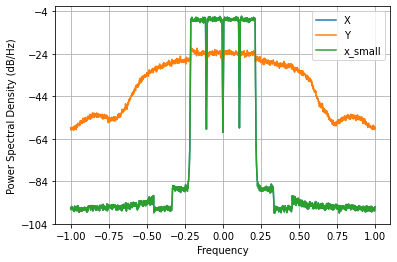

In [19]:
plt.psd(X.detach().cpu()[:,0,0]+1j*X.detach().cpu()[:,1,0],NFFT=2048, label = "X")
plt.psd(d.reshape(-1,),NFFT=2048, label = "Y")
plt.psd(x.reshape(-1,),NFFT=2048, label = "x_small")
plt.legend()
# plt.psd(x.reshape(-1,)*x.reshape(-1,),NFFT=2048)
plt.show()

## Loss function

In [20]:
loss_fn = nn.MSELoss()

# Model

In [21]:
class Cell_0(nn.Module):
  def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
    super(Cell_0,self).__init__()
    self.f = AFIR(M,0)
    self.pol = Polynomial(Poly_order,Passthrough)
    self.prod = Prod_cmp()
    self.delay = Delay(D)
  def forward(self,x):
    return self.prod(self.pol(self.f(x)), x)

class Cell_1(nn.Module):
  def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
    super(Cell_1,self).__init__()
    self.f = AFIR(M,0)
    self.pol = Polynomial(Poly_order,Passthrough)
    self.prod = Prod_cmp()
    self.delay = Delay(D)
  def forward(self,x):
    return self.prod(self.f(self.delay(x)), self.pol(x))

class Cell_2(nn.Module):
  def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
    super(Cell_2,self).__init__()
    self.f = AFIR(M,0)
    self.pol = Polynomial(Poly_order,Passthrough)
    self.prod = Prod_cmp()
    self.delay = Delay(D)
  def forward(self,x):
    return self.prod(self.f(x), self.pol(self.delay(x)))

class Cell_3(nn.Module):
  def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
    super(Cell_3,self).__init__()
    self.f = AFIR(M,0)
    self.pol = Polynomial(Poly_order,Passthrough)
    self.prod = Prod_cmp()
    self.delay = Delay(D)
  def forward(self,x):
    return self.prod(self.f(self.delay(x)), self.pol(self.delay(x)))

class Cell_4(nn.Module):
  def __init__(self,M1=15,M2=15,D=0,Poly_order=8,Passthrough=False):
    super(Cell_4,self).__init__()
    self.f1 = AFIR(M1,0)
    self.f2 = AFIR(M2,0)
    self.pol = Polynomial(Poly_order,Passthrough)
    self.prod = Prod_cmp()
    self.delay = Delay(D)
  def forward(self,x):
    return self.prod(self.f1(self.delay(x)), self.f2(self.pol(self.delay(x))))

In [22]:
net0 = Cell_0(M=9, D=0, Poly_order=9)
net0 = net0.to('cpu')
optimizer = torch.optim.Adam(net0.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, net0, loss_fn, optimizer,20,scheduler,save_flag=False)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012000150724764928 Accuracy =  -24.253533122140404 dbs
Loss =  8.520864180711235e-05 Accuracy =  -25.740563702636546 dbs
Loss =  8.420350388210025e-05 Accuracy =  -25.7920984937049 dbs
Loss =  8.394281513359257e-05 Accuracy =  -25.80556483377634 dbs
Loss =  8.400264218501362e-05 Accuracy =  -25.802470667394637 dbs
Loss =  8.373018522408107e-05 Accuracy =  -25.816579612028296 dbs
Loss =  8.350327592232774e-05 Accuracy =  -25.82836499486295 dbs
Loss =  8.3468919959926e-05 Accuracy =  -25.83015219123098 dbs
Loss =  8.369102927136811e-05 Accuracy =  -25.81861104090763 dbs
Loss =  8.394566660432417e-05 Accuracy =  -25.80541730989723 dbs
Loss =  8.359722705138997e-05 Accuracy =  -25.823481411571024 dbs
Loss =  8.380918259151069e-05 Accuracy =  -25.81248408227318 dbs
Loss =  8.388225774552419e-05 Accuracy =  -25.808699018694817 dbs
Loss =  8.380678899993019e-05 Accuracy =  -25.812608118617156 dbs
Loss =  8.358898262383548e-05 Accuracy =  -25.823909737496137 dbs
Loss =  8.364102292

In [23]:
net1 = Cell_1(M=9, D=0, Poly_order=9)
net1 = net1.to('cpu')
optimizer = torch.optim.Adam(net1.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, net1, loss_fn, optimizer,20,scheduler,save_flag=False)

net2 = Cell_2(M=9, D=0, Poly_order=9)
net2 = net2.to('cpu')
optimizer = torch.optim.Adam(net2.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, net2, loss_fn, optimizer,20,scheduler,save_flag=False)

net3 = Cell_3(M=9, D=0, Poly_order=9)
net3 = net0.to('cpu')
optimizer = torch.optim.Adam(net3.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, net3, loss_fn, optimizer,20,scheduler,save_flag=False)

net4 = Cell_4( M1=9, M2=9, D=0, Poly_order=9 )
net4 = net4.to('cpu')
optimizer = torch.optim.Adam(net4.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, net4, loss_fn, optimizer,20,scheduler,save_flag=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013441989025281164 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.471092405404704 dbs
Loss =  0.00011380495400411726 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss 

  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013441989025281164 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.471092405404704 dbs
Loss =  0.00011380495400411726 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss 

  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.3012018245597e-05 Accuracy =  -25.853990402817818 dbs
Loss =  8.250283746200818e-05 Accuracy =  -25.8807112794739 dbs
Loss =  8.25836318414908e-05 Accuracy =  -25.876460348900654 dbs
Loss =  8.273406273131457e-05 Accuracy =  -25.868556618624382 dbs
Loss =  8.279931835687754e-05 Accuracy =  -25.86513251656389 dbs
Loss =  8.286110659433372e-05 Accuracy =  -25.86189284217262 dbs
Loss =  8.267243850771484e-05 Accuracy =  -25.87179265364099 dbs
Loss =  8.264946806967379e-05 Accuracy =  -25.872999503327023 dbs
Loss =  8.264059223030856e-05 Accuracy =  -25.873465923153507 dbs
Loss =  8.262991967626522e-05 Accuracy =  -25.874026825553074 dbs
Loss =  8.287198168041292e-05 Accuracy =  -25.861322890821278 dbs
Loss =  8.26489306732654e-05 Accuracy =  -25.87302774174875 dbs
Loss =  8.25443662192006e-05 Accuracy =  -25.87852575799067 dbs
Loss =  8.251123256581548e-05 Accuracy =  -25.880269384154175 dbs
Loss =  8.249640206546328e-05 Accuracy =  -25.881050051606145 dbs
Loss =  8.288535909059

  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881002 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.850515684834747 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.215419094736588e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.198975629000111e-05 Accuracy =  -25.907804176405445 dbs
Loss =  8.179441771581438e-05 Accuracy =  -25.91816348072907 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916

In [ ]:
def draw_spectrum(desired, out):
  plt.psd((out-desired).detach().cpu()[0,0,:]+
                1j*(out-desired).detach().cpu()[0,1,:],NFFT=2048)
  plt.show()

In [ ]:

for step, (valid) in enumerate(valid_queue):
  net0.eval()
  input_batch = Variable(valid[:,:,:1],requires_grad=False).permute(2,1,0).cpu()
  desired = Variable(valid[:,:,1:],requires_grad=False).permute(2,1,0).cpu()
  out0 = net0.forward(input_batch)

plt.psd(X.detach().cpu()[:,0,0]+1j*X.detach().cpu()[:,1,0],NFFT=2048, label = "X")
plt.psd(d.reshape(-1,),NFFT=2048, label = "Y")
plt.psd((out0-D).detach().cpu()[0,0,:] + 1j*(out0-D).detach().cpu()[0,1,:],NFFT=2048, label = "4")
plt.legend()
# plt.psd(x.reshape(-1,)*x.reshape(-1,),NFFT=2048)
plt.show()

In [ ]:

plt.psd((out1-D).detach().cpu()[0,0,:] + 1j*(out1-D).detach().cpu()[0,1,:],NFFT=2048, label = "1")
plt.psd((out2-D).detach().cpu()[0,0,:] + 1j*(out2-D).detach().cpu()[0,1,:],NFFT=2048, label = "2")
plt.psd((out3-D).detach().cpu()[0,0,:] + 1j*(out3-D).detach().cpu()[0,1,:],NFFT=2048, label = "3")
plt.psd((out4-D).detach().cpu()[0,0,:] + 1j*(out4-D).detach().cpu()[0,1,:],NFFT=2048, label = "5")

plt.legend()
# plt.psd(x.reshape(-1,)*x.reshape(-1,),NFFT=2048)
plt.show()

# Hunting for plots

In [63]:
def eval_model_1(valid_queue, model,criterion):
  for step, (valid) in enumerate(valid_queue):
      model.eval()
      input_batch = Variable(valid[:,:,:1],requires_grad=False).permute(2,1,0).cpu()
      desired = Variable(valid[:,:,1:],requires_grad=False).permute(2,1,0).cpu()
      out = model.forward(input_batch)

      loss=criterion(out,desired)
      draw_spectrum_1(input_batch,desired,out)

      
      accuracy = NMSE(input_batch, out-desired)
  return loss,accuracy

def train_1(train_queue, valid_queue, model, criterion, optimizer,n_epoch,
          scheduler,log_every=1,save_flag=False,path_to_experiment=''):
  plt.figure(figsize=(16, 9))
  gg = ['-', '--', '-.', '-', 'dashdot']
  colr = ['r','c','g','k','b']
  count = 1
  for mod in model:
    for step, (valid) in enumerate(valid_queue):
      mod.eval()
      input_batch = Variable(valid[:,:,:1],requires_grad=False).permute(2,1,0).cpu()
      desired = Variable(valid[:,:,1:],requires_grad=False).permute(2,1,0).cpu()
      out = mod.forward(input_batch)
      label = "model " + str(count)
      plt.psd(((desired-out).detach().cpu()[0,0,:]+1j*(desired-out).detach().cpu()[0,1,:]),NFFT=2048, label=label, ls=gg[count-1], c=colr[count-1])
      count += 1

 
  plt.psd((X.detach().cpu()[:,0,0]+1j*X.detach().cpu()[:,1,0]),NFFT=2048,label='X',c='r')
  plt.psd(d.reshape(-1,),NFFT=2048,label='Y',color='orange')
  plt.legend()
  plt.savefig('5_cell_spec.png')
            

def draw_spectrum_1(input_batch,desired,out):
  plt.psd((out-desired).detach().cpu()[0,0,:]+
                1j*(out-desired).detach().cpu()[0,1,:],NFFT=2048)

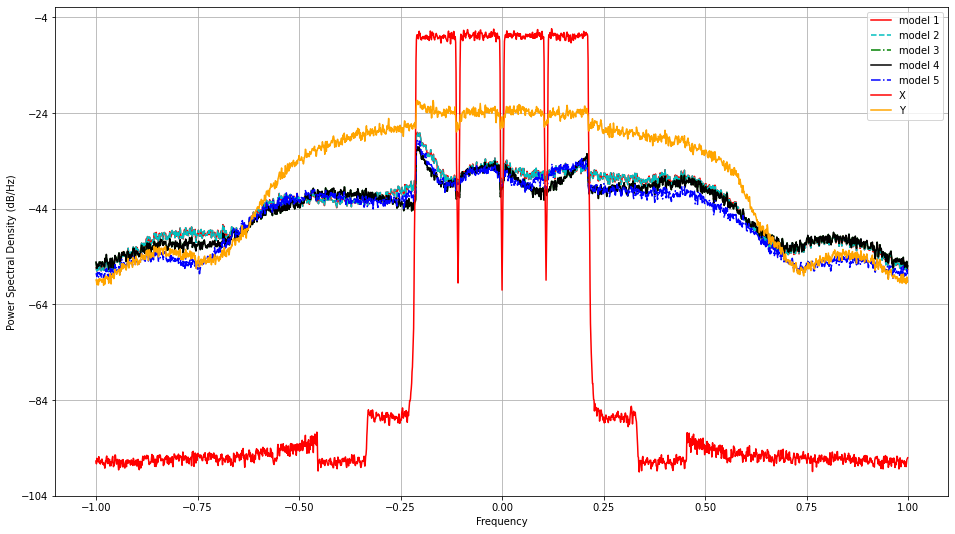

In [64]:
NNN = [ net1, net2, net3, net0, net4]
train_1(train_queue, valid_queue, NNN, loss_fn, optimizer,1,scheduler,save_flag=False)


In [ ]:
####################### OPTUNA ##########################
D = {'p': [4, 5, 6, 7, 8, 9], 'k' : [3, 5, 9], 'z' : [-2, -1, 0, 1, 2]}
ex_D = {} # extremum vals of D

for key in D.keys():
  ex_D[key] = [ min(D[key]), max(D[key])]

def objective_0(trial):

  # det hyperparams 
  poly_ord = trial.suggest_int('p', ex_D['p'][0], ex_D['p'][1])
  del_val = trial.suggest_int('z', ex_D['z'][0], ex_D['z'][1])
  conv_ord = trial.suggest_int('k', ex_D['k'][0], ex_D['k'][1], step=2)

  # create and train NN
  net = Cell_0(M=conv_ord, D=del_val, Poly_order=poly_ord)
  net = net.to('cpu')
  optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
  train(train_queue, valid_queue, net, loss_fn, optimizer,20,scheduler,save_flag=False)

  loss_cur, accuracy_cur = eval_model(valid_queue, net, loss_fn)
  score_cur = accuracy_cur.item()

  return score_cur

def objective_1(trial):

  # det hyperparams 
  poly_ord = trial.suggest_int('p', ex_D['p'][0], ex_D['p'][1])
  del_val = trial.suggest_int('z', ex_D['z'][0], ex_D['z'][1])
  conv_ord = trial.suggest_int('k', ex_D['k'][0], ex_D['k'][1], step=2)

  # create and train NN
  net = Cell_1(M=conv_ord, D=del_val, Poly_order=poly_ord)
  net = net.to('cpu')
  optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
  train(train_queue, valid_queue, net, loss_fn, optimizer,20,scheduler,save_flag=False)

  loss_cur, accuracy_cur = eval_model(valid_queue, net, loss_fn)
  score_cur = accuracy_cur.item()

  return score_cur

def objective_2(trial):

  # det hyperparams 
  poly_ord = trial.suggest_int('p', ex_D['p'][0], ex_D['p'][1])
  del_val = trial.suggest_int('z', ex_D['z'][0], ex_D['z'][1])
  conv_ord = trial.suggest_int('k', ex_D['k'][0], ex_D['k'][1], step=2)

  # create and train NN
  net = Cell_2(M=conv_ord, D=del_val, Poly_order=poly_ord)
  net = net.to('cpu')
  optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
  train(train_queue, valid_queue, net, loss_fn, optimizer,20,scheduler,save_flag=False)

  loss_cur, accuracy_cur = eval_model(valid_queue, net, loss_fn)
  score_cur = accuracy_cur.item()

  return score_cur

def objective_3(trial):

  # det hyperparams 
  poly_ord = trial.suggest_int('p', ex_D['p'][0], ex_D['p'][1])
  del_val = trial.suggest_int('z', ex_D['z'][0], ex_D['z'][1])
  conv_ord = trial.suggest_int('k', ex_D['k'][0], ex_D['k'][1], step=2)

  # create and train NN
  net = Cell_3(M=conv_ord, D=del_val, Poly_order=poly_ord)
  net = net.to('cpu')
  optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
  train(train_queue, valid_queue, net, loss_fn, optimizer,20,scheduler,save_flag=False)

  loss_cur, accuracy_cur = eval_model(valid_queue, net, loss_fn)
  score_cur = accuracy_cur.item()

  return score_cur

def objective_4(trial):

  # det hyperparams 
  poly_ord = trial.suggest_int('p', ex_D['p'][0], ex_D['p'][1])
  del_val = trial.suggest_int('z', ex_D['z'][0], ex_D['z'][1])
  conv_ord1 = trial.suggest_int('k', ex_D['k'][0], ex_D['k'][1], step=2)
  conv_ord2 = trial.suggest_int('k', ex_D['k'][0], ex_D['k'][1], step=2)

  # create and train NN
  net = Cell_4(M1=conv_ord1, M2=conv_ord2, D=del_val, Poly_order=poly_ord)
  net = net.to('cpu')
  optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
  train(train_queue, valid_queue, net, loss_fn, optimizer,20,scheduler,save_flag=False)

  loss_cur, accuracy_cur = eval_model(valid_queue, net, loss_fn)
  score_cur = accuracy_cur.item()

  return score_cur


In [ ]:
study0 = optuna.create_study(direction="minimize")
study0.optimize(objective_0, n_trials=100)
print(study0.best_params)

[I 2022-11-01 07:19:43,030] A new study created in memory with name: no-name-63461923-3e62-4d31-8ce4-70e5e234d4ab
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012460120664062075 Accuracy =  -24.09017765078433 dbs
Loss =  9.461569514086787e-05 Accuracy =  -25.285768286639765 dbs
Loss =  8.738585995506498e-05 Accuracy =  -25.630988486998014 dbs
Loss =  8.589836500321503e-05 Accuracy =  -25.705551156267404 dbs
Loss =  8.513228813287114e-05 Accuracy =  -25.744457068914222 dbs
Loss =  8.439325403861126e-05 Accuracy =  -25.782322803860815 dbs
Loss =  8.393650844886739e-05 Accuracy =  -25.805891134635562 dbs
Loss =  8.3527705763112e-05 Accuracy =  -25.827094602386662 dbs
Loss =  8.376692379175834e-05 Accuracy =  -25.814674461836166 dbs
Loss =  8.402788476285638e-05 Accuracy =  -25.801165819692528 dbs
Loss =  8.341106150813899e-05 Accuracy =  -25.83316364978081 dbs
Loss =  8.360316724642358e-05 Accuracy =  -25.823172824508603 dbs
Loss =  8.36543683065706e-05 Accuracy =  -25.820513890367245 dbs
Loss =  8.360063490071662e-05 Accuracy =  -25.823304374599303 dbs
Loss =  8.343040819394449e-05 Accuracy =  -25.832156447082216 dbs
Loss =  8.3241

[I 2022-11-01 07:20:08,282] Trial 0 finished with value: -25.874455196436386 and parameters: {'p': 7, 'z': 2, 'k': 7}. Best is trial 0 with value: -25.874455196436386.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012983354339188134 Accuracy =  -23.911531032011467 dbs
Loss =  9.223066192373924e-05 Accuracy =  -25.396646876321213 dbs
Loss =  9.04377248810312e-05 Accuracy =  -25.481903847642325 dbs
Loss =  8.971580299516159e-05 Accuracy =  -25.516710645302933 dbs
Loss =  8.919858233954395e-05 Accuracy =  -25.541820610831195 dbs
Loss =  8.868664876457706e-05 Accuracy =  -25.566817687781118 dbs
Loss =  8.822090684408796e-05 Accuracy =  -25.589684954549547 dbs
Loss =  8.780456203675094e-05 Accuracy =  -25.61022932130895 dbs
Loss =  8.743062751727253e-05 Accuracy =  -25.62876417670084 dbs
Loss =  8.708315149349846e-05 Accuracy =  -25.646058755959732 dbs
Loss =  8.679783018203511e-05 Accuracy =  -25.66031144549008 dbs
Loss =  8.649065616874315e-05 Accuracy =  -25.675708212060357 dbs
Loss =  8.620379909854032e-05 Accuracy =  -25.690136070449885 dbs
Loss =  8.594963123359011e-05 Accuracy =  -25.702959954495146 dbs
Loss =  8.57356009260102e-05 Accuracy =  -25.7137881694238 dbs
Loss =  8.552371

[I 2022-11-01 07:20:35,940] Trial 1 finished with value: -25.751208910372156 and parameters: {'p': 9, 'z': -2, 'k': 3}. Best is trial 0 with value: -25.874455196436386.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012000150724764928 Accuracy =  -24.253533122140404 dbs
Loss =  8.520864180711235e-05 Accuracy =  -25.740563702636546 dbs
Loss =  8.420350388210025e-05 Accuracy =  -25.792098493704906 dbs
Loss =  8.394281513359257e-05 Accuracy =  -25.80556483377634 dbs
Loss =  8.400264218501362e-05 Accuracy =  -25.802470667394637 dbs
Loss =  8.373018522408107e-05 Accuracy =  -25.816579612028296 dbs
Loss =  8.350327592232774e-05 Accuracy =  -25.82836499486295 dbs
Loss =  8.346891995992598e-05 Accuracy =  -25.83015219123098 dbs
Loss =  8.369102927136811e-05 Accuracy =  -25.81861104090763 dbs
Loss =  8.394566660432415e-05 Accuracy =  -25.805417309897237 dbs
Loss =  8.359722705138997e-05 Accuracy =  -25.823481411571024 dbs
Loss =  8.380918259151065e-05 Accuracy =  -25.81248408227318 dbs
Loss =  8.388225774552419e-05 Accuracy =  -25.808699018694817 dbs
Loss =  8.380678899993019e-05 Accuracy =  -25.812608118617156 dbs
Loss =  8.358898262383545e-05 Accuracy =  -25.82390973749614 dbs
Loss =  8.36410

[I 2022-11-01 07:21:02,925] Trial 2 finished with value: -25.864317423125463 and parameters: {'p': 9, 'z': -1, 'k': 9}. Best is trial 0 with value: -25.874455196436386.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001115936597532695 Accuracy =  -24.569004924831283 dbs
Loss =  9.89021447756193e-05 Accuracy =  -25.093343034006566 dbs
Loss =  9.352673878446656e-05 Accuracy =  -25.33604222090499 dbs
Loss =  9.051702360374588e-05 Accuracy =  -25.478097481665202 dbs
Loss =  8.91635033512898e-05 Accuracy =  -25.543528889938486 dbs
Loss =  8.854141823893902e-05 Accuracy =  -25.573935389968234 dbs
Loss =  8.822727884467427e-05 Accuracy =  -25.5893712845978 dbs
Loss =  8.797958859884709e-05 Accuracy =  -25.601580862963896 dbs
Loss =  8.753635488514468e-05 Accuracy =  -25.623515550084402 dbs
Loss =  8.68607506966256e-05 Accuracy =  -25.65716434693121 dbs
Loss =  8.65563414458608e-05 Accuracy =  -25.672411217006093 dbs
Loss =  8.597561396993543e-05 Accuracy =  -25.7016472724522 dbs
Loss =  8.57308823150337e-05 Accuracy =  -25.71402719767832 dbs
Loss =  8.582544268695117e-05 Accuracy =  -25.709239609474984 dbs
Loss =  8.59570911113755e-05 Accuracy =  -25.702583031043208 dbs
Loss =  8.5290966243201

[I 2022-11-01 07:21:26,022] Trial 3 finished with value: -25.75625466704605 and parameters: {'p': 5, 'z': -1, 'k': 7}. Best is trial 0 with value: -25.874455196436386.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012839338061694977 Accuracy =  -23.959973790913523 dbs
Loss =  9.387052353415388e-05 Accuracy =  -25.32010773121206 dbs
Loss =  8.747143687361005e-05 Accuracy =  -25.62673752496854 dbs
Loss =  8.55539610187237e-05 Accuracy =  -25.72299891619684 dbs
Loss =  8.46921072911005e-05 Accuracy =  -25.766970741140867 dbs
Loss =  8.420526985245878e-05 Accuracy =  -25.79200741161162 dbs
Loss =  8.402784406218302e-05 Accuracy =  -25.801167923289704 dbs
Loss =  8.396855445725953e-05 Accuracy =  -25.804233363923966 dbs
Loss =  8.390006488428094e-05 Accuracy =  -25.80777716447223 dbs
Loss =  8.370039550263429e-05 Accuracy =  -25.818125030042395 dbs
Loss =  8.354486601603716e-05 Accuracy =  -25.826202462749343 dbs
Loss =  8.339811931498144e-05 Accuracy =  -25.833837560300076 dbs
Loss =  8.334547839509858e-05 Accuracy =  -25.836579693983275 dbs
Loss =  8.3404962082242e-05 Accuracy =  -25.833481238817406 dbs
Loss =  8.352265426977898e-05 Accuracy =  -25.827357257993047 dbs
Loss =  8.32428987

[I 2022-11-01 07:21:53,516] Trial 4 finished with value: -25.81979400955734 and parameters: {'p': 8, 'z': 1, 'k': 5}. Best is trial 0 with value: -25.874455196436386.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.000100327863799472 Accuracy =  -25.031184478768836 dbs
Loss =  9.517834979021275e-05 Accuracy =  -25.26001842442751 dbs
Loss =  9.22579039014409e-05 Accuracy =  -25.39536429920051 dbs
Loss =  9.071910721062385e-05 Accuracy =  -25.468412455690764 dbs
Loss =  8.993389747500354e-05 Accuracy =  -25.50616598250503 dbs
Loss =  8.949418115019147e-05 Accuracy =  -25.52745214431755 dbs
Loss =  8.922085374169174e-05 Accuracy =  -25.54073638510784 dbs
Loss =  8.910414796316561e-05 Accuracy =  -25.546420914183614 dbs
Loss =  8.90295193894729e-05 Accuracy =  -25.550059842200415 dbs
Loss =  8.894251330619482e-05 Accuracy =  -25.554306157118283 dbs
Loss =  8.866751503453696e-05 Accuracy =  -25.567754758919328 dbs
Loss =  8.862970492539954e-05 Accuracy =  -25.569607097270847 dbs
Loss =  8.85655018060544e-05 Accuracy =  -25.572754254825174 dbs
Loss =  8.845938341877605e-05 Accuracy =  -25.57796105221813 dbs
Loss =  8.830507922829228e-05 Accuracy =  -25.585543286167187 dbs
Loss =  8.8228856237

[I 2022-11-01 07:22:15,358] Trial 5 finished with value: -25.615135298681103 and parameters: {'p': 4, 'z': -2, 'k': 7}. Best is trial 0 with value: -25.874455196436386.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012460120664062075 Accuracy =  -24.09017765078433 dbs
Loss =  9.461569514086787e-05 Accuracy =  -25.285768286639765 dbs
Loss =  8.738585995506498e-05 Accuracy =  -25.630988486998014 dbs
Loss =  8.589836500321503e-05 Accuracy =  -25.705551156267404 dbs
Loss =  8.513228813287114e-05 Accuracy =  -25.744457068914222 dbs
Loss =  8.439325403861126e-05 Accuracy =  -25.782322803860815 dbs
Loss =  8.393650844886739e-05 Accuracy =  -25.805891134635562 dbs
Loss =  8.3527705763112e-05 Accuracy =  -25.827094602386662 dbs
Loss =  8.376692379175834e-05 Accuracy =  -25.814674461836166 dbs
Loss =  8.402788476285638e-05 Accuracy =  -25.801165819692528 dbs
Loss =  8.341106150813899e-05 Accuracy =  -25.83316364978081 dbs
Loss =  8.360316724642358e-05 Accuracy =  -25.823172824508603 dbs
Loss =  8.36543683065706e-05 Accuracy =  -25.820513890367245 dbs
Loss =  8.360063490071662e-05 Accuracy =  -25.823304374599303 dbs
Loss =  8.343040819394449e-05 Accuracy =  -25.832156447082216 dbs
Loss =  8.3241

[I 2022-11-01 07:22:40,520] Trial 6 finished with value: -25.874455196436386 and parameters: {'p': 7, 'z': 1, 'k': 7}. Best is trial 0 with value: -25.874455196436386.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001115936597532695 Accuracy =  -24.569004924831283 dbs
Loss =  9.89021447756193e-05 Accuracy =  -25.093343034006566 dbs
Loss =  9.352673878446656e-05 Accuracy =  -25.33604222090499 dbs
Loss =  9.051702360374588e-05 Accuracy =  -25.478097481665202 dbs
Loss =  8.91635033512898e-05 Accuracy =  -25.543528889938486 dbs
Loss =  8.854141823893902e-05 Accuracy =  -25.573935389968234 dbs
Loss =  8.822727884467427e-05 Accuracy =  -25.5893712845978 dbs
Loss =  8.797958859884709e-05 Accuracy =  -25.601580862963896 dbs
Loss =  8.753635488514468e-05 Accuracy =  -25.623515550084402 dbs
Loss =  8.68607506966256e-05 Accuracy =  -25.65716434693121 dbs
Loss =  8.65563414458608e-05 Accuracy =  -25.672411217006093 dbs
Loss =  8.597561396993543e-05 Accuracy =  -25.7016472724522 dbs
Loss =  8.57308823150337e-05 Accuracy =  -25.71402719767832 dbs
Loss =  8.582544268695117e-05 Accuracy =  -25.709239609474984 dbs
Loss =  8.59570911113755e-05 Accuracy =  -25.702583031043208 dbs
Loss =  8.5290966243201

[I 2022-11-01 07:23:03,224] Trial 7 finished with value: -25.75625466704605 and parameters: {'p': 5, 'z': 0, 'k': 7}. Best is trial 0 with value: -25.874455196436386.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.990512838413488e-05 Accuracy =  -25.049522309009028 dbs
Loss =  9.401110440962289e-05 Accuracy =  -25.31360858485705 dbs
Loss =  9.146934232094798e-05 Accuracy =  -25.43264456688359 dbs
Loss =  9.041978772754512e-05 Accuracy =  -25.482765300030255 dbs
Loss =  8.996162230671804e-05 Accuracy =  -25.504827345329936 dbs
Loss =  8.934059975498504e-05 Accuracy =  -25.53491149517994 dbs
Loss =  8.930190429487584e-05 Accuracy =  -25.536792931532656 dbs
Loss =  8.92925008246144e-05 Accuracy =  -25.53725026671584 dbs
Loss =  8.924071886445315e-05 Accuracy =  -25.539769531223584 dbs
Loss =  8.911460713638544e-05 Accuracy =  -25.54591116298292 dbs
Loss =  8.876160927664681e-05 Accuracy =  -25.563148456079624 dbs
Loss =  8.871476017273623e-05 Accuracy =  -25.565441303048058 dbs
Loss =  8.859498775629112e-05 Accuracy =  -25.571308606799327 dbs
Loss =  8.83987525703274e-05 Accuracy =  -25.58093876583007 dbs
Loss =  8.814504118997013e-05 Accuracy =  -25.59342128090379 dbs
Loss =  8.814017949

[I 2022-11-01 07:23:25,203] Trial 8 finished with value: -25.632667503259846 and parameters: {'p': 4, 'z': 2, 'k': 9}. Best is trial 0 with value: -25.874455196436386.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012839338061694977 Accuracy =  -23.959973790913523 dbs
Loss =  9.387052353415388e-05 Accuracy =  -25.32010773121206 dbs
Loss =  8.747143687361005e-05 Accuracy =  -25.62673752496854 dbs
Loss =  8.55539610187237e-05 Accuracy =  -25.72299891619684 dbs
Loss =  8.46921072911005e-05 Accuracy =  -25.766970741140867 dbs
Loss =  8.420526985245878e-05 Accuracy =  -25.79200741161162 dbs
Loss =  8.402784406218302e-05 Accuracy =  -25.801167923289704 dbs
Loss =  8.396855445725953e-05 Accuracy =  -25.804233363923966 dbs
Loss =  8.390006488428094e-05 Accuracy =  -25.80777716447223 dbs
Loss =  8.370039550263429e-05 Accuracy =  -25.818125030042395 dbs
Loss =  8.354486601603716e-05 Accuracy =  -25.826202462749343 dbs
Loss =  8.339811931498144e-05 Accuracy =  -25.833837560300076 dbs
Loss =  8.334547839509858e-05 Accuracy =  -25.836579693983275 dbs
Loss =  8.3404962082242e-05 Accuracy =  -25.833481238817406 dbs
Loss =  8.352265426977898e-05 Accuracy =  -25.827357257993047 dbs
Loss =  8.32428987

[I 2022-11-01 07:23:51,333] Trial 9 finished with value: -25.81979400955734 and parameters: {'p': 8, 'z': -2, 'k': 5}. Best is trial 0 with value: -25.874455196436386.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00011965415687814728 Accuracy =  -24.26612222200108 dbs
Loss =  0.00010213098419052607 Accuracy =  -24.95382496109376 dbs
Loss =  9.537683892772955e-05 Accuracy =  -25.250970886137097 dbs
Loss =  9.373632327626174e-05 Accuracy =  -25.326320984342672 dbs
Loss =  9.27500110446535e-05 Accuracy =  -25.37226043135759 dbs
Loss =  9.192622995467244e-05 Accuracy =  -25.411005637849897 dbs
Loss =  9.102725778146456e-05 Accuracy =  -25.453685534384075 dbs
Loss =  9.023294306375503e-05 Accuracy =  -25.491748904655125 dbs
Loss =  8.952844600670131e-05 Accuracy =  -25.525789668626796 dbs
Loss =  8.890401948002267e-05 Accuracy =  -25.55618616639292 dbs
Loss =  8.836441915326742e-05 Accuracy =  -25.58262586089814 dbs
Loss =  8.783234557705435e-05 Accuracy =  -25.60885532326878 dbs
Loss =  8.73894198027836e-05 Accuracy =  -25.630811571564323 dbs
Loss =  8.701763729255313e-05 Accuracy =  -25.64932726008292 dbs
Loss =  8.669622298262089e-05 Accuracy =  -25.66539835772337 dbs
Loss =  8.62181921

[I 2022-11-01 07:24:15,283] Trial 10 finished with value: -25.733261591999938 and parameters: {'p': 6, 'z': 2, 'k': 3}. Best is trial 0 with value: -25.874455196436386.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012460120664062075 Accuracy =  -24.09017765078433 dbs
Loss =  9.461569514086787e-05 Accuracy =  -25.285768286639765 dbs
Loss =  8.738585995506498e-05 Accuracy =  -25.630988486998014 dbs
Loss =  8.589836500321503e-05 Accuracy =  -25.705551156267404 dbs
Loss =  8.513228813287114e-05 Accuracy =  -25.744457068914222 dbs
Loss =  8.439325403861126e-05 Accuracy =  -25.782322803860815 dbs
Loss =  8.393650844886739e-05 Accuracy =  -25.805891134635562 dbs
Loss =  8.3527705763112e-05 Accuracy =  -25.827094602386662 dbs
Loss =  8.376692379175834e-05 Accuracy =  -25.814674461836166 dbs
Loss =  8.402788476285638e-05 Accuracy =  -25.801165819692528 dbs
Loss =  8.341106150813899e-05 Accuracy =  -25.83316364978081 dbs
Loss =  8.360316724642358e-05 Accuracy =  -25.823172824508603 dbs
Loss =  8.36543683065706e-05 Accuracy =  -25.820513890367245 dbs
Loss =  8.360063490071662e-05 Accuracy =  -25.823304374599303 dbs
Loss =  8.343040819394449e-05 Accuracy =  -25.832156447082216 dbs
Loss =  8.3241

[I 2022-11-01 07:24:39,923] Trial 11 finished with value: -25.874455196436386 and parameters: {'p': 7, 'z': 1, 'k': 7}. Best is trial 0 with value: -25.874455196436386.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:25:05,357] Trial 12 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': 1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00011703027819267164 Accuracy =  -24.36241775744465 dbs
Loss =  9.58070704367634e-05 Accuracy =  -25.231424525113283 dbs
Loss =  8.793703911240173e-05 Accuracy =  -25.60368174538437 dbs
Loss =  8.705887606885374e-05 Accuracy =  -25.64726957028008 dbs
Loss =  8.670449922847555e-05 Accuracy =  -25.664983788757052 dbs
Loss =  8.595606759477283e-05 Accuracy =  -25.702634744084378 dbs
Loss =  8.516774326548084e-05 Accuracy =  -25.742648734700353 dbs
Loss =  8.470499803880847e-05 Accuracy =  -25.76630976401294 dbs
Loss =  8.49629944074052e-05 Accuracy =  -25.753102030017203 dbs
Loss =  8.509578827219617e-05 Accuracy =  -25.746319474771006 dbs
Loss =  8.451066762550271e-05 Accuracy =  -25.776284805382303 dbs
Loss =  8.450966377607832e-05 Accuracy =  -25.776336392817033 dbs
Loss =  8.428947397661117e-05 Accuracy =  -25.787666695849673 dbs
Loss =  8.38891179245538e-05 Accuracy =  -25.808343852280142 dbs
Loss =  8.359232398942202e-05 Accuracy =  -25.8237361371498 dbs
Loss =  8.34341581

[I 2022-11-01 07:25:31,067] Trial 13 finished with value: -25.863405017834545 and parameters: {'p': 6, 'z': 2, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012199507341822689 Accuracy =  -24.18197720418555 dbs
Loss =  8.627651104087402e-05 Accuracy =  -25.686474389047625 dbs
Loss =  8.46256821328048e-05 Accuracy =  -25.77037830762109 dbs
Loss =  8.416662687247359e-05 Accuracy =  -25.79400090739007 dbs
Loss =  8.41319523359768e-05 Accuracy =  -25.795790460236802 dbs
Loss =  8.371162958400591e-05 Accuracy =  -25.817542168739124 dbs
Loss =  8.34174313054051e-05 Accuracy =  -25.832832007654435 dbs
Loss =  8.342222916006007e-05 Accuracy =  -25.832582225103163 dbs
Loss =  8.364207121680223e-05 Accuracy =  -25.821152344868096 dbs
Loss =  8.384153096555787e-05 Accuracy =  -25.810808131097843 dbs
Loss =  8.340933217493945e-05 Accuracy =  -25.833253691513644 dbs
Loss =  8.35966545544647e-05 Accuracy =  -25.8235111533598 dbs
Loss =  8.363988691220353e-05 Accuracy =  -25.821265761932874 dbs
Loss =  8.353825947701243e-05 Accuracy =  -25.826545906581376 dbs
Loss =  8.329428127832769e-05 Accuracy =  -25.839248279925325 dbs
Loss =  8.33301070

[I 2022-11-01 07:25:57,272] Trial 14 finished with value: -25.87755122512624 and parameters: {'p': 8, 'z': 1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012199507341822689 Accuracy =  -24.18197720418555 dbs
Loss =  8.627651104087402e-05 Accuracy =  -25.686474389047625 dbs
Loss =  8.46256821328048e-05 Accuracy =  -25.77037830762109 dbs
Loss =  8.416662687247359e-05 Accuracy =  -25.79400090739007 dbs
Loss =  8.41319523359768e-05 Accuracy =  -25.795790460236802 dbs
Loss =  8.371162958400591e-05 Accuracy =  -25.817542168739124 dbs
Loss =  8.34174313054051e-05 Accuracy =  -25.832832007654435 dbs
Loss =  8.342222916006007e-05 Accuracy =  -25.832582225103163 dbs
Loss =  8.364207121680223e-05 Accuracy =  -25.821152344868096 dbs
Loss =  8.384153096555787e-05 Accuracy =  -25.810808131097843 dbs
Loss =  8.340933217493945e-05 Accuracy =  -25.833253691513644 dbs
Loss =  8.35966545544647e-05 Accuracy =  -25.8235111533598 dbs
Loss =  8.363988691220353e-05 Accuracy =  -25.821265761932874 dbs
Loss =  8.353825947701243e-05 Accuracy =  -25.826545906581376 dbs
Loss =  8.329428127832769e-05 Accuracy =  -25.839248279925325 dbs
Loss =  8.33301070

[I 2022-11-01 07:26:23,344] Trial 15 finished with value: -25.87755122512624 and parameters: {'p': 8, 'z': 0, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012199507341822689 Accuracy =  -24.18197720418555 dbs
Loss =  8.627651104087402e-05 Accuracy =  -25.686474389047625 dbs
Loss =  8.46256821328048e-05 Accuracy =  -25.77037830762109 dbs
Loss =  8.416662687247359e-05 Accuracy =  -25.79400090739007 dbs
Loss =  8.41319523359768e-05 Accuracy =  -25.795790460236802 dbs
Loss =  8.371162958400591e-05 Accuracy =  -25.817542168739124 dbs
Loss =  8.34174313054051e-05 Accuracy =  -25.832832007654435 dbs
Loss =  8.342222916006007e-05 Accuracy =  -25.832582225103163 dbs
Loss =  8.364207121680223e-05 Accuracy =  -25.821152344868096 dbs
Loss =  8.384153096555787e-05 Accuracy =  -25.810808131097843 dbs
Loss =  8.340933217493945e-05 Accuracy =  -25.833253691513644 dbs
Loss =  8.35966545544647e-05 Accuracy =  -25.8235111533598 dbs
Loss =  8.363988691220353e-05 Accuracy =  -25.821265761932874 dbs
Loss =  8.353825947701243e-05 Accuracy =  -25.826545906581376 dbs
Loss =  8.329428127832769e-05 Accuracy =  -25.839248279925325 dbs
Loss =  8.33301070

[I 2022-11-01 07:26:49,923] Trial 16 finished with value: -25.87755122512624 and parameters: {'p': 8, 'z': 1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012000150724764928 Accuracy =  -24.253533122140404 dbs
Loss =  8.520864180711235e-05 Accuracy =  -25.740563702636546 dbs
Loss =  8.420350388210025e-05 Accuracy =  -25.792098493704906 dbs
Loss =  8.394281513359257e-05 Accuracy =  -25.80556483377634 dbs
Loss =  8.400264218501362e-05 Accuracy =  -25.802470667394637 dbs
Loss =  8.373018522408107e-05 Accuracy =  -25.816579612028296 dbs
Loss =  8.350327592232774e-05 Accuracy =  -25.82836499486295 dbs
Loss =  8.346891995992598e-05 Accuracy =  -25.83015219123098 dbs
Loss =  8.369102927136811e-05 Accuracy =  -25.81861104090763 dbs
Loss =  8.394566660432415e-05 Accuracy =  -25.805417309897237 dbs
Loss =  8.359722705138997e-05 Accuracy =  -25.823481411571024 dbs
Loss =  8.380918259151065e-05 Accuracy =  -25.81248408227318 dbs
Loss =  8.388225774552419e-05 Accuracy =  -25.808699018694817 dbs
Loss =  8.380678899993019e-05 Accuracy =  -25.812608118617156 dbs
Loss =  8.358898262383545e-05 Accuracy =  -25.82390973749614 dbs
Loss =  8.36410

[I 2022-11-01 07:27:17,324] Trial 17 finished with value: -25.864317423125463 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012297923166952718 Accuracy =  -24.14708237738807 dbs
Loss =  0.00010185829469071341 Accuracy =  -24.965436121860062 dbs
Loss =  9.377597078459929e-05 Accuracy =  -25.324484444031008 dbs
Loss =  9.039120599221196e-05 Accuracy =  -25.484138323847713 dbs
Loss =  8.863038947677284e-05 Accuracy =  -25.56957355369354 dbs
Loss =  8.781646100848818e-05 Accuracy =  -25.609640820264588 dbs
Loss =  8.71257519540309e-05 Accuracy =  -25.643934737618718 dbs
Loss =  8.661560719497365e-05 Accuracy =  -25.669438589047292 dbs
Loss =  8.623206871354192e-05 Accuracy =  -25.688712081570255 dbs
Loss =  8.58627875508109e-05 Accuracy =  -25.707350293179392 dbs
Loss =  8.520484122717357e-05 Accuracy =  -25.740757416287167 dbs
Loss =  8.483002487747643e-05 Accuracy =  -25.75990418774523 dbs
Loss =  8.433174129211695e-05 Accuracy =  -25.78548945353242 dbs
Loss =  8.40521527563768e-05 Accuracy =  -25.79991172005029 dbs
Loss =  8.407475365633597e-05 Accuracy =  -25.7987440965679 dbs
Loss =  8.35266282

[I 2022-11-01 07:27:41,123] Trial 18 finished with value: -25.814191360730252 and parameters: {'p': 6, 'z': -1, 'k': 5}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:28:06,001] Trial 19 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': 1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:28:31,021] Trial 20 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': 0, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:28:56,017] Trial 21 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': 0, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:29:22,732] Trial 22 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': 0, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00011703027819267164 Accuracy =  -24.36241775744465 dbs
Loss =  9.58070704367634e-05 Accuracy =  -25.231424525113283 dbs
Loss =  8.793703911240173e-05 Accuracy =  -25.60368174538437 dbs
Loss =  8.705887606885374e-05 Accuracy =  -25.64726957028008 dbs
Loss =  8.670449922847555e-05 Accuracy =  -25.664983788757052 dbs
Loss =  8.595606759477283e-05 Accuracy =  -25.702634744084378 dbs
Loss =  8.516774326548084e-05 Accuracy =  -25.742648734700353 dbs
Loss =  8.470499803880847e-05 Accuracy =  -25.76630976401294 dbs
Loss =  8.49629944074052e-05 Accuracy =  -25.753102030017203 dbs
Loss =  8.509578827219617e-05 Accuracy =  -25.746319474771006 dbs
Loss =  8.451066762550271e-05 Accuracy =  -25.776284805382303 dbs
Loss =  8.450966377607832e-05 Accuracy =  -25.776336392817033 dbs
Loss =  8.428947397661117e-05 Accuracy =  -25.787666695849673 dbs
Loss =  8.38891179245538e-05 Accuracy =  -25.808343852280142 dbs
Loss =  8.359232398942202e-05 Accuracy =  -25.8237361371498 dbs
Loss =  8.34341581

[I 2022-11-01 07:29:46,461] Trial 23 finished with value: -25.863405017834545 and parameters: {'p': 6, 'z': 0, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001115936597532695 Accuracy =  -24.569004924831283 dbs
Loss =  9.89021447756193e-05 Accuracy =  -25.093343034006566 dbs
Loss =  9.352673878446656e-05 Accuracy =  -25.33604222090499 dbs
Loss =  9.051702360374588e-05 Accuracy =  -25.478097481665202 dbs
Loss =  8.91635033512898e-05 Accuracy =  -25.543528889938486 dbs
Loss =  8.854141823893902e-05 Accuracy =  -25.573935389968234 dbs
Loss =  8.822727884467427e-05 Accuracy =  -25.5893712845978 dbs
Loss =  8.797958859884709e-05 Accuracy =  -25.601580862963896 dbs
Loss =  8.753635488514468e-05 Accuracy =  -25.623515550084402 dbs
Loss =  8.68607506966256e-05 Accuracy =  -25.65716434693121 dbs
Loss =  8.65563414458608e-05 Accuracy =  -25.672411217006093 dbs
Loss =  8.597561396993543e-05 Accuracy =  -25.7016472724522 dbs
Loss =  8.57308823150337e-05 Accuracy =  -25.71402719767832 dbs
Loss =  8.582544268695117e-05 Accuracy =  -25.709239609474984 dbs
Loss =  8.59570911113755e-05 Accuracy =  -25.702583031043208 dbs
Loss =  8.5290966243201

[I 2022-11-01 07:30:09,594] Trial 24 finished with value: -25.75625466704605 and parameters: {'p': 5, 'z': -1, 'k': 7}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:30:34,875] Trial 25 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': 0, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001198472605134081 Accuracy =  -24.25911901823592 dbs
Loss =  9.90120408848823e-05 Accuracy =  -25.08852000643212 dbs
Loss =  9.056933244846521e-05 Accuracy =  -25.47558846400717 dbs
Loss =  8.789964055991181e-05 Accuracy =  -25.605529139824796 dbs
Loss =  8.702078759989831e-05 Accuracy =  -25.649170034907236 dbs
Loss =  8.617097681252213e-05 Accuracy =  -25.691789971120457 dbs
Loss =  8.572933108558757e-05 Accuracy =  -25.714105780385673 dbs
Loss =  8.486922340407713e-05 Accuracy =  -25.757897849558518 dbs
Loss =  8.454548419813304e-05 Accuracy =  -25.774495974224987 dbs
Loss =  8.483491443677243e-05 Accuracy =  -25.759653869838615 dbs
Loss =  8.424554528133554e-05 Accuracy =  -25.789930675225765 dbs
Loss =  8.443795938580401e-05 Accuracy =  -25.780022839813014 dbs
Loss =  8.441159958489546e-05 Accuracy =  -25.78137882987203 dbs
Loss =  8.419513327343774e-05 Accuracy =  -25.792530244129573 dbs
Loss =  8.386156239737199e-05 Accuracy =  -25.80977063797015 dbs
Loss =  8.367904

[I 2022-11-01 07:30:58,899] Trial 26 finished with value: -25.851135822194852 and parameters: {'p': 6, 'z': -1, 'k': 7}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012199507341822689 Accuracy =  -24.18197720418555 dbs
Loss =  8.627651104087402e-05 Accuracy =  -25.686474389047625 dbs
Loss =  8.46256821328048e-05 Accuracy =  -25.77037830762109 dbs
Loss =  8.416662687247359e-05 Accuracy =  -25.79400090739007 dbs
Loss =  8.41319523359768e-05 Accuracy =  -25.795790460236802 dbs
Loss =  8.371162958400591e-05 Accuracy =  -25.817542168739124 dbs
Loss =  8.34174313054051e-05 Accuracy =  -25.832832007654435 dbs
Loss =  8.342222916006007e-05 Accuracy =  -25.832582225103163 dbs
Loss =  8.364207121680223e-05 Accuracy =  -25.821152344868096 dbs
Loss =  8.384153096555787e-05 Accuracy =  -25.810808131097843 dbs
Loss =  8.340933217493945e-05 Accuracy =  -25.833253691513644 dbs
Loss =  8.35966545544647e-05 Accuracy =  -25.8235111533598 dbs
Loss =  8.363988691220353e-05 Accuracy =  -25.821265761932874 dbs
Loss =  8.353825947701243e-05 Accuracy =  -25.826545906581376 dbs
Loss =  8.329428127832769e-05 Accuracy =  -25.839248279925325 dbs
Loss =  8.33301070

[I 2022-11-01 07:31:24,878] Trial 27 finished with value: -25.87755122512624 and parameters: {'p': 8, 'z': 0, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012704699239293054 Accuracy =  -24.00575624764476 dbs
Loss =  9.92797981404554e-05 Accuracy =  -25.076791276713998 dbs
Loss =  8.94478542329187e-05 Accuracy =  -25.52970086412691 dbs
Loss =  8.732546203386853e-05 Accuracy =  -25.633991209962996 dbs
Loss =  8.61109210197872e-05 Accuracy =  -25.694817787829667 dbs
Loss =  8.532704038277444e-05 Accuracy =  -25.734533309973063 dbs
Loss =  8.487521229981885e-05 Accuracy =  -25.757591395404233 dbs
Loss =  8.45944704246419e-05 Accuracy =  -25.771980371273063 dbs
Loss =  8.43708272744413e-05 Accuracy =  -25.783477056579464 dbs
Loss =  8.399638035833977e-05 Accuracy =  -25.802794416513073 dbs
Loss =  8.36649673647997e-05 Accuracy =  -25.819963671530918 dbs
Loss =  8.341945257343891e-05 Accuracy =  -25.832726776061374 dbs
Loss =  8.336714765387535e-05 Accuracy =  -25.835450704561215 dbs
Loss =  8.34591091771297e-05 Accuracy =  -25.830662682951093 dbs
Loss =  8.358003993895356e-05 Accuracy =  -25.82437438802071 dbs
Loss =  8.312469927

[I 2022-11-01 07:31:49,857] Trial 28 finished with value: -25.82750912682429 and parameters: {'p': 7, 'z': 0, 'k': 5}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001198472605134081 Accuracy =  -24.25911901823592 dbs
Loss =  9.90120408848823e-05 Accuracy =  -25.08852000643212 dbs
Loss =  9.056933244846521e-05 Accuracy =  -25.47558846400717 dbs
Loss =  8.789964055991181e-05 Accuracy =  -25.605529139824796 dbs
Loss =  8.702078759989831e-05 Accuracy =  -25.649170034907236 dbs
Loss =  8.617097681252213e-05 Accuracy =  -25.691789971120457 dbs
Loss =  8.572933108558757e-05 Accuracy =  -25.714105780385673 dbs
Loss =  8.486922340407713e-05 Accuracy =  -25.757897849558518 dbs
Loss =  8.454548419813304e-05 Accuracy =  -25.774495974224987 dbs
Loss =  8.483491443677243e-05 Accuracy =  -25.759653869838615 dbs
Loss =  8.424554528133554e-05 Accuracy =  -25.789930675225765 dbs
Loss =  8.443795938580401e-05 Accuracy =  -25.780022839813014 dbs
Loss =  8.441159958489546e-05 Accuracy =  -25.78137882987203 dbs
Loss =  8.419513327343774e-05 Accuracy =  -25.792530244129573 dbs
Loss =  8.386156239737199e-05 Accuracy =  -25.80977063797015 dbs
Loss =  8.367904

[I 2022-11-01 07:32:13,761] Trial 29 finished with value: -25.851135822194852 and parameters: {'p': 6, 'z': 0, 'k': 7}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:32:38,679] Trial 30 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': -1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:33:05,117] Trial 31 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': -1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:33:29,971] Trial 32 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': -1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:33:54,646] Trial 33 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': -2, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012874071731181286 Accuracy =  -23.94824088556145 dbs
Loss =  9.583045656913223e-05 Accuracy =  -25.230364558576465 dbs
Loss =  9.129108535532745e-05 Accuracy =  -25.441116427237972 dbs
Loss =  9.029066769535188e-05 Accuracy =  -25.48897148515621 dbs
Loss =  8.955024496598102e-05 Accuracy =  -25.52473234933082 dbs
Loss =  8.886488915448572e-05 Accuracy =  -25.55809809630921 dbs
Loss =  8.831414617690617e-05 Accuracy =  -25.58509738615317 dbs
Loss =  8.785763287466603e-05 Accuracy =  -25.607605151348032 dbs
Loss =  8.745735353287637e-05 Accuracy =  -25.6274368171967 dbs
Loss =  8.709150172887383e-05 Accuracy =  -25.645642339324844 dbs
Loss =  8.673724212510876e-05 Accuracy =  -25.663344038211733 dbs
Loss =  8.642292303976979e-05 Accuracy =  -25.679110619875217 dbs
Loss =  8.614069902090217e-05 Accuracy =  -25.693316214527524 dbs
Loss =  8.589573467481574e-05 Accuracy =  -25.705684145364426 dbs
Loss =  8.56844160733951e-05 Accuracy =  -25.716381717143317 dbs
Loss =  8.5398438

[I 2022-11-01 07:34:19,958] Trial 34 finished with value: -25.76102409554128 and parameters: {'p': 8, 'z': -2, 'k': 3}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:34:44,910] Trial 35 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': -1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.000127004972753921 Accuracy =  -24.007192874793798 dbs
Loss =  8.622032376498604e-05 Accuracy =  -25.689303638032026 dbs
Loss =  8.522294260108149e-05 Accuracy =  -25.73983487576519 dbs
Loss =  8.45259682615945e-05 Accuracy =  -25.775498587435223 dbs
Loss =  8.41384825699955e-05 Accuracy =  -25.79545337849064 dbs
Loss =  8.375875723692119e-05 Accuracy =  -25.815097882255408 dbs
Loss =  8.361059071839595e-05 Accuracy =  -25.822787213545062 dbs
Loss =  8.334737026207726e-05 Accuracy =  -25.836481114182646 dbs
Loss =  8.336362493559498e-05 Accuracy =  -25.835634221627313 dbs
Loss =  8.35973871731523e-05 Accuracy =  -25.823473093121518 dbs
Loss =  8.327915807064143e-05 Accuracy =  -25.840036872115117 dbs
Loss =  8.351601861253571e-05 Accuracy =  -25.827702307349142 dbs
Loss =  8.369667407862356e-05 Accuracy =  -25.81831812708011 dbs
Loss =  8.377089420279222e-05 Accuracy =  -25.814468618448224 dbs
Loss =  8.374175876681447e-05 Accuracy =  -25.81597935318692 dbs
Loss =  8.36676382

[I 2022-11-01 07:35:11,152] Trial 36 finished with value: -25.84938265550282 and parameters: {'p': 9, 'z': -2, 'k': 7}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00011703027819267164 Accuracy =  -24.36241775744465 dbs
Loss =  9.58070704367634e-05 Accuracy =  -25.231424525113283 dbs
Loss =  8.793703911240173e-05 Accuracy =  -25.60368174538437 dbs
Loss =  8.705887606885374e-05 Accuracy =  -25.64726957028008 dbs
Loss =  8.670449922847555e-05 Accuracy =  -25.664983788757052 dbs
Loss =  8.595606759477283e-05 Accuracy =  -25.702634744084378 dbs
Loss =  8.516774326548084e-05 Accuracy =  -25.742648734700353 dbs
Loss =  8.470499803880847e-05 Accuracy =  -25.76630976401294 dbs
Loss =  8.49629944074052e-05 Accuracy =  -25.753102030017203 dbs
Loss =  8.509578827219617e-05 Accuracy =  -25.746319474771006 dbs
Loss =  8.451066762550271e-05 Accuracy =  -25.776284805382303 dbs
Loss =  8.450966377607832e-05 Accuracy =  -25.776336392817033 dbs
Loss =  8.428947397661117e-05 Accuracy =  -25.787666695849673 dbs
Loss =  8.38891179245538e-05 Accuracy =  -25.808343852280142 dbs
Loss =  8.359232398942202e-05 Accuracy =  -25.8237361371498 dbs
Loss =  8.34341581

[I 2022-11-01 07:35:34,937] Trial 37 finished with value: -25.863405017834545 and parameters: {'p': 6, 'z': -2, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001115936597532695 Accuracy =  -24.569004924831283 dbs
Loss =  9.89021447756193e-05 Accuracy =  -25.093343034006566 dbs
Loss =  9.352673878446656e-05 Accuracy =  -25.33604222090499 dbs
Loss =  9.051702360374588e-05 Accuracy =  -25.478097481665202 dbs
Loss =  8.91635033512898e-05 Accuracy =  -25.543528889938486 dbs
Loss =  8.854141823893902e-05 Accuracy =  -25.573935389968234 dbs
Loss =  8.822727884467427e-05 Accuracy =  -25.5893712845978 dbs
Loss =  8.797958859884709e-05 Accuracy =  -25.601580862963896 dbs
Loss =  8.753635488514468e-05 Accuracy =  -25.623515550084402 dbs
Loss =  8.68607506966256e-05 Accuracy =  -25.65716434693121 dbs
Loss =  8.65563414458608e-05 Accuracy =  -25.672411217006093 dbs
Loss =  8.597561396993543e-05 Accuracy =  -25.7016472724522 dbs
Loss =  8.57308823150337e-05 Accuracy =  -25.71402719767832 dbs
Loss =  8.582544268695117e-05 Accuracy =  -25.709239609474984 dbs
Loss =  8.59570911113755e-05 Accuracy =  -25.702583031043208 dbs
Loss =  8.5290966243201

[I 2022-11-01 07:35:57,790] Trial 38 finished with value: -25.75625466704605 and parameters: {'p': 5, 'z': -2, 'k': 7}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012199507341822689 Accuracy =  -24.18197720418555 dbs
Loss =  8.627651104087402e-05 Accuracy =  -25.686474389047625 dbs
Loss =  8.46256821328048e-05 Accuracy =  -25.77037830762109 dbs
Loss =  8.416662687247359e-05 Accuracy =  -25.79400090739007 dbs
Loss =  8.41319523359768e-05 Accuracy =  -25.795790460236802 dbs
Loss =  8.371162958400591e-05 Accuracy =  -25.817542168739124 dbs
Loss =  8.34174313054051e-05 Accuracy =  -25.832832007654435 dbs
Loss =  8.342222916006007e-05 Accuracy =  -25.832582225103163 dbs
Loss =  8.364207121680223e-05 Accuracy =  -25.821152344868096 dbs
Loss =  8.384153096555787e-05 Accuracy =  -25.810808131097843 dbs
Loss =  8.340933217493945e-05 Accuracy =  -25.833253691513644 dbs
Loss =  8.35966545544647e-05 Accuracy =  -25.8235111533598 dbs
Loss =  8.363988691220353e-05 Accuracy =  -25.821265761932874 dbs
Loss =  8.353825947701243e-05 Accuracy =  -25.826545906581376 dbs
Loss =  8.329428127832769e-05 Accuracy =  -25.839248279925325 dbs
Loss =  8.33301070

[I 2022-11-01 07:36:25,065] Trial 39 finished with value: -25.87755122512624 and parameters: {'p': 8, 'z': -1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012460120664062075 Accuracy =  -24.09017765078433 dbs
Loss =  9.461569514086787e-05 Accuracy =  -25.285768286639765 dbs
Loss =  8.738585995506498e-05 Accuracy =  -25.630988486998014 dbs
Loss =  8.589836500321503e-05 Accuracy =  -25.705551156267404 dbs
Loss =  8.513228813287114e-05 Accuracy =  -25.744457068914222 dbs
Loss =  8.439325403861126e-05 Accuracy =  -25.782322803860815 dbs
Loss =  8.393650844886739e-05 Accuracy =  -25.805891134635562 dbs
Loss =  8.3527705763112e-05 Accuracy =  -25.827094602386662 dbs
Loss =  8.376692379175834e-05 Accuracy =  -25.814674461836166 dbs
Loss =  8.402788476285638e-05 Accuracy =  -25.801165819692528 dbs
Loss =  8.341106150813899e-05 Accuracy =  -25.83316364978081 dbs
Loss =  8.360316724642358e-05 Accuracy =  -25.823172824508603 dbs
Loss =  8.36543683065706e-05 Accuracy =  -25.820513890367245 dbs
Loss =  8.360063490071662e-05 Accuracy =  -25.823304374599303 dbs
Loss =  8.343040819394449e-05 Accuracy =  -25.832156447082216 dbs
Loss =  8.3241

[I 2022-11-01 07:36:49,992] Trial 40 finished with value: -25.874455196436386 and parameters: {'p': 7, 'z': -1, 'k': 7}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:37:15,037] Trial 41 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': -1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:37:39,762] Trial 42 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': -1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:38:05,073] Trial 43 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': -1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012199507341822689 Accuracy =  -24.18197720418555 dbs
Loss =  8.627651104087402e-05 Accuracy =  -25.686474389047625 dbs
Loss =  8.46256821328048e-05 Accuracy =  -25.77037830762109 dbs
Loss =  8.416662687247359e-05 Accuracy =  -25.79400090739007 dbs
Loss =  8.41319523359768e-05 Accuracy =  -25.795790460236802 dbs
Loss =  8.371162958400591e-05 Accuracy =  -25.817542168739124 dbs
Loss =  8.34174313054051e-05 Accuracy =  -25.832832007654435 dbs
Loss =  8.342222916006007e-05 Accuracy =  -25.832582225103163 dbs
Loss =  8.364207121680223e-05 Accuracy =  -25.821152344868096 dbs
Loss =  8.384153096555787e-05 Accuracy =  -25.810808131097843 dbs
Loss =  8.340933217493945e-05 Accuracy =  -25.833253691513644 dbs
Loss =  8.35966545544647e-05 Accuracy =  -25.8235111533598 dbs
Loss =  8.363988691220353e-05 Accuracy =  -25.821265761932874 dbs
Loss =  8.353825947701243e-05 Accuracy =  -25.826545906581376 dbs
Loss =  8.329428127832769e-05 Accuracy =  -25.839248279925325 dbs
Loss =  8.33301070

[I 2022-11-01 07:38:31,042] Trial 44 finished with value: -25.87755122512624 and parameters: {'p': 8, 'z': -2, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00011703027819267164 Accuracy =  -24.36241775744465 dbs
Loss =  9.58070704367634e-05 Accuracy =  -25.231424525113283 dbs
Loss =  8.793703911240173e-05 Accuracy =  -25.60368174538437 dbs
Loss =  8.705887606885374e-05 Accuracy =  -25.64726957028008 dbs
Loss =  8.670449922847555e-05 Accuracy =  -25.664983788757052 dbs
Loss =  8.595606759477283e-05 Accuracy =  -25.702634744084378 dbs
Loss =  8.516774326548084e-05 Accuracy =  -25.742648734700353 dbs
Loss =  8.470499803880847e-05 Accuracy =  -25.76630976401294 dbs
Loss =  8.49629944074052e-05 Accuracy =  -25.753102030017203 dbs
Loss =  8.509578827219617e-05 Accuracy =  -25.746319474771006 dbs
Loss =  8.451066762550271e-05 Accuracy =  -25.776284805382303 dbs
Loss =  8.450966377607832e-05 Accuracy =  -25.776336392817033 dbs
Loss =  8.428947397661117e-05 Accuracy =  -25.787666695849673 dbs
Loss =  8.38891179245538e-05 Accuracy =  -25.808343852280142 dbs
Loss =  8.359232398942202e-05 Accuracy =  -25.8237361371498 dbs
Loss =  8.34341581

[I 2022-11-01 07:38:54,981] Trial 45 finished with value: -25.863405017834545 and parameters: {'p': 6, 'z': -2, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:39:19,940] Trial 46 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': 1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001198472605134081 Accuracy =  -24.25911901823592 dbs
Loss =  9.90120408848823e-05 Accuracy =  -25.08852000643212 dbs
Loss =  9.056933244846521e-05 Accuracy =  -25.47558846400717 dbs
Loss =  8.789964055991181e-05 Accuracy =  -25.605529139824796 dbs
Loss =  8.702078759989831e-05 Accuracy =  -25.649170034907236 dbs
Loss =  8.617097681252213e-05 Accuracy =  -25.691789971120457 dbs
Loss =  8.572933108558757e-05 Accuracy =  -25.714105780385673 dbs
Loss =  8.486922340407713e-05 Accuracy =  -25.757897849558518 dbs
Loss =  8.454548419813304e-05 Accuracy =  -25.774495974224987 dbs
Loss =  8.483491443677243e-05 Accuracy =  -25.759653869838615 dbs
Loss =  8.424554528133554e-05 Accuracy =  -25.789930675225765 dbs
Loss =  8.443795938580401e-05 Accuracy =  -25.780022839813014 dbs
Loss =  8.441159958489546e-05 Accuracy =  -25.78137882987203 dbs
Loss =  8.419513327343774e-05 Accuracy =  -25.792530244129573 dbs
Loss =  8.386156239737199e-05 Accuracy =  -25.80977063797015 dbs
Loss =  8.367904

[I 2022-11-01 07:39:44,046] Trial 47 finished with value: -25.851135822194852 and parameters: {'p': 6, 'z': 1, 'k': 7}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012199507341822689 Accuracy =  -24.18197720418555 dbs
Loss =  8.627651104087402e-05 Accuracy =  -25.686474389047625 dbs
Loss =  8.46256821328048e-05 Accuracy =  -25.77037830762109 dbs
Loss =  8.416662687247359e-05 Accuracy =  -25.79400090739007 dbs
Loss =  8.41319523359768e-05 Accuracy =  -25.795790460236802 dbs
Loss =  8.371162958400591e-05 Accuracy =  -25.817542168739124 dbs
Loss =  8.34174313054051e-05 Accuracy =  -25.832832007654435 dbs
Loss =  8.342222916006007e-05 Accuracy =  -25.832582225103163 dbs
Loss =  8.364207121680223e-05 Accuracy =  -25.821152344868096 dbs
Loss =  8.384153096555787e-05 Accuracy =  -25.810808131097843 dbs
Loss =  8.340933217493945e-05 Accuracy =  -25.833253691513644 dbs
Loss =  8.35966545544647e-05 Accuracy =  -25.8235111533598 dbs
Loss =  8.363988691220353e-05 Accuracy =  -25.821265761932874 dbs
Loss =  8.353825947701243e-05 Accuracy =  -25.826545906581376 dbs
Loss =  8.329428127832769e-05 Accuracy =  -25.839248279925325 dbs
Loss =  8.33301070

[I 2022-11-01 07:40:11,738] Trial 48 finished with value: -25.87755122512624 and parameters: {'p': 8, 'z': -1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012460120664062075 Accuracy =  -24.09017765078433 dbs
Loss =  9.461569514086787e-05 Accuracy =  -25.285768286639765 dbs
Loss =  8.738585995506498e-05 Accuracy =  -25.630988486998014 dbs
Loss =  8.589836500321503e-05 Accuracy =  -25.705551156267404 dbs
Loss =  8.513228813287114e-05 Accuracy =  -25.744457068914222 dbs
Loss =  8.439325403861126e-05 Accuracy =  -25.782322803860815 dbs
Loss =  8.393650844886739e-05 Accuracy =  -25.805891134635562 dbs
Loss =  8.3527705763112e-05 Accuracy =  -25.827094602386662 dbs
Loss =  8.376692379175834e-05 Accuracy =  -25.814674461836166 dbs
Loss =  8.402788476285638e-05 Accuracy =  -25.801165819692528 dbs
Loss =  8.341106150813899e-05 Accuracy =  -25.83316364978081 dbs
Loss =  8.360316724642358e-05 Accuracy =  -25.823172824508603 dbs
Loss =  8.36543683065706e-05 Accuracy =  -25.820513890367245 dbs
Loss =  8.360063490071662e-05 Accuracy =  -25.823304374599303 dbs
Loss =  8.343040819394449e-05 Accuracy =  -25.832156447082216 dbs
Loss =  8.3241

[I 2022-11-01 07:40:36,659] Trial 49 finished with value: -25.874455196436386 and parameters: {'p': 7, 'z': 2, 'k': 7}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:41:01,652] Trial 50 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': 2, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:41:26,754] Trial 51 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': -1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:41:51,366] Trial 52 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': -1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012199507341822689 Accuracy =  -24.18197720418555 dbs
Loss =  8.627651104087402e-05 Accuracy =  -25.686474389047625 dbs
Loss =  8.46256821328048e-05 Accuracy =  -25.77037830762109 dbs
Loss =  8.416662687247359e-05 Accuracy =  -25.79400090739007 dbs
Loss =  8.41319523359768e-05 Accuracy =  -25.795790460236802 dbs
Loss =  8.371162958400591e-05 Accuracy =  -25.817542168739124 dbs
Loss =  8.34174313054051e-05 Accuracy =  -25.832832007654435 dbs
Loss =  8.342222916006007e-05 Accuracy =  -25.832582225103163 dbs
Loss =  8.364207121680223e-05 Accuracy =  -25.821152344868096 dbs
Loss =  8.384153096555787e-05 Accuracy =  -25.810808131097843 dbs
Loss =  8.340933217493945e-05 Accuracy =  -25.833253691513644 dbs
Loss =  8.35966545544647e-05 Accuracy =  -25.8235111533598 dbs
Loss =  8.363988691220353e-05 Accuracy =  -25.821265761932874 dbs
Loss =  8.353825947701243e-05 Accuracy =  -25.826545906581376 dbs
Loss =  8.329428127832769e-05 Accuracy =  -25.839248279925325 dbs
Loss =  8.33301070

[I 2022-11-01 07:42:17,489] Trial 53 finished with value: -25.87755122512624 and parameters: {'p': 8, 'z': 0, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:42:42,562] Trial 54 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': 1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:43:07,263] Trial 55 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': 1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012297923166952718 Accuracy =  -24.14708237738807 dbs
Loss =  0.00010185829469071341 Accuracy =  -24.965436121860062 dbs
Loss =  9.377597078459929e-05 Accuracy =  -25.324484444031008 dbs
Loss =  9.039120599221196e-05 Accuracy =  -25.484138323847713 dbs
Loss =  8.863038947677284e-05 Accuracy =  -25.56957355369354 dbs
Loss =  8.781646100848818e-05 Accuracy =  -25.609640820264588 dbs
Loss =  8.71257519540309e-05 Accuracy =  -25.643934737618718 dbs
Loss =  8.661560719497365e-05 Accuracy =  -25.669438589047292 dbs
Loss =  8.623206871354192e-05 Accuracy =  -25.688712081570255 dbs
Loss =  8.58627875508109e-05 Accuracy =  -25.707350293179392 dbs
Loss =  8.520484122717357e-05 Accuracy =  -25.740757416287167 dbs
Loss =  8.483002487747643e-05 Accuracy =  -25.75990418774523 dbs
Loss =  8.433174129211695e-05 Accuracy =  -25.78548945353242 dbs
Loss =  8.40521527563768e-05 Accuracy =  -25.79991172005029 dbs
Loss =  8.407475365633597e-05 Accuracy =  -25.7987440965679 dbs
Loss =  8.35266282

[I 2022-11-01 07:43:31,346] Trial 56 finished with value: -25.814191360730252 and parameters: {'p': 6, 'z': 1, 'k': 5}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012199507341822689 Accuracy =  -24.18197720418555 dbs
Loss =  8.627651104087402e-05 Accuracy =  -25.686474389047625 dbs
Loss =  8.46256821328048e-05 Accuracy =  -25.77037830762109 dbs
Loss =  8.416662687247359e-05 Accuracy =  -25.79400090739007 dbs
Loss =  8.41319523359768e-05 Accuracy =  -25.795790460236802 dbs
Loss =  8.371162958400591e-05 Accuracy =  -25.817542168739124 dbs
Loss =  8.34174313054051e-05 Accuracy =  -25.832832007654435 dbs
Loss =  8.342222916006007e-05 Accuracy =  -25.832582225103163 dbs
Loss =  8.364207121680223e-05 Accuracy =  -25.821152344868096 dbs
Loss =  8.384153096555787e-05 Accuracy =  -25.810808131097843 dbs
Loss =  8.340933217493945e-05 Accuracy =  -25.833253691513644 dbs
Loss =  8.35966545544647e-05 Accuracy =  -25.8235111533598 dbs
Loss =  8.363988691220353e-05 Accuracy =  -25.821265761932874 dbs
Loss =  8.353825947701243e-05 Accuracy =  -25.826545906581376 dbs
Loss =  8.329428127832769e-05 Accuracy =  -25.839248279925325 dbs
Loss =  8.33301070

[I 2022-11-01 07:43:58,655] Trial 57 finished with value: -25.87755122512624 and parameters: {'p': 8, 'z': -1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:44:23,746] Trial 58 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': -1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00011703027819267164 Accuracy =  -24.36241775744465 dbs
Loss =  9.58070704367634e-05 Accuracy =  -25.231424525113283 dbs
Loss =  8.793703911240173e-05 Accuracy =  -25.60368174538437 dbs
Loss =  8.705887606885374e-05 Accuracy =  -25.64726957028008 dbs
Loss =  8.670449922847555e-05 Accuracy =  -25.664983788757052 dbs
Loss =  8.595606759477283e-05 Accuracy =  -25.702634744084378 dbs
Loss =  8.516774326548084e-05 Accuracy =  -25.742648734700353 dbs
Loss =  8.470499803880847e-05 Accuracy =  -25.76630976401294 dbs
Loss =  8.49629944074052e-05 Accuracy =  -25.753102030017203 dbs
Loss =  8.509578827219617e-05 Accuracy =  -25.746319474771006 dbs
Loss =  8.451066762550271e-05 Accuracy =  -25.776284805382303 dbs
Loss =  8.450966377607832e-05 Accuracy =  -25.776336392817033 dbs
Loss =  8.428947397661117e-05 Accuracy =  -25.787666695849673 dbs
Loss =  8.38891179245538e-05 Accuracy =  -25.808343852280142 dbs
Loss =  8.359232398942202e-05 Accuracy =  -25.8237361371498 dbs
Loss =  8.34341581

[I 2022-11-01 07:44:47,937] Trial 59 finished with value: -25.863405017834545 and parameters: {'p': 6, 'z': 0, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.990512838413488e-05 Accuracy =  -25.049522309009028 dbs
Loss =  9.401110440962289e-05 Accuracy =  -25.31360858485705 dbs
Loss =  9.146934232094798e-05 Accuracy =  -25.43264456688359 dbs
Loss =  9.041978772754512e-05 Accuracy =  -25.482765300030255 dbs
Loss =  8.996162230671804e-05 Accuracy =  -25.504827345329936 dbs
Loss =  8.934059975498504e-05 Accuracy =  -25.53491149517994 dbs
Loss =  8.930190429487584e-05 Accuracy =  -25.536792931532656 dbs
Loss =  8.92925008246144e-05 Accuracy =  -25.53725026671584 dbs
Loss =  8.924071886445315e-05 Accuracy =  -25.539769531223584 dbs
Loss =  8.911460713638544e-05 Accuracy =  -25.54591116298292 dbs
Loss =  8.876160927664681e-05 Accuracy =  -25.563148456079624 dbs
Loss =  8.871476017273623e-05 Accuracy =  -25.565441303048058 dbs
Loss =  8.859498775629112e-05 Accuracy =  -25.571308606799327 dbs
Loss =  8.83987525703274e-05 Accuracy =  -25.58093876583007 dbs
Loss =  8.814504118997013e-05 Accuracy =  -25.59342128090379 dbs
Loss =  8.814017949

[I 2022-11-01 07:45:10,200] Trial 60 finished with value: -25.632667503259846 and parameters: {'p': 4, 'z': 1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:45:34,940] Trial 61 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': 0, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:45:59,670] Trial 62 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': -1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:46:24,464] Trial 63 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': 0, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:46:49,458] Trial 64 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': -1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:47:14,218] Trial 65 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': -2, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001255238931736643 Accuracy =  -24.058136125340226 dbs
Loss =  9.983417648542838e-05 Accuracy =  -25.052607732722198 dbs
Loss =  9.249166715290691e-05 Accuracy =  -25.38437405507898 dbs
Loss =  9.170162111722616e-05 Accuracy =  -25.421629998671897 dbs
Loss =  9.068377528493358e-05 Accuracy =  -25.470104210567563 dbs
Loss =  8.980661643976787e-05 Accuracy =  -25.5123167894978 dbs
Loss =  8.905226681202389e-05 Accuracy =  -25.54895034298032 dbs
Loss =  8.84471344375947e-05 Accuracy =  -25.578562461935412 dbs
Loss =  8.79370744097197e-05 Accuracy =  -25.60368000215677 dbs
Loss =  8.749348712612374e-05 Accuracy =  -25.625642870928967 dbs
Loss =  8.700522186100336e-05 Accuracy =  -25.649946943433473 dbs
Loss =  8.665225425614543e-05 Accuracy =  -25.66760147781975 dbs
Loss =  8.635205377802651e-05 Accuracy =  -25.682673419489454 dbs
Loss =  8.609176218392224e-05 Accuracy =  -25.69578415799015 dbs
Loss =  8.585937579916752e-05 Accuracy =  -25.707522863205718 dbs
Loss =  8.547887779

[I 2022-11-01 07:47:38,996] Trial 66 finished with value: -25.760053506415733 and parameters: {'p': 7, 'z': -1, 'k': 3}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012199507341822689 Accuracy =  -24.18197720418555 dbs
Loss =  8.627651104087402e-05 Accuracy =  -25.686474389047625 dbs
Loss =  8.46256821328048e-05 Accuracy =  -25.77037830762109 dbs
Loss =  8.416662687247359e-05 Accuracy =  -25.79400090739007 dbs
Loss =  8.41319523359768e-05 Accuracy =  -25.795790460236802 dbs
Loss =  8.371162958400591e-05 Accuracy =  -25.817542168739124 dbs
Loss =  8.34174313054051e-05 Accuracy =  -25.832832007654435 dbs
Loss =  8.342222916006007e-05 Accuracy =  -25.832582225103163 dbs
Loss =  8.364207121680223e-05 Accuracy =  -25.821152344868096 dbs
Loss =  8.384153096555787e-05 Accuracy =  -25.810808131097843 dbs
Loss =  8.340933217493945e-05 Accuracy =  -25.833253691513644 dbs
Loss =  8.35966545544647e-05 Accuracy =  -25.8235111533598 dbs
Loss =  8.363988691220353e-05 Accuracy =  -25.821265761932874 dbs
Loss =  8.353825947701243e-05 Accuracy =  -25.826545906581376 dbs
Loss =  8.329428127832769e-05 Accuracy =  -25.839248279925325 dbs
Loss =  8.33301070

[I 2022-11-01 07:48:06,596] Trial 67 finished with value: -25.87755122512624 and parameters: {'p': 8, 'z': 0, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00011703027819267164 Accuracy =  -24.36241775744465 dbs
Loss =  9.58070704367634e-05 Accuracy =  -25.231424525113283 dbs
Loss =  8.793703911240173e-05 Accuracy =  -25.60368174538437 dbs
Loss =  8.705887606885374e-05 Accuracy =  -25.64726957028008 dbs
Loss =  8.670449922847555e-05 Accuracy =  -25.664983788757052 dbs
Loss =  8.595606759477283e-05 Accuracy =  -25.702634744084378 dbs
Loss =  8.516774326548084e-05 Accuracy =  -25.742648734700353 dbs
Loss =  8.470499803880847e-05 Accuracy =  -25.76630976401294 dbs
Loss =  8.49629944074052e-05 Accuracy =  -25.753102030017203 dbs
Loss =  8.509578827219617e-05 Accuracy =  -25.746319474771006 dbs
Loss =  8.451066762550271e-05 Accuracy =  -25.776284805382303 dbs
Loss =  8.450966377607832e-05 Accuracy =  -25.776336392817033 dbs
Loss =  8.428947397661117e-05 Accuracy =  -25.787666695849673 dbs
Loss =  8.38891179245538e-05 Accuracy =  -25.808343852280142 dbs
Loss =  8.359232398942202e-05 Accuracy =  -25.8237361371498 dbs
Loss =  8.34341581

[I 2022-11-01 07:48:30,726] Trial 68 finished with value: -25.863405017834545 and parameters: {'p': 6, 'z': -2, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012199507341822689 Accuracy =  -24.18197720418555 dbs
Loss =  8.627651104087402e-05 Accuracy =  -25.686474389047625 dbs
Loss =  8.46256821328048e-05 Accuracy =  -25.77037830762109 dbs
Loss =  8.416662687247359e-05 Accuracy =  -25.79400090739007 dbs
Loss =  8.41319523359768e-05 Accuracy =  -25.795790460236802 dbs
Loss =  8.371162958400591e-05 Accuracy =  -25.817542168739124 dbs
Loss =  8.34174313054051e-05 Accuracy =  -25.832832007654435 dbs
Loss =  8.342222916006007e-05 Accuracy =  -25.832582225103163 dbs
Loss =  8.364207121680223e-05 Accuracy =  -25.821152344868096 dbs
Loss =  8.384153096555787e-05 Accuracy =  -25.810808131097843 dbs
Loss =  8.340933217493945e-05 Accuracy =  -25.833253691513644 dbs
Loss =  8.35966545544647e-05 Accuracy =  -25.8235111533598 dbs
Loss =  8.363988691220353e-05 Accuracy =  -25.821265761932874 dbs
Loss =  8.353825947701243e-05 Accuracy =  -25.826545906581376 dbs
Loss =  8.329428127832769e-05 Accuracy =  -25.839248279925325 dbs
Loss =  8.33301070

[I 2022-11-01 07:48:56,616] Trial 69 finished with value: -25.87755122512624 and parameters: {'p': 8, 'z': 0, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012460120664062075 Accuracy =  -24.09017765078433 dbs
Loss =  9.461569514086787e-05 Accuracy =  -25.285768286639765 dbs
Loss =  8.738585995506498e-05 Accuracy =  -25.630988486998014 dbs
Loss =  8.589836500321503e-05 Accuracy =  -25.705551156267404 dbs
Loss =  8.513228813287114e-05 Accuracy =  -25.744457068914222 dbs
Loss =  8.439325403861126e-05 Accuracy =  -25.782322803860815 dbs
Loss =  8.393650844886739e-05 Accuracy =  -25.805891134635562 dbs
Loss =  8.3527705763112e-05 Accuracy =  -25.827094602386662 dbs
Loss =  8.376692379175834e-05 Accuracy =  -25.814674461836166 dbs
Loss =  8.402788476285638e-05 Accuracy =  -25.801165819692528 dbs
Loss =  8.341106150813899e-05 Accuracy =  -25.83316364978081 dbs
Loss =  8.360316724642358e-05 Accuracy =  -25.823172824508603 dbs
Loss =  8.36543683065706e-05 Accuracy =  -25.820513890367245 dbs
Loss =  8.360063490071662e-05 Accuracy =  -25.823304374599303 dbs
Loss =  8.343040819394449e-05 Accuracy =  -25.832156447082216 dbs
Loss =  8.3241

[I 2022-11-01 07:49:21,791] Trial 70 finished with value: -25.874455196436386 and parameters: {'p': 7, 'z': 2, 'k': 7}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:49:46,684] Trial 71 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': -1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:50:11,872] Trial 72 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': -1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:50:36,998] Trial 73 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': 2, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:51:01,927] Trial 74 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': 2, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:51:27,176] Trial 75 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': 2, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:51:53,879] Trial 76 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': 2, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00011703027819267164 Accuracy =  -24.36241775744465 dbs
Loss =  9.58070704367634e-05 Accuracy =  -25.231424525113283 dbs
Loss =  8.793703911240173e-05 Accuracy =  -25.60368174538437 dbs
Loss =  8.705887606885374e-05 Accuracy =  -25.64726957028008 dbs
Loss =  8.670449922847555e-05 Accuracy =  -25.664983788757052 dbs
Loss =  8.595606759477283e-05 Accuracy =  -25.702634744084378 dbs
Loss =  8.516774326548084e-05 Accuracy =  -25.742648734700353 dbs
Loss =  8.470499803880847e-05 Accuracy =  -25.76630976401294 dbs
Loss =  8.49629944074052e-05 Accuracy =  -25.753102030017203 dbs
Loss =  8.509578827219617e-05 Accuracy =  -25.746319474771006 dbs
Loss =  8.451066762550271e-05 Accuracy =  -25.776284805382303 dbs
Loss =  8.450966377607832e-05 Accuracy =  -25.776336392817033 dbs
Loss =  8.428947397661117e-05 Accuracy =  -25.787666695849673 dbs
Loss =  8.38891179245538e-05 Accuracy =  -25.808343852280142 dbs
Loss =  8.359232398942202e-05 Accuracy =  -25.8237361371498 dbs
Loss =  8.34341581

[I 2022-11-01 07:52:17,746] Trial 77 finished with value: -25.863405017834545 and parameters: {'p': 6, 'z': 1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:52:42,560] Trial 78 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': 0, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012691344604951057 Accuracy =  -24.010323765776906 dbs
Loss =  8.800877164960671e-05 Accuracy =  -25.60014053611407 dbs
Loss =  8.589936135326782e-05 Accuracy =  -25.705500781988402 dbs
Loss =  8.481489732589166e-05 Accuracy =  -25.76067872459668 dbs
Loss =  8.429523753088848e-05 Accuracy =  -25.7873697436768 dbs
Loss =  8.377244171634236e-05 Accuracy =  -25.814388391253054 dbs
Loss =  8.352373009585582e-05 Accuracy =  -25.827301318401123 dbs
Loss =  8.324312240949297e-05 Accuracy =  -25.841916511162538 dbs
Loss =  8.336533158562864e-05 Accuracy =  -25.835545312213174 dbs
Loss =  8.361551159977798e-05 Accuracy =  -25.82253161808463 dbs
Loss =  8.315844736301933e-05 Accuracy =  -25.846336410405403 dbs
Loss =  8.340104106712455e-05 Accuracy =  -25.83368541315132 dbs
Loss =  8.354981098328587e-05 Accuracy =  -25.825945414227085 dbs
Loss =  8.359430353647283e-05 Accuracy =  -25.82363329323536 dbs
Loss =  8.354176817071734e-05 Accuracy =  -25.826363502216665 dbs
Loss =  8.344945

[I 2022-11-01 07:53:08,348] Trial 79 finished with value: -25.862176242210392 and parameters: {'p': 8, 'z': 0, 'k': 7}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00011703027819267164 Accuracy =  -24.36241775744465 dbs
Loss =  9.58070704367634e-05 Accuracy =  -25.231424525113283 dbs
Loss =  8.793703911240173e-05 Accuracy =  -25.60368174538437 dbs
Loss =  8.705887606885374e-05 Accuracy =  -25.64726957028008 dbs
Loss =  8.670449922847555e-05 Accuracy =  -25.664983788757052 dbs
Loss =  8.595606759477283e-05 Accuracy =  -25.702634744084378 dbs
Loss =  8.516774326548084e-05 Accuracy =  -25.742648734700353 dbs
Loss =  8.470499803880847e-05 Accuracy =  -25.76630976401294 dbs
Loss =  8.49629944074052e-05 Accuracy =  -25.753102030017203 dbs
Loss =  8.509578827219617e-05 Accuracy =  -25.746319474771006 dbs
Loss =  8.451066762550271e-05 Accuracy =  -25.776284805382303 dbs
Loss =  8.450966377607832e-05 Accuracy =  -25.776336392817033 dbs
Loss =  8.428947397661117e-05 Accuracy =  -25.787666695849673 dbs
Loss =  8.38891179245538e-05 Accuracy =  -25.808343852280142 dbs
Loss =  8.359232398942202e-05 Accuracy =  -25.8237361371498 dbs
Loss =  8.34341581

[I 2022-11-01 07:53:32,241] Trial 80 finished with value: -25.863405017834545 and parameters: {'p': 6, 'z': 1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:53:57,009] Trial 81 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': 0, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:54:21,977] Trial 82 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': 0, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:54:46,898] Trial 83 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': -1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:55:11,768] Trial 84 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': -1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:55:38,096] Trial 85 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': -1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:56:03,025] Trial 86 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': -1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:56:27,754] Trial 87 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': -1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:56:52,663] Trial 88 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': -1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:57:17,913] Trial 89 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': 0, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012199507341822689 Accuracy =  -24.18197720418555 dbs
Loss =  8.627651104087402e-05 Accuracy =  -25.686474389047625 dbs
Loss =  8.46256821328048e-05 Accuracy =  -25.77037830762109 dbs
Loss =  8.416662687247359e-05 Accuracy =  -25.79400090739007 dbs
Loss =  8.41319523359768e-05 Accuracy =  -25.795790460236802 dbs
Loss =  8.371162958400591e-05 Accuracy =  -25.817542168739124 dbs
Loss =  8.34174313054051e-05 Accuracy =  -25.832832007654435 dbs
Loss =  8.342222916006007e-05 Accuracy =  -25.832582225103163 dbs
Loss =  8.364207121680223e-05 Accuracy =  -25.821152344868096 dbs
Loss =  8.384153096555787e-05 Accuracy =  -25.810808131097843 dbs
Loss =  8.340933217493945e-05 Accuracy =  -25.833253691513644 dbs
Loss =  8.35966545544647e-05 Accuracy =  -25.8235111533598 dbs
Loss =  8.363988691220353e-05 Accuracy =  -25.821265761932874 dbs
Loss =  8.353825947701243e-05 Accuracy =  -25.826545906581376 dbs
Loss =  8.329428127832769e-05 Accuracy =  -25.839248279925325 dbs
Loss =  8.33301070

[I 2022-11-01 07:57:44,002] Trial 90 finished with value: -25.87755122512624 and parameters: {'p': 8, 'z': -2, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:58:08,900] Trial 91 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': 1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:58:33,908] Trial 92 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': -2, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:58:58,675] Trial 93 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': 1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:59:25,254] Trial 94 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': 1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 07:59:50,038] Trial 95 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': -2, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 08:00:14,974] Trial 96 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': -2, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00011703027819267164 Accuracy =  -24.36241775744465 dbs
Loss =  9.58070704367634e-05 Accuracy =  -25.231424525113283 dbs
Loss =  8.793703911240173e-05 Accuracy =  -25.60368174538437 dbs
Loss =  8.705887606885374e-05 Accuracy =  -25.64726957028008 dbs
Loss =  8.670449922847555e-05 Accuracy =  -25.664983788757052 dbs
Loss =  8.595606759477283e-05 Accuracy =  -25.702634744084378 dbs
Loss =  8.516774326548084e-05 Accuracy =  -25.742648734700353 dbs
Loss =  8.470499803880847e-05 Accuracy =  -25.76630976401294 dbs
Loss =  8.49629944074052e-05 Accuracy =  -25.753102030017203 dbs
Loss =  8.509578827219617e-05 Accuracy =  -25.746319474771006 dbs
Loss =  8.451066762550271e-05 Accuracy =  -25.776284805382303 dbs
Loss =  8.450966377607832e-05 Accuracy =  -25.776336392817033 dbs
Loss =  8.428947397661117e-05 Accuracy =  -25.787666695849673 dbs
Loss =  8.38891179245538e-05 Accuracy =  -25.808343852280142 dbs
Loss =  8.359232398942202e-05 Accuracy =  -25.8237361371498 dbs
Loss =  8.34341581

[I 2022-11-01 08:00:39,707] Trial 97 finished with value: -25.863405017834545 and parameters: {'p': 6, 'z': -2, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 08:01:05,004] Trial 98 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': -1, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001208656297192599 Accuracy =  -24.222371940430286 dbs
Loss =  9.028928879644055e-05 Accuracy =  -25.489037810145977 dbs
Loss =  8.620129469060908e-05 Accuracy =  -25.69026224427934 dbs
Loss =  8.512018638601734e-05 Accuracy =  -25.745074472203505 dbs
Loss =  8.488355813425524e-05 Accuracy =  -25.75716437182999 dbs
Loss =  8.423513142852627e-05 Accuracy =  -25.79046755327071 dbs
Loss =  8.37340172623863e-05 Accuracy =  -25.816380855151785 dbs
Loss =  8.382672588560646e-05 Accuracy =  -25.81157509374951 dbs
Loss =  8.407703134186361e-05 Accuracy =  -25.79862644259756 dbs
Loss =  8.417615100003148e-05 Accuracy =  -25.793509496222924 dbs
Loss =  8.360767241486706e-05 Accuracy =  -25.82293880023129 dbs
Loss =  8.367118168043055e-05 Accuracy =  -25.81964110608359 dbs
Loss =  8.357821084334546e-05 Accuracy =  -25.824469431624696 dbs
Loss =  8.33334297378307e-05 Accuracy =  -25.837207567711694 dbs
Loss =  8.302263787652767e-05 Accuracy =  -25.85343485047386 dbs
Loss =  8.2966499132

[I 2022-11-01 08:01:30,641] Trial 99 finished with value: -25.886508394639666 and parameters: {'p': 7, 'z': 2, 'k': 9}. Best is trial 12 with value: -25.886508394639666.


{'p': 7, 'z': 1, 'k': 9}


In [ ]:
study1 = optuna.create_study(direction="minimize")
study1.optimize(objective_1, n_trials=100)
print(study1.best_params)

[I 2022-11-01 08:01:30,670] A new study created in memory with name: no-name-9941cc22-2ba6-4e8b-ba49-f8db623d71a6
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014297351426560193 Accuracy =  -23.492844209438168 dbs
Loss =  0.00013224780930945037 Accuracy =  -23.831515264781856 dbs
Loss =  0.00012483410029653848 Accuracy =  -24.082067775701393 dbs
Loss =  0.00012041148791401016 Accuracy =  -24.238720901730545 dbs
Loss =  0.00011805409468788833 Accuracy =  -24.324589580260934 dbs
Loss =  0.00011697849045009002 Accuracy =  -24.36434000431865 dbs
Loss =  0.00011638422577456737 Accuracy =  -24.38645891272234 dbs
Loss =  0.00011598323549167029 Accuracy =  -24.40144793391129 dbs
Loss =  0.00011563936682739311 Accuracy =  -24.41434308072496 dbs
Loss =  0.00011535545482614771 Accuracy =  -24.42501877264677 dbs
Loss =  0.0001153558405133911 Accuracy =  -24.425004252175093 dbs
Loss =  0.00011511835319407508 Accuracy =  -24.433954448910416 dbs
Loss =  0.00011491441268869508 Accuracy =  -24.441655113551725 dbs
Loss =  0.00011474122195531143 Accuracy =  -24.448205424777548 dbs
Loss =  0.00011459322553598986 Accuracy =  -24.453810691485465 dbs
L

[I 2022-11-01 08:01:54,270] Trial 0 finished with value: -24.47621795948165 and parameters: {'p': 6, 'z': 0, 'k': 5}. Best is trial 0 with value: -24.47621795948165.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013874918970880034 Accuracy =  -23.6230955760347 dbs
Loss =  0.00012875895844218491 Accuracy =  -23.947625582085486 dbs
Loss =  0.0001241094156673119 Accuracy =  -24.107352822664204 dbs
Loss =  0.00012205304738486398 Accuracy =  -24.179913859121044 dbs
Loss =  0.00012092775522987427 Accuracy =  -24.220140219571206 dbs
Loss =  0.00012035608828338926 Accuracy =  -24.24071948930473 dbs
Loss =  0.0001199331365480929 Accuracy =  -24.256008214346778 dbs
Loss =  0.00011964607411530935 Accuracy =  -24.266415602353103 dbs
Loss =  0.00011931138565392212 Accuracy =  -24.27858123611284 dbs
Loss =  0.0001188818687849043 Accuracy =  -24.294243896982202 dbs
Loss =  0.00011852084410489505 Accuracy =  -24.307452772762606 dbs
Loss =  0.00011809022766412837 Accuracy =  -24.323260532654626 dbs
Loss =  0.00011765708371311955 Accuracy =  -24.339219335184996 dbs
Loss =  0.00011725264627148123 Accuracy =  -24.354173600615944 dbs
Loss =  0.00011687950857861788 Accuracy =  -24.368016362051492 dbs
Lo

[I 2022-11-01 08:02:19,302] Trial 1 finished with value: -24.417541413382654 and parameters: {'p': 8, 'z': -2, 'k': 5}. Best is trial 0 with value: -24.47621795948165.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014443752008394287 Accuracy =  -23.448599899269958 dbs
Loss =  0.00013289919025017197 Accuracy =  -23.810176783278965 dbs
Loss =  0.00012864349465493944 Accuracy =  -23.95152183780647 dbs
Loss =  0.00012610345158881115 Accuracy =  -24.03813039289816 dbs
Loss =  0.00012481724750690944 Accuracy =  -24.082654119305467 dbs
Loss =  0.0001239336901415136 Accuracy =  -24.11350632075903 dbs
Loss =  0.00012317665730105637 Accuracy =  -24.140115988641284 dbs
Loss =  0.00012244081004364577 Accuracy =  -24.16613818999255 dbs
Loss =  0.0001217064753967718 Accuracy =  -24.19226327642482 dbs
Loss =  0.0001209934617456582 Accuracy =  -24.21778110627899 dbs
Loss =  0.00012051117030382847 Accuracy =  -24.235127091614746 dbs
Loss =  0.00011989478211872155 Accuracy =  -24.257397303429244 dbs
Loss =  0.00011930889290218046 Accuracy =  -24.278671973441014 dbs
Loss =  0.00011875547059534904 Accuracy =  -24.29886388149864 dbs
Loss =  0.00011823656918318746 Accuracy =  -24.31788193630652 dbs
Loss =

[I 2022-11-01 08:02:43,626] Trial 2 finished with value: -24.388006160322032 and parameters: {'p': 7, 'z': 0, 'k': 3}. Best is trial 0 with value: -24.47621795948165.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00016350386373596525 Accuracy =  -22.91011993271401 dbs
Loss =  0.00012897000225021996 Accuracy =  -23.94051305724473 dbs
Loss =  0.00012350459693598816 Accuracy =  -24.128568904677334 dbs
Loss =  0.00011963826726264405 Accuracy =  -24.26669898679984 dbs
Loss =  0.00011739132366162341 Accuracy =  -24.349040135448867 dbs
Loss =  0.0001164746894134459 Accuracy =  -24.383084520883177 dbs
Loss =  0.00011582962751127378 Accuracy =  -24.40720353411072 dbs
Loss =  0.00011524246182323846 Accuracy =  -24.42927485980468 dbs
Loss =  0.00011472852096842884 Accuracy =  -24.448686182584932 dbs
Loss =  0.00011423042730908804 Accuracy =  -24.467582117476972 dbs
Loss =  0.00011407146219633407 Accuracy =  -24.4736300466107 dbs
Loss =  0.00011364855289749944 Accuracy =  -24.489761029731326 dbs
Loss =  0.00011325812443534962 Accuracy =  -24.50470647743876 dbs
Loss =  0.0001129088967418647 Accuracy =  -24.51811849303315 dbs
Loss =  0.00011260404650215118 Accuracy =  -24.52986015678473 dbs
Loss = 

[I 2022-11-01 08:03:10,917] Trial 3 finished with value: -24.558816367719523 and parameters: {'p': 9, 'z': 1, 'k': 3}. Best is trial 3 with value: -24.558816367719523.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013372215927170695 Accuracy =  -23.783366324135308 dbs
Loss =  0.00012669906957688435 Accuracy =  -24.01766587514055 dbs
Loss =  0.00012439606903895807 Accuracy =  -24.097333564305558 dbs
Loss =  0.00012296407592121624 Accuracy =  -24.14761762739616 dbs
Loss =  0.00012189206898530731 Accuracy =  -24.185645643533977 dbs
Loss =  0.0001208058939717102 Accuracy =  -24.224518896403033 dbs
Loss =  0.00011981493596907717 Accuracy =  -24.26029053143442 dbs
Loss =  0.00011888393798774132 Accuracy =  -24.294168306350713 dbs
Loss =  0.00011805447672938351 Accuracy =  -24.324575525835698 dbs
Loss =  0.00011734634398990017 Accuracy =  -24.350704497514123 dbs
Loss =  0.0001168144187278227 Accuracy =  -24.370435608806 dbs
Loss =  0.00011635356483329994 Accuracy =  -24.387603194245738 dbs
Loss =  0.0001159521000356143 Accuracy =  -24.402613944843353 dbs
Loss =  0.00011559554183502949 Accuracy =  -24.415989281351926 dbs
Loss =  0.00011527508918603438 Accuracy =  -24.42804546242006 dbs
Loss 

[I 2022-11-01 08:03:35,588] Trial 4 finished with value: -24.473676178057108 and parameters: {'p': 7, 'z': -2, 'k': 7}. Best is trial 3 with value: -24.558816367719523.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014310133281241578 Accuracy =  -23.4889633444249 dbs
Loss =  0.00013224694570074483 Accuracy =  -23.83154362530608 dbs
Loss =  0.0001285445531621039 Accuracy =  -23.954863341959115 dbs
Loss =  0.00012632073228238273 Accuracy =  -24.030653785221283 dbs
Loss =  0.0001251217415655831 Accuracy =  -24.0720723244948 dbs
Loss =  0.00012429081747528155 Accuracy =  -24.101009687054642 dbs
Loss =  0.00012359884660283506 Accuracy =  -24.125255951071225 dbs
Loss =  0.00012294198360574937 Accuracy =  -24.14839797178816 dbs
Loss =  0.00012228519038064942 Accuracy =  -24.171661491146278 dbs
Loss =  0.0001216393900415453 Accuracy =  -24.194657794225808 dbs
Loss =  0.00012116696982943689 Accuracy =  -24.211557660462066 dbs
Loss =  0.00012059335452366955 Accuracy =  -24.23216637118991 dbs
Loss =  0.00012004373953603277 Accuracy =  -24.2520049727404 dbs
Loss =  0.00011952059621437097 Accuracy =  -24.270972622351174 dbs
Loss =  0.00011902791352974993 Accuracy =  -24.28891192331157 dbs
Loss =  

[I 2022-11-01 08:03:59,231] Trial 5 finished with value: -24.35683098807814 and parameters: {'p': 6, 'z': 0, 'k': 3}. Best is trial 3 with value: -24.558816367719523.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001360541162037738 Accuracy =  -23.708283276067984 dbs
Loss =  0.0001258629177405109 Accuracy =  -24.046422178427992 dbs
Loss =  0.00012010381874767712 Accuracy =  -24.249831969539777 dbs
Loss =  0.00011793699806755512 Accuracy =  -24.328899439556047 dbs
Loss =  0.00011722249175670774 Accuracy =  -24.355290643518906 dbs
Loss =  0.00011651835647013687 Accuracy =  -24.38145663006678 dbs
Loss =  0.00011619812203382064 Accuracy =  -24.393409039907734 dbs
Loss =  0.0001158934228988414 Accuracy =  -24.404812232473493 dbs
Loss =  0.00011558864535678783 Accuracy =  -24.41624839098068 dbs
Loss =  0.00011528686819362228 Accuracy =  -24.427601715493175 dbs
Loss =  0.00011483405322851746 Accuracy =  -24.44469319012018 dbs
Loss =  0.00011456686608196927 Accuracy =  -24.45480979786536 dbs
Loss =  0.00011431447232759982 Accuracy =  -24.46438797142738 dbs
Loss =  0.0001140762302400591 Accuracy =  -24.47344852077036 dbs
Loss =  0.00011385142495975962 Accuracy =  -24.482015425414694 dbs
Loss 

[I 2022-11-01 08:04:24,607] Trial 6 finished with value: -24.519945050168236 and parameters: {'p': 8, 'z': 2, 'k': 9}. Best is trial 3 with value: -24.558816367719523.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014193154520317664 Accuracy =  -23.5246108219756 dbs
Loss =  0.000131364752066629 Accuracy =  -23.86061162652269 dbs
Loss =  0.0001280321510305941 Accuracy =  -23.972209711324496 dbs
Loss =  0.00012618282525478697 Accuracy =  -24.03539766032861 dbs
Loss =  0.0001251347737275375 Accuracy =  -24.071620004920025 dbs
Loss =  0.00012437351036463312 Accuracy =  -24.09812120946931 dbs
Loss =  0.0001237387432956466 Accuracy =  -24.120343121749283 dbs
Loss =  0.00012314037185055476 Accuracy =  -24.14139552429454 dbs
Loss =  0.0001225460505946285 Accuracy =  -24.162406937364832 dbs
Loss =  0.00012196136128494085 Accuracy =  -24.183177499932647 dbs
Loss =  0.00012152385139865168 Accuracy =  -24.19878488173577 dbs
Loss =  0.00012099216130006992 Accuracy =  -24.217827784782937 dbs
Loss =  0.00012047814950444547 Accuracy =  -24.236317248179464 dbs
Loss =  0.0001199851671181267 Accuracy =  -24.25412452398511 dbs
Loss =  0.00011951878831536531 Accuracy =  -24.271038315338423 dbs
Loss =  0.

[I 2022-11-01 08:04:47,326] Trial 7 finished with value: -24.335650518111493 and parameters: {'p': 5, 'z': 0, 'k': 3}. Best is trial 3 with value: -24.558816367719523.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013431769177449848 Accuracy =  -23.764067932173987 dbs
Loss =  0.00012640519194497097 Accuracy =  -24.02775100689467 dbs
Loss =  0.00012268066146304787 Accuracy =  -24.157639042159616 dbs
Loss =  0.00012017628134254625 Accuracy =  -24.247212517821698 dbs
Loss =  0.00011918357083738851 Accuracy =  -24.28323620036508 dbs
Loss =  0.0001183186708687122 Accuracy =  -24.31486730763862 dbs
Loss =  0.00011790374542277635 Accuracy =  -24.33012411685464 dbs
Loss =  0.00011753135901201612 Accuracy =  -24.34386255221527 dbs
Loss =  0.00011720063498977157 Accuracy =  -24.356100484547127 dbs
Loss =  0.00011691414560093581 Accuracy =  -24.366729529196675 dbs
Loss =  0.00011652007523712781 Accuracy =  -24.381392567584523 dbs
Loss =  0.00011631217986651127 Accuracy =  -24.389148179986787 dbs
Loss =  0.0001161431740959615 Accuracy =  -24.395463223735284 dbs
Loss =  0.00011600632002646628 Accuracy =  -24.400583628956703 dbs
Loss =  0.00011589637905373902 Accuracy =  -24.40470145609343 dbs
Los

[I 2022-11-01 08:05:09,224] Trial 8 finished with value: -24.421438838562352 and parameters: {'p': 4, 'z': 1, 'k': 7}. Best is trial 3 with value: -24.558816367719523.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013646547672759466 Accuracy =  -23.695172164361644 dbs
Loss =  0.00012629196902659565 Accuracy =  -24.03164278721993 dbs
Loss =  0.00012084084710991889 Accuracy =  -24.223262520663205 dbs
Loss =  0.00011842459382861709 Accuracy =  -24.31098109274487 dbs
Loss =  0.00011747964632777893 Accuracy =  -24.345773827284162 dbs
Loss =  0.00011716304272604172 Accuracy =  -24.357493713480828 dbs
Loss =  0.00011691033826297422 Accuracy =  -24.366870960567788 dbs
Loss =  0.0001167424294118793 Accuracy =  -24.37311286395046 dbs
Loss =  0.00011662928951555081 Accuracy =  -24.377323831477632 dbs
Loss =  0.00011653242289924114 Accuracy =  -24.38093236899681 dbs
Loss =  0.00011649627532590928 Accuracy =  -24.382279730234092 dbs
Loss =  0.00011641652367941752 Accuracy =  -24.385253864888398 dbs
Loss =  0.00011633984455528 Accuracy =  -24.388115339480688 dbs
Loss =  0.00011626480700658757 Accuracy =  -24.390917380991407 dbs
Loss =  0.00011619187926947177 Accuracy =  -24.393642371642663 dbs
Los

[I 2022-11-01 08:05:31,479] Trial 9 finished with value: -24.401867613085084 and parameters: {'p': 4, 'z': -2, 'k': 9}. Best is trial 3 with value: -24.558816367719523.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.000158908690476378 Accuracy =  -23.033923643721334 dbs
Loss =  0.00013810277587133154 Accuracy =  -23.643376051356896 dbs
Loss =  0.00012546952663095864 Accuracy =  -24.060017536405493 dbs
Loss =  0.00011990537134690723 Accuracy =  -24.25701374709659 dbs
Loss =  0.00011739217669036654 Accuracy =  -24.349008577381497 dbs
Loss =  0.00011639221213373651 Accuracy =  -24.386160907327103 dbs
Loss =  0.00011562530138330082 Accuracy =  -24.414871353790588 dbs
Loss =  0.00011499620278711186 Accuracy =  -24.43856513096508 dbs
Loss =  0.00011442433500669102 Accuracy =  -24.460216159960723 dbs
Loss =  0.00011391613278939695 Accuracy =  -24.47954779970178 dbs
Loss =  0.00011391453669884279 Accuracy =  -24.47960864957084 dbs
Loss =  0.0001134934235482537 Accuracy =  -24.495693163622892 dbs
Loss =  0.00011311904623813246 Accuracy =  -24.51004278418949 dbs
Loss =  0.0001127918727088298 Accuracy =  -24.52262205732982 dbs
Loss =  0.00011250844247193478 Accuracy =  -24.533549006342227 dbs
Loss 

[I 2022-11-01 08:05:57,394] Trial 10 finished with value: -24.55882606850295 and parameters: {'p': 9, 'z': 2, 'k': 5}. Best is trial 10 with value: -24.55882606850295.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.000158908690476378 Accuracy =  -23.033923643721334 dbs
Loss =  0.00013810277587133154 Accuracy =  -23.643376051356896 dbs
Loss =  0.00012546952663095864 Accuracy =  -24.060017536405493 dbs
Loss =  0.00011990537134690723 Accuracy =  -24.25701374709659 dbs
Loss =  0.00011739217669036654 Accuracy =  -24.349008577381497 dbs
Loss =  0.00011639221213373651 Accuracy =  -24.386160907327103 dbs
Loss =  0.00011562530138330082 Accuracy =  -24.414871353790588 dbs
Loss =  0.00011499620278711186 Accuracy =  -24.43856513096508 dbs
Loss =  0.00011442433500669102 Accuracy =  -24.460216159960723 dbs
Loss =  0.00011391613278939695 Accuracy =  -24.47954779970178 dbs
Loss =  0.00011391453669884279 Accuracy =  -24.47960864957084 dbs
Loss =  0.0001134934235482537 Accuracy =  -24.495693163622892 dbs
Loss =  0.00011311904623813246 Accuracy =  -24.51004278418949 dbs
Loss =  0.0001127918727088298 Accuracy =  -24.52262205732982 dbs
Loss =  0.00011250844247193478 Accuracy =  -24.533549006342227 dbs
Loss 

[I 2022-11-01 08:06:23,489] Trial 11 finished with value: -24.55882606850295 and parameters: {'p': 9, 'z': 2, 'k': 5}. Best is trial 10 with value: -24.55882606850295.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.000158908690476378 Accuracy =  -23.033923643721334 dbs
Loss =  0.00013810277587133154 Accuracy =  -23.643376051356896 dbs
Loss =  0.00012546952663095864 Accuracy =  -24.060017536405493 dbs
Loss =  0.00011990537134690723 Accuracy =  -24.25701374709659 dbs
Loss =  0.00011739217669036654 Accuracy =  -24.349008577381497 dbs
Loss =  0.00011639221213373651 Accuracy =  -24.386160907327103 dbs
Loss =  0.00011562530138330082 Accuracy =  -24.414871353790588 dbs
Loss =  0.00011499620278711186 Accuracy =  -24.43856513096508 dbs
Loss =  0.00011442433500669102 Accuracy =  -24.460216159960723 dbs
Loss =  0.00011391613278939695 Accuracy =  -24.47954779970178 dbs
Loss =  0.00011391453669884279 Accuracy =  -24.47960864957084 dbs
Loss =  0.0001134934235482537 Accuracy =  -24.495693163622892 dbs
Loss =  0.00011311904623813246 Accuracy =  -24.51004278418949 dbs
Loss =  0.0001127918727088298 Accuracy =  -24.52262205732982 dbs
Loss =  0.00011250844247193478 Accuracy =  -24.533549006342227 dbs
Loss 

[I 2022-11-01 08:06:51,190] Trial 12 finished with value: -24.55882606850295 and parameters: {'p': 9, 'z': 2, 'k': 5}. Best is trial 10 with value: -24.55882606850295.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013737652780998412 Accuracy =  -23.666274777469955 dbs
Loss =  0.00012425089113406052 Accuracy =  -24.102405009386736 dbs
Loss =  0.00011948028009238959 Accuracy =  -24.27243781107725 dbs
Loss =  0.00011731898016551348 Accuracy =  -24.351717340637116 dbs
Loss =  0.00011661981204403492 Accuracy =  -24.37767676004683 dbs
Loss =  0.00011591906152585593 Accuracy =  -24.403851566846786 dbs
Loss =  0.00011545296549317138 Accuracy =  -24.421349205732703 dbs
Loss =  0.0001150290054722846 Accuracy =  -24.43732648191731 dbs
Loss =  0.00011464554080001628 Accuracy =  -24.45182845861591 dbs
Loss =  0.00011429947557680572 Accuracy =  -24.46495775347134 dbs
Loss =  0.00011386225965652862 Accuracy =  -24.481602147747054 dbs
Loss =  0.00011357616099176953 Accuracy =  -24.492528282088564 dbs
Loss =  0.0001133244869007211 Accuracy =  -24.50216251758496 dbs
Loss =  0.0001131013761180076 Accuracy =  -24.510721240679004 dbs
Loss =  0.00011290254163167878 Accuracy =  -24.51836294382858 dbs
Loss 

[I 2022-11-01 08:07:16,594] Trial 13 finished with value: -24.5496167624666 and parameters: {'p': 9, 'z': 2, 'k': 7}. Best is trial 10 with value: -24.55882606850295.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013513703208006052 Accuracy =  -23.737656365502325 dbs
Loss =  0.00012644841186818887 Accuracy =  -24.026266339556607 dbs
Loss =  0.00012060197849142156 Accuracy =  -24.231855806175105 dbs
Loss =  0.00011803654644343421 Accuracy =  -24.325235188719706 dbs
Loss =  0.00011659312276515142 Accuracy =  -24.378670787809927 dbs
Loss =  0.00011594127237787893 Accuracy =  -24.40301950986325 dbs
Loss =  0.00011546418771060143 Accuracy =  -24.42092708489492 dbs
Loss =  0.00011516799976871298 Accuracy =  -24.43208189037907 dbs
Loss =  0.00011493784213886994 Accuracy =  -24.440769737772587 dbs
Loss =  0.00011473606894337601 Accuracy =  -24.448400470190567 dbs
Loss =  0.00011435822286640443 Accuracy =  -24.462726153622782 dbs
Loss =  0.00011416059564453947 Accuracy =  -24.470237870503375 dbs
Loss =  0.0001139823659134576 Accuracy =  -24.47702345827151 dbs
Loss =  0.00011381975390690282 Accuracy =  -24.483223708663274 dbs
Loss =  0.00011366874646074055 Accuracy =  -24.488989425182666 dbs


[I 2022-11-01 08:07:41,431] Trial 14 finished with value: -24.519074999701317 and parameters: {'p': 8, 'z': 1, 'k': 5}. Best is trial 10 with value: -24.55882606850295.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.000158908690476378 Accuracy =  -23.033923643721334 dbs
Loss =  0.00013810277587133154 Accuracy =  -23.643376051356896 dbs
Loss =  0.00012546952663095864 Accuracy =  -24.060017536405493 dbs
Loss =  0.00011990537134690723 Accuracy =  -24.25701374709659 dbs
Loss =  0.00011739217669036654 Accuracy =  -24.349008577381497 dbs
Loss =  0.00011639221213373651 Accuracy =  -24.386160907327103 dbs
Loss =  0.00011562530138330082 Accuracy =  -24.414871353790588 dbs
Loss =  0.00011499620278711186 Accuracy =  -24.43856513096508 dbs
Loss =  0.00011442433500669102 Accuracy =  -24.460216159960723 dbs
Loss =  0.00011391613278939695 Accuracy =  -24.47954779970178 dbs
Loss =  0.00011391453669884279 Accuracy =  -24.47960864957084 dbs
Loss =  0.0001134934235482537 Accuracy =  -24.495693163622892 dbs
Loss =  0.00011311904623813246 Accuracy =  -24.51004278418949 dbs
Loss =  0.0001127918727088298 Accuracy =  -24.52262205732982 dbs
Loss =  0.00011250844247193478 Accuracy =  -24.533549006342227 dbs
Loss 

[I 2022-11-01 08:08:07,104] Trial 15 finished with value: -24.55882606850295 and parameters: {'p': 9, 'z': 2, 'k': 5}. Best is trial 10 with value: -24.55882606850295.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013672995776407647 Accuracy =  -23.686763334923494 dbs
Loss =  0.0001273190654216801 Accuracy =  -23.996465710916954 dbs
Loss =  0.00012219595332271278 Accuracy =  -24.174831892182304 dbs
Loss =  0.00011925157502976824 Accuracy =  -24.280758893910097 dbs
Loss =  0.00011778124618158092 Accuracy =  -24.334638680884964 dbs
Loss =  0.00011693477645431724 Accuracy =  -24.365963233955714 dbs
Loss =  0.000116248272629287 Accuracy =  -24.391535048509013 dbs
Loss =  0.00011566857313978638 Accuracy =  -24.413246348777204 dbs
Loss =  0.00011516494059516652 Accuracy =  -24.432197252271152 dbs
Loss =  0.00011472945937137974 Accuracy =  -24.44865066033177 dbs
Loss =  0.00011424702884341873 Accuracy =  -24.46695098695889 dbs
Loss =  0.00011390905794510008 Accuracy =  -24.479817529825084 dbs
Loss =  0.00011362020259292163 Accuracy =  -24.490844538185947 dbs
Loss =  0.0001133739334554139 Accuracy =  -24.500267985972517 dbs
Loss =  0.00011316171749083344 Accuracy =  -24.508404828801837 dbs
L

[I 2022-11-01 08:08:31,934] Trial 16 finished with value: -24.541836136932687 and parameters: {'p': 8, 'z': 1, 'k': 7}. Best is trial 10 with value: -24.55882606850295.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014479282124966203 Accuracy =  -23.43792982830903 dbs
Loss =  0.00013222566561284251 Accuracy =  -23.83224251240251 dbs
Loss =  0.00012444510435742048 Accuracy =  -24.095621969056946 dbs
Loss =  0.00012066211413540152 Accuracy =  -24.22969082765695 dbs
Loss =  0.00011895939537846992 Accuracy =  -24.29141264958725 dbs
Loss =  0.00011822357379608014 Accuracy =  -24.318359295817977 dbs
Loss =  0.0001177163407598877 Accuracy =  -24.33703259647168 dbs
Loss =  0.00011726503771802435 Accuracy =  -24.35371465553599 dbs
Loss =  0.00011688846252840572 Accuracy =  -24.367683668828587 dbs
Loss =  0.00011660569520384957 Accuracy =  -24.378202505783158 dbs
Loss =  0.00011629934277036769 Accuracy =  -24.389627526836097 dbs
Loss =  0.00011605537408682781 Accuracy =  -24.398747573408745 dbs
Loss =  0.00011584705097965148 Accuracy =  -24.406550303389736 dbs
Loss =  0.00011565122898297948 Accuracy =  -24.413897609200177 dbs
Loss =  0.00011545073634175661 Accuracy =  -24.421433059577495 dbs
Lo

[I 2022-11-01 08:08:56,231] Trial 17 finished with value: -24.460862584627385 and parameters: {'p': 7, 'z': -1, 'k': 5}. Best is trial 10 with value: -24.55882606850295.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013737652780998412 Accuracy =  -23.666274777469955 dbs
Loss =  0.00012425089113406052 Accuracy =  -24.102405009386736 dbs
Loss =  0.00011948028009238959 Accuracy =  -24.27243781107725 dbs
Loss =  0.00011731898016551348 Accuracy =  -24.351717340637116 dbs
Loss =  0.00011661981204403492 Accuracy =  -24.37767676004683 dbs
Loss =  0.00011591906152585593 Accuracy =  -24.403851566846786 dbs
Loss =  0.00011545296549317138 Accuracy =  -24.421349205732703 dbs
Loss =  0.0001150290054722846 Accuracy =  -24.43732648191731 dbs
Loss =  0.00011464554080001628 Accuracy =  -24.45182845861591 dbs
Loss =  0.00011429947557680572 Accuracy =  -24.46495775347134 dbs
Loss =  0.00011386225965652862 Accuracy =  -24.481602147747054 dbs
Loss =  0.00011357616099176953 Accuracy =  -24.492528282088564 dbs
Loss =  0.0001133244869007211 Accuracy =  -24.50216251758496 dbs
Loss =  0.0001131013761180076 Accuracy =  -24.510721240679004 dbs
Loss =  0.00011290254163167878 Accuracy =  -24.51836294382858 dbs
Loss 

[I 2022-11-01 08:09:21,928] Trial 18 finished with value: -24.5496167624666 and parameters: {'p': 9, 'z': 2, 'k': 7}. Best is trial 10 with value: -24.55882606850295.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00016288906263350411 Accuracy =  -22.926480890349836 dbs
Loss =  0.00012872303597257165 Accuracy =  -23.94883738957254 dbs
Loss =  0.00012369360908336485 Accuracy =  -24.121927517594692 dbs
Loss =  0.00012002454343774445 Accuracy =  -24.252699505102207 dbs
Loss =  0.00011779920429870372 Accuracy =  -24.333976562175962 dbs
Loss =  0.00011687662441396275 Accuracy =  -24.36812353158571 dbs
Loss =  0.00011627562592692338 Accuracy =  -24.390513270846252 dbs
Loss =  0.00011573818237860775 Accuracy =  -24.410633554768346 dbs
Loss =  0.00011527725684078039 Accuracy =  -24.427963797625832 dbs
Loss =  0.000114831364595748 Accuracy =  -24.444794873550517 dbs
Loss =  0.00011469957886368625 Accuracy =  -24.44978189810193 dbs
Loss =  0.00011431098690324739 Accuracy =  -24.464520388925287 dbs
Loss =  0.00011394389490414011 Accuracy =  -24.478489524284136 dbs
Loss =  0.00011360563721231471 Accuracy =  -24.491401311521102 dbs
Loss =  0.00011330071875298721 Accuracy =  -24.503073482048418 dbs


[I 2022-11-01 08:09:46,595] Trial 19 finished with value: -24.534730428377145 and parameters: {'p': 8, 'z': 1, 'k': 3}. Best is trial 10 with value: -24.55882606850295.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014347210441968225 Accuracy =  -23.477725446419694 dbs
Loss =  0.0001315593536348459 Accuracy =  -23.854182820578597 dbs
Loss =  0.00012441530933387826 Accuracy =  -24.096661894546294 dbs
Loss =  0.0001208552929529318 Accuracy =  -24.22274337708791 dbs
Loss =  0.00011923882818102461 Accuracy =  -24.281223137837884 dbs
Loss =  0.00011856344776343081 Accuracy =  -24.30589193261885 dbs
Loss =  0.00011814160149456284 Accuracy =  -24.321371594021493 dbs
Loss =  0.00011778666808834123 Accuracy =  -24.334438763659808 dbs
Loss =  0.0001174940269195616 Accuracy =  -24.34524224333442 dbs
Loss =  0.00011727854963606322 Accuracy =  -24.35321426654502 dbs
Loss =  0.00011706778087641841 Accuracy =  -24.36102627143132 dbs
Loss =  0.00011687151428596219 Accuracy =  -24.368313419762373 dbs
Loss =  0.00011670684007275419 Accuracy =  -24.374437027761342 dbs
Loss =  0.00011656110777195526 Accuracy =  -24.379863469146965 dbs
Loss =  0.00011642384354717012 Accuracy =  -24.384980804146217 dbs
Los

[I 2022-11-01 08:10:11,454] Trial 20 finished with value: -24.41544594834488 and parameters: {'p': 6, 'z': -1, 'k': 5}. Best is trial 10 with value: -24.55882606850295.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.000158908690476378 Accuracy =  -23.033923643721334 dbs
Loss =  0.00013810277587133154 Accuracy =  -23.643376051356896 dbs
Loss =  0.00012546952663095864 Accuracy =  -24.060017536405493 dbs
Loss =  0.00011990537134690723 Accuracy =  -24.25701374709659 dbs
Loss =  0.00011739217669036654 Accuracy =  -24.349008577381497 dbs
Loss =  0.00011639221213373651 Accuracy =  -24.386160907327103 dbs
Loss =  0.00011562530138330082 Accuracy =  -24.414871353790588 dbs
Loss =  0.00011499620278711186 Accuracy =  -24.43856513096508 dbs
Loss =  0.00011442433500669102 Accuracy =  -24.460216159960723 dbs
Loss =  0.00011391613278939695 Accuracy =  -24.47954779970178 dbs
Loss =  0.00011391453669884279 Accuracy =  -24.47960864957084 dbs
Loss =  0.0001134934235482537 Accuracy =  -24.495693163622892 dbs
Loss =  0.00011311904623813246 Accuracy =  -24.51004278418949 dbs
Loss =  0.0001127918727088298 Accuracy =  -24.52262205732982 dbs
Loss =  0.00011250844247193478 Accuracy =  -24.533549006342227 dbs
Loss 

[I 2022-11-01 08:10:37,001] Trial 21 finished with value: -24.55882606850295 and parameters: {'p': 9, 'z': 2, 'k': 5}. Best is trial 10 with value: -24.55882606850295.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.000158908690476378 Accuracy =  -23.033923643721334 dbs
Loss =  0.00013810277587133154 Accuracy =  -23.643376051356896 dbs
Loss =  0.00012546952663095864 Accuracy =  -24.060017536405493 dbs
Loss =  0.00011990537134690723 Accuracy =  -24.25701374709659 dbs
Loss =  0.00011739217669036654 Accuracy =  -24.349008577381497 dbs
Loss =  0.00011639221213373651 Accuracy =  -24.386160907327103 dbs
Loss =  0.00011562530138330082 Accuracy =  -24.414871353790588 dbs
Loss =  0.00011499620278711186 Accuracy =  -24.43856513096508 dbs
Loss =  0.00011442433500669102 Accuracy =  -24.460216159960723 dbs
Loss =  0.00011391613278939695 Accuracy =  -24.47954779970178 dbs
Loss =  0.00011391453669884279 Accuracy =  -24.47960864957084 dbs
Loss =  0.0001134934235482537 Accuracy =  -24.495693163622892 dbs
Loss =  0.00011311904623813246 Accuracy =  -24.51004278418949 dbs
Loss =  0.0001127918727088298 Accuracy =  -24.52262205732982 dbs
Loss =  0.00011250844247193478 Accuracy =  -24.533549006342227 dbs
Loss 

[I 2022-11-01 08:11:02,863] Trial 22 finished with value: -24.55882606850295 and parameters: {'p': 9, 'z': 2, 'k': 5}. Best is trial 10 with value: -24.55882606850295.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00015838919024716152 Accuracy =  -23.04814474623736 dbs
Loss =  0.00013813415055038294 Accuracy =  -23.642389517788146 dbs
Loss =  0.00012576562491333003 Accuracy =  -24.04978060030124 dbs
Loss =  0.00012025326246016282 Accuracy =  -24.244431455627318 dbs
Loss =  0.00011776936504986863 Accuracy =  -24.33507679564245 dbs
Loss =  0.0001167860176652934 Accuracy =  -24.371491636353543 dbs
Loss =  0.00011606450403783212 Accuracy =  -24.398405932065895 dbs
Loss =  0.00011549409254565639 Accuracy =  -24.41980242247496 dbs
Loss =  0.00011497969272335132 Accuracy =  -24.439188694541908 dbs
Loss =  0.00011451738660380394 Accuracy =  -24.456685846909924 dbs
Loss =  0.00011454347898626962 Accuracy =  -24.455696434969624 dbs
Loss =  0.00011415435713037386 Accuracy =  -24.470475205136534 dbs
Loss =  0.00011379936070446315 Accuracy =  -24.484001908273335 dbs
Loss =  0.00011347882506002068 Accuracy =  -24.49625182600839 dbs
Loss =  0.00011319165520035666 Accuracy =  -24.507256024879194 dbs
L

[I 2022-11-01 08:11:28,196] Trial 23 finished with value: -24.53504707642832 and parameters: {'p': 8, 'z': 2, 'k': 5}. Best is trial 10 with value: -24.55882606850295.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.000137315939195496 Accuracy =  -23.668190614598792 dbs
Loss =  0.00012721504988126518 Accuracy =  -24.000015205859526 dbs
Loss =  0.00012184123845336929 Accuracy =  -24.187457084086347 dbs
Loss =  0.00011887573363189535 Accuracy =  -24.294468029718313 dbs
Loss =  0.00011739989637727136 Accuracy =  -24.34872299555736 dbs
Loss =  0.00011649588665808939 Accuracy =  -24.382294219673394 dbs
Loss =  0.00011577528959307243 Accuracy =  -24.409241371541892 dbs
Loss =  0.00011516889372804497 Accuracy =  -24.432048179617492 dbs
Loss =  0.00011464605263733016 Accuracy =  -24.45180906949503 dbs
Loss =  0.00011419598302510014 Accuracy =  -24.468891857673874 dbs
Loss =  0.00011368344931292914 Accuracy =  -24.48842770924578 dbs
Loss =  0.00011334561083023887 Accuracy =  -24.50135305871552 dbs
Loss =  0.00011305834056969154 Accuracy =  -24.512374063883655 dbs
Loss =  0.00011281300814293598 Accuracy =  -24.52180833358438 dbs
Loss =  0.00011260037845566955 Accuracy =  -24.530001629346536 dbs
Lo

[I 2022-11-01 08:11:54,122] Trial 24 finished with value: -24.56207770543266 and parameters: {'p': 9, 'z': 1, 'k': 7}. Best is trial 24 with value: -24.56207770543266.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013906703383473912 Accuracy =  -23.613158214676396 dbs
Loss =  0.00012744428915173873 Accuracy =  -23.992196338703778 dbs
Loss =  0.00012052413258761665 Accuracy =  -24.23465998590368 dbs
Loss =  0.00011719287546216413 Accuracy =  -24.35638802834617 dbs
Loss =  0.00011569021535955297 Accuracy =  -24.412433836167754 dbs
Loss =  0.00011505422302253532 Accuracy =  -24.436374492236315 dbs
Loss =  0.00011463157006200466 Accuracy =  -24.452357723348115 dbs
Loss =  0.00011438798842074793 Accuracy =  -24.461595903989142 dbs
Loss =  0.00011418578636261815 Accuracy =  -24.469279660453807 dbs
Loss =  0.00011397150223039046 Accuracy =  -24.477437404974953 dbs
Loss =  0.00011359077543349899 Accuracy =  -24.491969488497574 dbs
Loss =  0.0001133845049589099 Accuracy =  -24.499863048835962 dbs
Loss =  0.00011317208775639538 Accuracy =  -24.508006854746863 dbs
Loss =  0.00011295858341916985 Accuracy =  -24.516207757577973 dbs
Loss =  0.00011275071864167715 Accuracy =  -24.524206945076617 db

[I 2022-11-01 08:12:19,663] Trial 25 finished with value: -24.558025354089644 and parameters: {'p': 8, 'z': 1, 'k': 9}. Best is trial 24 with value: -24.56207770543266.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.000137315939195496 Accuracy =  -23.668190614598792 dbs
Loss =  0.00012721504988126518 Accuracy =  -24.000015205859526 dbs
Loss =  0.00012184123845336929 Accuracy =  -24.187457084086347 dbs
Loss =  0.00011887573363189535 Accuracy =  -24.294468029718313 dbs
Loss =  0.00011739989637727136 Accuracy =  -24.34872299555736 dbs
Loss =  0.00011649588665808939 Accuracy =  -24.382294219673394 dbs
Loss =  0.00011577528959307243 Accuracy =  -24.409241371541892 dbs
Loss =  0.00011516889372804497 Accuracy =  -24.432048179617492 dbs
Loss =  0.00011464605263733016 Accuracy =  -24.45180906949503 dbs
Loss =  0.00011419598302510014 Accuracy =  -24.468891857673874 dbs
Loss =  0.00011368344931292914 Accuracy =  -24.48842770924578 dbs
Loss =  0.00011334561083023887 Accuracy =  -24.50135305871552 dbs
Loss =  0.00011305834056969154 Accuracy =  -24.512374063883655 dbs
Loss =  0.00011281300814293598 Accuracy =  -24.52180833358438 dbs
Loss =  0.00011260037845566955 Accuracy =  -24.530001629346536 dbs
Lo

[I 2022-11-01 08:12:45,540] Trial 26 finished with value: -24.56207770543266 and parameters: {'p': 9, 'z': 1, 'k': 7}. Best is trial 24 with value: -24.56207770543266.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013578462502862818 Accuracy =  -23.716894158247523 dbs
Loss =  0.00012727831538161368 Accuracy =  -23.997855946561444 dbs
Loss =  0.00012257573143595698 Accuracy =  -24.16135519683297 dbs
Loss =  0.00011968020034830799 Accuracy =  -24.26517705595337 dbs
Loss =  0.00011820840374121058 Accuracy =  -24.318916603775868 dbs
Loss =  0.00011742769374579421 Accuracy =  -24.347694816218556 dbs
Loss =  0.00011679484838678993 Accuracy =  -24.371163258975393 dbs
Loss =  0.00011626293705462662 Accuracy =  -24.39098723156527 dbs
Loss =  0.0001157977254043071 Accuracy =  -24.408399844384956 dbs
Loss =  0.00011539345371991035 Accuracy =  -24.423588411815796 dbs
Loss =  0.0001149780272895068 Accuracy =  -24.43925160077777 dbs
Loss =  0.00011465525462634896 Accuracy =  -24.451460499911786 dbs
Loss =  0.00011437624981856003 Accuracy =  -24.462041603911402 dbs
Loss =  0.00011413689630602081 Accuracy =  -24.47113954418296 dbs
Loss =  0.00011393224577693181 Accuracy =  -24.478933550732435 dbs
Lo

[I 2022-11-01 08:13:09,833] Trial 27 finished with value: -24.51173479243277 and parameters: {'p': 7, 'z': 1, 'k': 7}. Best is trial 24 with value: -24.56207770543266.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013322094986107527 Accuracy =  -23.799674873010225 dbs
Loss =  0.00012618251253103554 Accuracy =  -24.035408423629214 dbs
Loss =  0.0001227617861838837 Accuracy =  -24.154768143484535 dbs
Loss =  0.0001202011331970739 Accuracy =  -24.246314511380824 dbs
Loss =  0.00011880759837773917 Accuracy =  -24.29695796163432 dbs
Loss =  0.00011807309981493353 Accuracy =  -24.323890480621962 dbs
Loss =  0.00011757045750161187 Accuracy =  -24.342418049685214 dbs
Loss =  0.0001171676119031035 Accuracy =  -24.357324348666978 dbs
Loss =  0.00011681930728343864 Accuracy =  -24.370253865119842 dbs
Loss =  0.00011652024596410579 Accuracy =  -24.381386204240698 dbs
Loss =  0.00011622944783620116 Accuracy =  -24.392238385049104 dbs
Loss =  0.00011601774725109895 Accuracy =  -24.400155847419754 dbs
Loss =  0.00011583937277379714 Accuracy =  -24.40683815818767 dbs
Loss =  0.0001156873821926815 Accuracy =  -24.412540192941414 dbs
Loss =  0.00011555709946615592 Accuracy =  -24.417433808114243 dbs
L

[I 2022-11-01 08:13:32,585] Trial 28 finished with value: -24.431223944661447 and parameters: {'p': 5, 'z': 1, 'k': 7}. Best is trial 24 with value: -24.56207770543266.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 08:14:00,531] Trial 29 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013470969528258192 Accuracy =  -23.751411593888378 dbs
Loss =  0.00012505949171710178 Accuracy =  -24.074233539058977 dbs
Loss =  0.00011932247313719585 Accuracy =  -24.27817766950818 dbs
Loss =  0.00011673037258560275 Accuracy =  -24.373561414109712 dbs
Loss =  0.00011565008383303534 Accuracy =  -24.413940612181495 dbs
Loss =  0.00011506463677668048 Accuracy =  -24.435981422674942 dbs
Loss =  0.00011488323583337987 Accuracy =  -24.442833536080993 dbs
Loss =  0.00011463317722837214 Accuracy =  -24.45229683448551 dbs
Loss =  0.00011429556030467962 Accuracy =  -24.465106521450757 dbs
Loss =  0.00011392622805733963 Accuracy =  -24.479162944212444 dbs
Loss =  0.0001135701319393339 Accuracy =  -24.492758828153896 dbs
Loss =  0.00011324734617114077 Accuracy =  -24.505119795550804 dbs
Loss =  0.0001129366987467245 Accuracy =  -24.517049244165907 dbs
Loss =  0.00011263302824935516 Accuracy =  -24.528742524354993 dbs
Loss =  0.00011234344731392885 Accuracy =  -24.53992266854202 dbs


[I 2022-11-01 08:14:25,711] Trial 30 finished with value: -24.57553024516432 and parameters: {'p': 8, 'z': -1, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013470969528258192 Accuracy =  -23.751411593888378 dbs
Loss =  0.00012505949171710178 Accuracy =  -24.074233539058977 dbs
Loss =  0.00011932247313719585 Accuracy =  -24.27817766950818 dbs
Loss =  0.00011673037258560275 Accuracy =  -24.373561414109712 dbs
Loss =  0.00011565008383303534 Accuracy =  -24.413940612181495 dbs
Loss =  0.00011506463677668048 Accuracy =  -24.435981422674942 dbs
Loss =  0.00011488323583337987 Accuracy =  -24.442833536080993 dbs
Loss =  0.00011463317722837214 Accuracy =  -24.45229683448551 dbs
Loss =  0.00011429556030467962 Accuracy =  -24.465106521450757 dbs
Loss =  0.00011392622805733963 Accuracy =  -24.479162944212444 dbs
Loss =  0.0001135701319393339 Accuracy =  -24.492758828153896 dbs
Loss =  0.00011324734617114077 Accuracy =  -24.505119795550804 dbs
Loss =  0.0001129366987467245 Accuracy =  -24.517049244165907 dbs
Loss =  0.00011263302824935516 Accuracy =  -24.528742524354993 dbs
Loss =  0.00011234344731392885 Accuracy =  -24.53992266854202 dbs


[I 2022-11-01 08:14:50,945] Trial 31 finished with value: -24.57553024516432 and parameters: {'p': 8, 'z': -1, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013470969528258192 Accuracy =  -23.751411593888378 dbs
Loss =  0.00012505949171710178 Accuracy =  -24.074233539058977 dbs
Loss =  0.00011932247313719585 Accuracy =  -24.27817766950818 dbs
Loss =  0.00011673037258560275 Accuracy =  -24.373561414109712 dbs
Loss =  0.00011565008383303534 Accuracy =  -24.413940612181495 dbs
Loss =  0.00011506463677668048 Accuracy =  -24.435981422674942 dbs
Loss =  0.00011488323583337987 Accuracy =  -24.442833536080993 dbs
Loss =  0.00011463317722837214 Accuracy =  -24.45229683448551 dbs
Loss =  0.00011429556030467962 Accuracy =  -24.465106521450757 dbs
Loss =  0.00011392622805733963 Accuracy =  -24.479162944212444 dbs
Loss =  0.0001135701319393339 Accuracy =  -24.492758828153896 dbs
Loss =  0.00011324734617114077 Accuracy =  -24.505119795550804 dbs
Loss =  0.0001129366987467245 Accuracy =  -24.517049244165907 dbs
Loss =  0.00011263302824935516 Accuracy =  -24.528742524354993 dbs
Loss =  0.00011234344731392885 Accuracy =  -24.53992266854202 dbs


[I 2022-11-01 08:15:16,259] Trial 32 finished with value: -24.57553024516432 and parameters: {'p': 8, 'z': -1, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013470969528258192 Accuracy =  -23.751411593888378 dbs
Loss =  0.00012505949171710178 Accuracy =  -24.074233539058977 dbs
Loss =  0.00011932247313719585 Accuracy =  -24.27817766950818 dbs
Loss =  0.00011673037258560275 Accuracy =  -24.373561414109712 dbs
Loss =  0.00011565008383303534 Accuracy =  -24.413940612181495 dbs
Loss =  0.00011506463677668048 Accuracy =  -24.435981422674942 dbs
Loss =  0.00011488323583337987 Accuracy =  -24.442833536080993 dbs
Loss =  0.00011463317722837214 Accuracy =  -24.45229683448551 dbs
Loss =  0.00011429556030467962 Accuracy =  -24.465106521450757 dbs
Loss =  0.00011392622805733963 Accuracy =  -24.479162944212444 dbs
Loss =  0.0001135701319393339 Accuracy =  -24.492758828153896 dbs
Loss =  0.00011324734617114077 Accuracy =  -24.505119795550804 dbs
Loss =  0.0001129366987467245 Accuracy =  -24.517049244165907 dbs
Loss =  0.00011263302824935516 Accuracy =  -24.528742524354993 dbs
Loss =  0.00011234344731392885 Accuracy =  -24.53992266854202 dbs


[I 2022-11-01 08:15:41,301] Trial 33 finished with value: -24.57553024516432 and parameters: {'p': 8, 'z': -1, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013358130254329187 Accuracy =  -23.78794339209668 dbs
Loss =  0.00012489269995068661 Accuracy =  -24.080029587819283 dbs
Loss =  0.00011965756714197171 Accuracy =  -24.265998445469283 dbs
Loss =  0.00011716757224616282 Accuracy =  -24.357325818594816 dbs
Loss =  0.00011611247299024169 Accuracy =  -24.396611382761545 dbs
Loss =  0.00011559494292034313 Accuracy =  -24.416011782740227 dbs
Loss =  0.00011548572531592068 Accuracy =  -24.420117068294516 dbs
Loss =  0.0001153287231237542 Accuracy =  -24.426025294290042 dbs
Loss =  0.00011508181267458226 Accuracy =  -24.435333192149372 dbs
Loss =  0.00011478241510784648 Accuracy =  -24.44664654750816 dbs
Loss =  0.00011450086492175803 Accuracy =  -24.457312458571568 dbs
Loss =  0.00011421613188351143 Accuracy =  -24.46812565155115 dbs
Loss =  0.00011393542074883059 Accuracy =  -24.478812526736625 dbs
Loss =  0.00011365962373131938 Accuracy =  -24.48933799153594 dbs
Loss =  0.0001133826520798497 Accuracy =  -24.499934019885035 dbs
L

[I 2022-11-01 08:16:05,562] Trial 34 finished with value: -24.540997717906897 and parameters: {'p': 7, 'z': -1, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013470969528258192 Accuracy =  -23.751411593888378 dbs
Loss =  0.00012505949171710178 Accuracy =  -24.074233539058977 dbs
Loss =  0.00011932247313719585 Accuracy =  -24.27817766950818 dbs
Loss =  0.00011673037258560275 Accuracy =  -24.373561414109712 dbs
Loss =  0.00011565008383303534 Accuracy =  -24.413940612181495 dbs
Loss =  0.00011506463677668048 Accuracy =  -24.435981422674942 dbs
Loss =  0.00011488323583337987 Accuracy =  -24.442833536080993 dbs
Loss =  0.00011463317722837214 Accuracy =  -24.45229683448551 dbs
Loss =  0.00011429556030467962 Accuracy =  -24.465106521450757 dbs
Loss =  0.00011392622805733963 Accuracy =  -24.479162944212444 dbs
Loss =  0.0001135701319393339 Accuracy =  -24.492758828153896 dbs
Loss =  0.00011324734617114077 Accuracy =  -24.505119795550804 dbs
Loss =  0.0001129366987467245 Accuracy =  -24.517049244165907 dbs
Loss =  0.00011263302824935516 Accuracy =  -24.528742524354993 dbs
Loss =  0.00011234344731392885 Accuracy =  -24.53992266854202 dbs


[I 2022-11-01 08:16:30,458] Trial 35 finished with value: -24.57553024516432 and parameters: {'p': 8, 'z': -1, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013645025189023042 Accuracy =  -23.695656714145233 dbs
Loss =  0.00012713079043158538 Accuracy =  -24.002892659277894 dbs
Loss =  0.00012134356970435271 Accuracy =  -24.205232461987354 dbs
Loss =  0.00011867791544488437 Accuracy =  -24.301701037271005 dbs
Loss =  0.00011778006175763475 Accuracy =  -24.334682354337836 dbs
Loss =  0.00011730011386034637 Accuracy =  -24.352415794638027 dbs
Loss =  0.00011704612547689674 Accuracy =  -24.361829711149102 dbs
Loss =  0.00011665427189465712 Accuracy =  -24.37639365796977 dbs
Loss =  0.00011622356575947853 Accuracy =  -24.39245817600159 dbs
Loss =  0.0001158294790964353 Accuracy =  -24.4072090988171 dbs
Loss =  0.00011551841899817554 Accuracy =  -24.418887766895327 dbs
Loss =  0.00011517513945532819 Accuracy =  -24.43181266364968 dbs
Loss =  0.00011483798360798578 Accuracy =  -24.444544548418857 dbs
Loss =  0.00011449701482881732 Accuracy =  -24.457458492597816 dbs
Loss =  0.0001141602294842415 Accuracy =  -24.470251800147928 dbs
Lo

[I 2022-11-01 08:16:54,830] Trial 36 finished with value: -24.517495366183695 and parameters: {'p': 7, 'z': -2, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001336835371902969 Accuracy =  -23.7846208491641 dbs
Loss =  0.0001249036304874327 Accuracy =  -24.07964951243645 dbs
Loss =  0.0001193382486140184 Accuracy =  -24.27760353208891 dbs
Loss =  0.0001168246608658626 Accuracy =  -24.37005484168055 dbs
Loss =  0.00011573415809587577 Accuracy =  -24.410784564066535 dbs
Loss =  0.0001151619417412967 Accuracy =  -24.432310342473613 dbs
Loss =  0.00011492872539560324 Accuracy =  -24.441114229043173 dbs
Loss =  0.00011469301774177666 Accuracy =  -24.450030333237443 dbs
Loss =  0.00011440676862735241 Accuracy =  -24.460882938340728 dbs
Loss =  0.00011407711382777397 Accuracy =  -24.47341488223042 dbs
Loss =  0.0001137559613142915 Accuracy =  -24.4856584826598 dbs
Loss =  0.00011344928482245463 Accuracy =  -24.497382506755535 dbs
Loss =  0.00011314415849057907 Accuracy =  -24.509078764191308 dbs
Loss =  0.00011284938701373615 Accuracy =  -24.5204080876132 dbs
Loss =  0.0001125657395584774 Accuracy =  -24.531337841220786 dbs
Loss =  0.00

[I 2022-11-01 08:17:19,864] Trial 37 finished with value: -24.567671486855225 and parameters: {'p': 8, 'z': 0, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013248868685772827 Accuracy =  -23.823612174696844 dbs
Loss =  0.00012479314513372177 Accuracy =  -24.083492828591403 dbs
Loss =  0.00011973466189369011 Accuracy =  -24.263201209606834 dbs
Loss =  0.00011726699604348093 Accuracy =  -24.353642128988042 dbs
Loss =  0.00011618722721403904 Accuracy =  -24.39381625663902 dbs
Loss =  0.00011568857067398667 Accuracy =  -24.412495577166414 dbs
Loss =  0.00011552223400064386 Accuracy =  -24.41874434325978 dbs
Loss =  0.00011535863351402867 Accuracy =  -24.424899101878815 dbs
Loss =  0.00011514860705356581 Accuracy =  -24.432813244432403 dbs
Loss =  0.00011489301012688597 Accuracy =  -24.442464053002443 dbs
Loss =  0.00011463353378766335 Accuracy =  -24.45228332604968 dbs
Loss =  0.00011437995917492887 Accuracy =  -24.461900759384413 dbs
Loss =  0.00011411324066406166 Accuracy =  -24.47203974209232 dbs
Loss =  0.00011384627352974839 Accuracy =  -24.482211934878162 dbs
Loss =  0.0001135830282351366 Accuracy =  -24.49226569919141 dbs
L

[I 2022-11-01 08:17:45,980] Trial 38 finished with value: -24.53192450238127 and parameters: {'p': 7, 'z': 0, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013470969528258192 Accuracy =  -23.751411593888378 dbs
Loss =  0.00012505949171710178 Accuracy =  -24.074233539058977 dbs
Loss =  0.00011932247313719585 Accuracy =  -24.27817766950818 dbs
Loss =  0.00011673037258560275 Accuracy =  -24.373561414109712 dbs
Loss =  0.00011565008383303534 Accuracy =  -24.413940612181495 dbs
Loss =  0.00011506463677668048 Accuracy =  -24.435981422674942 dbs
Loss =  0.00011488323583337987 Accuracy =  -24.442833536080993 dbs
Loss =  0.00011463317722837214 Accuracy =  -24.45229683448551 dbs
Loss =  0.00011429556030467962 Accuracy =  -24.465106521450757 dbs
Loss =  0.00011392622805733963 Accuracy =  -24.479162944212444 dbs
Loss =  0.0001135701319393339 Accuracy =  -24.492758828153896 dbs
Loss =  0.00011324734617114077 Accuracy =  -24.505119795550804 dbs
Loss =  0.0001129366987467245 Accuracy =  -24.517049244165907 dbs
Loss =  0.00011263302824935516 Accuracy =  -24.528742524354993 dbs
Loss =  0.00011234344731392885 Accuracy =  -24.53992266854202 dbs


[I 2022-11-01 08:18:11,457] Trial 39 finished with value: -24.57553024516432 and parameters: {'p': 8, 'z': -1, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013510333620773323 Accuracy =  -23.738739396256257 dbs
Loss =  0.00012659675672210992 Accuracy =  -24.021174334898618 dbs
Loss =  0.00012126247920672205 Accuracy =  -24.208135700148592 dbs
Loss =  0.00011877643604271114 Accuracy =  -24.29809723265112 dbs
Loss =  0.00011798181093739998 Accuracy =  -24.327249551409523 dbs
Loss =  0.00011757712711622583 Accuracy =  -24.34217168722916 dbs
Loss =  0.00011743785505012404 Accuracy =  -24.347319026885064 dbs
Loss =  0.00011717874813635265 Accuracy =  -24.356911591698864 dbs
Loss =  0.0001168653172447831 Accuracy =  -24.368543707883525 dbs
Loss =  0.0001165711448869924 Accuracy =  -24.379489512851528 dbs
Loss =  0.00011636039214115157 Accuracy =  -24.387348369639117 dbs
Loss =  0.00011610822756291437 Accuracy =  -24.396770177016958 dbs
Loss =  0.00011587016614572172 Accuracy =  -24.405683834403924 dbs
Loss =  0.00011563553095707888 Accuracy =  -24.414487142819624 dbs
Loss =  0.00011539680149465307 Accuracy =  -24.42346241688623 dbs


[I 2022-11-01 08:18:35,088] Trial 40 finished with value: -24.461690483640737 and parameters: {'p': 6, 'z': -2, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013470969528258192 Accuracy =  -23.751411593888378 dbs
Loss =  0.00012505949171710178 Accuracy =  -24.074233539058977 dbs
Loss =  0.00011932247313719585 Accuracy =  -24.27817766950818 dbs
Loss =  0.00011673037258560275 Accuracy =  -24.373561414109712 dbs
Loss =  0.00011565008383303534 Accuracy =  -24.413940612181495 dbs
Loss =  0.00011506463677668048 Accuracy =  -24.435981422674942 dbs
Loss =  0.00011488323583337987 Accuracy =  -24.442833536080993 dbs
Loss =  0.00011463317722837214 Accuracy =  -24.45229683448551 dbs
Loss =  0.00011429556030467962 Accuracy =  -24.465106521450757 dbs
Loss =  0.00011392622805733963 Accuracy =  -24.479162944212444 dbs
Loss =  0.0001135701319393339 Accuracy =  -24.492758828153896 dbs
Loss =  0.00011324734617114077 Accuracy =  -24.505119795550804 dbs
Loss =  0.0001129366987467245 Accuracy =  -24.517049244165907 dbs
Loss =  0.00011263302824935516 Accuracy =  -24.528742524354993 dbs
Loss =  0.00011234344731392885 Accuracy =  -24.53992266854202 dbs


[I 2022-11-01 08:19:00,356] Trial 41 finished with value: -24.57553024516432 and parameters: {'p': 8, 'z': -1, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013358130254329187 Accuracy =  -23.78794339209668 dbs
Loss =  0.00012489269995068661 Accuracy =  -24.080029587819283 dbs
Loss =  0.00011965756714197171 Accuracy =  -24.265998445469283 dbs
Loss =  0.00011716757224616282 Accuracy =  -24.357325818594816 dbs
Loss =  0.00011611247299024169 Accuracy =  -24.396611382761545 dbs
Loss =  0.00011559494292034313 Accuracy =  -24.416011782740227 dbs
Loss =  0.00011548572531592068 Accuracy =  -24.420117068294516 dbs
Loss =  0.0001153287231237542 Accuracy =  -24.426025294290042 dbs
Loss =  0.00011508181267458226 Accuracy =  -24.435333192149372 dbs
Loss =  0.00011478241510784648 Accuracy =  -24.44664654750816 dbs
Loss =  0.00011450086492175803 Accuracy =  -24.457312458571568 dbs
Loss =  0.00011421613188351143 Accuracy =  -24.46812565155115 dbs
Loss =  0.00011393542074883059 Accuracy =  -24.478812526736625 dbs
Loss =  0.00011365962373131938 Accuracy =  -24.48933799153594 dbs
Loss =  0.0001133826520798497 Accuracy =  -24.499934019885035 dbs
L

[I 2022-11-01 08:19:24,989] Trial 42 finished with value: -24.540997717906897 and parameters: {'p': 7, 'z': -1, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013470969528258192 Accuracy =  -23.751411593888378 dbs
Loss =  0.00012505949171710178 Accuracy =  -24.074233539058977 dbs
Loss =  0.00011932247313719585 Accuracy =  -24.27817766950818 dbs
Loss =  0.00011673037258560275 Accuracy =  -24.373561414109712 dbs
Loss =  0.00011565008383303534 Accuracy =  -24.413940612181495 dbs
Loss =  0.00011506463677668048 Accuracy =  -24.435981422674942 dbs
Loss =  0.00011488323583337987 Accuracy =  -24.442833536080993 dbs
Loss =  0.00011463317722837214 Accuracy =  -24.45229683448551 dbs
Loss =  0.00011429556030467962 Accuracy =  -24.465106521450757 dbs
Loss =  0.00011392622805733963 Accuracy =  -24.479162944212444 dbs
Loss =  0.0001135701319393339 Accuracy =  -24.492758828153896 dbs
Loss =  0.00011324734617114077 Accuracy =  -24.505119795550804 dbs
Loss =  0.0001129366987467245 Accuracy =  -24.517049244165907 dbs
Loss =  0.00011263302824935516 Accuracy =  -24.528742524354993 dbs
Loss =  0.00011234344731392885 Accuracy =  -24.53992266854202 dbs


[I 2022-11-01 08:19:50,475] Trial 43 finished with value: -24.57553024516432 and parameters: {'p': 8, 'z': -1, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013248868685772827 Accuracy =  -23.823612174696844 dbs
Loss =  0.00012479314513372177 Accuracy =  -24.083492828591403 dbs
Loss =  0.00011973466189369011 Accuracy =  -24.263201209606834 dbs
Loss =  0.00011726699604348093 Accuracy =  -24.353642128988042 dbs
Loss =  0.00011618722721403904 Accuracy =  -24.39381625663902 dbs
Loss =  0.00011568857067398667 Accuracy =  -24.412495577166414 dbs
Loss =  0.00011552223400064386 Accuracy =  -24.41874434325978 dbs
Loss =  0.00011535863351402867 Accuracy =  -24.424899101878815 dbs
Loss =  0.00011514860705356581 Accuracy =  -24.432813244432403 dbs
Loss =  0.00011489301012688597 Accuracy =  -24.442464053002443 dbs
Loss =  0.00011463353378766335 Accuracy =  -24.45228332604968 dbs
Loss =  0.00011437995917492887 Accuracy =  -24.461900759384413 dbs
Loss =  0.00011411324066406166 Accuracy =  -24.47203974209232 dbs
Loss =  0.00011384627352974839 Accuracy =  -24.482211934878162 dbs
Loss =  0.0001135830282351366 Accuracy =  -24.49226569919141 dbs
L

[I 2022-11-01 08:20:15,119] Trial 44 finished with value: -24.53192450238127 and parameters: {'p': 7, 'z': 0, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001336835371902969 Accuracy =  -23.7846208491641 dbs
Loss =  0.0001249036304874327 Accuracy =  -24.07964951243645 dbs
Loss =  0.0001193382486140184 Accuracy =  -24.27760353208891 dbs
Loss =  0.0001168246608658626 Accuracy =  -24.37005484168055 dbs
Loss =  0.00011573415809587577 Accuracy =  -24.410784564066535 dbs
Loss =  0.0001151619417412967 Accuracy =  -24.432310342473613 dbs
Loss =  0.00011492872539560324 Accuracy =  -24.441114229043173 dbs
Loss =  0.00011469301774177666 Accuracy =  -24.450030333237443 dbs
Loss =  0.00011440676862735241 Accuracy =  -24.460882938340728 dbs
Loss =  0.00011407711382777397 Accuracy =  -24.47341488223042 dbs
Loss =  0.0001137559613142915 Accuracy =  -24.4856584826598 dbs
Loss =  0.00011344928482245463 Accuracy =  -24.497382506755535 dbs
Loss =  0.00011314415849057907 Accuracy =  -24.509078764191308 dbs
Loss =  0.00011284938701373615 Accuracy =  -24.5204080876132 dbs
Loss =  0.0001125657395584774 Accuracy =  -24.531337841220786 dbs
Loss =  0.00

[I 2022-11-01 08:20:40,623] Trial 45 finished with value: -24.567671486855225 and parameters: {'p': 8, 'z': 0, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013742365024191558 Accuracy =  -23.664785330664838 dbs
Loss =  0.0001273390101381718 Accuracy =  -23.995785435585873 dbs
Loss =  0.00012121590368853465 Accuracy =  -24.209804095536903 dbs
Loss =  0.00011842318118331479 Accuracy =  -24.31103289851418 dbs
Loss =  0.00011745059892255281 Accuracy =  -24.346847773966008 dbs
Loss =  0.00011689437222820236 Accuracy =  -24.367464101809084 dbs
Loss =  0.00011651602187419425 Accuracy =  -24.38154364745388 dbs
Loss =  0.00011600150602351926 Accuracy =  -24.40076385519749 dbs
Loss =  0.00011548310513446901 Accuracy =  -24.420215603698093 dbs
Loss =  0.00011501728698908659 Accuracy =  -24.437768938306338 dbs
Loss =  0.0001146369572415959 Accuracy =  -24.4521536288396 dbs
Loss =  0.00011422746177996542 Accuracy =  -24.46769486586479 dbs
Loss =  0.0001138245051180762 Accuracy =  -24.483042423635126 dbs
Loss =  0.00011343903151004148 Accuracy =  -24.49777503089052 dbs
Loss =  0.00011309477759115086 Accuracy =  -24.51097462286578 dbs
Loss =

[I 2022-11-01 08:21:06,357] Trial 46 finished with value: -24.554535310652597 and parameters: {'p': 8, 'z': -2, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001304304742641558 Accuracy =  -23.891609396987224 dbs
Loss =  0.00012323714621197504 Accuracy =  -24.13798380283177 dbs
Loss =  0.00011948306108931238 Accuracy =  -24.272336726817898 dbs
Loss =  0.00011753968202778394 Accuracy =  -24.34355501626305 dbs
Loss =  0.0001166564450062726 Accuracy =  -24.37631275552382 dbs
Loss =  0.00011625581590472997 Accuracy =  -24.391253246763313 dbs
Loss =  0.00011629247915126628 Accuracy =  -24.389883841256605 dbs
Loss =  0.00011631765503438178 Accuracy =  -24.388943749184083 dbs
Loss =  0.00011627436177013786 Accuracy =  -24.390560487904544 dbs
Loss =  0.00011618318783614954 Accuracy =  -24.39396724655979 dbs
Loss =  0.00011609571722453624 Accuracy =  -24.39723814244576 dbs
Loss =  0.00011600792678417676 Accuracy =  -24.400523476960263 dbs
Loss =  0.00011590792376952082 Accuracy =  -24.40426886650797 dbs
Loss =  0.00011580396110464135 Accuracy =  -24.408165983372328 dbs
Loss =  0.00011570066254445966 Accuracy =  -24.41204167250075 dbs
Loss

[I 2022-11-01 08:21:29,422] Trial 47 finished with value: -24.427698445877184 and parameters: {'p': 5, 'z': -1, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 08:21:57,347] Trial 48 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 08:22:23,473] Trial 49 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:22:49,508] Trial 50 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:23:15,885] Trial 51 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:23:42,333] Trial 52 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:24:08,357] Trial 53 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:24:34,985] Trial 54 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:25:00,888] Trial 55 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:25:28,768] Trial 56 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:25:54,882] Trial 57 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:26:21,407] Trial 58 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:26:47,563] Trial 59 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:27:13,801] Trial 60 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:27:40,002] Trial 61 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:28:06,201] Trial 62 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:28:32,363] Trial 63 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:29:00,390] Trial 64 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:29:26,647] Trial 65 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014605961186082685 Accuracy =  -23.40009870926813 dbs
Loss =  0.00013328902942533305 Accuracy =  -23.79745607581473 dbs
Loss =  0.0001282435112207009 Accuracy =  -23.96504612940156 dbs
Loss =  0.00012539735574122873 Accuracy =  -24.062516345314194 dbs
Loss =  0.0001240443915522843 Accuracy =  -24.109628799431178 dbs
Loss =  0.00012307269072299313 Accuracy =  -24.143783175109018 dbs
Loss =  0.000122204476421541 Accuracy =  -24.174528984794193 dbs
Loss =  0.00012134281423455436 Accuracy =  -24.20525950069957 dbs
Loss =  0.00012050203059490158 Accuracy =  -24.235456478149615 dbs
Loss =  0.00011971275418541211 Accuracy =  -24.26399590574502 dbs
Loss =  0.00011920534547549504 Accuracy =  -24.28244282411692 dbs
Loss =  0.00011854123550109877 Accuracy =  -24.30670563759142 dbs
Loss =  0.0001179185864933235 Accuracy =  -24.329577485413903 dbs
Loss =  0.0001173382075449182 Accuracy =  -24.35100563477572 dbs
Loss =  0.00011679914882463825 Accuracy =  -24.371003352774906 dbs
Loss =  0

[I 2022-11-01 08:29:53,006] Trial 66 finished with value: -24.439219742620203 and parameters: {'p': 9, 'z': 0, 'k': 3}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:30:19,420] Trial 67 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:30:45,758] Trial 68 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001357552846971523 Accuracy =  -23.71783268283639 dbs
Loss =  0.00012642767440896753 Accuracy =  -24.026978638157974 dbs
Loss =  0.0001202623521969134 Accuracy =  -24.244103192323475 dbs
Loss =  0.00011765748512714354 Accuracy =  -24.33920451826172 dbs
Loss =  0.0001161909336457798 Accuracy =  -24.393677716696477 dbs
Loss =  0.00011548644342853872 Accuracy =  -24.420090063106045 dbs
Loss =  0.00011497439230601127 Accuracy =  -24.439388903379484 dbs
Loss =  0.00011465059632139306 Accuracy =  -24.451636952115624 dbs
Loss =  0.00011439982826608435 Accuracy =  -24.46114640632137 dbs
Loss =  0.00011418077780743862 Accuracy =  -24.469470160134442 dbs
Loss =  0.00011378215534454983 Accuracy =  -24.484658569061388 dbs
Loss =  0.00011358649866443754 Accuracy =  -24.492133006368046 dbs
Loss =  0.00011341064407893258 Accuracy =  -24.49886196255294 dbs
Loss =  0.00011324981489499858 Accuracy =  -24.505025123004465 dbs
Loss =  0.00011310056972772287 Accuracy =  -24.510752205120944 dbs
Lo

[I 2022-11-01 08:31:11,837] Trial 69 finished with value: -24.538007778246552 and parameters: {'p': 9, 'z': 1, 'k': 5}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001399029981076632 Accuracy =  -23.58712991658425 dbs
Loss =  0.0001235217951425989 Accuracy =  -24.12796418498088 dbs
Loss =  0.00012008315595618125 Accuracy =  -24.25057919876489 dbs
Loss =  0.00011794851869021799 Accuracy =  -24.32847522166227 dbs
Loss =  0.00011665195917515638 Accuracy =  -24.376479759512172 dbs
Loss =  0.00011600085491449109 Accuracy =  -24.400788231937184 dbs
Loss =  0.00011585374557504452 Accuracy =  -24.406299339570722 dbs
Loss =  0.00011588882193947147 Accuracy =  -24.404984650448604 dbs
Loss =  0.00011592995846353585 Accuracy =  -24.403443328769463 dbs
Loss =  0.00011594902384980043 Accuracy =  -24.40272916382134 dbs
Loss =  0.00011581687430368559 Accuracy =  -24.407681732369216 dbs
Loss =  0.00011583552056696214 Accuracy =  -24.406982584037845 dbs
Loss =  0.00011584718750632391 Accuracy =  -24.406545185197682 dbs
Loss =  0.00011585127233659975 Accuracy =  -24.406392053472107 dbs
Loss =  0.00011584938745558733 Accuracy =  -24.406462713039797 dbs
Lo

[I 2022-11-01 08:31:34,140] Trial 70 finished with value: -24.4115935982127 and parameters: {'p': 4, 'z': 0, 'k': 7}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:32:00,582] Trial 71 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:32:27,118] Trial 72 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:32:55,662] Trial 73 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:33:22,346] Trial 74 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014538326736216804 Accuracy =  -23.420255881179184 dbs
Loss =  0.00013334056422695842 Accuracy =  -23.795777246398686 dbs
Loss =  0.00012446670491529036 Accuracy =  -24.094868207864188 dbs
Loss =  0.00011942953025806811 Accuracy =  -24.274282890046802 dbs
Loss =  0.00011686471358534916 Accuracy =  -24.36856614111217 dbs
Loss =  0.0001156923392152608 Accuracy =  -24.412354108565474 dbs
Loss =  0.00011496204830216549 Accuracy =  -24.43985520030448 dbs
Loss =  0.0001143614598678942 Accuracy =  -24.462603224815936 dbs
Loss =  0.00011381008761164743 Accuracy =  -24.48359255473938 dbs
Loss =  0.00011336148358378436 Accuracy =  -24.50074492165598 dbs
Loss =  0.00011315211822924447 Accuracy =  -24.508773246961304 dbs
Loss =  0.00011279246770155174 Accuracy =  -24.522599147755916 dbs
Loss =  0.00011251613233773152 Accuracy =  -24.533252179536866 dbs
Loss =  0.00011230525466630802 Accuracy =  -24.541399361362814 dbs
Loss =  0.00011213940210916926 Accuracy =  -24.547817768868704 dbs
L

[I 2022-11-01 08:33:48,848] Trial 75 finished with value: -24.57543947340649 and parameters: {'p': 9, 'z': 0, 'k': 5}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.000137315939195496 Accuracy =  -23.668190614598792 dbs
Loss =  0.00012721504988126518 Accuracy =  -24.000015205859526 dbs
Loss =  0.00012184123845336929 Accuracy =  -24.187457084086347 dbs
Loss =  0.00011887573363189535 Accuracy =  -24.294468029718313 dbs
Loss =  0.00011739989637727136 Accuracy =  -24.34872299555736 dbs
Loss =  0.00011649588665808939 Accuracy =  -24.382294219673394 dbs
Loss =  0.00011577528959307243 Accuracy =  -24.409241371541892 dbs
Loss =  0.00011516889372804497 Accuracy =  -24.432048179617492 dbs
Loss =  0.00011464605263733016 Accuracy =  -24.45180906949503 dbs
Loss =  0.00011419598302510014 Accuracy =  -24.468891857673874 dbs
Loss =  0.00011368344931292914 Accuracy =  -24.48842770924578 dbs
Loss =  0.00011334561083023887 Accuracy =  -24.50135305871552 dbs
Loss =  0.00011305834056969154 Accuracy =  -24.512374063883655 dbs
Loss =  0.00011281300814293598 Accuracy =  -24.52180833358438 dbs
Loss =  0.00011260037845566955 Accuracy =  -24.530001629346536 dbs
Lo

[I 2022-11-01 08:34:15,413] Trial 76 finished with value: -24.56207770543266 and parameters: {'p': 9, 'z': 1, 'k': 7}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013965584202427285 Accuracy =  -23.594809054979635 dbs
Loss =  0.0001273340149916004 Accuracy =  -23.995955800279305 dbs
Loss =  0.00012017500111740788 Accuracy =  -24.247258782997193 dbs
Loss =  0.00011682788509019487 Accuracy =  -24.369934983124736 dbs
Loss =  0.00011530558575046485 Accuracy =  -24.426896667992253 dbs
Loss =  0.00011461712177018736 Accuracy =  -24.452905147489762 dbs
Loss =  0.00011415510080368282 Accuracy =  -24.470446912553534 dbs
Loss =  0.00011387600215340149 Accuracy =  -24.481078011792093 dbs
Loss =  0.00011363564901804005 Accuracy =  -24.490254164194972 dbs
Loss =  0.00011338299449910697 Accuracy =  -24.499920904071754 dbs
Loss =  0.00011298781603152846 Accuracy =  -24.515083989963998 dbs
Loss =  0.00011276040218179447 Accuracy =  -24.523833969409125 dbs
Loss =  0.00011253724527658147 Accuracy =  -24.532437329925333 dbs
Loss =  0.00011232395769421762 Accuracy =  -24.540676158734858 dbs
Loss =  0.00011212272414699853 Accuracy =  -24.54846372251896 d

[I 2022-11-01 08:34:42,022] Trial 77 finished with value: -24.578317792834646 and parameters: {'p': 9, 'z': 1, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:35:08,693] Trial 78 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 08:35:35,466] Trial 79 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 08:36:01,679] Trial 80 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 08:36:30,217] Trial 81 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 08:36:57,026] Trial 82 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 08:37:23,426] Trial 83 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 08:37:49,941] Trial 84 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001336835371902969 Accuracy =  -23.7846208491641 dbs
Loss =  0.0001249036304874327 Accuracy =  -24.07964951243645 dbs
Loss =  0.0001193382486140184 Accuracy =  -24.27760353208891 dbs
Loss =  0.0001168246608658626 Accuracy =  -24.37005484168055 dbs
Loss =  0.00011573415809587577 Accuracy =  -24.410784564066535 dbs
Loss =  0.0001151619417412967 Accuracy =  -24.432310342473613 dbs
Loss =  0.00011492872539560324 Accuracy =  -24.441114229043173 dbs
Loss =  0.00011469301774177666 Accuracy =  -24.450030333237443 dbs
Loss =  0.00011440676862735241 Accuracy =  -24.460882938340728 dbs
Loss =  0.00011407711382777397 Accuracy =  -24.47341488223042 dbs
Loss =  0.0001137559613142915 Accuracy =  -24.4856584826598 dbs
Loss =  0.00011344928482245463 Accuracy =  -24.497382506755535 dbs
Loss =  0.00011314415849057907 Accuracy =  -24.509078764191308 dbs
Loss =  0.00011284938701373615 Accuracy =  -24.5204080876132 dbs
Loss =  0.0001125657395584774 Accuracy =  -24.531337841220786 dbs
Loss =  0.00

[I 2022-11-01 08:38:15,684] Trial 85 finished with value: -24.567671486855225 and parameters: {'p': 8, 'z': 0, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 08:38:42,197] Trial 86 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 08:39:09,078] Trial 87 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 08:39:35,684] Trial 88 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001336835371902969 Accuracy =  -23.7846208491641 dbs
Loss =  0.0001249036304874327 Accuracy =  -24.07964951243645 dbs
Loss =  0.0001193382486140184 Accuracy =  -24.27760353208891 dbs
Loss =  0.0001168246608658626 Accuracy =  -24.37005484168055 dbs
Loss =  0.00011573415809587577 Accuracy =  -24.410784564066535 dbs
Loss =  0.0001151619417412967 Accuracy =  -24.432310342473613 dbs
Loss =  0.00011492872539560324 Accuracy =  -24.441114229043173 dbs
Loss =  0.00011469301774177666 Accuracy =  -24.450030333237443 dbs
Loss =  0.00011440676862735241 Accuracy =  -24.460882938340728 dbs
Loss =  0.00011407711382777397 Accuracy =  -24.47341488223042 dbs
Loss =  0.0001137559613142915 Accuracy =  -24.4856584826598 dbs
Loss =  0.00011344928482245463 Accuracy =  -24.497382506755535 dbs
Loss =  0.00011314415849057907 Accuracy =  -24.509078764191308 dbs
Loss =  0.00011284938701373615 Accuracy =  -24.5204080876132 dbs
Loss =  0.0001125657395584774 Accuracy =  -24.531337841220786 dbs
Loss =  0.00

[I 2022-11-01 08:40:03,015] Trial 89 finished with value: -24.567671486855225 and parameters: {'p': 8, 'z': 0, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013533958472634243 Accuracy =  -23.731151735707844 dbs
Loss =  0.00012641491700586503 Accuracy =  -24.027416892626455 dbs
Loss =  0.00012114006753145788 Accuracy =  -24.212522017068302 dbs
Loss =  0.00011813600050494226 Accuracy =  -24.32157749410388 dbs
Loss =  0.00011666524345495453 Accuracy =  -24.37598521480192 dbs
Loss =  0.0001161402163531282 Accuracy =  -24.395573824100552 dbs
Loss =  0.00011594915667132949 Accuracy =  -24.4027241889089 dbs
Loss =  0.00011593532360899357 Accuracy =  -24.40324234541857 dbs
Loss =  0.00011594736925208008 Accuracy =  -24.402791138278992 dbs
Loss =  0.00011594961463621695 Accuracy =  -24.40270703559477 dbs
Loss =  0.00011572226898614044 Accuracy =  -24.41123072793612 dbs
Loss =  0.00011570022350604486 Accuracy =  -24.41205815229598 dbs
Loss =  0.00011567709483456335 Accuracy =  -24.412926401137625 dbs
Loss =  0.00011564978146979404 Accuracy =  -24.413951966679008 dbs
Loss =  0.0001156173539209075 Accuracy =  -24.415169874758472 dbs
Loss 

[I 2022-11-01 08:40:26,613] Trial 90 finished with value: -24.429842519632853 and parameters: {'p': 5, 'z': 1, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 08:40:53,199] Trial 91 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 08:41:19,720] Trial 92 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 08:41:46,212] Trial 93 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 08:42:13,175] Trial 94 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 08:42:39,863] Trial 95 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 08:43:06,188] Trial 96 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 08:43:32,900] Trial 97 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 08:44:01,197] Trial 98 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 08:44:27,571] Trial 99 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 29 with value: -24.58575503648173.


{'p': 9, 'z': 0, 'k': 9}


In [ ]:
study2 = optuna.create_study(direction="minimize")
study2.optimize(objective_2, n_trials=100)
print(study2.best_params)

[I 2022-11-01 08:44:27,590] A new study created in memory with name: no-name-dd9f1ed8-440b-47bc-a50b-73fba319b6ea
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0005853218024040964 Accuracy =  -17.371453118717252 dbs
Loss =  0.0005815586738619827 Accuracy =  -17.39946475589107 dbs
Loss =  0.0005803891115743799 Accuracy =  -17.408207569047605 dbs
Loss =  0.0005796460678035701 Accuracy =  -17.41377119089882 dbs
Loss =  0.0005791274983848463 Accuracy =  -17.417658263552898 dbs
Loss =  0.0005783188920282303 Accuracy =  -17.42372633441562 dbs
Loss =  0.0005780241512760076 Accuracy =  -17.42594028443323 dbs
Loss =  0.0005777518377002835 Accuracy =  -17.427986775909098 dbs
Loss =  0.0005774938627832867 Accuracy =  -17.42992639939762 dbs
Loss =  0.0005772509616326573 Accuracy =  -17.431753480648673 dbs
Loss =  0.0005766864558740513 Accuracy =  -17.436002614991715 dbs
Loss =  0.0005765103826456123 Accuracy =  -17.43732880024582 dbs
Loss =  0.0005763469580365825 Accuracy =  -17.438560078460036 dbs
Loss =  0.0005762000574369908 Accuracy =  -17.439667159026467 dbs
Loss =  0.000576071239805107 Accuracy =  -17.440638194008695 dbs
Loss =  0.0005755

[I 2022-11-01 08:44:53,688] Trial 0 finished with value: -17.44670259255041 and parameters: {'p': 9, 'z': -2, 'k': 7}. Best is trial 0 with value: -17.44670259255041.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0002329713361864493 Accuracy =  -21.372375225924944 dbs
Loss =  0.00022498707261761803 Accuracy =  -21.52382448147741 dbs
Loss =  0.00022291317631965529 Accuracy =  -21.564042729051028 dbs
Loss =  0.00022230202752532996 Accuracy =  -21.5759658940021 dbs
Loss =  0.0002222738682587203 Accuracy =  -21.57651605491884 dbs
Loss =  0.00022197776640984552 Accuracy =  -21.582305360260907 dbs
Loss =  0.0002221325118003546 Accuracy =  -21.579278856475014 dbs
Loss =  0.00022233525668398049 Accuracy =  -21.57531676983822 dbs
Loss =  0.00022252533970520817 Accuracy =  -21.571605404394 dbs
Loss =  0.00022269590179816552 Accuracy =  -21.568277882141608 dbs
Loss =  0.00022146935818603537 Accuracy =  -21.592263660615146 dbs
Loss =  0.00022156727853116435 Accuracy =  -21.590343897655444 dbs
Loss =  0.00022167122923496605 Accuracy =  -21.58830683557317 dbs
Loss =  0.00022178280657440605 Accuracy =  -21.5861213813915 dbs
Loss =  0.0002219068174319103 Accuracy =  -21.583693682856374 dbs
Loss =  0.

[I 2022-11-01 08:45:16,977] Trial 1 finished with value: -21.60075231064343 and parameters: {'p': 5, 'z': -1, 'k': 9}. Best is trial 1 with value: -21.60075231064343.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00076523043624653 Accuracy =  -16.207477778274068 dbs
Loss =  0.000754797198487994 Accuracy =  -16.267097335739315 dbs
Loss =  0.0007507597501865403 Accuracy =  -16.290390320081695 dbs
Loss =  0.000748322036733721 Accuracy =  -16.304514785383432 dbs
Loss =  0.0007468610352002959 Accuracy =  -16.313002108680102 dbs
Loss =  0.0007460205264996497 Accuracy =  -16.317892360373424 dbs
Loss =  0.000745568981771963 Accuracy =  -16.320521815575002 dbs
Loss =  0.0007452507223513622 Accuracy =  -16.322376074837848 dbs
Loss =  0.0007450038887950684 Accuracy =  -16.323814734401463 dbs
Loss =  0.0007448005796647782 Accuracy =  -16.325000071616152 dbs
Loss =  0.0007447955410890685 Accuracy =  -16.325029451735997 dbs
Loss =  0.0007446372880256728 Accuracy =  -16.32595233232641 dbs
Loss =  0.0007444908359966013 Accuracy =  -16.32680656786556 dbs
Loss =  0.0007443539432700548 Accuracy =  -16.327605197202175 dbs
Loss =  0.0007442256418150647 Accuracy =  -16.328353838586466 dbs
Loss =  0.0007443

[I 2022-11-01 08:45:41,786] Trial 2 finished with value: -16.33013146528561 and parameters: {'p': 7, 'z': 2, 'k': 5}. Best is trial 1 with value: -21.60075231064343.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00076523043624653 Accuracy =  -16.207477778274068 dbs
Loss =  0.000754797198487994 Accuracy =  -16.267097335739315 dbs
Loss =  0.0007507597501865403 Accuracy =  -16.290390320081695 dbs
Loss =  0.000748322036733721 Accuracy =  -16.304514785383432 dbs
Loss =  0.0007468610352002959 Accuracy =  -16.313002108680102 dbs
Loss =  0.0007460205264996497 Accuracy =  -16.317892360373424 dbs
Loss =  0.000745568981771963 Accuracy =  -16.320521815575002 dbs
Loss =  0.0007452507223513622 Accuracy =  -16.322376074837848 dbs
Loss =  0.0007450038887950684 Accuracy =  -16.323814734401463 dbs
Loss =  0.0007448005796647782 Accuracy =  -16.325000071616152 dbs
Loss =  0.0007447955410890685 Accuracy =  -16.325029451735997 dbs
Loss =  0.0007446372880256728 Accuracy =  -16.32595233232641 dbs
Loss =  0.0007444908359966013 Accuracy =  -16.32680656786556 dbs
Loss =  0.0007443539432700548 Accuracy =  -16.327605197202175 dbs
Loss =  0.0007442256418150647 Accuracy =  -16.328353838586466 dbs
Loss =  0.0007443

[I 2022-11-01 08:46:06,510] Trial 3 finished with value: -16.33013146528561 and parameters: {'p': 7, 'z': 2, 'k': 5}. Best is trial 1 with value: -21.60075231064343.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:46:33,153] Trial 4 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0007656635160473447 Accuracy =  -16.20502059732495 dbs
Loss =  0.0007546950103617302 Accuracy =  -16.267685344596334 dbs
Loss =  0.000750269697863449 Accuracy =  -16.293226067609503 dbs
Loss =  0.0007476821036646817 Accuracy =  -16.308230275335866 dbs
Loss =  0.0007462362846360729 Accuracy =  -16.31663650993229 dbs
Loss =  0.0007454392516206091 Accuracy =  -16.321277560415975 dbs
Loss =  0.0007450148528487825 Accuracy =  -16.323750820735224 dbs
Loss =  0.0007447044213660777 Accuracy =  -16.325560808485704 dbs
Loss =  0.0007444552005805002 Accuracy =  -16.327014450007635 dbs
Loss =  0.0007442458706420904 Accuracy =  -16.32823579443339 dbs
Loss =  0.0007442372875184099 Accuracy =  -16.328285880364582 dbs
Loss =  0.0007440729469472601 Accuracy =  -16.329244984210547 dbs
Loss =  0.0007439227877802571 Accuracy =  -16.33012150954373 dbs
Loss =  0.0007437847292968953 Accuracy =  -16.330927555584204 dbs
Loss =  0.0007436577199199407 Accuracy =  -16.331669224234638 dbs
Loss =  0.00074

[I 2022-11-01 08:46:58,869] Trial 5 finished with value: -16.333261132627793 and parameters: {'p': 8, 'z': 2, 'k': 5}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00023412036037828867 Accuracy =  -21.351008291922984 dbs
Loss =  0.0002274580953552416 Accuracy =  -21.476386149246714 dbs
Loss =  0.00022509211862273068 Accuracy =  -21.521797242623325 dbs
Loss =  0.00022327962756297698 Accuracy =  -21.556909140734113 dbs
Loss =  0.00022191121715731073 Accuracy =  -21.583607576555394 dbs
Loss =  0.00022081309517187712 Accuracy =  -21.605151877759265 dbs
Loss =  0.00022090087357225775 Accuracy =  -21.60342579807354 dbs
Loss =  0.00022146410390465262 Accuracy =  -21.592366696651318 dbs
Loss =  0.00022114971276694046 Accuracy =  -21.598536335017204 dbs
Loss =  0.00021941277456421948 Accuracy =  -21.632781038413256 dbs
Loss =  0.0002182075584895961 Accuracy =  -21.6567022310314 dbs
Loss =  0.00021658244145224455 Accuracy =  -21.68916768095317 dbs
Loss =  0.00021561045314810073 Accuracy =  -21.708702008052498 dbs
Loss =  0.00021502219001995392 Accuracy =  -21.72056732265088 dbs
Loss =  0.00021467879689618296 Accuracy =  -21.72750860391694 dbs
Los

[I 2022-11-01 08:47:26,831] Trial 6 finished with value: -21.73060058209572 and parameters: {'p': 9, 'z': -1, 'k': 9}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:47:53,268] Trial 7 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00037618196055497194 Accuracy =  -19.29142047600094 dbs
Loss =  0.00036563134506320804 Accuracy =  -19.41496593022985 dbs
Loss =  0.0003618726492411987 Accuracy =  -19.459842532757193 dbs
Loss =  0.0003610110898134064 Accuracy =  -19.4701947003956 dbs
Loss =  0.0003608672699408251 Accuracy =  -19.47192519077622 dbs
Loss =  0.00035982837834431434 Accuracy =  -19.484446015655582 dbs
Loss =  0.0003598291001033132 Accuracy =  -19.484437304401695 dbs
Loss =  0.0003597881174305223 Accuracy =  -19.484931971517273 dbs
Loss =  0.0003597222455135604 Accuracy =  -19.485727173688147 dbs
Loss =  0.0003596427298340561 Accuracy =  -19.48668727661663 dbs
Loss =  0.0003585573227132521 Accuracy =  -19.49981416738733 dbs
Loss =  0.0003584957396149256 Accuracy =  -19.500560142859793 dbs
Loss =  0.00035842773306058617 Accuracy =  -19.50138407658486 dbs
Loss =  0.000358355835944465 Accuracy =  -19.50225531644724 dbs
Loss =  0.0003582828020050512 Accuracy =  -19.50314051116908 dbs
Loss =  0.0003572

[I 2022-11-01 08:48:15,790] Trial 8 finished with value: -19.517089543133007 and parameters: {'p': 4, 'z': 1, 'k': 9}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014297351426560193 Accuracy =  -23.492844209438168 dbs
Loss =  0.00013224780930945037 Accuracy =  -23.831515264781856 dbs
Loss =  0.00012483410029653848 Accuracy =  -24.082067775701393 dbs
Loss =  0.00012041148791401016 Accuracy =  -24.238720901730545 dbs
Loss =  0.00011805409468788833 Accuracy =  -24.324589580260934 dbs
Loss =  0.00011697849045009002 Accuracy =  -24.36434000431865 dbs
Loss =  0.00011638422577456737 Accuracy =  -24.38645891272234 dbs
Loss =  0.00011598323549167029 Accuracy =  -24.40144793391129 dbs
Loss =  0.00011563936682739311 Accuracy =  -24.41434308072496 dbs
Loss =  0.00011535545482614771 Accuracy =  -24.42501877264677 dbs
Loss =  0.0001153558405133911 Accuracy =  -24.425004252175093 dbs
Loss =  0.00011511835319407508 Accuracy =  -24.433954448910416 dbs
Loss =  0.00011491441268869508 Accuracy =  -24.441655113551725 dbs
Loss =  0.00011474122195531143 Accuracy =  -24.448205424777548 dbs
Loss =  0.00011459322553598986 Accuracy =  -24.453810691485465 dbs
L

[I 2022-11-01 08:48:39,424] Trial 9 finished with value: -24.47621795948165 and parameters: {'p': 6, 'z': 0, 'k': 5}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0006133640362766665 Accuracy =  -17.168217049816125 dbs
Loss =  0.0006056226100346896 Accuracy =  -17.22337932594349 dbs
Loss =  0.0006020062797127962 Accuracy =  -17.249389915976828 dbs
Loss =  0.0005988144275918113 Accuracy =  -17.272477576264734 dbs
Loss =  0.000595769324756512 Accuracy =  -17.294618748367967 dbs
Loss =  0.0005928430006574113 Accuracy =  -17.316003163606965 dbs
Loss =  0.0005901462396939776 Accuracy =  -17.335803689161047 dbs
Loss =  0.0005877299766487018 Accuracy =  -17.353621710525182 dbs
Loss =  0.0005857090115702836 Accuracy =  -17.368581071144476 dbs
Loss =  0.0005841364429275439 Accuracy =  -17.38025711420987 dbs
Loss =  0.0005829253812955495 Accuracy =  -17.389270476859412 dbs
Loss =  0.0005820730438787029 Accuracy =  -17.3956252580317 dbs
Loss =  0.0005814415193955369 Accuracy =  -17.400339726312822 dbs
Loss =  0.0005809678350185766 Accuracy =  -17.403879245703024 dbs
Loss =  0.0005806004693874642 Accuracy =  -17.406626305366192 dbs
Loss =  0.00058

[I 2022-11-01 08:49:04,464] Trial 10 finished with value: -17.416276685407162 and parameters: {'p': 8, 'z': -2, 'k': 3}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:49:30,815] Trial 11 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0003822326474060089 Accuracy =  -19.22212234703314 dbs
Loss =  0.00036838007372094007 Accuracy =  -19.382438826753212 dbs
Loss =  0.0003640197078174278 Accuracy =  -19.434151163997523 dbs
Loss =  0.0003621662192078057 Accuracy =  -19.456320737751632 dbs
Loss =  0.0003615064728020455 Accuracy =  -19.46423935361266 dbs
Loss =  0.0003601043914084454 Accuracy =  -19.481115955916824 dbs
Loss =  0.00035956647661060045 Accuracy =  -19.487608186805254 dbs
Loss =  0.00035901423693366713 Accuracy =  -19.494283419999693 dbs
Loss =  0.0003584790726644205 Accuracy =  -19.500762056916237 dbs
Loss =  0.0003579807786614618 Accuracy =  -19.50680304777826 dbs
Loss =  0.00035659428898726376 Accuracy =  -19.523656296586594 dbs
Loss =  0.0003562578912981126 Accuracy =  -19.52775520166141 dbs
Loss =  0.00035595496433395575 Accuracy =  -19.531449589254837 dbs
Loss =  0.00035568141913760494 Accuracy =  -19.534788349833597 dbs
Loss =  0.00035543447878824723 Accuracy =  -19.537804590525415 dbs
Loss = 

[I 2022-11-01 08:49:56,019] Trial 12 finished with value: -19.557916343580732 and parameters: {'p': 8, 'z': 1, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00023725647039849875 Accuracy =  -21.293219479083618 dbs
Loss =  0.00022735805859653508 Accuracy =  -21.47829660966536 dbs
Loss =  0.0002250891666324741 Accuracy =  -21.521854198926093 dbs
Loss =  0.00022345454445139764 Accuracy =  -21.55350821696004 dbs
Loss =  0.0002220007453821697 Accuracy =  -21.581855805130466 dbs
Loss =  0.00022073758878906623 Accuracy =  -21.60663718881931 dbs
Loss =  0.0002198974869012496 Accuracy =  -21.623197470845177 dbs
Loss =  0.00021985801092854634 Accuracy =  -21.623977185811498 dbs
Loss =  0.00022033473689985167 Accuracy =  -21.61457041840412 dbs
Loss =  0.00022037028380108065 Accuracy =  -21.613869821752807 dbs
Loss =  0.0002197094503534577 Accuracy =  -21.626912755257774 dbs
Loss =  0.00021872227064571206 Accuracy =  -21.64647007302035 dbs
Loss =  0.000217236677310533 Accuracy =  -21.6760686161019 dbs
Loss =  0.00021601758012800934 Accuracy =  -21.70050916423266 dbs
Loss =  0.00021524609596358733 Accuracy =  -21.716047299784652 dbs
Loss =  0

[I 2022-11-01 08:50:22,150] Trial 13 finished with value: -21.73114497126852 and parameters: {'p': 9, 'z': -1, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0004092284211505257 Accuracy =  -18.925742250480518 dbs
Loss =  0.000375567671077705 Accuracy =  -19.29851812070662 dbs
Loss =  0.00037153676683769203 Accuracy =  -19.345382156485996 dbs
Loss =  0.0003688696003876856 Accuracy =  -19.37667147903311 dbs
Loss =  0.0003671583682171269 Accuracy =  -19.396865821087957 dbs
Loss =  0.0003660158576639598 Accuracy =  -19.410401114961495 dbs
Loss =  0.0003650352373956847 Accuracy =  -19.422052235646813 dbs
Loss =  0.00036416333898363275 Accuracy =  -19.432437907310348 dbs
Loss =  0.0003633468170512352 Accuracy =  -19.442186530488996 dbs
Loss =  0.00036256883916013137 Accuracy =  -19.451495370479314 dbs
Loss =  0.0003617183641625966 Accuracy =  -19.461694550210453 dbs
Loss =  0.0003610518264740657 Accuracy =  -19.469704668112946 dbs
Loss =  0.0003604225605543184 Accuracy =  -19.477280454330952 dbs
Loss =  0.0003598325363870164 Accuracy =  -19.484395830492986 dbs
Loss =  0.00035928411887044856 Accuracy =  -19.491019922583117 dbs
Loss =  0

[I 2022-11-01 08:50:45,800] Trial 14 finished with value: -19.517619223835172 and parameters: {'p': 6, 'z': 1, 'k': 3}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014076039466316592 Accuracy =  -23.56059537301376 dbs
Loss =  0.0001260848947915376 Accuracy =  -24.03876952748054 dbs
Loss =  0.00011994125104865407 Accuracy =  -24.255714386993738 dbs
Loss =  0.00011719782104028813 Accuracy =  -24.356204758504706 dbs
Loss =  0.00011583672807451992 Accuracy =  -24.40693731198888 dbs
Loss =  0.00011511801742822715 Accuracy =  -24.433967116001597 dbs
Loss =  0.00011460939204320575 Accuracy =  -24.453198043605497 dbs
Loss =  0.00011433678624807608 Accuracy =  -24.46354032137519 dbs
Loss =  0.00011414383894730718 Accuracy =  -24.47087538253147 dbs
Loss =  0.0001139525883334729 Accuracy =  -24.478158188904473 dbs
Loss =  0.00011357806252152752 Accuracy =  -24.49245557167462 dbs
Loss =  0.00011339335740016569 Accuracy =  -24.499523988722185 dbs
Loss =  0.00011319227690472048 Accuracy =  -24.507232171351067 dbs
Loss =  0.00011297678516501707 Accuracy =  -24.51550800721581 dbs
Loss =  0.0001127580051517552 Accuracy =  -24.52392629153319 dbs
Loss =

[I 2022-11-01 08:51:13,034] Trial 15 finished with value: -24.559330410621723 and parameters: {'p': 8, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00023310673997959403 Accuracy =  -21.369851823737495 dbs
Loss =  0.0002267005083930633 Accuracy =  -21.490875190726648 dbs
Loss =  0.00022489361744785566 Accuracy =  -21.525628829430687 dbs
Loss =  0.00022365916626957986 Accuracy =  -21.549533114851258 dbs
Loss =  0.00022277491722773446 Accuracy =  -21.566737221611618 dbs
Loss =  0.0002219427693198032 Accuracy =  -21.582990124397558 dbs
Loss =  0.00022177902561949418 Accuracy =  -21.586195420577717 dbs
Loss =  0.0002221414734816328 Accuracy =  -21.57910364888433 dbs
Loss =  0.0002225829147024377 Accuracy =  -21.570481879791426 dbs
Loss =  0.00022254666043665893 Accuracy =  -21.571189315490486 dbs
Loss =  0.0002218414725774151 Accuracy =  -21.584972737246986 dbs
Loss =  0.0002206901115362755 Accuracy =  -21.60757138977531 dbs
Loss =  0.00021883387289622938 Accuracy =  -21.644254666228143 dbs
Loss =  0.0002172886253062501 Accuracy =  -21.6750302080802 dbs
Loss =  0.00021626303064486153 Accuracy =  -21.695577283697265 dbs
Loss =

[I 2022-11-01 08:51:37,368] Trial 16 finished with value: -21.729874565377454 and parameters: {'p': 7, 'z': -1, 'k': 9}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0003827015643112584 Accuracy =  -19.21679775710603 dbs
Loss =  0.00036833142394309375 Accuracy =  -19.383012411668396 dbs
Loss =  0.00036373275700577276 Accuracy =  -19.437575986765196 dbs
Loss =  0.0003618237166432236 Accuracy =  -19.460429827604035 dbs
Loss =  0.0003611336424226425 Accuracy =  -19.468720649002048 dbs
Loss =  0.00035969244609588793 Accuracy =  -19.48608695846367 dbs
Loss =  0.00035912753359244165 Accuracy =  -19.492913102434237 dbs
Loss =  0.00035855256758751214 Accuracy =  -19.499871763158847 dbs
Loss =  0.0003579977683906773 Accuracy =  -19.506596936975665 dbs
Loss =  0.0003574822036779825 Accuracy =  -19.512855866848827 dbs
Loss =  0.0003561366080077344 Accuracy =  -19.529233951548402 dbs
Loss =  0.00035579344544003227 Accuracy =  -19.533420700523788 dbs
Loss =  0.0003554820601883391 Accuracy =  -19.537223246910546 dbs
Loss =  0.00035520038334992197 Accuracy =  -19.540665873195252 dbs
Loss =  0.0003549460996060028 Accuracy =  -19.54377604931221 dbs
Loss =

[I 2022-11-01 08:52:03,398] Trial 17 finished with value: -19.56380888578855 and parameters: {'p': 9, 'z': 1, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.000144828102306903 Accuracy =  -23.436871730132758 dbs
Loss =  0.00013324439174983242 Accuracy =  -23.7989107448953 dbs
Loss =  0.00012472012440652367 Accuracy =  -24.086034777550715 dbs
Loss =  0.000119785407797235 Accuracy =  -24.261360974152083 dbs
Loss =  0.00011725882629337841 Accuracy =  -24.353944703549267 dbs
Loss =  0.00011611174489432344 Accuracy =  -24.3966386157558 dbs
Loss =  0.0001154213896074893 Accuracy =  -24.422537144773614 dbs
Loss =  0.00011487438714034653 Accuracy =  -24.443168057174013 dbs
Loss =  0.00011436991710853366 Accuracy =  -24.46228206792071 dbs
Loss =  0.00011394871811534075 Accuracy =  -24.47830569261166 dbs
Loss =  0.00011378442037885008 Accuracy =  -24.484572115952457 dbs
Loss =  0.00011343257985733609 Accuracy =  -24.49802203554244 dbs
Loss =  0.0001131508916327828 Accuracy =  -24.508820325793813 dbs
Loss =  0.00011292874830311964 Accuracy =  -24.51735498670712 dbs
Loss =  0.00011275111660867116 Accuracy =  -24.524191616166387 dbs
Loss =  0

[I 2022-11-01 08:52:28,830] Trial 18 finished with value: -24.554070734105565 and parameters: {'p': 8, 'z': 0, 'k': 5}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0002329713361864493 Accuracy =  -21.372375225924944 dbs
Loss =  0.00022498707261761803 Accuracy =  -21.52382448147741 dbs
Loss =  0.00022291317631965529 Accuracy =  -21.564042729051028 dbs
Loss =  0.00022230202752532996 Accuracy =  -21.5759658940021 dbs
Loss =  0.0002222738682587203 Accuracy =  -21.57651605491884 dbs
Loss =  0.00022197776640984552 Accuracy =  -21.582305360260907 dbs
Loss =  0.0002221325118003546 Accuracy =  -21.579278856475014 dbs
Loss =  0.00022233525668398049 Accuracy =  -21.57531676983822 dbs
Loss =  0.00022252533970520817 Accuracy =  -21.571605404394 dbs
Loss =  0.00022269590179816552 Accuracy =  -21.568277882141608 dbs
Loss =  0.00022146935818603537 Accuracy =  -21.592263660615146 dbs
Loss =  0.00022156727853116435 Accuracy =  -21.590343897655444 dbs
Loss =  0.00022167122923496605 Accuracy =  -21.58830683557317 dbs
Loss =  0.00022178280657440605 Accuracy =  -21.5861213813915 dbs
Loss =  0.0002219068174319103 Accuracy =  -21.583693682856374 dbs
Loss =  0.

[I 2022-11-01 08:52:51,637] Trial 19 finished with value: -21.60075231064343 and parameters: {'p': 5, 'z': -1, 'k': 9}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0003827015643112584 Accuracy =  -19.21679775710603 dbs
Loss =  0.00036833142394309375 Accuracy =  -19.383012411668396 dbs
Loss =  0.00036373275700577276 Accuracy =  -19.437575986765196 dbs
Loss =  0.0003618237166432236 Accuracy =  -19.460429827604035 dbs
Loss =  0.0003611336424226425 Accuracy =  -19.468720649002048 dbs
Loss =  0.00035969244609588793 Accuracy =  -19.48608695846367 dbs
Loss =  0.00035912753359244165 Accuracy =  -19.492913102434237 dbs
Loss =  0.00035855256758751214 Accuracy =  -19.499871763158847 dbs
Loss =  0.0003579977683906773 Accuracy =  -19.506596936975665 dbs
Loss =  0.0003574822036779825 Accuracy =  -19.512855866848827 dbs
Loss =  0.0003561366080077344 Accuracy =  -19.529233951548402 dbs
Loss =  0.00035579344544003227 Accuracy =  -19.533420700523788 dbs
Loss =  0.0003554820601883391 Accuracy =  -19.537223246910546 dbs
Loss =  0.00035520038334992197 Accuracy =  -19.540665873195252 dbs
Loss =  0.0003549460996060028 Accuracy =  -19.54377604931221 dbs
Loss =

[I 2022-11-01 08:53:17,689] Trial 20 finished with value: -19.56380888578855 and parameters: {'p': 9, 'z': 1, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:53:44,533] Trial 21 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014076039466316592 Accuracy =  -23.56059537301376 dbs
Loss =  0.0001260848947915376 Accuracy =  -24.03876952748054 dbs
Loss =  0.00011994125104865407 Accuracy =  -24.255714386993738 dbs
Loss =  0.00011719782104028813 Accuracy =  -24.356204758504706 dbs
Loss =  0.00011583672807451992 Accuracy =  -24.40693731198888 dbs
Loss =  0.00011511801742822715 Accuracy =  -24.433967116001597 dbs
Loss =  0.00011460939204320575 Accuracy =  -24.453198043605497 dbs
Loss =  0.00011433678624807608 Accuracy =  -24.46354032137519 dbs
Loss =  0.00011414383894730718 Accuracy =  -24.47087538253147 dbs
Loss =  0.0001139525883334729 Accuracy =  -24.478158188904473 dbs
Loss =  0.00011357806252152752 Accuracy =  -24.49245557167462 dbs
Loss =  0.00011339335740016569 Accuracy =  -24.499523988722185 dbs
Loss =  0.00011319227690472048 Accuracy =  -24.507232171351067 dbs
Loss =  0.00011297678516501707 Accuracy =  -24.51550800721581 dbs
Loss =  0.0001127580051517552 Accuracy =  -24.52392629153319 dbs
Loss =

[I 2022-11-01 08:54:09,961] Trial 22 finished with value: -24.559330410621723 and parameters: {'p': 8, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:54:38,333] Trial 23 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014538326736216804 Accuracy =  -23.420255881179184 dbs
Loss =  0.00013334056422695842 Accuracy =  -23.795777246398686 dbs
Loss =  0.00012446670491529036 Accuracy =  -24.094868207864188 dbs
Loss =  0.00011942953025806811 Accuracy =  -24.274282890046802 dbs
Loss =  0.00011686471358534916 Accuracy =  -24.36856614111217 dbs
Loss =  0.0001156923392152608 Accuracy =  -24.412354108565474 dbs
Loss =  0.00011496204830216549 Accuracy =  -24.43985520030448 dbs
Loss =  0.0001143614598678942 Accuracy =  -24.462603224815936 dbs
Loss =  0.00011381008761164743 Accuracy =  -24.48359255473938 dbs
Loss =  0.00011336148358378436 Accuracy =  -24.50074492165598 dbs
Loss =  0.00011315211822924447 Accuracy =  -24.508773246961304 dbs
Loss =  0.00011279246770155174 Accuracy =  -24.522599147755916 dbs
Loss =  0.00011251613233773152 Accuracy =  -24.533252179536866 dbs
Loss =  0.00011230525466630802 Accuracy =  -24.541399361362814 dbs
Loss =  0.00011213940210916926 Accuracy =  -24.547817768868704 dbs
L

[I 2022-11-01 08:55:04,720] Trial 24 finished with value: -24.57543947340649 and parameters: {'p': 9, 'z': 0, 'k': 5}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014076039466316592 Accuracy =  -23.56059537301376 dbs
Loss =  0.0001260848947915376 Accuracy =  -24.03876952748054 dbs
Loss =  0.00011994125104865407 Accuracy =  -24.255714386993738 dbs
Loss =  0.00011719782104028813 Accuracy =  -24.356204758504706 dbs
Loss =  0.00011583672807451992 Accuracy =  -24.40693731198888 dbs
Loss =  0.00011511801742822715 Accuracy =  -24.433967116001597 dbs
Loss =  0.00011460939204320575 Accuracy =  -24.453198043605497 dbs
Loss =  0.00011433678624807608 Accuracy =  -24.46354032137519 dbs
Loss =  0.00011414383894730718 Accuracy =  -24.47087538253147 dbs
Loss =  0.0001139525883334729 Accuracy =  -24.478158188904473 dbs
Loss =  0.00011357806252152752 Accuracy =  -24.49245557167462 dbs
Loss =  0.00011339335740016569 Accuracy =  -24.499523988722185 dbs
Loss =  0.00011319227690472048 Accuracy =  -24.507232171351067 dbs
Loss =  0.00011297678516501707 Accuracy =  -24.51550800721581 dbs
Loss =  0.0001127580051517552 Accuracy =  -24.52392629153319 dbs
Loss =

[I 2022-11-01 08:55:30,451] Trial 25 finished with value: -24.559330410621723 and parameters: {'p': 8, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00023310673997959403 Accuracy =  -21.369851823737495 dbs
Loss =  0.0002267005083930633 Accuracy =  -21.490875190726648 dbs
Loss =  0.00022489361744785566 Accuracy =  -21.525628829430687 dbs
Loss =  0.00022365916626957986 Accuracy =  -21.549533114851258 dbs
Loss =  0.00022277491722773446 Accuracy =  -21.566737221611618 dbs
Loss =  0.0002219427693198032 Accuracy =  -21.582990124397558 dbs
Loss =  0.00022177902561949418 Accuracy =  -21.586195420577717 dbs
Loss =  0.0002221414734816328 Accuracy =  -21.57910364888433 dbs
Loss =  0.0002225829147024377 Accuracy =  -21.570481879791426 dbs
Loss =  0.00022254666043665893 Accuracy =  -21.571189315490486 dbs
Loss =  0.0002218414725774151 Accuracy =  -21.584972737246986 dbs
Loss =  0.0002206901115362755 Accuracy =  -21.60757138977531 dbs
Loss =  0.00021883387289622938 Accuracy =  -21.644254666228143 dbs
Loss =  0.0002172886253062501 Accuracy =  -21.6750302080802 dbs
Loss =  0.00021626303064486153 Accuracy =  -21.695577283697265 dbs
Loss =

[I 2022-11-01 08:55:54,879] Trial 26 finished with value: -21.729874565377454 and parameters: {'p': 7, 'z': -1, 'k': 9}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0003827015643112584 Accuracy =  -19.21679775710603 dbs
Loss =  0.00036833142394309375 Accuracy =  -19.383012411668396 dbs
Loss =  0.00036373275700577276 Accuracy =  -19.437575986765196 dbs
Loss =  0.0003618237166432236 Accuracy =  -19.460429827604035 dbs
Loss =  0.0003611336424226425 Accuracy =  -19.468720649002048 dbs
Loss =  0.00035969244609588793 Accuracy =  -19.48608695846367 dbs
Loss =  0.00035912753359244165 Accuracy =  -19.492913102434237 dbs
Loss =  0.00035855256758751214 Accuracy =  -19.499871763158847 dbs
Loss =  0.0003579977683906773 Accuracy =  -19.506596936975665 dbs
Loss =  0.0003574822036779825 Accuracy =  -19.512855866848827 dbs
Loss =  0.0003561366080077344 Accuracy =  -19.529233951548402 dbs
Loss =  0.00035579344544003227 Accuracy =  -19.533420700523788 dbs
Loss =  0.0003554820601883391 Accuracy =  -19.537223246910546 dbs
Loss =  0.00035520038334992197 Accuracy =  -19.540665873195252 dbs
Loss =  0.0003549460996060028 Accuracy =  -19.54377604931221 dbs
Loss =

[I 2022-11-01 08:56:21,195] Trial 27 finished with value: -19.56380888578855 and parameters: {'p': 9, 'z': 1, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.000144828102306903 Accuracy =  -23.436871730132758 dbs
Loss =  0.00013324439174983242 Accuracy =  -23.7989107448953 dbs
Loss =  0.00012472012440652367 Accuracy =  -24.086034777550715 dbs
Loss =  0.000119785407797235 Accuracy =  -24.261360974152083 dbs
Loss =  0.00011725882629337841 Accuracy =  -24.353944703549267 dbs
Loss =  0.00011611174489432344 Accuracy =  -24.3966386157558 dbs
Loss =  0.0001154213896074893 Accuracy =  -24.422537144773614 dbs
Loss =  0.00011487438714034653 Accuracy =  -24.443168057174013 dbs
Loss =  0.00011436991710853366 Accuracy =  -24.46228206792071 dbs
Loss =  0.00011394871811534075 Accuracy =  -24.47830569261166 dbs
Loss =  0.00011378442037885008 Accuracy =  -24.484572115952457 dbs
Loss =  0.00011343257985733609 Accuracy =  -24.49802203554244 dbs
Loss =  0.0001131508916327828 Accuracy =  -24.508820325793813 dbs
Loss =  0.00011292874830311964 Accuracy =  -24.51735498670712 dbs
Loss =  0.00011275111660867116 Accuracy =  -24.524191616166387 dbs
Loss =  0

[I 2022-11-01 08:56:46,601] Trial 28 finished with value: -24.554070734105565 and parameters: {'p': 8, 'z': 0, 'k': 5}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0005853218024040964 Accuracy =  -17.371453118717252 dbs
Loss =  0.0005815586738619827 Accuracy =  -17.39946475589107 dbs
Loss =  0.0005803891115743799 Accuracy =  -17.408207569047605 dbs
Loss =  0.0005796460678035701 Accuracy =  -17.41377119089882 dbs
Loss =  0.0005791274983848463 Accuracy =  -17.417658263552898 dbs
Loss =  0.0005783188920282303 Accuracy =  -17.42372633441562 dbs
Loss =  0.0005780241512760076 Accuracy =  -17.42594028443323 dbs
Loss =  0.0005777518377002835 Accuracy =  -17.427986775909098 dbs
Loss =  0.0005774938627832867 Accuracy =  -17.42992639939762 dbs
Loss =  0.0005772509616326573 Accuracy =  -17.431753480648673 dbs
Loss =  0.0005766864558740513 Accuracy =  -17.436002614991715 dbs
Loss =  0.0005765103826456123 Accuracy =  -17.43732880024582 dbs
Loss =  0.0005763469580365825 Accuracy =  -17.438560078460036 dbs
Loss =  0.0005762000574369908 Accuracy =  -17.439667159026467 dbs
Loss =  0.000576071239805107 Accuracy =  -17.440638194008695 dbs
Loss =  0.0005755

[I 2022-11-01 08:57:12,967] Trial 29 finished with value: -17.44670259255041 and parameters: {'p': 9, 'z': -2, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00023720371419690985 Accuracy =  -21.29418528098121 dbs
Loss =  0.00022644271390046024 Accuracy =  -21.495816619050977 dbs
Loss =  0.00022181682563165054 Accuracy =  -21.58545527223373 dbs
Loss =  0.0002208528729830087 Accuracy =  -21.604369599514214 dbs
Loss =  0.00022207427511787602 Accuracy =  -21.58041759954399 dbs
Loss =  0.00022180856851175976 Accuracy =  -21.58561694113965 dbs
Loss =  0.00022237155283438346 Accuracy =  -21.57460784352848 dbs
Loss =  0.000222717166013651 Accuracy =  -21.56786321395508 dbs
Loss =  0.00022293740751302922 Accuracy =  -21.563570666258506 dbs
Loss =  0.00022308267739625014 Accuracy =  -21.560741649672256 dbs
Loss =  0.00022174941314192153 Accuracy =  -21.586775339901962 dbs
Loss =  0.0002217101584475332 Accuracy =  -21.587544208060336 dbs
Loss =  0.00022164415994085335 Accuracy =  -21.588837204938358 dbs
Loss =  0.00022156153198181518 Accuracy =  -21.590456537349063 dbs
Loss =  0.00022146681717025922 Accuracy =  -21.59231348942532 dbs
Loss =

[I 2022-11-01 08:57:35,297] Trial 30 finished with value: -21.627922966212022 and parameters: {'p': 4, 'z': -1, 'k': 9}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:58:01,851] Trial 31 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:58:29,909] Trial 32 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 08:58:56,628] Trial 33 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0003822326474060089 Accuracy =  -19.22212234703314 dbs
Loss =  0.00036838007372094007 Accuracy =  -19.382438826753212 dbs
Loss =  0.0003640197078174278 Accuracy =  -19.434151163997523 dbs
Loss =  0.0003621662192078057 Accuracy =  -19.456320737751632 dbs
Loss =  0.0003615064728020455 Accuracy =  -19.46423935361266 dbs
Loss =  0.0003601043914084454 Accuracy =  -19.481115955916824 dbs
Loss =  0.00035956647661060045 Accuracy =  -19.487608186805254 dbs
Loss =  0.00035901423693366713 Accuracy =  -19.494283419999693 dbs
Loss =  0.0003584790726644205 Accuracy =  -19.500762056916237 dbs
Loss =  0.0003579807786614618 Accuracy =  -19.50680304777826 dbs
Loss =  0.00035659428898726376 Accuracy =  -19.523656296586594 dbs
Loss =  0.0003562578912981126 Accuracy =  -19.52775520166141 dbs
Loss =  0.00035595496433395575 Accuracy =  -19.531449589254837 dbs
Loss =  0.00035568141913760494 Accuracy =  -19.534788349833597 dbs
Loss =  0.00035543447878824723 Accuracy =  -19.537804590525415 dbs
Loss = 

[I 2022-11-01 08:59:22,171] Trial 34 finished with value: -19.557916343580732 and parameters: {'p': 8, 'z': 1, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00024818081405212445 Accuracy =  -21.09771808390648 dbs
Loss =  0.00023507550758281335 Accuracy =  -21.333326306139565 dbs
Loss =  0.0002282585425290395 Accuracy =  -21.461129732463412 dbs
Loss =  0.00022526231930543422 Accuracy =  -21.51851461833418 dbs
Loss =  0.00022358098728439768 Accuracy =  -21.551051435688116 dbs
Loss =  0.00022241032736892408 Accuracy =  -21.573850637932594 dbs
Loss =  0.00022127464055315176 Accuracy =  -21.59608369201856 dbs
Loss =  0.0002201984860583549 Accuracy =  -21.61725684419086 dbs
Loss =  0.0002192283823469808 Accuracy =  -21.636432338611975 dbs
Loss =  0.00021844338913512505 Accuracy =  -21.652011071718334 dbs
Loss =  0.00021758548684305075 Accuracy =  -21.669100889974292 dbs
Loss =  0.0002171158899964397 Accuracy =  -21.67848403939142 dbs
Loss =  0.00021692179597706664 Accuracy =  -21.682368216730254 dbs
Loss =  0.00021694383826534005 Accuracy =  -21.681926935217348 dbs
Loss =  0.0002170847548764242 Accuracy =  -21.679106876367783 dbs
Loss 

[I 2022-11-01 08:59:48,509] Trial 35 finished with value: -21.6919063279316 and parameters: {'p': 9, 'z': -1, 'k': 5}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013248868685772827 Accuracy =  -23.823612174696844 dbs
Loss =  0.00012479314513372177 Accuracy =  -24.083492828591403 dbs
Loss =  0.00011973466189369011 Accuracy =  -24.263201209606834 dbs
Loss =  0.00011726699604348093 Accuracy =  -24.353642128988042 dbs
Loss =  0.00011618722721403904 Accuracy =  -24.39381625663902 dbs
Loss =  0.00011568857067398667 Accuracy =  -24.412495577166414 dbs
Loss =  0.00011552223400064386 Accuracy =  -24.41874434325978 dbs
Loss =  0.00011535863351402867 Accuracy =  -24.424899101878815 dbs
Loss =  0.00011514860705356581 Accuracy =  -24.432813244432403 dbs
Loss =  0.00011489301012688597 Accuracy =  -24.442464053002443 dbs
Loss =  0.00011463353378766335 Accuracy =  -24.45228332604968 dbs
Loss =  0.00011437995917492887 Accuracy =  -24.461900759384413 dbs
Loss =  0.00011411324066406166 Accuracy =  -24.47203974209232 dbs
Loss =  0.00011384627352974839 Accuracy =  -24.482211934878162 dbs
Loss =  0.0001135830282351366 Accuracy =  -24.49226569919141 dbs
L

[I 2022-11-01 09:00:13,851] Trial 36 finished with value: -24.53192450238127 and parameters: {'p': 7, 'z': 0, 'k': 9}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0007608030216883522 Accuracy =  -16.232677843143815 dbs
Loss =  0.0007521801412569701 Accuracy =  -16.282181499606573 dbs
Loss =  0.0007484251373707397 Accuracy =  -16.303916474077646 dbs
Loss =  0.0007462940956762021 Accuracy =  -16.31630007435865 dbs
Loss =  0.0007451315168557658 Accuracy =  -16.32307079982448 dbs
Loss =  0.0007445006299787707 Accuracy =  -16.32674943560511 dbs
Loss =  0.0007440072168664537 Accuracy =  -16.329628649178364 dbs
Loss =  0.000743628165691575 Accuracy =  -16.331841823711606 dbs
Loss =  0.0007433271237684771 Accuracy =  -16.333600327800276 dbs
Loss =  0.0007430831469098317 Accuracy =  -16.335026014993957 dbs
Loss =  0.0007427891641384518 Accuracy =  -16.336744535436146 dbs
Loss =  0.0007425950522205893 Accuracy =  -16.337879618660416 dbs
Loss =  0.0007424247394689134 Accuracy =  -16.338875778967356 dbs
Loss =  0.0007422735360338034 Accuracy =  -16.33976036028362 dbs
Loss =  0.0007421377412338667 Accuracy =  -16.34055495048044 dbs
Loss =  0.000742

[I 2022-11-01 09:00:39,535] Trial 37 finished with value: -16.3437134197452 and parameters: {'p': 8, 'z': 2, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00038145556242078594 Accuracy =  -19.230960609381192 dbs
Loss =  0.00036975472622569625 Accuracy =  -19.366262792576595 dbs
Loss =  0.0003638543321396849 Accuracy =  -19.43612463032763 dbs
Loss =  0.00036111355612730044 Accuracy =  -19.46896221081769 dbs
Loss =  0.0003599414488396123 Accuracy =  -19.48308152687811 dbs
Loss =  0.00035922572027388455 Accuracy =  -19.491725888929373 dbs
Loss =  0.00035897613869637557 Accuracy =  -19.494744313482478 dbs
Loss =  0.0003588751547989022 Accuracy =  -19.495966203033156 dbs
Loss =  0.000358840515707095 Accuracy =  -19.4963854098879 dbs
Loss =  0.0003588285214602352 Accuracy =  -19.496530575276303 dbs
Loss =  0.0003583337919191075 Accuracy =  -19.502522478080465 dbs
Loss =  0.00035828193283282315 Accuracy =  -19.503151046901138 dbs
Loss =  0.0003582285598845996 Accuracy =  -19.503798059810926 dbs
Loss =  0.0003581718005012875 Accuracy =  -19.504486230514996 dbs
Loss =  0.0003581104455330997 Accuracy =  -19.505230242371606 dbs
Loss =  0.

[I 2022-11-01 09:01:02,945] Trial 38 finished with value: -19.51481842737326 and parameters: {'p': 5, 'z': 1, 'k': 5}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:01:29,771] Trial 39 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0002325704912635724 Accuracy =  -21.37985402893942 dbs
Loss =  0.00022586258218724927 Accuracy =  -21.506957242084276 dbs
Loss =  0.00022423770119350445 Accuracy =  -21.538313805986515 dbs
Loss =  0.0002233759312089797 Accuracy =  -21.555036371354092 dbs
Loss =  0.00022287425055670065 Accuracy =  -21.564801173236702 dbs
Loss =  0.00022230938632839523 Accuracy =  -21.575822133069952 dbs
Loss =  0.00022221451219814881 Accuracy =  -21.577675950693866 dbs
Loss =  0.0002223997867197885 Accuracy =  -21.574056467144253 dbs
Loss =  0.00022272633177307903 Accuracy =  -21.5676844869667 dbs
Loss =  0.0002230713902952994 Accuracy =  -21.560961391058274 dbs
Loss =  0.000222064181095082 Accuracy =  -21.580615005480762 dbs
Loss =  0.0002223788699563558 Accuracy =  -21.574464941553195 dbs
Loss =  0.00022246988173908928 Accuracy =  -21.572687891918676 dbs
Loss =  0.00022207295807765532 Accuracy =  -21.58044335601651 dbs
Loss =  0.00022099366869515418 Accuracy =  -21.601601814902942 dbs
Loss =

[I 2022-11-01 09:01:55,767] Trial 40 finished with value: -21.693645934986783 and parameters: {'p': 6, 'z': -1, 'k': 9}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:02:22,551] Trial 41 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:02:49,172] Trial 42 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:03:15,765] Trial 43 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:03:42,388] Trial 44 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014076039466316592 Accuracy =  -23.56059537301376 dbs
Loss =  0.0001260848947915376 Accuracy =  -24.03876952748054 dbs
Loss =  0.00011994125104865407 Accuracy =  -24.255714386993738 dbs
Loss =  0.00011719782104028813 Accuracy =  -24.356204758504706 dbs
Loss =  0.00011583672807451992 Accuracy =  -24.40693731198888 dbs
Loss =  0.00011511801742822715 Accuracy =  -24.433967116001597 dbs
Loss =  0.00011460939204320575 Accuracy =  -24.453198043605497 dbs
Loss =  0.00011433678624807608 Accuracy =  -24.46354032137519 dbs
Loss =  0.00011414383894730718 Accuracy =  -24.47087538253147 dbs
Loss =  0.0001139525883334729 Accuracy =  -24.478158188904473 dbs
Loss =  0.00011357806252152752 Accuracy =  -24.49245557167462 dbs
Loss =  0.00011339335740016569 Accuracy =  -24.499523988722185 dbs
Loss =  0.00011319227690472048 Accuracy =  -24.507232171351067 dbs
Loss =  0.00011297678516501707 Accuracy =  -24.51550800721581 dbs
Loss =  0.0001127580051517552 Accuracy =  -24.52392629153319 dbs
Loss =

[I 2022-11-01 09:04:08,324] Trial 45 finished with value: -24.559330410621723 and parameters: {'p': 8, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0003827015643112584 Accuracy =  -19.21679775710603 dbs
Loss =  0.00036833142394309375 Accuracy =  -19.383012411668396 dbs
Loss =  0.00036373275700577276 Accuracy =  -19.437575986765196 dbs
Loss =  0.0003618237166432236 Accuracy =  -19.460429827604035 dbs
Loss =  0.0003611336424226425 Accuracy =  -19.468720649002048 dbs
Loss =  0.00035969244609588793 Accuracy =  -19.48608695846367 dbs
Loss =  0.00035912753359244165 Accuracy =  -19.492913102434237 dbs
Loss =  0.00035855256758751214 Accuracy =  -19.499871763158847 dbs
Loss =  0.0003579977683906773 Accuracy =  -19.506596936975665 dbs
Loss =  0.0003574822036779825 Accuracy =  -19.512855866848827 dbs
Loss =  0.0003561366080077344 Accuracy =  -19.529233951548402 dbs
Loss =  0.00035579344544003227 Accuracy =  -19.533420700523788 dbs
Loss =  0.0003554820601883391 Accuracy =  -19.537223246910546 dbs
Loss =  0.00035520038334992197 Accuracy =  -19.540665873195252 dbs
Loss =  0.0003549460996060028 Accuracy =  -19.54377604931221 dbs
Loss =

[I 2022-11-01 09:04:34,364] Trial 46 finished with value: -19.56380888578855 and parameters: {'p': 9, 'z': 1, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00024791575768728284 Accuracy =  -21.102358814528493 dbs
Loss =  0.00023481254291255678 Accuracy =  -21.338187213627208 dbs
Loss =  0.00022810010639715168 Accuracy =  -21.464145252854642 dbs
Loss =  0.00022524360831357348 Accuracy =  -21.51887537187914 dbs
Loss =  0.00022372367011916814 Accuracy =  -21.54828077954228 dbs
Loss =  0.00022270356786777238 Accuracy =  -21.568128383457612 dbs
Loss =  0.0002217114607736888 Accuracy =  -21.587518697663977 dbs
Loss =  0.00022076063619741964 Accuracy =  -21.60618376175153 dbs
Loss =  0.0002198796232160523 Accuracy =  -21.623550290477375 dbs
Loss =  0.0002191281602775348 Accuracy =  -21.638418205743015 dbs
Loss =  0.00021833307749562954 Accuracy =  -21.654204767624655 dbs
Loss =  0.00021780288749882672 Accuracy =  -21.664763800673033 dbs
Loss =  0.00021750416281802117 Accuracy =  -21.670724397945822 dbs
Loss =  0.00021742282903603727 Accuracy =  -21.67234870794641 dbs
Loss =  0.00021749198800375292 Accuracy =  -21.670967501460474 dbs
Lo

[I 2022-11-01 09:04:59,915] Trial 47 finished with value: -21.68420021810794 and parameters: {'p': 8, 'z': -1, 'k': 5}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:05:28,438] Trial 48 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00024791575768728284 Accuracy =  -21.102358814528493 dbs
Loss =  0.00023481254291255678 Accuracy =  -21.338187213627208 dbs
Loss =  0.00022810010639715168 Accuracy =  -21.464145252854642 dbs
Loss =  0.00022524360831357348 Accuracy =  -21.51887537187914 dbs
Loss =  0.00022372367011916814 Accuracy =  -21.54828077954228 dbs
Loss =  0.00022270356786777238 Accuracy =  -21.568128383457612 dbs
Loss =  0.0002217114607736888 Accuracy =  -21.587518697663977 dbs
Loss =  0.00022076063619741964 Accuracy =  -21.60618376175153 dbs
Loss =  0.0002198796232160523 Accuracy =  -21.623550290477375 dbs
Loss =  0.0002191281602775348 Accuracy =  -21.638418205743015 dbs
Loss =  0.00021833307749562954 Accuracy =  -21.654204767624655 dbs
Loss =  0.00021780288749882672 Accuracy =  -21.664763800673033 dbs
Loss =  0.00021750416281802117 Accuracy =  -21.670724397945822 dbs
Loss =  0.00021742282903603727 Accuracy =  -21.67234870794641 dbs
Loss =  0.00021749198800375292 Accuracy =  -21.670967501460474 dbs
Lo

[I 2022-11-01 09:05:53,789] Trial 49 finished with value: -21.68420021810794 and parameters: {'p': 8, 'z': -1, 'k': 5}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:06:20,250] Trial 50 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:06:46,778] Trial 51 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:07:13,470] Trial 52 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:07:40,432] Trial 53 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0003827015643112584 Accuracy =  -19.21679775710603 dbs
Loss =  0.00036833142394309375 Accuracy =  -19.383012411668396 dbs
Loss =  0.00036373275700577276 Accuracy =  -19.437575986765196 dbs
Loss =  0.0003618237166432236 Accuracy =  -19.460429827604035 dbs
Loss =  0.0003611336424226425 Accuracy =  -19.468720649002048 dbs
Loss =  0.00035969244609588793 Accuracy =  -19.48608695846367 dbs
Loss =  0.00035912753359244165 Accuracy =  -19.492913102434237 dbs
Loss =  0.00035855256758751214 Accuracy =  -19.499871763158847 dbs
Loss =  0.0003579977683906773 Accuracy =  -19.506596936975665 dbs
Loss =  0.0003574822036779825 Accuracy =  -19.512855866848827 dbs
Loss =  0.0003561366080077344 Accuracy =  -19.529233951548402 dbs
Loss =  0.00035579344544003227 Accuracy =  -19.533420700523788 dbs
Loss =  0.0003554820601883391 Accuracy =  -19.537223246910546 dbs
Loss =  0.00035520038334992197 Accuracy =  -19.540665873195252 dbs
Loss =  0.0003549460996060028 Accuracy =  -19.54377604931221 dbs
Loss =

[I 2022-11-01 09:08:06,957] Trial 54 finished with value: -19.56380888578855 and parameters: {'p': 9, 'z': 1, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:08:33,760] Trial 55 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:09:02,196] Trial 56 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00037994389077169923 Accuracy =  -19.24820547383438 dbs
Loss =  0.00036677254023161754 Accuracy =  -19.40143199969081 dbs
Loss =  0.0003617904640904806 Accuracy =  -19.460828974015485 dbs
Loss =  0.00036060554176225085 Accuracy =  -19.475076164918438 dbs
Loss =  0.0003603305687634539 Accuracy =  -19.4783890593649 dbs
Loss =  0.0003590780739048969 Accuracy =  -19.49351126176875 dbs
Loss =  0.00035886085795196806 Accuracy =  -19.496139220455234 dbs
Loss =  0.0003585929433287159 Accuracy =  -19.49938274213427 dbs
Loss =  0.00035829421797348827 Accuracy =  -19.503002134080223 dbs
Loss =  0.0003579850333578241 Accuracy =  -19.506751431035635 dbs
Loss =  0.000356908488887466 Accuracy =  -19.519831355859687 dbs
Loss =  0.00035668691730298996 Accuracy =  -19.52252832724549 dbs
Loss =  0.0003564581200352737 Accuracy =  -19.525315008468816 dbs
Loss =  0.0003562358925941443 Accuracy =  -19.52802338409223 dbs
Loss =  0.0003560239477694592 Accuracy =  -19.53060801586084 dbs
Loss =  0.0003

[I 2022-11-01 09:09:28,053] Trial 57 finished with value: -19.54891397407793 and parameters: {'p': 8, 'z': 1, 'k': 9}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:09:54,322] Trial 58 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014605961186082685 Accuracy =  -23.40009870926813 dbs
Loss =  0.00013328902942533305 Accuracy =  -23.79745607581473 dbs
Loss =  0.0001282435112207009 Accuracy =  -23.96504612940156 dbs
Loss =  0.00012539735574122873 Accuracy =  -24.062516345314194 dbs
Loss =  0.0001240443915522843 Accuracy =  -24.109628799431178 dbs
Loss =  0.00012307269072299313 Accuracy =  -24.143783175109018 dbs
Loss =  0.000122204476421541 Accuracy =  -24.174528984794193 dbs
Loss =  0.00012134281423455436 Accuracy =  -24.20525950069957 dbs
Loss =  0.00012050203059490158 Accuracy =  -24.235456478149615 dbs
Loss =  0.00011971275418541211 Accuracy =  -24.26399590574502 dbs
Loss =  0.00011920534547549504 Accuracy =  -24.28244282411692 dbs
Loss =  0.00011854123550109877 Accuracy =  -24.30670563759142 dbs
Loss =  0.0001179185864933235 Accuracy =  -24.329577485413903 dbs
Loss =  0.0001173382075449182 Accuracy =  -24.35100563477572 dbs
Loss =  0.00011679914882463825 Accuracy =  -24.371003352774906 dbs
Loss =  0

[I 2022-11-01 09:10:20,656] Trial 59 finished with value: -24.439219742620203 and parameters: {'p': 9, 'z': 0, 'k': 3}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00023691806541668495 Accuracy =  -21.299418354396447 dbs
Loss =  0.00022704050748442717 Accuracy =  -21.484366642823733 dbs
Loss =  0.00022501947262781673 Accuracy =  -21.523199106321606 dbs
Loss =  0.00022361600324911476 Accuracy =  -21.550371321975007 dbs
Loss =  0.00022236615549459966 Accuracy =  -21.574713255542854 dbs
Loss =  0.00022125577489129643 Accuracy =  -21.596453983079257 dbs
Loss =  0.00022047247516009553 Accuracy =  -21.61185635353943 dbs
Loss =  0.000220303921311601 Accuracy =  -21.61517785670788 dbs
Loss =  0.00022070139677400462 Accuracy =  -21.607349314072376 dbs
Loss =  0.00022099754693710952 Accuracy =  -21.601525600760162 dbs
Loss =  0.00022033219427164592 Accuracy =  -21.61462053559337 dbs
Loss =  0.00021986537374319372 Accuracy =  -21.6238317475708 dbs
Loss =  0.00021857254032389475 Accuracy =  -21.64944413324008 dbs
Loss =  0.00021704183369880282 Accuracy =  -21.67996563190817 dbs
Loss =  0.0002159231715273967 Accuracy =  -21.70240762529641 dbs
Loss =

[I 2022-11-01 09:10:46,072] Trial 60 finished with value: -21.732910264243557 and parameters: {'p': 8, 'z': -1, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:11:12,798] Trial 61 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:11:39,638] Trial 62 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:12:06,501] Trial 63 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:12:34,635] Trial 64 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:13:00,885] Trial 65 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013841436292245964 Accuracy =  -23.633588549952695 dbs
Loss =  0.00012507756626246096 Accuracy =  -24.073605909119657 dbs
Loss =  0.00012045779555866161 Accuracy =  -24.237051020498708 dbs
Loss =  0.00011804209481345717 Accuracy =  -24.325031051109278 dbs
Loss =  0.00011670823623184857 Accuracy =  -24.374385073603094 dbs
Loss =  0.0001160850222568793 Accuracy =  -24.39763824156261 dbs
Loss =  0.0001156957494077769 Accuracy =  -24.412226096116697 dbs
Loss =  0.00011555417137020681 Accuracy =  -24.417543855184526 dbs
Loss =  0.00011549075042829717 Accuracy =  -24.419928098524384 dbs
Loss =  0.00011543565292798179 Accuracy =  -24.422000493924813 dbs
Loss =  0.00011515827002348587 Accuracy =  -24.432448811153566 dbs
Loss =  0.00011508559236607823 Accuracy =  -24.435190556908744 dbs
Loss =  0.00011501019925574019 Accuracy =  -24.438036572712363 dbs
Loss =  0.00011492555954736843 Accuracy =  -24.441233862263786 dbs
Loss =  0.00011482759052026127 Accuracy =  -24.444937612174186 db

[I 2022-11-01 09:13:25,038] Trial 66 finished with value: -24.469148827066846 and parameters: {'p': 6, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0003827015643112584 Accuracy =  -19.21679775710603 dbs
Loss =  0.00036833142394309375 Accuracy =  -19.383012411668396 dbs
Loss =  0.00036373275700577276 Accuracy =  -19.437575986765196 dbs
Loss =  0.0003618237166432236 Accuracy =  -19.460429827604035 dbs
Loss =  0.0003611336424226425 Accuracy =  -19.468720649002048 dbs
Loss =  0.00035969244609588793 Accuracy =  -19.48608695846367 dbs
Loss =  0.00035912753359244165 Accuracy =  -19.492913102434237 dbs
Loss =  0.00035855256758751214 Accuracy =  -19.499871763158847 dbs
Loss =  0.0003579977683906773 Accuracy =  -19.506596936975665 dbs
Loss =  0.0003574822036779825 Accuracy =  -19.512855866848827 dbs
Loss =  0.0003561366080077344 Accuracy =  -19.529233951548402 dbs
Loss =  0.00035579344544003227 Accuracy =  -19.533420700523788 dbs
Loss =  0.0003554820601883391 Accuracy =  -19.537223246910546 dbs
Loss =  0.00035520038334992197 Accuracy =  -19.540665873195252 dbs
Loss =  0.0003549460996060028 Accuracy =  -19.54377604931221 dbs
Loss =

[I 2022-11-01 09:13:50,969] Trial 67 finished with value: -19.56380888578855 and parameters: {'p': 9, 'z': 1, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001336835371902969 Accuracy =  -23.7846208491641 dbs
Loss =  0.0001249036304874327 Accuracy =  -24.07964951243645 dbs
Loss =  0.0001193382486140184 Accuracy =  -24.27760353208891 dbs
Loss =  0.0001168246608658626 Accuracy =  -24.37005484168055 dbs
Loss =  0.00011573415809587577 Accuracy =  -24.410784564066535 dbs
Loss =  0.0001151619417412967 Accuracy =  -24.432310342473613 dbs
Loss =  0.00011492872539560324 Accuracy =  -24.441114229043173 dbs
Loss =  0.00011469301774177666 Accuracy =  -24.450030333237443 dbs
Loss =  0.00011440676862735241 Accuracy =  -24.460882938340728 dbs
Loss =  0.00011407711382777397 Accuracy =  -24.47341488223042 dbs
Loss =  0.0001137559613142915 Accuracy =  -24.4856584826598 dbs
Loss =  0.00011344928482245463 Accuracy =  -24.497382506755535 dbs
Loss =  0.00011314415849057907 Accuracy =  -24.509078764191308 dbs
Loss =  0.00011284938701373615 Accuracy =  -24.5204080876132 dbs
Loss =  0.0001125657395584774 Accuracy =  -24.531337841220786 dbs
Loss =  0.00

[I 2022-11-01 09:14:16,997] Trial 68 finished with value: -24.567671486855225 and parameters: {'p': 8, 'z': 0, 'k': 9}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00024818081405212445 Accuracy =  -21.09771808390648 dbs
Loss =  0.00023507550758281335 Accuracy =  -21.333326306139565 dbs
Loss =  0.0002282585425290395 Accuracy =  -21.461129732463412 dbs
Loss =  0.00022526231930543422 Accuracy =  -21.51851461833418 dbs
Loss =  0.00022358098728439768 Accuracy =  -21.551051435688116 dbs
Loss =  0.00022241032736892408 Accuracy =  -21.573850637932594 dbs
Loss =  0.00022127464055315176 Accuracy =  -21.59608369201856 dbs
Loss =  0.0002201984860583549 Accuracy =  -21.61725684419086 dbs
Loss =  0.0002192283823469808 Accuracy =  -21.636432338611975 dbs
Loss =  0.00021844338913512505 Accuracy =  -21.652011071718334 dbs
Loss =  0.00021758548684305075 Accuracy =  -21.669100889974292 dbs
Loss =  0.0002171158899964397 Accuracy =  -21.67848403939142 dbs
Loss =  0.00021692179597706664 Accuracy =  -21.682368216730254 dbs
Loss =  0.00021694383826534005 Accuracy =  -21.681926935217348 dbs
Loss =  0.0002170847548764242 Accuracy =  -21.679106876367783 dbs
Loss 

[I 2022-11-01 09:14:43,251] Trial 69 finished with value: -21.6919063279316 and parameters: {'p': 9, 'z': -1, 'k': 5}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014076039466316592 Accuracy =  -23.56059537301376 dbs
Loss =  0.0001260848947915376 Accuracy =  -24.03876952748054 dbs
Loss =  0.00011994125104865407 Accuracy =  -24.255714386993738 dbs
Loss =  0.00011719782104028813 Accuracy =  -24.356204758504706 dbs
Loss =  0.00011583672807451992 Accuracy =  -24.40693731198888 dbs
Loss =  0.00011511801742822715 Accuracy =  -24.433967116001597 dbs
Loss =  0.00011460939204320575 Accuracy =  -24.453198043605497 dbs
Loss =  0.00011433678624807608 Accuracy =  -24.46354032137519 dbs
Loss =  0.00011414383894730718 Accuracy =  -24.47087538253147 dbs
Loss =  0.0001139525883334729 Accuracy =  -24.478158188904473 dbs
Loss =  0.00011357806252152752 Accuracy =  -24.49245557167462 dbs
Loss =  0.00011339335740016569 Accuracy =  -24.499523988722185 dbs
Loss =  0.00011319227690472048 Accuracy =  -24.507232171351067 dbs
Loss =  0.00011297678516501707 Accuracy =  -24.51550800721581 dbs
Loss =  0.0001127580051517552 Accuracy =  -24.52392629153319 dbs
Loss =

[I 2022-11-01 09:15:08,400] Trial 70 finished with value: -24.559330410621723 and parameters: {'p': 8, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:15:34,595] Trial 71 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:16:00,843] Trial 72 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:16:28,805] Trial 73 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:16:55,212] Trial 74 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:17:21,649] Trial 75 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:17:48,122] Trial 76 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:18:14,532] Trial 77 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013973532183809677 Accuracy =  -23.592338136070072 dbs
Loss =  0.000125806122307337 Accuracy =  -24.048382367383994 dbs
Loss =  0.00012029465982748705 Accuracy =  -24.242936647590668 dbs
Loss =  0.00011765183835517481 Accuracy =  -24.339412955553605 dbs
Loss =  0.00011629746557523117 Accuracy =  -24.38969762715218 dbs
Loss =  0.00011563369412396884 Accuracy =  -24.414556129645142 dbs
Loss =  0.00011518280060940215 Accuracy =  -24.431523791736723 dbs
Loss =  0.00011496545128502951 Accuracy =  -24.439726647027236 dbs
Loss =  0.00011482638521412881 Accuracy =  -24.444983198826943 dbs
Loss =  0.00011469410261839437 Accuracy =  -24.449989253692273 dbs
Loss =  0.00011435541762842334 Accuracy =  -24.46283268853456 dbs
Loss =  0.00011422020698534435 Accuracy =  -24.46797070297789 dbs
Loss =  0.00011407270001832495 Accuracy =  -24.473582920332735 dbs
Loss =  0.00011390588572285582 Accuracy =  -24.479938476993336 dbs
Loss =  0.0001137218412896981 Accuracy =  -24.48696130327305 dbs
Lo

[I 2022-11-01 09:18:39,612] Trial 78 finished with value: -24.521728780514607 and parameters: {'p': 7, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0003827015643112584 Accuracy =  -19.21679775710603 dbs
Loss =  0.00036833142394309375 Accuracy =  -19.383012411668396 dbs
Loss =  0.00036373275700577276 Accuracy =  -19.437575986765196 dbs
Loss =  0.0003618237166432236 Accuracy =  -19.460429827604035 dbs
Loss =  0.0003611336424226425 Accuracy =  -19.468720649002048 dbs
Loss =  0.00035969244609588793 Accuracy =  -19.48608695846367 dbs
Loss =  0.00035912753359244165 Accuracy =  -19.492913102434237 dbs
Loss =  0.00035855256758751214 Accuracy =  -19.499871763158847 dbs
Loss =  0.0003579977683906773 Accuracy =  -19.506596936975665 dbs
Loss =  0.0003574822036779825 Accuracy =  -19.512855866848827 dbs
Loss =  0.0003561366080077344 Accuracy =  -19.529233951548402 dbs
Loss =  0.00035579344544003227 Accuracy =  -19.533420700523788 dbs
Loss =  0.0003554820601883391 Accuracy =  -19.537223246910546 dbs
Loss =  0.00035520038334992197 Accuracy =  -19.540665873195252 dbs
Loss =  0.0003549460996060028 Accuracy =  -19.54377604931221 dbs
Loss =

[I 2022-11-01 09:19:06,296] Trial 79 finished with value: -19.56380888578855 and parameters: {'p': 9, 'z': 1, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001336835371902969 Accuracy =  -23.7846208491641 dbs
Loss =  0.0001249036304874327 Accuracy =  -24.07964951243645 dbs
Loss =  0.0001193382486140184 Accuracy =  -24.27760353208891 dbs
Loss =  0.0001168246608658626 Accuracy =  -24.37005484168055 dbs
Loss =  0.00011573415809587577 Accuracy =  -24.410784564066535 dbs
Loss =  0.0001151619417412967 Accuracy =  -24.432310342473613 dbs
Loss =  0.00011492872539560324 Accuracy =  -24.441114229043173 dbs
Loss =  0.00011469301774177666 Accuracy =  -24.450030333237443 dbs
Loss =  0.00011440676862735241 Accuracy =  -24.460882938340728 dbs
Loss =  0.00011407711382777397 Accuracy =  -24.47341488223042 dbs
Loss =  0.0001137559613142915 Accuracy =  -24.4856584826598 dbs
Loss =  0.00011344928482245463 Accuracy =  -24.497382506755535 dbs
Loss =  0.00011314415849057907 Accuracy =  -24.509078764191308 dbs
Loss =  0.00011284938701373615 Accuracy =  -24.5204080876132 dbs
Loss =  0.0001125657395584774 Accuracy =  -24.531337841220786 dbs
Loss =  0.00

[I 2022-11-01 09:19:32,136] Trial 80 finished with value: -24.567671486855225 and parameters: {'p': 8, 'z': 0, 'k': 9}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:20:00,085] Trial 81 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:20:26,816] Trial 82 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:20:53,405] Trial 83 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001375152145679437 Accuracy =  -23.661892623369276 dbs
Loss =  0.0001238524305049009 Accuracy =  -24.116354794511746 dbs
Loss =  0.00012019936813463571 Accuracy =  -24.24637828469851 dbs
Loss =  0.00011812483996787714 Accuracy =  -24.32198779990457 dbs
Loss =  0.00011686658586381901 Accuracy =  -24.36849656376331 dbs
Loss =  0.00011625876814614894 Accuracy =  -24.391142961882668 dbs
Loss =  0.00011592110231776536 Accuracy =  -24.403775108596385 dbs
Loss =  0.00011585899218874516 Accuracy =  -24.406102667139052 dbs
Loss =  0.00011587552212629054 Accuracy =  -24.405483090836782 dbs
Loss =  0.00011589586623406133 Accuracy =  -24.40472067284988 dbs
Loss =  0.00011568364816933873 Accuracy =  -24.412680371746916 dbs
Loss =  0.00011567498995359955 Accuracy =  -24.413005426851917 dbs
Loss =  0.00011566337192481918 Accuracy =  -24.413441640349166 dbs
Loss =  0.000115646947959144 Accuracy =  -24.414058373548038 dbs
Loss =  0.000115624318689568 Accuracy =  -24.41490826442122 dbs
Loss =

[I 2022-11-01 09:21:16,914] Trial 84 finished with value: -24.428031088967188 and parameters: {'p': 5, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:21:43,312] Trial 85 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:22:09,753] Trial 86 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:22:36,504] Trial 87 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00024356628254329585 Accuracy =  -21.179228454293423 dbs
Loss =  0.00022700780784960182 Accuracy =  -21.484992182904374 dbs
Loss =  0.00022234025502071965 Accuracy =  -21.575219136844836 dbs
Loss =  0.00022035821451178386 Accuracy =  -21.614107683645717 dbs
Loss =  0.00022022444533835038 Accuracy =  -21.616744883016015 dbs
Loss =  0.0002202145987563138 Accuracy =  -21.616939067264763 dbs
Loss =  0.0002208294544656028 Accuracy =  -21.604830135617252 dbs
Loss =  0.0002213271561519314 Accuracy =  -21.59505309363235 dbs
Loss =  0.00022167456855071824 Accuracy =  -21.58824141276272 dbs
Loss =  0.0002219200295936917 Accuracy =  -21.583435114948827 dbs
Loss =  0.00022073501481544947 Accuracy =  -21.606687831261407 dbs
Loss =  0.00022081097769006876 Accuracy =  -21.60519352452272 dbs
Loss =  0.0002208532455003417 Accuracy =  -21.60436227418113 dbs
Loss =  0.0002208696984573479 Accuracy =  -21.604038748833858 dbs
Loss =  0.00022086682184251652 Accuracy =  -21.604095311870438 dbs
Loss 

[I 2022-11-01 09:22:59,056] Trial 88 finished with value: -21.63154438315763 and parameters: {'p': 4, 'z': -1, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:23:27,072] Trial 89 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0003827015643112584 Accuracy =  -19.21679775710603 dbs
Loss =  0.00036833142394309375 Accuracy =  -19.383012411668396 dbs
Loss =  0.00036373275700577276 Accuracy =  -19.437575986765196 dbs
Loss =  0.0003618237166432236 Accuracy =  -19.460429827604035 dbs
Loss =  0.0003611336424226425 Accuracy =  -19.468720649002048 dbs
Loss =  0.00035969244609588793 Accuracy =  -19.48608695846367 dbs
Loss =  0.00035912753359244165 Accuracy =  -19.492913102434237 dbs
Loss =  0.00035855256758751214 Accuracy =  -19.499871763158847 dbs
Loss =  0.0003579977683906773 Accuracy =  -19.506596936975665 dbs
Loss =  0.0003574822036779825 Accuracy =  -19.512855866848827 dbs
Loss =  0.0003561366080077344 Accuracy =  -19.529233951548402 dbs
Loss =  0.00035579344544003227 Accuracy =  -19.533420700523788 dbs
Loss =  0.0003554820601883391 Accuracy =  -19.537223246910546 dbs
Loss =  0.00035520038334992197 Accuracy =  -19.540665873195252 dbs
Loss =  0.0003549460996060028 Accuracy =  -19.54377604931221 dbs
Loss =

[I 2022-11-01 09:23:53,338] Trial 90 finished with value: -19.56380888578855 and parameters: {'p': 9, 'z': 1, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:24:19,520] Trial 91 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:24:45,851] Trial 92 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:25:12,641] Trial 93 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:25:39,014] Trial 94 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:26:05,314] Trial 95 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014076039466316592 Accuracy =  -23.56059537301376 dbs
Loss =  0.0001260848947915376 Accuracy =  -24.03876952748054 dbs
Loss =  0.00011994125104865407 Accuracy =  -24.255714386993738 dbs
Loss =  0.00011719782104028813 Accuracy =  -24.356204758504706 dbs
Loss =  0.00011583672807451992 Accuracy =  -24.40693731198888 dbs
Loss =  0.00011511801742822715 Accuracy =  -24.433967116001597 dbs
Loss =  0.00011460939204320575 Accuracy =  -24.453198043605497 dbs
Loss =  0.00011433678624807608 Accuracy =  -24.46354032137519 dbs
Loss =  0.00011414383894730718 Accuracy =  -24.47087538253147 dbs
Loss =  0.0001139525883334729 Accuracy =  -24.478158188904473 dbs
Loss =  0.00011357806252152752 Accuracy =  -24.49245557167462 dbs
Loss =  0.00011339335740016569 Accuracy =  -24.499523988722185 dbs
Loss =  0.00011319227690472048 Accuracy =  -24.507232171351067 dbs
Loss =  0.00011297678516501707 Accuracy =  -24.51550800721581 dbs
Loss =  0.0001127580051517552 Accuracy =  -24.52392629153319 dbs
Loss =

[I 2022-11-01 09:26:31,080] Trial 96 finished with value: -24.559330410621723 and parameters: {'p': 8, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:26:59,511] Trial 97 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:27:25,948] Trial 98 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 4 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014538326736216804 Accuracy =  -23.420255881179184 dbs
Loss =  0.00013334056422695842 Accuracy =  -23.795777246398686 dbs
Loss =  0.00012446670491529036 Accuracy =  -24.094868207864188 dbs
Loss =  0.00011942953025806811 Accuracy =  -24.274282890046802 dbs
Loss =  0.00011686471358534916 Accuracy =  -24.36856614111217 dbs
Loss =  0.0001156923392152608 Accuracy =  -24.412354108565474 dbs
Loss =  0.00011496204830216549 Accuracy =  -24.43985520030448 dbs
Loss =  0.0001143614598678942 Accuracy =  -24.462603224815936 dbs
Loss =  0.00011381008761164743 Accuracy =  -24.48359255473938 dbs
Loss =  0.00011336148358378436 Accuracy =  -24.50074492165598 dbs
Loss =  0.00011315211822924447 Accuracy =  -24.508773246961304 dbs
Loss =  0.00011279246770155174 Accuracy =  -24.522599147755916 dbs
Loss =  0.00011251613233773152 Accuracy =  -24.533252179536866 dbs
Loss =  0.00011230525466630802 Accuracy =  -24.541399361362814 dbs
Loss =  0.00011213940210916926 Accuracy =  -24.547817768868704 dbs
L

[I 2022-11-01 09:27:52,438] Trial 99 finished with value: -24.57543947340649 and parameters: {'p': 9, 'z': 0, 'k': 5}. Best is trial 4 with value: -24.580560280327596.


{'p': 9, 'z': 0, 'k': 7}


In [ ]:
study3 = optuna.create_study(direction="minimize")
study3.optimize(objective_3, n_trials=100)
print(study3.best_params)

[I 2022-11-01 09:27:52,461] A new study created in memory with name: no-name-b385e215-2f85-4b39-b0f9-1f92ceaf46a1
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0003866447302342084 Accuracy =  -19.172279177911705 dbs
Loss =  0.0003685514237790384 Accuracy =  -19.38041919843499 dbs
Loss =  0.00036107918002268056 Accuracy =  -19.46937565592201 dbs
Loss =  0.0003589480009226443 Accuracy =  -19.495084741647418 dbs
Loss =  0.00035865546817258326 Accuracy =  -19.498625565281536 dbs
Loss =  0.0003575820571215727 Accuracy =  -19.511642946494405 dbs
Loss =  0.000357711679322058 Accuracy =  -19.510068929998777 dbs
Loss =  0.00035778840823634544 Accuracy =  -19.509137471155245 dbs
Loss =  0.0003577957950997508 Accuracy =  -19.509047808079938 dbs
Loss =  0.0003577488894964563 Accuracy =  -19.509617188166153 dbs
Loss =  0.0003566377394166649 Accuracy =  -19.523127148118856 dbs
Loss =  0.00035659047441399805 Accuracy =  -19.523702754340746 dbs
Loss =  0.0003565221623050351 Accuracy =  -19.524534812855286 dbs
Loss =  0.000356437331406004 Accuracy =  -19.525568296295596 dbs
Loss =  0.00035634118520888586 Accuracy =  -19.526739929899705 dbs
Loss =  0

[I 2022-11-01 09:28:16,049] Trial 0 finished with value: -19.542224889974314 and parameters: {'p': 6, 'z': 1, 'k': 9}. Best is trial 0 with value: -19.542224889974314.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0007621834468895564 Accuracy =  -16.224805006134318 dbs
Loss =  0.000751283866412432 Accuracy =  -16.287359505376934 dbs
Loss =  0.0007472719081107453 Accuracy =  -16.31061356831536 dbs
Loss =  0.0007460491511908862 Accuracy =  -16.31772572545499 dbs
Loss =  0.0007456404705947495 Accuracy =  -16.32010541261795 dbs
Loss =  0.000745003494291189 Accuracy =  -16.32381703413313 dbs
Loss =  0.0007448303129862227 Accuracy =  -16.32482669957483 dbs
Loss =  0.0007446590078378756 Accuracy =  -16.325825657807517 dbs
Loss =  0.0007444864346931245 Accuracy =  -16.32683224269419 dbs
Loss =  0.0007443150924347953 Accuracy =  -16.327831878928865 dbs
Loss =  0.0007438943104505504 Accuracy =  -16.330287760451416 dbs
Loss =  0.0007437474575556959 Accuracy =  -16.331145190021704 dbs
Loss =  0.0007436043042193941 Accuracy =  -16.33198118196136 dbs
Loss =  0.0007434673053582914 Accuracy =  -16.332781383500937 dbs
Loss =  0.0007433371692039851 Accuracy =  -16.333541636981774 dbs
Loss =  0.000743148

[I 2022-11-01 09:28:41,034] Trial 1 finished with value: -16.33697200527187 and parameters: {'p': 8, 'z': 2, 'k': 9}. Best is trial 0 with value: -19.542224889974314.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0007620851381549058 Accuracy =  -16.22536520846952 dbs
Loss =  0.0007523574626577426 Accuracy =  -16.2811578002848 dbs
Loss =  0.0007485153726506768 Accuracy =  -16.303392890355582 dbs
Loss =  0.000747126922700487 Accuracy =  -16.31145626656339 dbs
Loss =  0.0007466226504593444 Accuracy =  -16.3143885205899 dbs
Loss =  0.0007460133355051584 Accuracy =  -16.31793422281779 dbs
Loss =  0.0007458891750906239 Accuracy =  -16.318657087517657 dbs
Loss =  0.000745778470427389 Accuracy =  -16.31930171401467 dbs
Loss =  0.0007456637863773695 Accuracy =  -16.319969613156683 dbs
Loss =  0.0007455422021971705 Accuracy =  -16.320677809597264 dbs
Loss =  0.0007451539077216343 Accuracy =  -16.32294029825301 dbs
Loss =  0.0007450355389156775 Accuracy =  -16.32363023629385 dbs
Loss =  0.0007449118486110046 Accuracy =  -16.32435130896202 dbs
Loss =  0.0007447859742233816 Accuracy =  -16.325085237027828 dbs
Loss =  0.0007446594473004358 Accuracy =  -16.325823094807454 dbs
Loss =  0.0007444601558

[I 2022-11-01 09:29:04,283] Trial 2 finished with value: -16.32968236190181 and parameters: {'p': 6, 'z': 2, 'k': 9}. Best is trial 0 with value: -19.542224889974314.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0007621834468895564 Accuracy =  -16.224805006134318 dbs
Loss =  0.000751283866412432 Accuracy =  -16.287359505376934 dbs
Loss =  0.0007472719081107453 Accuracy =  -16.31061356831536 dbs
Loss =  0.0007460491511908862 Accuracy =  -16.31772572545499 dbs
Loss =  0.0007456404705947495 Accuracy =  -16.32010541261795 dbs
Loss =  0.000745003494291189 Accuracy =  -16.32381703413313 dbs
Loss =  0.0007448303129862227 Accuracy =  -16.32482669957483 dbs
Loss =  0.0007446590078378756 Accuracy =  -16.325825657807517 dbs
Loss =  0.0007444864346931245 Accuracy =  -16.32683224269419 dbs
Loss =  0.0007443150924347953 Accuracy =  -16.327831878928865 dbs
Loss =  0.0007438943104505504 Accuracy =  -16.330287760451416 dbs
Loss =  0.0007437474575556959 Accuracy =  -16.331145190021704 dbs
Loss =  0.0007436043042193941 Accuracy =  -16.33198118196136 dbs
Loss =  0.0007434673053582914 Accuracy =  -16.332781383500937 dbs
Loss =  0.0007433371692039851 Accuracy =  -16.333541636981774 dbs
Loss =  0.000743148

[I 2022-11-01 09:29:29,572] Trial 3 finished with value: -16.33697200527187 and parameters: {'p': 8, 'z': 2, 'k': 9}. Best is trial 0 with value: -19.542224889974314.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0003857119423967411 Accuracy =  -19.18276927457075 dbs
Loss =  0.0003686618470837821 Accuracy =  -19.379118184625888 dbs
Loss =  0.00036127036910249506 Accuracy =  -19.467076703443865 dbs
Loss =  0.00035896477993044713 Accuracy =  -19.494881735636206 dbs
Loss =  0.00035856645010360445 Accuracy =  -19.499703615334404 dbs
Loss =  0.0003575541429882432 Accuracy =  -19.511981985521555 dbs
Loss =  0.00035774687705646867 Accuracy =  -19.509641618543597 dbs
Loss =  0.00035789268372894196 Accuracy =  -19.507871927832632 dbs
Loss =  0.00035798130752340914 Accuracy =  -19.50679663174507 dbs
Loss =  0.000358030544888627 Accuracy =  -19.506199336714847 dbs
Loss =  0.00035714052841993583 Accuracy =  -19.517008762742414 dbs
Loss =  0.0003571769316563782 Accuracy =  -19.516566110123442 dbs
Loss =  0.00035719429611193247 Accuracy =  -19.516354979357338 dbs
Loss =  0.0003571980880902266 Accuracy =  -19.516308874855525 dbs
Loss =  0.0003571924956084842 Accuracy =  -19.516376870823457 dbs
Loss 

[I 2022-11-01 09:29:51,776] Trial 4 finished with value: -19.52626346241874 and parameters: {'p': 4, 'z': 1, 'k': 9}. Best is trial 0 with value: -19.542224889974314.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0002368320593799508 Accuracy =  -21.3009952172032 dbs
Loss =  0.00023123120105485268 Accuracy =  -21.404935781491407 dbs
Loss =  0.00022879765355761995 Accuracy =  -21.450884469170518 dbs
Loss =  0.00022664445257682565 Accuracy =  -21.491949195464347 dbs
Loss =  0.00022507298026353716 Accuracy =  -21.522166515310882 dbs
Loss =  0.00022371029781618833 Accuracy =  -21.548540371697207 dbs
Loss =  0.000223398292808609 Accuracy =  -21.554601631890105 dbs
Loss =  0.00022285973040706052 Accuracy =  -21.565084123208507 dbs
Loss =  0.00022147973399341055 Accuracy =  -21.59206019904502 dbs
Loss =  0.00021961392861050608 Accuracy =  -21.628801321562495 dbs
Loss =  0.00021875618228002676 Accuracy =  -21.6457967765146 dbs
Loss =  0.00021749550699960466 Accuracy =  -21.67089723367127 dbs
Loss =  0.0002166164022973895 Accuracy =  -21.68848674618659 dbs
Loss =  0.00021599515506770279 Accuracy =  -21.700960034272487 dbs
Loss =  0.00021555175885877605 Accuracy =  -21.70988442179009 dbs
Loss = 

[I 2022-11-01 09:30:17,871] Trial 5 finished with value: -21.721135383970832 and parameters: {'p': 9, 'z': -1, 'k': 7}. Best is trial 5 with value: -21.721135383970832.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0003883952607173068 Accuracy =  -19.152660912251342 dbs
Loss =  0.0003685697169361201 Accuracy =  -19.38020364045571 dbs
Loss =  0.0003606995742668229 Accuracy =  -19.473943834170214 dbs
Loss =  0.00035842952317908865 Accuracy =  -19.501362386392543 dbs
Loss =  0.0003579972092830569 Accuracy =  -19.506603719630903 dbs
Loss =  0.00035675541375918663 Accuracy =  -19.521694408882297 dbs
Loss =  0.0003567408287700473 Accuracy =  -19.521871962173407 dbs
Loss =  0.0003566718217048849 Accuracy =  -19.52271213195974 dbs
Loss =  0.00035652970752104274 Accuracy =  -19.524442902411863 dbs
Loss =  0.0003563336504443957 Accuracy =  -19.526831761587225 dbs
Loss =  0.0003552314058604097 Accuracy =  -19.540286585406253 dbs
Loss =  0.00035508787151045134 Accuracy =  -19.542041744782743 dbs
Loss =  0.0003549229067105172 Accuracy =  -19.54405983537535 dbs
Loss =  0.00035475052407824497 Accuracy =  -19.54616967418842 dbs
Loss =  0.00035457882704228023 Accuracy =  -19.548272141162816 dbs
Loss =  

[I 2022-11-01 09:30:44,908] Trial 6 finished with value: -19.564433532080916 and parameters: {'p': 8, 'z': 1, 'k': 9}. Best is trial 5 with value: -21.721135383970832.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00023638323347682279 Accuracy =  -21.309233440880895 dbs
Loss =  0.0002309940079471533 Accuracy =  -21.409392988275243 dbs
Loss =  0.0002288413182260928 Accuracy =  -21.450055723115277 dbs
Loss =  0.00022691952130050134 Accuracy =  -21.48668154413565 dbs
Loss =  0.00022548220454672376 Accuracy =  -21.514277408586047 dbs
Loss =  0.0002241599814009716 Accuracy =  -21.53981931231181 dbs
Loss =  0.00022379334102368926 Accuracy =  -21.546928531968504 dbs
Loss =  0.00022348014446423988 Accuracy =  -21.553010697094077 dbs
Loss =  0.00022260087451937786 Accuracy =  -21.570131469485112 dbs
Loss =  0.00022103019528960704 Accuracy =  -21.600884057345382 dbs
Loss =  0.0002201054773991917 Accuracy =  -21.619091628857674 dbs
Loss =  0.00021859949830255526 Accuracy =  -21.648908522525954 dbs
Loss =  0.00021743434102520712 Accuracy =  -21.67211876608423 dbs
Loss =  0.00021659119999878693 Accuracy =  -21.688992056766033 dbs
Loss =  0.0002159675534914226 Accuracy =  -21.70151504571441 dbs
Loss

[I 2022-11-01 09:31:10,302] Trial 7 finished with value: -21.722373141436076 and parameters: {'p': 8, 'z': -1, 'k': 7}. Best is trial 7 with value: -21.722373141436076.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0002890576336240975 Accuracy =  -20.43555570141663 dbs
Loss =  0.00023039298013597572 Accuracy =  -21.420707707426452 dbs
Loss =  0.0002256818101441929 Accuracy =  -21.510434565966904 dbs
Loss =  0.00022344123868457179 Accuracy =  -21.553766828534805 dbs
Loss =  0.00022247855093429286 Accuracy =  -21.57251865955989 dbs
Loss =  0.0002220409696991681 Accuracy =  -21.581068978201138 dbs
Loss =  0.0002217491086917933 Accuracy =  -21.586781302537872 dbs
Loss =  0.00022149968726119254 Accuracy =  -21.59166895766071 dbs
Loss =  0.00022126748012014452 Accuracy =  -21.59622423170498 dbs
Loss =  0.00022104371891775088 Accuracy =  -21.600618344445746 dbs
Loss =  0.00022086464685391045 Accuracy =  -21.60413807928081 dbs
Loss =  0.00022065827734670202 Accuracy =  -21.60819789768787 dbs
Loss =  0.00022045391418072665 Accuracy =  -21.612221989669102 dbs
Loss =  0.0002202544888682024 Accuracy =  -21.61615244881594 dbs
Loss =  0.000220064421635267 Accuracy =  -21.61990178383709 dbs
Loss =  0.

[I 2022-11-01 09:31:33,165] Trial 8 finished with value: -21.63688360560947 and parameters: {'p': 5, 'z': -1, 'k': 3}. Best is trial 7 with value: -21.722373141436076.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00023987936327406694 Accuracy =  -21.24547125744719 dbs
Loss =  0.0002283958149959124 Accuracy =  -21.458518712741675 dbs
Loss =  0.0002233740474527869 Accuracy =  -21.55507299608644 dbs
Loss =  0.00022155949976015372 Accuracy =  -21.590496372183807 dbs
Loss =  0.00022163469609710507 Accuracy =  -21.589022645550383 dbs
Loss =  0.00022159886485208393 Accuracy =  -21.589724817650936 dbs
Loss =  0.0002222360845360316 Accuracy =  -21.577254362900735 dbs
Loss =  0.00022274198958297165 Accuracy =  -21.567379185776385 dbs
Loss =  0.00022310126333300375 Accuracy =  -21.560379836122237 dbs
Loss =  0.00022335178349829302 Accuracy =  -21.555505884087097 dbs
Loss =  0.00022253101932174615 Accuracy =  -21.571494558831553 dbs
Loss =  0.00022268357357660987 Accuracy =  -21.568518309861823 dbs
Loss =  0.00022279843785149084 Accuracy =  -21.566278716766053 dbs
Loss =  0.0002228868620899933 Accuracy =  -21.564555430879935 dbs
Loss =  0.00022295423372743035 Accuracy =  -21.563242894603093 dbs
L

[I 2022-11-01 09:31:55,567] Trial 9 finished with value: -21.58375460325931 and parameters: {'p': 4, 'z': -1, 'k': 5}. Best is trial 7 with value: -21.722373141436076.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0006096620809690496 Accuracy =  -17.194508290039824 dbs
Loss =  0.0005967095993855016 Accuracy =  -17.28776988656912 dbs
Loss =  0.0005885510144030972 Accuracy =  -17.347559005664905 dbs
Loss =  0.0005845365913183735 Accuracy =  -17.377283104546287 dbs
Loss =  0.0005827362989703937 Accuracy =  -17.39067941759326 dbs
Loss =  0.0005814835957724006 Accuracy =  -17.400025457783237 dbs
Loss =  0.0005811268584113912 Accuracy =  -17.40269065095572 dbs
Loss =  0.0005808794394013278 Accuracy =  -17.404540085207746 dbs
Loss =  0.0005806633568954787 Accuracy =  -17.406155926506194 dbs
Loss =  0.000580458719563281 Accuracy =  -17.407686736519835 dbs
Loss =  0.0005799164915107928 Accuracy =  -17.41174553863869 dbs
Loss =  0.000579741483466062 Accuracy =  -17.413056356661457 dbs
Loss =  0.0005795697850765366 Accuracy =  -17.414342769822294 dbs
Loss =  0.0005794031138237916 Accuracy =  -17.415591882824447 dbs
Loss =  0.0005792421005098188 Accuracy =  -17.416798933841555 dbs
Loss =  0.000578

[I 2022-11-01 09:32:20,010] Trial 10 finished with value: -17.423525732184316 and parameters: {'p': 7, 'z': -2, 'k': 5}. Best is trial 7 with value: -21.722373141436076.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0002368320593799508 Accuracy =  -21.3009952172032 dbs
Loss =  0.00023123120105485268 Accuracy =  -21.404935781491407 dbs
Loss =  0.00022879765355761995 Accuracy =  -21.450884469170518 dbs
Loss =  0.00022664445257682565 Accuracy =  -21.491949195464347 dbs
Loss =  0.00022507298026353716 Accuracy =  -21.522166515310882 dbs
Loss =  0.00022371029781618833 Accuracy =  -21.548540371697207 dbs
Loss =  0.000223398292808609 Accuracy =  -21.554601631890105 dbs
Loss =  0.00022285973040706052 Accuracy =  -21.565084123208507 dbs
Loss =  0.00022147973399341055 Accuracy =  -21.59206019904502 dbs
Loss =  0.00021961392861050608 Accuracy =  -21.628801321562495 dbs
Loss =  0.00021875618228002676 Accuracy =  -21.6457967765146 dbs
Loss =  0.00021749550699960466 Accuracy =  -21.67089723367127 dbs
Loss =  0.0002166164022973895 Accuracy =  -21.68848674618659 dbs
Loss =  0.00021599515506770279 Accuracy =  -21.700960034272487 dbs
Loss =  0.00021555175885877605 Accuracy =  -21.70988442179009 dbs
Loss = 

[I 2022-11-01 09:32:46,201] Trial 11 finished with value: -21.721135383970832 and parameters: {'p': 9, 'z': -1, 'k': 7}. Best is trial 7 with value: -21.722373141436076.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0005939554027691873 Accuracy =  -17.307861759997273 dbs
Loss =  0.0005834393659003011 Accuracy =  -17.3854428458784 dbs
Loss =  0.000581925911277106 Accuracy =  -17.396723177871557 dbs
Loss =  0.000580984854975153 Accuracy =  -17.403752017231714 dbs
Loss =  0.0005803282689305712 Accuracy =  -17.408662867209557 dbs
Loss =  0.0005802291546442679 Accuracy =  -17.409404662261654 dbs
Loss =  0.0005800547683406217 Accuracy =  -17.41071011877041 dbs
Loss =  0.0005799266898525595 Accuracy =  -17.411669164804277 dbs
Loss =  0.0005798031715595029 Accuracy =  -17.412594264951757 dbs
Loss =  0.000579670968013829 Accuracy =  -17.41358463237201 dbs
Loss =  0.0005794140844385561 Accuracy =  -17.415509652815043 dbs
Loss =  0.0005792391408972616 Accuracy =  -17.416821123987692 dbs
Loss =  0.0005790638708685778 Accuracy =  -17.418135439950063 dbs
Loss =  0.0005788991414873154 Accuracy =  -17.41937107633929 dbs
Loss =  0.0005787461889425745 Accuracy =  -17.420518689426206 dbs
Loss =  0.00057812

[I 2022-11-01 09:33:12,507] Trial 12 finished with value: -17.428444587734916 and parameters: {'p': 9, 'z': -2, 'k': 7}. Best is trial 7 with value: -21.722373141436076.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:33:39,154] Trial 13 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 13 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001439953890698835 Accuracy =  -23.461914275264043 dbs
Loss =  0.0001329273195786197 Accuracy =  -23.80925765657652 dbs
Loss =  0.00012490222247219285 Accuracy =  -24.079698469916178 dbs
Loss =  0.00012015766070924916 Accuracy =  -24.24788548463093 dbs
Loss =  0.0001176940478069039 Accuracy =  -24.33785513506517 dbs
Loss =  0.00011657844019908468 Accuracy =  -24.379217729070714 dbs
Loss =  0.0001159376879363649 Accuracy =  -24.40315377846341 dbs
Loss =  0.00011546321652415938 Accuracy =  -24.42096361420283 dbs
Loss =  0.00011503229780334805 Accuracy =  -24.4372021810294 dbs
Loss =  0.00011466718618484583 Accuracy =  -24.451008576410356 dbs
Loss =  0.00011457631687917939 Accuracy =  -24.454451556435068 dbs
Loss =  0.00011426305235709098 Accuracy =  -24.46634191767464 dbs
Loss =  0.00011400071150241764 Accuracy =  -24.476324512704135 dbs
Loss =  0.00011378487148584801 Accuracy =  -24.484554898051194 dbs
Loss =  0.0001136068003845177 Accuracy =  -24.49135684570976 dbs
Loss =  0

[I 2022-11-01 09:34:04,249] Trial 14 finished with value: -24.52095593468908 and parameters: {'p': 7, 'z': 0, 'k': 5}. Best is trial 13 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014443752008394287 Accuracy =  -23.448599899269958 dbs
Loss =  0.00013289919025017197 Accuracy =  -23.810176783278965 dbs
Loss =  0.00012864349465493944 Accuracy =  -23.95152183780647 dbs
Loss =  0.00012610345158881115 Accuracy =  -24.03813039289816 dbs
Loss =  0.00012481724750690944 Accuracy =  -24.082654119305467 dbs
Loss =  0.0001239336901415136 Accuracy =  -24.11350632075903 dbs
Loss =  0.00012317665730105637 Accuracy =  -24.140115988641284 dbs
Loss =  0.00012244081004364577 Accuracy =  -24.16613818999255 dbs
Loss =  0.0001217064753967718 Accuracy =  -24.19226327642482 dbs
Loss =  0.0001209934617456582 Accuracy =  -24.21778110627899 dbs
Loss =  0.00012051117030382847 Accuracy =  -24.235127091614746 dbs
Loss =  0.00011989478211872155 Accuracy =  -24.257397303429244 dbs
Loss =  0.00011930889290218046 Accuracy =  -24.278671973441014 dbs
Loss =  0.00011875547059534904 Accuracy =  -24.29886388149864 dbs
Loss =  0.00011823656918318746 Accuracy =  -24.31788193630652 dbs
Loss =

[I 2022-11-01 09:34:32,123] Trial 15 finished with value: -24.388006160322032 and parameters: {'p': 7, 'z': 0, 'k': 3}. Best is trial 13 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001439953890698835 Accuracy =  -23.461914275264043 dbs
Loss =  0.0001329273195786197 Accuracy =  -23.80925765657652 dbs
Loss =  0.00012490222247219285 Accuracy =  -24.079698469916178 dbs
Loss =  0.00012015766070924916 Accuracy =  -24.24788548463093 dbs
Loss =  0.0001176940478069039 Accuracy =  -24.33785513506517 dbs
Loss =  0.00011657844019908468 Accuracy =  -24.379217729070714 dbs
Loss =  0.0001159376879363649 Accuracy =  -24.40315377846341 dbs
Loss =  0.00011546321652415938 Accuracy =  -24.42096361420283 dbs
Loss =  0.00011503229780334805 Accuracy =  -24.4372021810294 dbs
Loss =  0.00011466718618484583 Accuracy =  -24.451008576410356 dbs
Loss =  0.00011457631687917939 Accuracy =  -24.454451556435068 dbs
Loss =  0.00011426305235709098 Accuracy =  -24.46634191767464 dbs
Loss =  0.00011400071150241764 Accuracy =  -24.476324512704135 dbs
Loss =  0.00011378487148584801 Accuracy =  -24.484554898051194 dbs
Loss =  0.0001136068003845177 Accuracy =  -24.49135684570976 dbs
Loss =  0

[I 2022-11-01 09:34:57,750] Trial 16 finished with value: -24.52095593468908 and parameters: {'p': 7, 'z': 0, 'k': 5}. Best is trial 13 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014245111429739285 Accuracy =  -23.508741623618164 dbs
Loss =  0.0001313238376759313 Accuracy =  -23.861964475100663 dbs
Loss =  0.00012436755883868283 Accuracy =  -24.098329033202468 dbs
Loss =  0.0001203469698150836 Accuracy =  -24.241048533771526 dbs
Loss =  0.00011813365698426536 Accuracy =  -24.321663648044172 dbs
Loss =  0.0001171200572836329 Accuracy =  -24.359087370099598 dbs
Loss =  0.00011655624436310945 Accuracy =  -24.380044678448286 dbs
Loss =  0.00011619347777799503 Accuracy =  -24.39358262403724 dbs
Loss =  0.0001159112223226706 Accuracy =  -24.404145275039753 dbs
Loss =  0.00011570297625620062 Accuracy =  -24.41195482579021 dbs
Loss =  0.00011577889018349802 Accuracy =  -24.409106308849 dbs
Loss =  0.00011562657612435827 Accuracy =  -24.41482347413546 dbs
Loss =  0.00011550180137307789 Accuracy =  -24.419512555745683 dbs
Loss =  0.00011539940189952951 Accuracy =  -24.42336455206246 dbs
Loss =  0.00011531335136462351 Accuracy =  -24.426604188682344 dbs
Loss =

[I 2022-11-01 09:35:21,645] Trial 17 finished with value: -24.435072660914496 and parameters: {'p': 5, 'z': 0, 'k': 5}. Best is trial 13 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014310133281241578 Accuracy =  -23.4889633444249 dbs
Loss =  0.00013224694570074483 Accuracy =  -23.83154362530608 dbs
Loss =  0.0001285445531621039 Accuracy =  -23.954863341959115 dbs
Loss =  0.00012632073228238273 Accuracy =  -24.030653785221283 dbs
Loss =  0.0001251217415655831 Accuracy =  -24.0720723244948 dbs
Loss =  0.00012429081747528155 Accuracy =  -24.101009687054642 dbs
Loss =  0.00012359884660283506 Accuracy =  -24.125255951071225 dbs
Loss =  0.00012294198360574937 Accuracy =  -24.14839797178816 dbs
Loss =  0.00012228519038064942 Accuracy =  -24.171661491146278 dbs
Loss =  0.0001216393900415453 Accuracy =  -24.194657794225808 dbs
Loss =  0.00012116696982943689 Accuracy =  -24.211557660462066 dbs
Loss =  0.00012059335452366955 Accuracy =  -24.23216637118991 dbs
Loss =  0.00012004373953603277 Accuracy =  -24.2520049727404 dbs
Loss =  0.00011952059621437097 Accuracy =  -24.270972622351174 dbs
Loss =  0.00011902791352974993 Accuracy =  -24.28891192331157 dbs
Loss =  

[I 2022-11-01 09:35:46,104] Trial 18 finished with value: -24.35683098807814 and parameters: {'p': 6, 'z': 0, 'k': 3}. Best is trial 13 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00038213236422510427 Accuracy =  -19.223261918616917 dbs
Loss =  0.0003702325568358983 Accuracy =  -19.36065406845692 dbs
Loss =  0.0003645116348108345 Accuracy =  -19.428286180606857 dbs
Loss =  0.0003621671875801961 Accuracy =  -19.456309125453163 dbs
Loss =  0.00036148995136083966 Accuracy =  -19.464437837879252 dbs
Loss =  0.00036025412171368374 Accuracy =  -19.479310548051416 dbs
Loss =  0.0003600081070168555 Accuracy =  -19.482277323905894 dbs
Loss =  0.00035976072353667506 Accuracy =  -19.485262651417344 dbs
Loss =  0.00035950281965745003 Accuracy =  -19.488377121418473 dbs
Loss =  0.00035923852800115013 Accuracy =  -19.49157104962342 dbs
Loss =  0.00035829421839045995 Accuracy =  -19.50300212902604 dbs
Loss =  0.0003581221021995436 Accuracy =  -19.505088879739304 dbs
Loss =  0.0003579499581665955 Accuracy =  -19.50717697140438 dbs
Loss =  0.00035777894350552577 Accuracy =  -19.509252358464117 dbs
Loss =  0.00035761250718444184 Accuracy =  -19.51127313679658 dbs
Loss =

[I 2022-11-01 09:36:12,113] Trial 19 finished with value: -19.524897275940244 and parameters: {'p': 9, 'z': 1, 'k': 5}. Best is trial 13 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00038098692089898444 Accuracy =  -19.23629946331426 dbs
Loss =  0.00037230453116831767 Accuracy =  -19.33641691264981 dbs
Loss =  0.0003689260661140223 Accuracy =  -19.37600672171544 dbs
Loss =  0.00036745930471987893 Accuracy =  -19.39330764178806 dbs
Loss =  0.00036606703442032366 Accuracy =  -19.409793921891772 dbs
Loss =  0.0003635465801659429 Accuracy =  -19.439799494895563 dbs
Loss =  0.0003622006282860372 Accuracy =  -19.45590813817267 dbs
Loss =  0.00036100007833692646 Accuracy =  -19.47032716991087 dbs
Loss =  0.0003599974027486439 Accuracy =  -19.482406456379312 dbs
Loss =  0.00035919228192481475 Accuracy =  -19.492130168623117 dbs
Loss =  0.0003579079315906461 Accuracy =  -19.50768690250412 dbs
Loss =  0.0003574665568622547 Accuracy =  -19.513045959512976 dbs
Loss =  0.0003571129504720606 Accuracy =  -19.51734413249403 dbs
Loss =  0.0003568325550193277 Accuracy =  -19.520755434986924 dbs
Loss =  0.00035660919734444436 Accuracy =  -19.52347473221169 dbs
Loss =  0.00

[I 2022-11-01 09:36:35,034] Trial 20 finished with value: -19.536728411229728 and parameters: {'p': 5, 'z': 1, 'k': 7}. Best is trial 13 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001439953890698835 Accuracy =  -23.461914275264043 dbs
Loss =  0.0001329273195786197 Accuracy =  -23.80925765657652 dbs
Loss =  0.00012490222247219285 Accuracy =  -24.079698469916178 dbs
Loss =  0.00012015766070924916 Accuracy =  -24.24788548463093 dbs
Loss =  0.0001176940478069039 Accuracy =  -24.33785513506517 dbs
Loss =  0.00011657844019908468 Accuracy =  -24.379217729070714 dbs
Loss =  0.0001159376879363649 Accuracy =  -24.40315377846341 dbs
Loss =  0.00011546321652415938 Accuracy =  -24.42096361420283 dbs
Loss =  0.00011503229780334805 Accuracy =  -24.4372021810294 dbs
Loss =  0.00011466718618484583 Accuracy =  -24.451008576410356 dbs
Loss =  0.00011457631687917939 Accuracy =  -24.454451556435068 dbs
Loss =  0.00011426305235709098 Accuracy =  -24.46634191767464 dbs
Loss =  0.00011400071150241764 Accuracy =  -24.476324512704135 dbs
Loss =  0.00011378487148584801 Accuracy =  -24.484554898051194 dbs
Loss =  0.0001136068003845177 Accuracy =  -24.49135684570976 dbs
Loss =  0

[I 2022-11-01 09:37:00,286] Trial 21 finished with value: -24.52095593468908 and parameters: {'p': 7, 'z': 0, 'k': 5}. Best is trial 13 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001439953890698835 Accuracy =  -23.461914275264043 dbs
Loss =  0.0001329273195786197 Accuracy =  -23.80925765657652 dbs
Loss =  0.00012490222247219285 Accuracy =  -24.079698469916178 dbs
Loss =  0.00012015766070924916 Accuracy =  -24.24788548463093 dbs
Loss =  0.0001176940478069039 Accuracy =  -24.33785513506517 dbs
Loss =  0.00011657844019908468 Accuracy =  -24.379217729070714 dbs
Loss =  0.0001159376879363649 Accuracy =  -24.40315377846341 dbs
Loss =  0.00011546321652415938 Accuracy =  -24.42096361420283 dbs
Loss =  0.00011503229780334805 Accuracy =  -24.4372021810294 dbs
Loss =  0.00011466718618484583 Accuracy =  -24.451008576410356 dbs
Loss =  0.00011457631687917939 Accuracy =  -24.454451556435068 dbs
Loss =  0.00011426305235709098 Accuracy =  -24.46634191767464 dbs
Loss =  0.00011400071150241764 Accuracy =  -24.476324512704135 dbs
Loss =  0.00011378487148584801 Accuracy =  -24.484554898051194 dbs
Loss =  0.0001136068003845177 Accuracy =  -24.49135684570976 dbs
Loss =  0

[I 2022-11-01 09:37:25,295] Trial 22 finished with value: -24.52095593468908 and parameters: {'p': 7, 'z': 0, 'k': 5}. Best is trial 13 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.000144828102306903 Accuracy =  -23.436871730132758 dbs
Loss =  0.00013324439174983242 Accuracy =  -23.7989107448953 dbs
Loss =  0.00012472012440652367 Accuracy =  -24.086034777550715 dbs
Loss =  0.000119785407797235 Accuracy =  -24.261360974152083 dbs
Loss =  0.00011725882629337841 Accuracy =  -24.353944703549267 dbs
Loss =  0.00011611174489432344 Accuracy =  -24.3966386157558 dbs
Loss =  0.0001154213896074893 Accuracy =  -24.422537144773614 dbs
Loss =  0.00011487438714034653 Accuracy =  -24.443168057174013 dbs
Loss =  0.00011436991710853366 Accuracy =  -24.46228206792071 dbs
Loss =  0.00011394871811534075 Accuracy =  -24.47830569261166 dbs
Loss =  0.00011378442037885008 Accuracy =  -24.484572115952457 dbs
Loss =  0.00011343257985733609 Accuracy =  -24.49802203554244 dbs
Loss =  0.0001131508916327828 Accuracy =  -24.508820325793813 dbs
Loss =  0.00011292874830311964 Accuracy =  -24.51735498670712 dbs
Loss =  0.00011275111660867116 Accuracy =  -24.524191616166387 dbs
Loss =  0

[I 2022-11-01 09:37:51,210] Trial 23 finished with value: -24.554070734105565 and parameters: {'p': 8, 'z': 0, 'k': 5}. Best is trial 13 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014076039466316592 Accuracy =  -23.56059537301376 dbs
Loss =  0.0001260848947915376 Accuracy =  -24.03876952748054 dbs
Loss =  0.00011994125104865407 Accuracy =  -24.255714386993738 dbs
Loss =  0.00011719782104028813 Accuracy =  -24.356204758504706 dbs
Loss =  0.00011583672807451992 Accuracy =  -24.40693731198888 dbs
Loss =  0.00011511801742822715 Accuracy =  -24.433967116001597 dbs
Loss =  0.00011460939204320575 Accuracy =  -24.453198043605497 dbs
Loss =  0.00011433678624807608 Accuracy =  -24.46354032137519 dbs
Loss =  0.00011414383894730718 Accuracy =  -24.47087538253147 dbs
Loss =  0.0001139525883334729 Accuracy =  -24.478158188904473 dbs
Loss =  0.00011357806252152752 Accuracy =  -24.49245557167462 dbs
Loss =  0.00011339335740016569 Accuracy =  -24.499523988722185 dbs
Loss =  0.00011319227690472048 Accuracy =  -24.507232171351067 dbs
Loss =  0.00011297678516501707 Accuracy =  -24.51550800721581 dbs
Loss =  0.0001127580051517552 Accuracy =  -24.52392629153319 dbs
Loss =

[I 2022-11-01 09:38:18,363] Trial 24 finished with value: -24.559330410621723 and parameters: {'p': 8, 'z': 0, 'k': 7}. Best is trial 13 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014076039466316592 Accuracy =  -23.56059537301376 dbs
Loss =  0.0001260848947915376 Accuracy =  -24.03876952748054 dbs
Loss =  0.00011994125104865407 Accuracy =  -24.255714386993738 dbs
Loss =  0.00011719782104028813 Accuracy =  -24.356204758504706 dbs
Loss =  0.00011583672807451992 Accuracy =  -24.40693731198888 dbs
Loss =  0.00011511801742822715 Accuracy =  -24.433967116001597 dbs
Loss =  0.00011460939204320575 Accuracy =  -24.453198043605497 dbs
Loss =  0.00011433678624807608 Accuracy =  -24.46354032137519 dbs
Loss =  0.00011414383894730718 Accuracy =  -24.47087538253147 dbs
Loss =  0.0001139525883334729 Accuracy =  -24.478158188904473 dbs
Loss =  0.00011357806252152752 Accuracy =  -24.49245557167462 dbs
Loss =  0.00011339335740016569 Accuracy =  -24.499523988722185 dbs
Loss =  0.00011319227690472048 Accuracy =  -24.507232171351067 dbs
Loss =  0.00011297678516501707 Accuracy =  -24.51550800721581 dbs
Loss =  0.0001127580051517552 Accuracy =  -24.52392629153319 dbs
Loss =

[I 2022-11-01 09:38:43,994] Trial 25 finished with value: -24.559330410621723 and parameters: {'p': 8, 'z': 0, 'k': 7}. Best is trial 13 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0002368320593799508 Accuracy =  -21.3009952172032 dbs
Loss =  0.00023123120105485268 Accuracy =  -21.404935781491407 dbs
Loss =  0.00022879765355761995 Accuracy =  -21.450884469170518 dbs
Loss =  0.00022664445257682565 Accuracy =  -21.491949195464347 dbs
Loss =  0.00022507298026353716 Accuracy =  -21.522166515310882 dbs
Loss =  0.00022371029781618833 Accuracy =  -21.548540371697207 dbs
Loss =  0.000223398292808609 Accuracy =  -21.554601631890105 dbs
Loss =  0.00022285973040706052 Accuracy =  -21.565084123208507 dbs
Loss =  0.00022147973399341055 Accuracy =  -21.59206019904502 dbs
Loss =  0.00021961392861050608 Accuracy =  -21.628801321562495 dbs
Loss =  0.00021875618228002676 Accuracy =  -21.6457967765146 dbs
Loss =  0.00021749550699960466 Accuracy =  -21.67089723367127 dbs
Loss =  0.0002166164022973895 Accuracy =  -21.68848674618659 dbs
Loss =  0.00021599515506770279 Accuracy =  -21.700960034272487 dbs
Loss =  0.00021555175885877605 Accuracy =  -21.70988442179009 dbs
Loss = 

[I 2022-11-01 09:39:10,191] Trial 26 finished with value: -21.721135383970832 and parameters: {'p': 9, 'z': -1, 'k': 7}. Best is trial 13 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00038445602744769666 Accuracy =  -19.196933390372514 dbs
Loss =  0.00037276761138919196 Accuracy =  -19.331018423053617 dbs
Loss =  0.0003685343093625442 Accuracy =  -19.380620876375875 dbs
Loss =  0.00036699409977665313 Accuracy =  -19.398809310527806 dbs
Loss =  0.00036537517260486587 Accuracy =  -19.41800979610352 dbs
Loss =  0.000362672152462135 Accuracy =  -19.45025803288287 dbs
Loss =  0.00036115752310024034 Accuracy =  -19.468433472666415 dbs
Loss =  0.00035980703409872755 Accuracy =  -19.484703637443538 dbs
Loss =  0.0003586547666087605 Accuracy =  -19.49863406049831 dbs
Loss =  0.0003576974539122152 Accuracy =  -19.51024164283431 dbs
Loss =  0.0003560801954389136 Accuracy =  -19.529921934962484 dbs
Loss =  0.00035550900043343107 Accuracy =  -19.536894128854406 dbs
Loss =  0.00035503516930102976 Accuracy =  -19.54268637331787 dbs
Loss =  0.0003546446861854071 Accuracy =  -19.547465561516436 dbs
Loss =  0.00035432294651397425 Accuracy =  -19.551407342976134 dbs
Loss = 

[I 2022-11-01 09:39:35,746] Trial 27 finished with value: -19.57045690250982 and parameters: {'p': 8, 'z': 1, 'k': 7}. Best is trial 13 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 09:40:02,506] Trial 28 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 13 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0003848912580782346 Accuracy =  -19.192019659345757 dbs
Loss =  0.0003726066640076174 Accuracy =  -19.33289395224984 dbs
Loss =  0.0003682757038653379 Accuracy =  -19.38366944908857 dbs
Loss =  0.0003667245489309451 Accuracy =  -19.402000300707925 dbs
Loss =  0.00036504254418854204 Accuracy =  -19.42196530518821 dbs
Loss =  0.00036233108595315114 Accuracy =  -19.454344175010025 dbs
Loss =  0.0003607974751030262 Accuracy =  -19.472765234944205 dbs
Loss =  0.0003594294986875361 Accuracy =  -19.489262959819094 dbs
Loss =  0.000358257997614534 Accuracy =  -19.503441189370196 dbs
Loss =  0.0003572800013332529 Accuracy =  -19.515313057905402 dbs
Loss =  0.00035561936171148433 Accuracy =  -19.53554615014872 dbs
Loss =  0.0003550329437594924 Accuracy =  -19.54271359719657 dbs
Loss =  0.00035454807553717834 Accuracy =  -19.548648807424826 dbs
Loss =  0.00035414952006344793 Accuracy =  -19.553533555511898 dbs
Loss =  0.00035382241133715054 Accuracy =  -19.557546752041915 dbs
Loss =  0.

[I 2022-11-01 09:40:28,596] Trial 29 finished with value: -19.57667306203582 and parameters: {'p': 9, 'z': 1, 'k': 7}. Best is trial 13 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0002368320593799508 Accuracy =  -21.3009952172032 dbs
Loss =  0.00023123120105485268 Accuracy =  -21.404935781491407 dbs
Loss =  0.00022879765355761995 Accuracy =  -21.450884469170518 dbs
Loss =  0.00022664445257682565 Accuracy =  -21.491949195464347 dbs
Loss =  0.00022507298026353716 Accuracy =  -21.522166515310882 dbs
Loss =  0.00022371029781618833 Accuracy =  -21.548540371697207 dbs
Loss =  0.000223398292808609 Accuracy =  -21.554601631890105 dbs
Loss =  0.00022285973040706052 Accuracy =  -21.565084123208507 dbs
Loss =  0.00022147973399341055 Accuracy =  -21.59206019904502 dbs
Loss =  0.00021961392861050608 Accuracy =  -21.628801321562495 dbs
Loss =  0.00021875618228002676 Accuracy =  -21.6457967765146 dbs
Loss =  0.00021749550699960466 Accuracy =  -21.67089723367127 dbs
Loss =  0.0002166164022973895 Accuracy =  -21.68848674618659 dbs
Loss =  0.00021599515506770279 Accuracy =  -21.700960034272487 dbs
Loss =  0.00021555175885877605 Accuracy =  -21.70988442179009 dbs
Loss = 

[I 2022-11-01 09:40:54,795] Trial 30 finished with value: -21.721135383970832 and parameters: {'p': 9, 'z': -1, 'k': 7}. Best is trial 13 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014076039466316592 Accuracy =  -23.56059537301376 dbs
Loss =  0.0001260848947915376 Accuracy =  -24.03876952748054 dbs
Loss =  0.00011994125104865407 Accuracy =  -24.255714386993738 dbs
Loss =  0.00011719782104028813 Accuracy =  -24.356204758504706 dbs
Loss =  0.00011583672807451992 Accuracy =  -24.40693731198888 dbs
Loss =  0.00011511801742822715 Accuracy =  -24.433967116001597 dbs
Loss =  0.00011460939204320575 Accuracy =  -24.453198043605497 dbs
Loss =  0.00011433678624807608 Accuracy =  -24.46354032137519 dbs
Loss =  0.00011414383894730718 Accuracy =  -24.47087538253147 dbs
Loss =  0.0001139525883334729 Accuracy =  -24.478158188904473 dbs
Loss =  0.00011357806252152752 Accuracy =  -24.49245557167462 dbs
Loss =  0.00011339335740016569 Accuracy =  -24.499523988722185 dbs
Loss =  0.00011319227690472048 Accuracy =  -24.507232171351067 dbs
Loss =  0.00011297678516501707 Accuracy =  -24.51550800721581 dbs
Loss =  0.0001127580051517552 Accuracy =  -24.52392629153319 dbs
Loss =

[I 2022-11-01 09:41:20,810] Trial 31 finished with value: -24.559330410621723 and parameters: {'p': 8, 'z': 0, 'k': 7}. Best is trial 13 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014076039466316592 Accuracy =  -23.56059537301376 dbs
Loss =  0.0001260848947915376 Accuracy =  -24.03876952748054 dbs
Loss =  0.00011994125104865407 Accuracy =  -24.255714386993738 dbs
Loss =  0.00011719782104028813 Accuracy =  -24.356204758504706 dbs
Loss =  0.00011583672807451992 Accuracy =  -24.40693731198888 dbs
Loss =  0.00011511801742822715 Accuracy =  -24.433967116001597 dbs
Loss =  0.00011460939204320575 Accuracy =  -24.453198043605497 dbs
Loss =  0.00011433678624807608 Accuracy =  -24.46354032137519 dbs
Loss =  0.00011414383894730718 Accuracy =  -24.47087538253147 dbs
Loss =  0.0001139525883334729 Accuracy =  -24.478158188904473 dbs
Loss =  0.00011357806252152752 Accuracy =  -24.49245557167462 dbs
Loss =  0.00011339335740016569 Accuracy =  -24.499523988722185 dbs
Loss =  0.00011319227690472048 Accuracy =  -24.507232171351067 dbs
Loss =  0.00011297678516501707 Accuracy =  -24.51550800721581 dbs
Loss =  0.0001127580051517552 Accuracy =  -24.52392629153319 dbs
Loss =

[I 2022-11-01 09:41:48,177] Trial 32 finished with value: -24.559330410621723 and parameters: {'p': 8, 'z': 0, 'k': 7}. Best is trial 13 with value: -24.580560280327596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 09:42:14,673] Trial 33 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 09:42:41,342] Trial 34 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0007620638807926174 Accuracy =  -16.225486350890993 dbs
Loss =  0.0007509203280171544 Accuracy =  -16.289461519506528 dbs
Loss =  0.0007469166390728375 Accuracy =  -16.312678788075647 dbs
Loss =  0.0007457376766874584 Accuracy =  -16.31953927759971 dbs
Loss =  0.0007453375299467791 Accuracy =  -16.321870233474062 dbs
Loss =  0.0007446883572445396 Accuracy =  -16.325654491756374 dbs
Loss =  0.0007445025572578426 Accuracy =  -16.326738193095043 dbs
Loss =  0.0007443207302535232 Accuracy =  -16.327798983394228 dbs
Loss =  0.0007441415092831688 Accuracy =  -16.328844823547573 dbs
Loss =  0.000743967599626206 Accuracy =  -16.329859910469093 dbs
Loss =  0.0007435517362392397 Accuracy =  -16.332288210720872 dbs
Loss =  0.0007434090354867886 Accuracy =  -16.333121778770842 dbs
Loss =  0.0007432726225392198 Accuracy =  -16.33391876701961 dbs
Loss =  0.0007431444445458663 Accuracy =  -16.334667776117872 dbs
Loss =  0.0007430247563781369 Accuracy =  -16.3353672915011 dbs
Loss =  0.00074

[I 2022-11-01 09:43:07,333] Trial 35 finished with value: -16.338412293260582 and parameters: {'p': 9, 'z': 2, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0003887745641995577 Accuracy =  -19.148421699222055 dbs
Loss =  0.00036843148505461844 Accuracy =  -19.381832765181727 dbs
Loss =  0.0003604477854832578 Accuracy =  -19.476976514863626 dbs
Loss =  0.0003581233874872945 Accuracy =  -19.50507329308959 dbs
Loss =  0.00035763468888348537 Accuracy =  -19.511003764485864 dbs
Loss =  0.00035634268599873655 Accuracy =  -19.526721638907667 dbs
Loss =  0.0003562854944908734 Accuracy =  -19.527418719292925 dbs
Loss =  0.0003561723666415837 Accuracy =  -19.528797911068022 dbs
Loss =  0.00035598572447309503 Accuracy =  -19.53107430634408 dbs
Loss =  0.0003557501164053073 Accuracy =  -19.533949622763256 dbs
Loss =  0.00035468005085970286 Accuracy =  -19.547032510697495 dbs
Loss =  0.00035451528924846417 Accuracy =  -19.54905043314653 dbs
Loss =  0.0003543347333527126 Accuracy =  -19.551262873815098 dbs
Loss =  0.0003541547096058248 Accuracy =  -19.55346991648439 dbs
Loss =  0.0003539825049730721 Accuracy =  -19.5555821490206 dbs
Loss =  0.

[I 2022-11-01 09:43:33,682] Trial 36 finished with value: -19.57089930067693 and parameters: {'p': 9, 'z': 1, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00024049806087134292 Accuracy =  -21.23428434117973 dbs
Loss =  0.00023031997848773958 Accuracy =  -21.422084018323318 dbs
Loss =  0.00022529043645141936 Accuracy =  -21.51797256765496 dbs
Loss =  0.00022288499039907085 Accuracy =  -21.564591900882917 dbs
Loss =  0.00022144539006557285 Accuracy =  -21.592733693392773 dbs
Loss =  0.00022021040378367832 Accuracy =  -21.617021798874315 dbs
Loss =  0.00021989177700313723 Accuracy =  -21.623310242003832 dbs
Loss =  0.0002202601196716845 Accuracy =  -21.616041422900626 dbs
Loss =  0.00022033418280300202 Accuracy =  -21.614581340036825 dbs
Loss =  0.00021922984849752909 Accuracy =  -21.636403294062326 dbs
Loss =  0.0002181403372920928 Accuracy =  -21.658040328254092 dbs
Loss =  0.00021646595508059176 Accuracy =  -21.691504112171987 dbs
Loss =  0.00021533141750813392 Accuracy =  -21.714326138074632 dbs
Loss =  0.00021462493352691333 Accuracy =  -21.728598394781336 dbs
Loss =  0.00021417629632774688 Accuracy =  -21.737686089382176 dbs

[I 2022-11-01 09:43:59,742] Trial 37 finished with value: -21.74607619019212 and parameters: {'p': 9, 'z': -1, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0003887745641995577 Accuracy =  -19.148421699222055 dbs
Loss =  0.00036843148505461844 Accuracy =  -19.381832765181727 dbs
Loss =  0.0003604477854832578 Accuracy =  -19.476976514863626 dbs
Loss =  0.0003581233874872945 Accuracy =  -19.50507329308959 dbs
Loss =  0.00035763468888348537 Accuracy =  -19.511003764485864 dbs
Loss =  0.00035634268599873655 Accuracy =  -19.526721638907667 dbs
Loss =  0.0003562854944908734 Accuracy =  -19.527418719292925 dbs
Loss =  0.0003561723666415837 Accuracy =  -19.528797911068022 dbs
Loss =  0.00035598572447309503 Accuracy =  -19.53107430634408 dbs
Loss =  0.0003557501164053073 Accuracy =  -19.533949622763256 dbs
Loss =  0.00035468005085970286 Accuracy =  -19.547032510697495 dbs
Loss =  0.00035451528924846417 Accuracy =  -19.54905043314653 dbs
Loss =  0.0003543347333527126 Accuracy =  -19.551262873815098 dbs
Loss =  0.0003541547096058248 Accuracy =  -19.55346991648439 dbs
Loss =  0.0003539825049730721 Accuracy =  -19.5555821490206 dbs
Loss =  0.

[I 2022-11-01 09:44:25,825] Trial 38 finished with value: -19.57089930067693 and parameters: {'p': 9, 'z': 1, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 09:44:52,490] Trial 39 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00024004300534436146 Accuracy =  -21.24250957632801 dbs
Loss =  0.0002301230283107318 Accuracy =  -21.425799326365272 dbs
Loss =  0.0002253129481508182 Accuracy =  -21.517538629199574 dbs
Loss =  0.00022310848822170085 Accuracy =  -21.560239196914655 dbs
Loss =  0.00022184554729026454 Accuracy =  -21.58489296816533 dbs
Loss =  0.000220728944342764 Accuracy =  -21.606807268997386 dbs
Loss =  0.00022034577813843508 Accuracy =  -21.61435279367021 dbs
Loss =  0.00022061014358549044 Accuracy =  -21.609145358506673 dbs
Loss =  0.0002209257123976719 Accuracy =  -21.602937490435735 dbs
Loss =  0.00022042422679563418 Accuracy =  -21.61280687090266 dbs
Loss =  0.000219490214567307 Accuracy =  -21.631248500827446 dbs
Loss =  0.00021781144230143115 Accuracy =  -21.66459322301701 dbs
Loss =  0.00021626126645462183 Accuracy =  -21.695612711907483 dbs
Loss =  0.00021526598210532317 Accuracy =  -21.715646082626368 dbs
Loss =  0.0002146048189940076 Accuracy =  -21.72900543229922 dbs
Loss =  0

[I 2022-11-01 09:45:19,745] Trial 40 finished with value: -21.747604091717054 and parameters: {'p': 8, 'z': -1, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 09:45:46,215] Trial 41 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 09:46:12,437] Trial 42 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 09:46:38,713] Trial 43 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0003887745641995577 Accuracy =  -19.148421699222055 dbs
Loss =  0.00036843148505461844 Accuracy =  -19.381832765181727 dbs
Loss =  0.0003604477854832578 Accuracy =  -19.476976514863626 dbs
Loss =  0.0003581233874872945 Accuracy =  -19.50507329308959 dbs
Loss =  0.00035763468888348537 Accuracy =  -19.511003764485864 dbs
Loss =  0.00035634268599873655 Accuracy =  -19.526721638907667 dbs
Loss =  0.0003562854944908734 Accuracy =  -19.527418719292925 dbs
Loss =  0.0003561723666415837 Accuracy =  -19.528797911068022 dbs
Loss =  0.00035598572447309503 Accuracy =  -19.53107430634408 dbs
Loss =  0.0003557501164053073 Accuracy =  -19.533949622763256 dbs
Loss =  0.00035468005085970286 Accuracy =  -19.547032510697495 dbs
Loss =  0.00035451528924846417 Accuracy =  -19.54905043314653 dbs
Loss =  0.0003543347333527126 Accuracy =  -19.551262873815098 dbs
Loss =  0.0003541547096058248 Accuracy =  -19.55346991648439 dbs
Loss =  0.0003539825049730721 Accuracy =  -19.5555821490206 dbs
Loss =  0.

[I 2022-11-01 09:47:04,878] Trial 44 finished with value: -19.57089930067693 and parameters: {'p': 9, 'z': 1, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001336835371902969 Accuracy =  -23.7846208491641 dbs
Loss =  0.0001249036304874327 Accuracy =  -24.07964951243645 dbs
Loss =  0.0001193382486140184 Accuracy =  -24.27760353208891 dbs
Loss =  0.0001168246608658626 Accuracy =  -24.37005484168055 dbs
Loss =  0.00011573415809587577 Accuracy =  -24.410784564066535 dbs
Loss =  0.0001151619417412967 Accuracy =  -24.432310342473613 dbs
Loss =  0.00011492872539560324 Accuracy =  -24.441114229043173 dbs
Loss =  0.00011469301774177666 Accuracy =  -24.450030333237443 dbs
Loss =  0.00011440676862735241 Accuracy =  -24.460882938340728 dbs
Loss =  0.00011407711382777397 Accuracy =  -24.47341488223042 dbs
Loss =  0.0001137559613142915 Accuracy =  -24.4856584826598 dbs
Loss =  0.00011344928482245463 Accuracy =  -24.497382506755535 dbs
Loss =  0.00011314415849057907 Accuracy =  -24.509078764191308 dbs
Loss =  0.00011284938701373615 Accuracy =  -24.5204080876132 dbs
Loss =  0.0001125657395584774 Accuracy =  -24.531337841220786 dbs
Loss =  0.00

[I 2022-11-01 09:47:30,528] Trial 45 finished with value: -24.567671486855225 and parameters: {'p': 8, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00024049806087134292 Accuracy =  -21.23428434117973 dbs
Loss =  0.00023031997848773958 Accuracy =  -21.422084018323318 dbs
Loss =  0.00022529043645141936 Accuracy =  -21.51797256765496 dbs
Loss =  0.00022288499039907085 Accuracy =  -21.564591900882917 dbs
Loss =  0.00022144539006557285 Accuracy =  -21.592733693392773 dbs
Loss =  0.00022021040378367832 Accuracy =  -21.617021798874315 dbs
Loss =  0.00021989177700313723 Accuracy =  -21.623310242003832 dbs
Loss =  0.0002202601196716845 Accuracy =  -21.616041422900626 dbs
Loss =  0.00022033418280300202 Accuracy =  -21.614581340036825 dbs
Loss =  0.00021922984849752909 Accuracy =  -21.636403294062326 dbs
Loss =  0.0002181403372920928 Accuracy =  -21.658040328254092 dbs
Loss =  0.00021646595508059176 Accuracy =  -21.691504112171987 dbs
Loss =  0.00021533141750813392 Accuracy =  -21.714326138074632 dbs
Loss =  0.00021462493352691333 Accuracy =  -21.728598394781336 dbs
Loss =  0.00021417629632774688 Accuracy =  -21.737686089382176 dbs

[I 2022-11-01 09:47:56,714] Trial 46 finished with value: -21.74607619019212 and parameters: {'p': 9, 'z': -1, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001336835371902969 Accuracy =  -23.7846208491641 dbs
Loss =  0.0001249036304874327 Accuracy =  -24.07964951243645 dbs
Loss =  0.0001193382486140184 Accuracy =  -24.27760353208891 dbs
Loss =  0.0001168246608658626 Accuracy =  -24.37005484168055 dbs
Loss =  0.00011573415809587577 Accuracy =  -24.410784564066535 dbs
Loss =  0.0001151619417412967 Accuracy =  -24.432310342473613 dbs
Loss =  0.00011492872539560324 Accuracy =  -24.441114229043173 dbs
Loss =  0.00011469301774177666 Accuracy =  -24.450030333237443 dbs
Loss =  0.00011440676862735241 Accuracy =  -24.460882938340728 dbs
Loss =  0.00011407711382777397 Accuracy =  -24.47341488223042 dbs
Loss =  0.0001137559613142915 Accuracy =  -24.4856584826598 dbs
Loss =  0.00011344928482245463 Accuracy =  -24.497382506755535 dbs
Loss =  0.00011314415849057907 Accuracy =  -24.509078764191308 dbs
Loss =  0.00011284938701373615 Accuracy =  -24.5204080876132 dbs
Loss =  0.0001125657395584774 Accuracy =  -24.531337841220786 dbs
Loss =  0.00

[I 2022-11-01 09:48:23,027] Trial 47 finished with value: -24.567671486855225 and parameters: {'p': 8, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00024049806087134292 Accuracy =  -21.23428434117973 dbs
Loss =  0.00023031997848773958 Accuracy =  -21.422084018323318 dbs
Loss =  0.00022529043645141936 Accuracy =  -21.51797256765496 dbs
Loss =  0.00022288499039907085 Accuracy =  -21.564591900882917 dbs
Loss =  0.00022144539006557285 Accuracy =  -21.592733693392773 dbs
Loss =  0.00022021040378367832 Accuracy =  -21.617021798874315 dbs
Loss =  0.00021989177700313723 Accuracy =  -21.623310242003832 dbs
Loss =  0.0002202601196716845 Accuracy =  -21.616041422900626 dbs
Loss =  0.00022033418280300202 Accuracy =  -21.614581340036825 dbs
Loss =  0.00021922984849752909 Accuracy =  -21.636403294062326 dbs
Loss =  0.0002181403372920928 Accuracy =  -21.658040328254092 dbs
Loss =  0.00021646595508059176 Accuracy =  -21.691504112171987 dbs
Loss =  0.00021533141750813392 Accuracy =  -21.714326138074632 dbs
Loss =  0.00021462493352691333 Accuracy =  -21.728598394781336 dbs
Loss =  0.00021417629632774688 Accuracy =  -21.737686089382176 dbs

[I 2022-11-01 09:48:49,100] Trial 48 finished with value: -21.74607619019212 and parameters: {'p': 9, 'z': -1, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0003887745641995577 Accuracy =  -19.148421699222055 dbs
Loss =  0.00036843148505461844 Accuracy =  -19.381832765181727 dbs
Loss =  0.0003604477854832578 Accuracy =  -19.476976514863626 dbs
Loss =  0.0003581233874872945 Accuracy =  -19.50507329308959 dbs
Loss =  0.00035763468888348537 Accuracy =  -19.511003764485864 dbs
Loss =  0.00035634268599873655 Accuracy =  -19.526721638907667 dbs
Loss =  0.0003562854944908734 Accuracy =  -19.527418719292925 dbs
Loss =  0.0003561723666415837 Accuracy =  -19.528797911068022 dbs
Loss =  0.00035598572447309503 Accuracy =  -19.53107430634408 dbs
Loss =  0.0003557501164053073 Accuracy =  -19.533949622763256 dbs
Loss =  0.00035468005085970286 Accuracy =  -19.547032510697495 dbs
Loss =  0.00035451528924846417 Accuracy =  -19.54905043314653 dbs
Loss =  0.0003543347333527126 Accuracy =  -19.551262873815098 dbs
Loss =  0.0003541547096058248 Accuracy =  -19.55346991648439 dbs
Loss =  0.0003539825049730721 Accuracy =  -19.5555821490206 dbs
Loss =  0.

[I 2022-11-01 09:49:16,854] Trial 49 finished with value: -19.57089930067693 and parameters: {'p': 9, 'z': 1, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001336835371902969 Accuracy =  -23.7846208491641 dbs
Loss =  0.0001249036304874327 Accuracy =  -24.07964951243645 dbs
Loss =  0.0001193382486140184 Accuracy =  -24.27760353208891 dbs
Loss =  0.0001168246608658626 Accuracy =  -24.37005484168055 dbs
Loss =  0.00011573415809587577 Accuracy =  -24.410784564066535 dbs
Loss =  0.0001151619417412967 Accuracy =  -24.432310342473613 dbs
Loss =  0.00011492872539560324 Accuracy =  -24.441114229043173 dbs
Loss =  0.00011469301774177666 Accuracy =  -24.450030333237443 dbs
Loss =  0.00011440676862735241 Accuracy =  -24.460882938340728 dbs
Loss =  0.00011407711382777397 Accuracy =  -24.47341488223042 dbs
Loss =  0.0001137559613142915 Accuracy =  -24.4856584826598 dbs
Loss =  0.00011344928482245463 Accuracy =  -24.497382506755535 dbs
Loss =  0.00011314415849057907 Accuracy =  -24.509078764191308 dbs
Loss =  0.00011284938701373615 Accuracy =  -24.5204080876132 dbs
Loss =  0.0001125657395584774 Accuracy =  -24.531337841220786 dbs
Loss =  0.00

[I 2022-11-01 09:49:43,089] Trial 50 finished with value: -24.567671486855225 and parameters: {'p': 8, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 09:50:09,546] Trial 51 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 09:50:35,664] Trial 52 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 09:51:02,486] Trial 53 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012893186007943916 Accuracy =  -23.941797649319334 dbs
Loss =  0.00012314071486960705 Accuracy =  -24.14138342663137 dbs
Loss =  0.00011972845392253677 Accuracy =  -24.263426387301287 dbs
Loss =  0.00011762452887385795 Accuracy =  -24.340421161964855 dbs
Loss =  0.00011692124254902125 Accuracy =  -24.366465910809637 dbs
Loss =  0.00011647692265024421 Accuracy =  -24.383001251880682 dbs
Loss =  0.00011647063264210799 Accuracy =  -24.38323578671595 dbs
Loss =  0.00011639587882246249 Accuracy =  -24.386024094256115 dbs
Loss =  0.00011629966702856137 Accuracy =  -24.389615418139307 dbs
Loss =  0.00011620837804463863 Accuracy =  -24.393025734887782 dbs
Loss =  0.00011621932634508268 Accuracy =  -24.392616593775706 dbs
Loss =  0.0001161560337424596 Accuracy =  -24.3949823892485 dbs
Loss =  0.00011609292942922188 Accuracy =  -24.39734243041498 dbs
Loss =  0.0001160341838631902 Accuracy =  -24.399540611863642 dbs
Loss =  0.00011598012804795128 Accuracy =  -24.401564292429242 dbs
Lo

[I 2022-11-01 09:51:24,995] Trial 54 finished with value: -24.406467245915444 and parameters: {'p': 4, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 09:51:51,670] Trial 55 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00024049806087134292 Accuracy =  -21.23428434117973 dbs
Loss =  0.00023031997848773958 Accuracy =  -21.422084018323318 dbs
Loss =  0.00022529043645141936 Accuracy =  -21.51797256765496 dbs
Loss =  0.00022288499039907085 Accuracy =  -21.564591900882917 dbs
Loss =  0.00022144539006557285 Accuracy =  -21.592733693392773 dbs
Loss =  0.00022021040378367832 Accuracy =  -21.617021798874315 dbs
Loss =  0.00021989177700313723 Accuracy =  -21.623310242003832 dbs
Loss =  0.0002202601196716845 Accuracy =  -21.616041422900626 dbs
Loss =  0.00022033418280300202 Accuracy =  -21.614581340036825 dbs
Loss =  0.00021922984849752909 Accuracy =  -21.636403294062326 dbs
Loss =  0.0002181403372920928 Accuracy =  -21.658040328254092 dbs
Loss =  0.00021646595508059176 Accuracy =  -21.691504112171987 dbs
Loss =  0.00021533141750813392 Accuracy =  -21.714326138074632 dbs
Loss =  0.00021462493352691333 Accuracy =  -21.728598394781336 dbs
Loss =  0.00021417629632774688 Accuracy =  -21.737686089382176 dbs

[I 2022-11-01 09:52:18,209] Trial 56 finished with value: -21.74607619019212 and parameters: {'p': 9, 'z': -1, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 09:52:46,562] Trial 57 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0005887218601337527 Accuracy =  -17.346298510155222 dbs
Loss =  0.0005834484340613408 Accuracy =  -17.385375345775984 dbs
Loss =  0.000580893202200965 Accuracy =  -17.404437188862552 dbs
Loss =  0.0005802748556146773 Accuracy =  -17.40906260951386 dbs
Loss =  0.0005800153651167527 Accuracy =  -17.411005145807287 dbs
Loss =  0.0005800029169935909 Accuracy =  -17.411098353841727 dbs
Loss =  0.0005797906795575439 Accuracy =  -17.41268783577423 dbs
Loss =  0.0005796000771373973 Accuracy =  -17.41411578540337 dbs
Loss =  0.0005794239534523107 Accuracy =  -17.41543568116283 dbs
Loss =  0.0005792571663997949 Accuracy =  -17.41668597679326 dbs
Loss =  0.0005793236721545572 Accuracy =  -17.41618738262739 dbs
Loss =  0.0005791906580738764 Accuracy =  -17.417184647486383 dbs
Loss =  0.0005790573046877019 Accuracy =  -17.418184686197897 dbs
Loss =  0.0005789250332058467 Accuracy =  -17.419176839066775 dbs
Loss =  0.0005787950174836764 Accuracy =  -17.420152292690528 dbs
Loss =  0.0005788

[I 2022-11-01 09:53:10,356] Trial 58 finished with value: -17.42284518733815 and parameters: {'p': 6, 'z': -2, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0007621834468895564 Accuracy =  -16.224805006134318 dbs
Loss =  0.000751283866412432 Accuracy =  -16.287359505376934 dbs
Loss =  0.0007472719081107453 Accuracy =  -16.31061356831536 dbs
Loss =  0.0007460491511908862 Accuracy =  -16.31772572545499 dbs
Loss =  0.0007456404705947495 Accuracy =  -16.32010541261795 dbs
Loss =  0.000745003494291189 Accuracy =  -16.32381703413313 dbs
Loss =  0.0007448303129862227 Accuracy =  -16.32482669957483 dbs
Loss =  0.0007446590078378756 Accuracy =  -16.325825657807517 dbs
Loss =  0.0007444864346931245 Accuracy =  -16.32683224269419 dbs
Loss =  0.0007443150924347953 Accuracy =  -16.327831878928865 dbs
Loss =  0.0007438943104505504 Accuracy =  -16.330287760451416 dbs
Loss =  0.0007437474575556959 Accuracy =  -16.331145190021704 dbs
Loss =  0.0007436043042193941 Accuracy =  -16.33198118196136 dbs
Loss =  0.0007434673053582914 Accuracy =  -16.332781383500937 dbs
Loss =  0.0007433371692039851 Accuracy =  -16.333541636981774 dbs
Loss =  0.000743148

[I 2022-11-01 09:53:35,804] Trial 59 finished with value: -16.33697200527187 and parameters: {'p': 8, 'z': 2, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 09:54:02,795] Trial 60 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 09:54:29,425] Trial 61 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 09:54:56,263] Trial 62 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 09:55:22,904] Trial 63 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 09:55:49,623] Trial 64 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001336835371902969 Accuracy =  -23.7846208491641 dbs
Loss =  0.0001249036304874327 Accuracy =  -24.07964951243645 dbs
Loss =  0.0001193382486140184 Accuracy =  -24.27760353208891 dbs
Loss =  0.0001168246608658626 Accuracy =  -24.37005484168055 dbs
Loss =  0.00011573415809587577 Accuracy =  -24.410784564066535 dbs
Loss =  0.0001151619417412967 Accuracy =  -24.432310342473613 dbs
Loss =  0.00011492872539560324 Accuracy =  -24.441114229043173 dbs
Loss =  0.00011469301774177666 Accuracy =  -24.450030333237443 dbs
Loss =  0.00011440676862735241 Accuracy =  -24.460882938340728 dbs
Loss =  0.00011407711382777397 Accuracy =  -24.47341488223042 dbs
Loss =  0.0001137559613142915 Accuracy =  -24.4856584826598 dbs
Loss =  0.00011344928482245463 Accuracy =  -24.497382506755535 dbs
Loss =  0.00011314415849057907 Accuracy =  -24.509078764191308 dbs
Loss =  0.00011284938701373615 Accuracy =  -24.5204080876132 dbs
Loss =  0.0001125657395584774 Accuracy =  -24.531337841220786 dbs
Loss =  0.00

[I 2022-11-01 09:56:16,477] Trial 65 finished with value: -24.567671486855225 and parameters: {'p': 8, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 09:56:43,715] Trial 66 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00024049806087134292 Accuracy =  -21.23428434117973 dbs
Loss =  0.00023031997848773958 Accuracy =  -21.422084018323318 dbs
Loss =  0.00022529043645141936 Accuracy =  -21.51797256765496 dbs
Loss =  0.00022288499039907085 Accuracy =  -21.564591900882917 dbs
Loss =  0.00022144539006557285 Accuracy =  -21.592733693392773 dbs
Loss =  0.00022021040378367832 Accuracy =  -21.617021798874315 dbs
Loss =  0.00021989177700313723 Accuracy =  -21.623310242003832 dbs
Loss =  0.0002202601196716845 Accuracy =  -21.616041422900626 dbs
Loss =  0.00022033418280300202 Accuracy =  -21.614581340036825 dbs
Loss =  0.00021922984849752909 Accuracy =  -21.636403294062326 dbs
Loss =  0.0002181403372920928 Accuracy =  -21.658040328254092 dbs
Loss =  0.00021646595508059176 Accuracy =  -21.691504112171987 dbs
Loss =  0.00021533141750813392 Accuracy =  -21.714326138074632 dbs
Loss =  0.00021462493352691333 Accuracy =  -21.728598394781336 dbs
Loss =  0.00021417629632774688 Accuracy =  -21.737686089382176 dbs

[I 2022-11-01 09:57:10,179] Trial 67 finished with value: -21.74607619019212 and parameters: {'p': 9, 'z': -1, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00043608343116826215 Accuracy =  -18.649704270129178 dbs
Loss =  0.00037634367686728207 Accuracy =  -19.289553894992704 dbs
Loss =  0.0003726180504885253 Accuracy =  -19.332761238298446 dbs
Loss =  0.0003698226395661526 Accuracy =  -19.365465191393675 dbs
Loss =  0.0003679712705350149 Accuracy =  -19.3872610081061 dbs
Loss =  0.0003665937511459979 Accuracy =  -19.403549553108803 dbs
Loss =  0.00036579350897695206 Accuracy =  -19.413040185058144 dbs
Loss =  0.0003651971006079606 Accuracy =  -19.420126922362055 dbs
Loss =  0.0003647228271529784 Accuracy =  -19.42577067493175 dbs
Loss =  0.00036432319889927823 Accuracy =  -19.43053186576403 dbs
Loss =  0.00036384968680314107 Accuracy =  -19.436180077156976 dbs
Loss =  0.0003635362556863796 Accuracy =  -19.439922833373164 dbs
Loss =  0.0003632347303809318 Accuracy =  -19.44352646605345 dbs
Loss =  0.00036294194901600145 Accuracy =  -19.447028460587028 dbs
Loss =  0.00036265730439680307 Accuracy =  -19.450435839885756 dbs
Loss =  

[I 2022-11-01 09:57:33,411] Trial 68 finished with value: -19.467759287554973 and parameters: {'p': 5, 'z': 1, 'k': 3}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 09:58:00,163] Trial 69 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001336835371902969 Accuracy =  -23.7846208491641 dbs
Loss =  0.0001249036304874327 Accuracy =  -24.07964951243645 dbs
Loss =  0.0001193382486140184 Accuracy =  -24.27760353208891 dbs
Loss =  0.0001168246608658626 Accuracy =  -24.37005484168055 dbs
Loss =  0.00011573415809587577 Accuracy =  -24.410784564066535 dbs
Loss =  0.0001151619417412967 Accuracy =  -24.432310342473613 dbs
Loss =  0.00011492872539560324 Accuracy =  -24.441114229043173 dbs
Loss =  0.00011469301774177666 Accuracy =  -24.450030333237443 dbs
Loss =  0.00011440676862735241 Accuracy =  -24.460882938340728 dbs
Loss =  0.00011407711382777397 Accuracy =  -24.47341488223042 dbs
Loss =  0.0001137559613142915 Accuracy =  -24.4856584826598 dbs
Loss =  0.00011344928482245463 Accuracy =  -24.497382506755535 dbs
Loss =  0.00011314415849057907 Accuracy =  -24.509078764191308 dbs
Loss =  0.00011284938701373615 Accuracy =  -24.5204080876132 dbs
Loss =  0.0001125657395584774 Accuracy =  -24.531337841220786 dbs
Loss =  0.00

[I 2022-11-01 09:58:26,017] Trial 70 finished with value: -24.567671486855225 and parameters: {'p': 8, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 09:58:52,382] Trial 71 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 09:59:19,161] Trial 72 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 09:59:45,782] Trial 73 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 10:00:14,627] Trial 74 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 10:00:41,574] Trial 75 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0003887745641995577 Accuracy =  -19.148421699222055 dbs
Loss =  0.00036843148505461844 Accuracy =  -19.381832765181727 dbs
Loss =  0.0003604477854832578 Accuracy =  -19.476976514863626 dbs
Loss =  0.0003581233874872945 Accuracy =  -19.50507329308959 dbs
Loss =  0.00035763468888348537 Accuracy =  -19.511003764485864 dbs
Loss =  0.00035634268599873655 Accuracy =  -19.526721638907667 dbs
Loss =  0.0003562854944908734 Accuracy =  -19.527418719292925 dbs
Loss =  0.0003561723666415837 Accuracy =  -19.528797911068022 dbs
Loss =  0.00035598572447309503 Accuracy =  -19.53107430634408 dbs
Loss =  0.0003557501164053073 Accuracy =  -19.533949622763256 dbs
Loss =  0.00035468005085970286 Accuracy =  -19.547032510697495 dbs
Loss =  0.00035451528924846417 Accuracy =  -19.54905043314653 dbs
Loss =  0.0003543347333527126 Accuracy =  -19.551262873815098 dbs
Loss =  0.0003541547096058248 Accuracy =  -19.55346991648439 dbs
Loss =  0.0003539825049730721 Accuracy =  -19.5555821490206 dbs
Loss =  0.

[I 2022-11-01 10:01:08,169] Trial 76 finished with value: -19.57089930067693 and parameters: {'p': 9, 'z': 1, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 10:01:35,320] Trial 77 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001336835371902969 Accuracy =  -23.7846208491641 dbs
Loss =  0.0001249036304874327 Accuracy =  -24.07964951243645 dbs
Loss =  0.0001193382486140184 Accuracy =  -24.27760353208891 dbs
Loss =  0.0001168246608658626 Accuracy =  -24.37005484168055 dbs
Loss =  0.00011573415809587577 Accuracy =  -24.410784564066535 dbs
Loss =  0.0001151619417412967 Accuracy =  -24.432310342473613 dbs
Loss =  0.00011492872539560324 Accuracy =  -24.441114229043173 dbs
Loss =  0.00011469301774177666 Accuracy =  -24.450030333237443 dbs
Loss =  0.00011440676862735241 Accuracy =  -24.460882938340728 dbs
Loss =  0.00011407711382777397 Accuracy =  -24.47341488223042 dbs
Loss =  0.0001137559613142915 Accuracy =  -24.4856584826598 dbs
Loss =  0.00011344928482245463 Accuracy =  -24.497382506755535 dbs
Loss =  0.00011314415849057907 Accuracy =  -24.509078764191308 dbs
Loss =  0.00011284938701373615 Accuracy =  -24.5204080876132 dbs
Loss =  0.0001125657395584774 Accuracy =  -24.531337841220786 dbs
Loss =  0.00

[I 2022-11-01 10:02:01,538] Trial 78 finished with value: -24.567671486855225 and parameters: {'p': 8, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 10:02:28,537] Trial 79 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014143062363669074 Accuracy =  -23.539965567437715 dbs
Loss =  0.00012612623434053502 Accuracy =  -24.03734583628686 dbs
Loss =  0.00011957821421856786 Accuracy =  -24.268879497611657 dbs
Loss =  0.0001167981423837186 Accuracy =  -24.371040775446676 dbs
Loss =  0.00011542894988565278 Accuracy =  -24.422252684538776 dbs
Loss =  0.00011466080967280237 Accuracy =  -24.451250089356442 dbs
Loss =  0.00011411326866221899 Accuracy =  -24.47203867653291 dbs
Loss =  0.00011380937177867536 Accuracy =  -24.483619870708814 dbs
Loss =  0.00011358476610315692 Accuracy =  -24.49219925082062 dbs
Loss =  0.0001133579548384458 Accuracy =  -24.50088011206042 dbs
Loss =  0.00011296779009490196 Accuracy =  -24.51585380080815 dbs
Loss =  0.00011275795544270854 Accuracy =  -24.523928206108515 dbs
Loss =  0.00011253771742631345 Accuracy =  -24.532419109149394 dbs
Loss =  0.00011231571067544223 Accuracy =  -24.540995036943137 dbs
Loss =  0.00011210337076264912 Accuracy =  -24.549213418316263 dbs
Lo

[I 2022-11-01 10:02:55,268] Trial 80 finished with value: -24.580560280327596 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 10:03:22,673] Trial 81 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 10:03:51,525] Trial 82 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 10:04:18,552] Trial 83 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 10:04:45,621] Trial 84 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 10:05:12,350] Trial 85 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001336835371902969 Accuracy =  -23.7846208491641 dbs
Loss =  0.0001249036304874327 Accuracy =  -24.07964951243645 dbs
Loss =  0.0001193382486140184 Accuracy =  -24.27760353208891 dbs
Loss =  0.0001168246608658626 Accuracy =  -24.37005484168055 dbs
Loss =  0.00011573415809587577 Accuracy =  -24.410784564066535 dbs
Loss =  0.0001151619417412967 Accuracy =  -24.432310342473613 dbs
Loss =  0.00011492872539560324 Accuracy =  -24.441114229043173 dbs
Loss =  0.00011469301774177666 Accuracy =  -24.450030333237443 dbs
Loss =  0.00011440676862735241 Accuracy =  -24.460882938340728 dbs
Loss =  0.00011407711382777397 Accuracy =  -24.47341488223042 dbs
Loss =  0.0001137559613142915 Accuracy =  -24.4856584826598 dbs
Loss =  0.00011344928482245463 Accuracy =  -24.497382506755535 dbs
Loss =  0.00011314415849057907 Accuracy =  -24.509078764191308 dbs
Loss =  0.00011284938701373615 Accuracy =  -24.5204080876132 dbs
Loss =  0.0001125657395584774 Accuracy =  -24.531337841220786 dbs
Loss =  0.00

[I 2022-11-01 10:05:38,481] Trial 86 finished with value: -24.567671486855225 and parameters: {'p': 8, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00024049806087134292 Accuracy =  -21.23428434117973 dbs
Loss =  0.00023031997848773958 Accuracy =  -21.422084018323318 dbs
Loss =  0.00022529043645141936 Accuracy =  -21.51797256765496 dbs
Loss =  0.00022288499039907085 Accuracy =  -21.564591900882917 dbs
Loss =  0.00022144539006557285 Accuracy =  -21.592733693392773 dbs
Loss =  0.00022021040378367832 Accuracy =  -21.617021798874315 dbs
Loss =  0.00021989177700313723 Accuracy =  -21.623310242003832 dbs
Loss =  0.0002202601196716845 Accuracy =  -21.616041422900626 dbs
Loss =  0.00022033418280300202 Accuracy =  -21.614581340036825 dbs
Loss =  0.00021922984849752909 Accuracy =  -21.636403294062326 dbs
Loss =  0.0002181403372920928 Accuracy =  -21.658040328254092 dbs
Loss =  0.00021646595508059176 Accuracy =  -21.691504112171987 dbs
Loss =  0.00021533141750813392 Accuracy =  -21.714326138074632 dbs
Loss =  0.00021462493352691333 Accuracy =  -21.728598394781336 dbs
Loss =  0.00021417629632774688 Accuracy =  -21.737686089382176 dbs

[I 2022-11-01 10:06:04,846] Trial 87 finished with value: -21.74607619019212 and parameters: {'p': 9, 'z': -1, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0003887745641995577 Accuracy =  -19.148421699222055 dbs
Loss =  0.00036843148505461844 Accuracy =  -19.381832765181727 dbs
Loss =  0.0003604477854832578 Accuracy =  -19.476976514863626 dbs
Loss =  0.0003581233874872945 Accuracy =  -19.50507329308959 dbs
Loss =  0.00035763468888348537 Accuracy =  -19.511003764485864 dbs
Loss =  0.00035634268599873655 Accuracy =  -19.526721638907667 dbs
Loss =  0.0003562854944908734 Accuracy =  -19.527418719292925 dbs
Loss =  0.0003561723666415837 Accuracy =  -19.528797911068022 dbs
Loss =  0.00035598572447309503 Accuracy =  -19.53107430634408 dbs
Loss =  0.0003557501164053073 Accuracy =  -19.533949622763256 dbs
Loss =  0.00035468005085970286 Accuracy =  -19.547032510697495 dbs
Loss =  0.00035451528924846417 Accuracy =  -19.54905043314653 dbs
Loss =  0.0003543347333527126 Accuracy =  -19.551262873815098 dbs
Loss =  0.0003541547096058248 Accuracy =  -19.55346991648439 dbs
Loss =  0.0003539825049730721 Accuracy =  -19.5555821490206 dbs
Loss =  0.

[I 2022-11-01 10:06:31,290] Trial 88 finished with value: -19.57089930067693 and parameters: {'p': 9, 'z': 1, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 10:06:58,415] Trial 89 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001336835371902969 Accuracy =  -23.7846208491641 dbs
Loss =  0.0001249036304874327 Accuracy =  -24.07964951243645 dbs
Loss =  0.0001193382486140184 Accuracy =  -24.27760353208891 dbs
Loss =  0.0001168246608658626 Accuracy =  -24.37005484168055 dbs
Loss =  0.00011573415809587577 Accuracy =  -24.410784564066535 dbs
Loss =  0.0001151619417412967 Accuracy =  -24.432310342473613 dbs
Loss =  0.00011492872539560324 Accuracy =  -24.441114229043173 dbs
Loss =  0.00011469301774177666 Accuracy =  -24.450030333237443 dbs
Loss =  0.00011440676862735241 Accuracy =  -24.460882938340728 dbs
Loss =  0.00011407711382777397 Accuracy =  -24.47341488223042 dbs
Loss =  0.0001137559613142915 Accuracy =  -24.4856584826598 dbs
Loss =  0.00011344928482245463 Accuracy =  -24.497382506755535 dbs
Loss =  0.00011314415849057907 Accuracy =  -24.509078764191308 dbs
Loss =  0.00011284938701373615 Accuracy =  -24.5204080876132 dbs
Loss =  0.0001125657395584774 Accuracy =  -24.531337841220786 dbs
Loss =  0.00

[I 2022-11-01 10:07:26,161] Trial 90 finished with value: -24.567671486855225 and parameters: {'p': 8, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 10:07:53,195] Trial 91 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 10:08:20,568] Trial 92 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 10:08:47,692] Trial 93 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 10:09:14,849] Trial 94 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 10:09:41,977] Trial 95 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 10:10:09,654] Trial 96 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 10:10:36,511] Trial 97 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750986 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.4710924054047 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =  

[I 2022-11-01 10:11:05,486] Trial 98 finished with value: -24.58575503648173 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012888516636103259 Accuracy =  -23.943370766870583 dbs
Loss =  0.0001233156436072416 Accuracy =  -24.135218392082617 dbs
Loss =  0.00011987339068127525 Accuracy =  -24.258172233909722 dbs
Loss =  0.00011777874148356167 Accuracy =  -24.33473103753173 dbs
Loss =  0.00011675845757732469 Accuracy =  -24.372516639764026 dbs
Loss =  0.00011636857277335629 Accuracy =  -24.38704305281465 dbs
Loss =  0.00011637434160012959 Accuracy =  -24.386827762081356 dbs
Loss =  0.00011637978473491659 Accuracy =  -24.38662463585198 dbs
Loss =  0.0001163374832537754 Accuracy =  -24.388203487322446 dbs
Loss =  0.00011626025399692905 Accuracy =  -24.391087457022135 dbs
Loss =  0.00011614319545296751 Accuracy =  -24.395462425132266 dbs
Loss =  0.00011606677677142334 Accuracy =  -24.398320890906934 dbs
Loss =  0.00011598329756454384 Accuracy =  -24.401445609618545 dbs
Loss =  0.00011589351637987062 Accuracy =  -24.404808729403364 dbs
Loss =  0.00011580008298406184 Accuracy =  -24.408311425251345 dbs


[I 2022-11-01 10:11:29,882] Trial 99 finished with value: -24.42320446381938 and parameters: {'p': 5, 'z': 0, 'k': 9}. Best is trial 33 with value: -24.58575503648173.


{'p': 9, 'z': 0, 'k': 9}


In [ ]:
study4 = optuna.create_study(direction="minimize")
study4.optimize(objective_4, n_trials=100)
print(study4.best_params)

[I 2022-11-01 10:11:29,905] A new study created in memory with name: no-name-056babdc-62cd-4015-bd7b-11be0f8a650a
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00022804934368383567 Accuracy =  -21.4651118644056 dbs
Loss =  0.00010292809431985098 Accuracy =  -24.92006081109187 dbs
Loss =  9.261101199899508e-05 Accuracy =  -25.37877383194669 dbs
Loss =  8.87987030124106e-05 Accuracy =  -25.561333905881767 dbs
Loss =  8.760850483680057e-05 Accuracy =  -25.619937445914406 dbs
Loss =  8.71153753724841e-05 Accuracy =  -25.64445200838955 dbs
Loss =  8.68830038750315e-05 Accuracy =  -25.65605185426485 dbs
Loss =  8.67096640114999e-05 Accuracy =  -25.664725097456817 dbs
Loss =  8.654844637589706e-05 Accuracy =  -25.67280736841993 dbs
Loss =  8.641261889562386e-05 Accuracy =  -25.6796284569935 dbs
Loss =  8.617087510876874e-05 Accuracy =  -25.691795096907185 dbs
Loss =  8.606911883355853e-05 Accuracy =  -25.696926564106263 dbs
Loss =  8.598416133283532e-05 Accuracy =  -25.70121553514168 dbs
Loss =  8.590327431385395e-05 Accuracy =  -25.705302952987218 dbs
Loss =  8.581479138128483e-05 Accuracy =  -25.709778621007683 dbs
Loss =  8.564660992061

[I 2022-11-01 10:11:57,079] Trial 0 finished with value: -25.73419049231086 and parameters: {'p': 8, 'z': 2, 'k': 5}. Best is trial 0 with value: -25.73419049231086.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00011721917544336176 Accuracy =  -24.35541351046519 dbs
Loss =  9.00891934605512e-05 Accuracy =  -25.49867314300713 dbs
Loss =  8.757997230112396e-05 Accuracy =  -25.621352096365293 dbs
Loss =  8.692154958075561e-05 Accuracy =  -25.65412553101973 dbs
Loss =  8.671901717470405e-05 Accuracy =  -25.664256659693923 dbs
Loss =  8.590283059437039e-05 Accuracy =  -25.7053253858249 dbs
Loss =  8.580729360886496e-05 Accuracy =  -25.710158087460474 dbs
Loss =  8.567358088728577e-05 Accuracy =  -25.7169309370954 dbs
Loss =  8.54795561839556e-05 Accuracy =  -25.726777545290563 dbs
Loss =  8.52312992017373e-05 Accuracy =  -25.739409045874794 dbs
Loss =  8.454503404436242e-05 Accuracy =  -25.77451909785139 dbs
Loss =  8.440909263492837e-05 Accuracy =  -25.781507813413423 dbs
Loss =  8.423494721592288e-05 Accuracy =  -25.790477050804967 dbs
Loss =  8.402532811626901e-05 Accuracy =  -25.801297960874017 dbs
Loss =  8.379045921811279e-05 Accuracy =  -25.813454425371212 dbs
Loss =  8.3382949880

[I 2022-11-01 10:12:22,631] Trial 1 finished with value: -25.867495024765287 and parameters: {'p': 6, 'z': 2, 'k': 9}. Best is trial 1 with value: -25.867495024765287.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010287490191655386 Accuracy =  -24.92230578985 dbs
Loss =  9.176227885577957e-05 Accuracy =  -25.4187582269389 dbs
Loss =  8.830962225863497e-05 Accuracy =  -25.585319860484862 dbs
Loss =  8.740893315240864e-05 Accuracy =  -25.629841935414145 dbs
Loss =  8.68278842878576e-05 Accuracy =  -25.65880794325973 dbs
Loss =  8.633970890469956e-05 Accuracy =  -25.68329433044566 dbs
Loss =  8.586534893434053e-05 Accuracy =  -25.707220740182915 dbs
Loss =  8.539764166068977e-05 Accuracy =  -25.73094135750376 dbs
Loss =  8.504490964046656e-05 Accuracy =  -25.748916890902088 dbs
Loss =  8.478627584538605e-05 Accuracy =  -25.76214453417017 dbs
Loss =  8.437089355454007e-05 Accuracy =  -25.783473644846904 dbs
Loss =  8.416183386854126e-05 Accuracy =  -25.794248230409714 dbs
Loss =  8.400259134252388e-05 Accuracy =  -25.802473295957125 dbs
Loss =  8.387039164986257e-05 Accuracy =  -25.809313420898867 dbs
Loss =  8.373948763916118e-05 Accuracy =  -25.816097138100602 dbs
Loss =  8.3202038058

[I 2022-11-01 10:12:48,633] Trial 2 finished with value: -25.869806187126493 and parameters: {'p': 6, 'z': 0, 'k': 9}. Best is trial 2 with value: -25.869806187126493.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010845305381559509 Accuracy =  -24.692982277741443 dbs
Loss =  9.366732036525521e-05 Accuracy =  -25.329519170275173 dbs
Loss =  8.80813110528382e-05 Accuracy =  -25.59656242838164 dbs
Loss =  8.601741387994328e-05 Accuracy =  -25.699536318206576 dbs
Loss =  8.492892982703363e-05 Accuracy =  -25.754843614798073 dbs
Loss =  8.407972845759822e-05 Accuracy =  -25.798487127058646 dbs
Loss =  8.35211713707621e-05 Accuracy =  -25.82743436528603 dbs
Loss =  8.322542298619355e-05 Accuracy =  -25.842840020391566 dbs
Loss =  8.304261733469603e-05 Accuracy =  -25.85238984338135 dbs
Loss =  8.284475307867133e-05 Accuracy =  -25.86275005285291 dbs
Loss =  8.25161275899018e-05 Accuracy =  -25.88001174421519 dbs
Loss =  8.241003774845863e-05 Accuracy =  -25.88559900066841 dbs
Loss =  8.233154201346325e-05 Accuracy =  -25.88973763612287 dbs
Loss =  8.227844302953561e-05 Accuracy =  -25.892539482743327 dbs
Loss =  8.223804785368807e-05 Accuracy =  -25.894672205393128 dbs
Loss =  8.196323602

[I 2022-11-01 10:13:16,120] Trial 3 finished with value: -25.91683604923763 and parameters: {'p': 8, 'z': -1, 'k': 9}. Best is trial 3 with value: -25.91683604923763.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00011753061973141581 Accuracy =  -24.343889869732713 dbs
Loss =  0.00010780508258100822 Accuracy =  -24.719007765470934 dbs
Loss =  0.00010344639555980809 Accuracy =  -24.898246502369137 dbs
Loss =  0.00010179608036166612 Accuracy =  -24.96808957240677 dbs
Loss =  0.00010103032193763072 Accuracy =  -25.000882762483666 dbs
Loss =  0.00010052892340645007 Accuracy =  -25.022489815449358 dbs
Loss =  0.00010004775427152324 Accuracy =  -25.043326684764775 dbs
Loss =  9.954467874194247e-05 Accuracy =  -25.065219637904722 dbs
Loss =  9.903769658451597e-05 Accuracy =  -25.087394821517965 dbs
Loss =  9.854943827386121e-05 Accuracy =  -25.108858599696386 dbs
Loss =  9.810946867260925e-05 Accuracy =  -25.128290894097496 dbs
Loss =  9.761649361892153e-05 Accuracy =  -25.150168093806666 dbs
Loss =  9.71352475109922e-05 Accuracy =  -25.17163161996613 dbs
Loss =  9.667352174472226e-05 Accuracy =  -25.19232473231495 dbs
Loss =  9.62413475437603e-05 Accuracy =  -25.211783178973455 dbs
Loss =  

[I 2022-11-01 10:13:40,004] Trial 4 finished with value: -25.282908437434777 and parameters: {'p': 4, 'z': 0, 'k': 3}. Best is trial 3 with value: -25.91683604923763.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012026139595936558 Accuracy =  -24.244137724355646 dbs
Loss =  9.447756167991338e-05 Accuracy =  -25.29211336858911 dbs
Loss =  9.143497540975112e-05 Accuracy =  -25.434276607094958 dbs
Loss =  9.028067643282418e-05 Accuracy =  -25.489452087458687 dbs
Loss =  8.901061426066859e-05 Accuracy =  -25.550982150331947 dbs
Loss =  8.763128346882449e-05 Accuracy =  -25.618808406174672 dbs
Loss =  8.676414156381202e-05 Accuracy =  -25.661997388676113 dbs
Loss =  8.593822468040689e-05 Accuracy =  -25.70353635392557 dbs
Loss =  8.521869911319902e-05 Accuracy =  -25.74005112847823 dbs
Loss =  8.465468882999475e-05 Accuracy =  -25.768889954473057 dbs
Loss =  8.416002300573121e-05 Accuracy =  -25.794341676114332 dbs
Loss =  8.379118745377822e-05 Accuracy =  -25.813416680339188 dbs
Loss =  8.35278053024796e-05 Accuracy =  -25.82708942693357 dbs
Loss =  8.336495324889533e-05 Accuracy =  -25.835565021836505 dbs
Loss =  8.326940014535665e-05 Accuracy =  -25.84054577031949 dbs
Loss =  8.27331

[I 2022-11-01 10:14:06,263] Trial 5 finished with value: -25.883739316028013 and parameters: {'p': 7, 'z': 1, 'k': 7}. Best is trial 3 with value: -25.91683604923763.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00011355261574519627 Accuracy =  -24.49342870262051 dbs
Loss =  0.00010192398808926012 Accuracy =  -24.962636047085613 dbs
Loss =  9.608187115250974e-05 Accuracy =  -25.21898560965838 dbs
Loss =  9.333343992516869e-05 Accuracy =  -25.345027405279264 dbs
Loss =  9.21394030059208e-05 Accuracy =  -25.400946191145977 dbs
Loss =  9.153068398032565e-05 Accuracy =  -25.429733054168018 dbs
Loss =  9.141135137302925e-05 Accuracy =  -25.43539883788036 dbs
Loss =  9.138479218586167e-05 Accuracy =  -25.436660845741944 dbs
Loss =  9.13351721938993e-05 Accuracy =  -25.43901961253617 dbs
Loss =  9.126644173573682e-05 Accuracy =  -25.442288944004375 dbs
Loss =  9.10181140039323e-05 Accuracy =  -25.45412180937315 dbs
Loss =  9.096257943697398e-05 Accuracy =  -25.456772459425917 dbs
Loss =  9.089953162317869e-05 Accuracy =  -25.459783676942823 dbs
Loss =  9.083080543115995e-05 Accuracy =  -25.463068478794035 dbs
Loss =  9.075527132092522e-05 Accuracy =  -25.466681536551455 dbs
Loss =  9.049804

[I 2022-11-01 10:14:30,213] Trial 6 finished with value: -25.493325704936215 and parameters: {'p': 4, 'z': 0, 'k': 5}. Best is trial 3 with value: -25.91683604923763.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012894853965073096 Accuracy =  -23.941235850455193 dbs
Loss =  0.00011169431357279241 Accuracy =  -24.56508949663235 dbs
Loss =  0.00010250810511701394 Accuracy =  -24.93781807566965 dbs
Loss =  9.809178464277784e-05 Accuracy =  -25.129073771522044 dbs
Loss =  9.601005460526914e-05 Accuracy =  -25.2222329644346 dbs
Loss =  9.471543229864423e-05 Accuracy =  -25.281192673336715 dbs
Loss =  9.385416068243131e-05 Accuracy =  -25.320864828901048 dbs
Loss =  9.305604603754945e-05 Accuracy =  -25.357954177733987 dbs
Loss =  9.235142811604081e-05 Accuracy =  -25.390963974107947 dbs
Loss =  9.171899668406562e-05 Accuracy =  -25.420807178106646 dbs
Loss =  9.120623234181871e-05 Accuracy =  -25.44515497406817 dbs
Loss =  9.069707407120914e-05 Accuracy =  -25.469467363896445 dbs
Loss =  9.028035223992987e-05 Accuracy =  -25.4894676827603 dbs
Loss =  8.996767729730174e-05 Accuracy =  -25.50453504729896 dbs
Loss =  8.974662414711496e-05 Accuracy =  -25.515218917305717 dbs
Loss =  8.94067

[I 2022-11-01 10:14:58,711] Trial 7 finished with value: -25.55184452143354 and parameters: {'p': 8, 'z': -1, 'k': 5}. Best is trial 3 with value: -25.91683604923763.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012012876060817718 Accuracy =  -24.248930167423552 dbs
Loss =  0.0001111807001899626 Accuracy =  -24.5851060834265 dbs
Loss =  0.00010759931453352069 Accuracy =  -24.727305084927302 dbs
Loss =  0.00010538840018838035 Accuracy =  -24.817472012317758 dbs
Loss =  0.00010389053924546226 Accuracy =  -24.87964012651302 dbs
Loss =  0.00010281131365221272 Accuracy =  -24.924991048375524 dbs
Loss =  0.00010184563599732833 Accuracy =  -24.965975885690224 dbs
Loss =  0.00010105063839943977 Accuracy =  -25.0000095157146 dbs
Loss =  0.00010042702696961939 Accuracy =  -25.02689407060587 dbs
Loss =  9.98554473186792e-05 Accuracy =  -25.051682516342375 dbs
Loss =  9.918334067967021e-05 Accuracy =  -25.08101281089963 dbs
Loss =  9.868551276386869e-05 Accuracy =  -25.102866111123415 dbs
Loss =  9.82092223567564e-05 Accuracy =  -25.123877409260583 dbs
Loss =  9.775656257165547e-05 Accuracy =  -25.143940911321362 dbs
Loss =  9.733388848188885e-05 Accuracy =  -25.1627593938308 dbs
Loss =  9.693

[I 2022-11-01 10:15:23,408] Trial 8 finished with value: -25.230865390670875 and parameters: {'p': 5, 'z': -1, 'k': 3}. Best is trial 3 with value: -25.91683604923763.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00011798672789019657 Accuracy =  -24.32706856071659 dbs
Loss =  0.00010147401607740479 Accuracy =  -24.981851641787934 dbs
Loss =  9.637211318840887e-05 Accuracy =  -25.205886311080356 dbs
Loss =  9.398793238583295e-05 Accuracy =  -25.314679173546118 dbs
Loss =  9.246467900379697e-05 Accuracy =  -25.385641468126646 dbs
Loss =  9.14299963787909e-05 Accuracy =  -25.43451310571475 dbs
Loss =  9.102579042923338e-05 Accuracy =  -25.453755542877012 dbs
Loss =  9.077097352387808e-05 Accuracy =  -25.465930198350307 dbs
Loss =  9.056974850500642e-05 Accuracy =  -25.475568513474236 dbs
Loss =  9.037956911592566e-05 Accuracy =  -25.48469746634867 dbs
Loss =  9.013978698731009e-05 Accuracy =  -25.496234856998527 dbs
Loss =  9.000753917280263e-05 Accuracy =  -25.502611249879404 dbs
Loss =  8.987594578999328e-05 Accuracy =  -25.50896539519917 dbs
Loss =  8.974658326870593e-05 Accuracy =  -25.515220895460512 dbs
Loss =  8.962257219574943e-05 Accuracy =  -25.521226089956933 dbs
Loss =  8.950

[I 2022-11-01 10:15:47,490] Trial 9 finished with value: -25.54304571939006 and parameters: {'p': 4, 'z': 1, 'k': 5}. Best is trial 3 with value: -25.91683604923763.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001364581052718943 Accuracy =  -23.695406763549556 dbs
Loss =  0.00010664611394266273 Accuracy =  -24.76594978238299 dbs
Loss =  0.00010135880576643495 Accuracy =  -24.986785281939333 dbs
Loss =  9.804831817403198e-05 Accuracy =  -25.130998645381297 dbs
Loss =  9.536805449200548e-05 Accuracy =  -25.251370900197333 dbs
Loss =  9.324635295731226e-05 Accuracy =  -25.34908158411053 dbs
Loss =  9.180645049015822e-05 Accuracy =  -25.416668165357507 dbs
Loss =  9.070128545011808e-05 Accuracy =  -25.469265710626093 dbs
Loss =  8.984702556079322e-05 Accuracy =  -25.510363090326397 dbs
Loss =  8.91971571201481e-05 Accuracy =  -25.541890003174416 dbs
Loss =  8.86078716939591e-05 Accuracy =  -25.570677079400546 dbs
Loss =  8.823669838183417e-05 Accuracy =  -25.588907637220153 dbs
Loss =  8.796427203793642e-05 Accuracy =  -25.602337001641082 dbs
Loss =  8.776395046561956e-05 Accuracy =  -25.612238494970786 dbs
Loss =  8.76088952114553e-05 Accuracy =  -25.619918094233768 dbs
Loss =  8.722

[I 2022-11-01 10:16:15,256] Trial 10 finished with value: -25.657122666015177 and parameters: {'p': 9, 'z': -2, 'k': 7}. Best is trial 3 with value: -25.91683604923763.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012026139595936558 Accuracy =  -24.244137724355646 dbs
Loss =  9.447756167991338e-05 Accuracy =  -25.29211336858911 dbs
Loss =  9.143497540975112e-05 Accuracy =  -25.434276607094958 dbs
Loss =  9.028067643282418e-05 Accuracy =  -25.489452087458687 dbs
Loss =  8.901061426066859e-05 Accuracy =  -25.550982150331947 dbs
Loss =  8.763128346882449e-05 Accuracy =  -25.618808406174672 dbs
Loss =  8.676414156381202e-05 Accuracy =  -25.661997388676113 dbs
Loss =  8.593822468040689e-05 Accuracy =  -25.70353635392557 dbs
Loss =  8.521869911319902e-05 Accuracy =  -25.74005112847823 dbs
Loss =  8.465468882999475e-05 Accuracy =  -25.768889954473057 dbs
Loss =  8.416002300573121e-05 Accuracy =  -25.794341676114332 dbs
Loss =  8.379118745377822e-05 Accuracy =  -25.813416680339188 dbs
Loss =  8.35278053024796e-05 Accuracy =  -25.82708942693357 dbs
Loss =  8.336495324889533e-05 Accuracy =  -25.835565021836505 dbs
Loss =  8.326940014535665e-05 Accuracy =  -25.84054577031949 dbs
Loss =  8.27331

[I 2022-11-01 10:16:41,047] Trial 11 finished with value: -25.883739316028013 and parameters: {'p': 7, 'z': 1, 'k': 7}. Best is trial 3 with value: -25.91683604923763.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012336791056958798 Accuracy =  -24.13337803805105 dbs
Loss =  9.702416478156148e-05 Accuracy =  -25.176601002714104 dbs
Loss =  9.151102851794583e-05 Accuracy =  -25.43066576603649 dbs
Loss =  9.002311681546565e-05 Accuracy =  -25.50185967962829 dbs
Loss =  8.93377178399645e-05 Accuracy =  -25.535051590498465 dbs
Loss =  8.846040815911008e-05 Accuracy =  -25.577910742519197 dbs
Loss =  8.779000812628247e-05 Accuracy =  -25.61094923913046 dbs
Loss =  8.718844839722367e-05 Accuracy =  -25.64081064096648 dbs
Loss =  8.666882938906839e-05 Accuracy =  -25.666770824256343 dbs
Loss =  8.619555159654464e-05 Accuracy =  -25.690551599231696 dbs
Loss =  8.562179031082256e-05 Accuracy =  -25.719557086547145 dbs
Loss =  8.530512941090735e-05 Accuracy =  -25.735648669900655 dbs
Loss =  8.501764191559935e-05 Accuracy =  -25.75030958111366 dbs
Loss =  8.476936431149237e-05 Accuracy =  -25.763010867589472 dbs
Loss =  8.456178733596573e-05 Accuracy =  -25.773658592986894 dbs
Loss =  8.419161

[I 2022-11-01 10:17:07,680] Trial 12 finished with value: -25.814553493262533 and parameters: {'p': 7, 'z': -2, 'k': 9}. Best is trial 3 with value: -25.91683604923763.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012126206439042667 Accuracy =  -24.208150556577177 dbs
Loss =  9.388747709252248e-05 Accuracy =  -25.319323441131903 dbs
Loss =  9.079577440660587e-05 Accuracy =  -25.46474376011701 dbs
Loss =  8.942040598666126e-05 Accuracy =  -25.531033758176022 dbs
Loss =  8.795471642689134e-05 Accuracy =  -25.60280880393922 dbs
Loss =  8.64931002688884e-05 Accuracy =  -25.67558548849044 dbs
Loss =  8.545557578154956e-05 Accuracy =  -25.727996084321987 dbs
Loss =  8.452993314318725e-05 Accuracy =  -25.775294876569987 dbs
Loss =  8.381930148907519e-05 Accuracy =  -25.811959758330904 dbs
Loss =  8.333167086923171e-05 Accuracy =  -25.837299232604245 dbs
Loss =  8.278618543754794e-05 Accuracy =  -25.865821411941493 dbs
Loss =  8.252141588012838e-05 Accuracy =  -25.879733422662817 dbs
Loss =  8.237093358373662e-05 Accuracy =  -25.88766024877731 dbs
Loss =  8.227954556162505e-05 Accuracy =  -25.89248128762236 dbs
Loss =  8.219724612662642e-05 Accuracy =  -25.896827456233716 dbs
Loss =  8.16122

[I 2022-11-01 10:17:35,184] Trial 13 finished with value: -25.94290517269874 and parameters: {'p': 9, 'z': 1, 'k': 7}. Best is trial 13 with value: -25.94290517269874.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010921223470975652 Accuracy =  -24.66268719373327 dbs
Loss =  9.344857986719945e-05 Accuracy =  -25.33967307322309 dbs
Loss =  8.769040098283669e-05 Accuracy =  -25.61587957153876 dbs
Loss =  8.559722780548938e-05 Accuracy =  -25.720803135113293 dbs
Loss =  8.444953630377631e-05 Accuracy =  -25.77942743852766 dbs
Loss =  8.359340165390864e-05 Accuracy =  -25.823680148668956 dbs
Loss =  8.30559678970215e-05 Accuracy =  -25.851691694682167 dbs
Loss =  8.279992744455113e-05 Accuracy =  -25.865100569145973 dbs
Loss =  8.26328277302219e-05 Accuracy =  -25.87387398387442 dbs
Loss =  8.246233371850697e-05 Accuracy =  -25.882843917839512 dbs
Loss =  8.216050981550386e-05 Accuracy =  -25.898768876932756 dbs
Loss =  8.208369332761354e-05 Accuracy =  -25.902831239999948 dbs
Loss =  8.203225668708621e-05 Accuracy =  -25.905553540894903 dbs
Loss =  8.199588323314682e-05 Accuracy =  -25.907479648281143 dbs
Loss =  8.196304789325613e-05 Accuracy =  -25.909219133531334 dbs
Loss =  8.167415

[I 2022-11-01 10:18:03,171] Trial 14 finished with value: -25.932437496400794 and parameters: {'p': 9, 'z': -1, 'k': 9}. Best is trial 13 with value: -25.94290517269874.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012109458914539031 Accuracy =  -24.21415275088798 dbs
Loss =  9.872144738795935e-05 Accuracy =  -25.10128499066928 dbs
Loss =  9.306033303523191e-05 Accuracy =  -25.35775410727839 dbs
Loss =  9.049200116326726e-05 Accuracy =  -25.479298207198845 dbs
Loss =  8.857164710159607e-05 Accuracy =  -25.57245292131485 dbs
Loss =  8.71702023071658e-05 Accuracy =  -25.64171959228325 dbs
Loss =  8.599528176074515e-05 Accuracy =  -25.70065389354109 dbs
Loss =  8.50895244643775e-05 Accuracy =  -25.74663916595103 dbs
Loss =  8.437900454377683e-05 Accuracy =  -25.78305615625453 dbs
Loss =  8.392111587613287e-05 Accuracy =  -25.8066876321967 dbs
Loss =  8.33542186348139e-05 Accuracy =  -25.836124283691596 dbs
Loss =  8.31773724090108e-05 Accuracy =  -25.845348163485337 dbs
Loss =  8.304254193336504e-05 Accuracy =  -25.85239378670562 dbs
Loss =  8.292296171141657e-05 Accuracy =  -25.858652079951298 dbs
Loss =  8.282171773014292e-05 Accuracy =  -25.86395779570761 dbs
Loss =  8.242461616013395

[I 2022-11-01 10:18:32,274] Trial 15 finished with value: -25.89415402686616 and parameters: {'p': 9, 'z': -1, 'k': 7}. Best is trial 13 with value: -25.94290517269874.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010790883602982604 Accuracy =  -24.714830051388795 dbs
Loss =  9.082348939729826e-05 Accuracy =  -25.463418298559127 dbs
Loss =  8.729755956423559e-05 Accuracy =  -25.635379101271404 dbs
Loss =  8.579488536439112e-05 Accuracy =  -25.71078614849638 dbs
Loss =  8.469623954382061e-05 Accuracy =  -25.766758847632477 dbs
Loss =  8.389106252908593e-05 Accuracy =  -25.80824318115015 dbs
Loss =  8.330893404813385e-05 Accuracy =  -25.838484355042443 dbs
Loss =  8.306854161655863e-05 Accuracy =  -25.851034272482593 dbs
Loss =  8.29717233016831e-05 Accuracy =  -25.8560990276712 dbs
Loss =  8.283828107757458e-05 Accuracy =  -25.86308934581419 dbs
Loss =  8.226407934920934e-05 Accuracy =  -25.893297714358006 dbs
Loss =  8.217767834551738e-05 Accuracy =  -25.897861455723138 dbs
Loss =  8.206253640793858e-05 Accuracy =  -25.903950770254717 dbs
Loss =  8.193792144056605e-05 Accuracy =  -25.910550703427834 dbs
Loss =  8.181202551922841e-05 Accuracy =  -25.917228679905897 dbs
Loss =  8.12990

[I 2022-11-01 10:18:59,901] Trial 16 finished with value: -25.966875719975512 and parameters: {'p': 9, 'z': 1, 'k': 9}. Best is trial 16 with value: -25.966875719975512.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012126206439042667 Accuracy =  -24.208150556577177 dbs
Loss =  9.388747709252248e-05 Accuracy =  -25.319323441131903 dbs
Loss =  9.079577440660587e-05 Accuracy =  -25.46474376011701 dbs
Loss =  8.942040598666126e-05 Accuracy =  -25.531033758176022 dbs
Loss =  8.795471642689134e-05 Accuracy =  -25.60280880393922 dbs
Loss =  8.64931002688884e-05 Accuracy =  -25.67558548849044 dbs
Loss =  8.545557578154956e-05 Accuracy =  -25.727996084321987 dbs
Loss =  8.452993314318725e-05 Accuracy =  -25.775294876569987 dbs
Loss =  8.381930148907519e-05 Accuracy =  -25.811959758330904 dbs
Loss =  8.333167086923171e-05 Accuracy =  -25.837299232604245 dbs
Loss =  8.278618543754794e-05 Accuracy =  -25.865821411941493 dbs
Loss =  8.252141588012838e-05 Accuracy =  -25.879733422662817 dbs
Loss =  8.237093358373662e-05 Accuracy =  -25.88766024877731 dbs
Loss =  8.227954556162505e-05 Accuracy =  -25.89248128762236 dbs
Loss =  8.219724612662642e-05 Accuracy =  -25.896827456233716 dbs
Loss =  8.16122

[I 2022-11-01 10:19:27,742] Trial 17 finished with value: -25.94290517269874 and parameters: {'p': 9, 'z': 1, 'k': 7}. Best is trial 16 with value: -25.966875719975512.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00011762456603939207 Accuracy =  -24.340419789735442 dbs
Loss =  8.965633782340802e-05 Accuracy =  -25.519590177964613 dbs
Loss =  8.705108973704507e-05 Accuracy =  -25.647658009956743 dbs
Loss =  8.620987242694158e-05 Accuracy =  -25.68983010712468 dbs
Loss =  8.591842372854121e-05 Accuracy =  -25.70453712337492 dbs
Loss =  8.504620012238343e-05 Accuracy =  -25.74885099102334 dbs
Loss =  8.493501058563698e-05 Accuracy =  -25.75453267889232 dbs
Loss =  8.46550895583088e-05 Accuracy =  -25.76886939640522 dbs
Loss =  8.425419678714915e-05 Accuracy =  -25.789484704069704 dbs
Loss =  8.382440604117188e-05 Accuracy =  -25.81169528329137 dbs
Loss =  8.348622359026542e-05 Accuracy =  -25.82925196485395 dbs
Loss =  8.318723018773553e-05 Accuracy =  -25.844833489228655 dbs
Loss =  8.288912595536575e-05 Accuracy =  -25.86042453002471 dbs
Loss =  8.261868506123556e-05 Accuracy =  -25.87461734567625 dbs
Loss =  8.238015845901226e-05 Accuracy =  -25.88717390147812 dbs
Loss =  8.2259484818

[I 2022-11-01 10:19:54,657] Trial 18 finished with value: -25.92486947742237 and parameters: {'p': 8, 'z': 2, 'k': 9}. Best is trial 16 with value: -25.966875719975512.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012126206439042667 Accuracy =  -24.208150556577177 dbs
Loss =  9.388747709252248e-05 Accuracy =  -25.319323441131903 dbs
Loss =  9.079577440660587e-05 Accuracy =  -25.46474376011701 dbs
Loss =  8.942040598666126e-05 Accuracy =  -25.531033758176022 dbs
Loss =  8.795471642689134e-05 Accuracy =  -25.60280880393922 dbs
Loss =  8.64931002688884e-05 Accuracy =  -25.67558548849044 dbs
Loss =  8.545557578154956e-05 Accuracy =  -25.727996084321987 dbs
Loss =  8.452993314318725e-05 Accuracy =  -25.775294876569987 dbs
Loss =  8.381930148907519e-05 Accuracy =  -25.811959758330904 dbs
Loss =  8.333167086923171e-05 Accuracy =  -25.837299232604245 dbs
Loss =  8.278618543754794e-05 Accuracy =  -25.865821411941493 dbs
Loss =  8.252141588012838e-05 Accuracy =  -25.879733422662817 dbs
Loss =  8.237093358373662e-05 Accuracy =  -25.88766024877731 dbs
Loss =  8.227954556162505e-05 Accuracy =  -25.89248128762236 dbs
Loss =  8.219724612662642e-05 Accuracy =  -25.896827456233716 dbs
Loss =  8.16122

[I 2022-11-01 10:20:22,471] Trial 19 finished with value: -25.94290517269874 and parameters: {'p': 9, 'z': 1, 'k': 7}. Best is trial 16 with value: -25.966875719975512.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00011762456603939207 Accuracy =  -24.340419789735442 dbs
Loss =  8.965633782340802e-05 Accuracy =  -25.519590177964613 dbs
Loss =  8.705108973704507e-05 Accuracy =  -25.647658009956743 dbs
Loss =  8.620987242694158e-05 Accuracy =  -25.68983010712468 dbs
Loss =  8.591842372854121e-05 Accuracy =  -25.70453712337492 dbs
Loss =  8.504620012238343e-05 Accuracy =  -25.74885099102334 dbs
Loss =  8.493501058563698e-05 Accuracy =  -25.75453267889232 dbs
Loss =  8.46550895583088e-05 Accuracy =  -25.76886939640522 dbs
Loss =  8.425419678714915e-05 Accuracy =  -25.789484704069704 dbs
Loss =  8.382440604117188e-05 Accuracy =  -25.81169528329137 dbs
Loss =  8.348622359026542e-05 Accuracy =  -25.82925196485395 dbs
Loss =  8.318723018773553e-05 Accuracy =  -25.844833489228655 dbs
Loss =  8.288912595536575e-05 Accuracy =  -25.86042453002471 dbs
Loss =  8.261868506123556e-05 Accuracy =  -25.87461734567625 dbs
Loss =  8.238015845901226e-05 Accuracy =  -25.88717390147812 dbs
Loss =  8.2259484818

[I 2022-11-01 10:20:49,829] Trial 20 finished with value: -25.92486947742237 and parameters: {'p': 8, 'z': 2, 'k': 9}. Best is trial 16 with value: -25.966875719975512.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012126206439042667 Accuracy =  -24.208150556577177 dbs
Loss =  9.388747709252248e-05 Accuracy =  -25.319323441131903 dbs
Loss =  9.079577440660587e-05 Accuracy =  -25.46474376011701 dbs
Loss =  8.942040598666126e-05 Accuracy =  -25.531033758176022 dbs
Loss =  8.795471642689134e-05 Accuracy =  -25.60280880393922 dbs
Loss =  8.64931002688884e-05 Accuracy =  -25.67558548849044 dbs
Loss =  8.545557578154956e-05 Accuracy =  -25.727996084321987 dbs
Loss =  8.452993314318725e-05 Accuracy =  -25.775294876569987 dbs
Loss =  8.381930148907519e-05 Accuracy =  -25.811959758330904 dbs
Loss =  8.333167086923171e-05 Accuracy =  -25.837299232604245 dbs
Loss =  8.278618543754794e-05 Accuracy =  -25.865821411941493 dbs
Loss =  8.252141588012838e-05 Accuracy =  -25.879733422662817 dbs
Loss =  8.237093358373662e-05 Accuracy =  -25.88766024877731 dbs
Loss =  8.227954556162505e-05 Accuracy =  -25.89248128762236 dbs
Loss =  8.219724612662642e-05 Accuracy =  -25.896827456233716 dbs
Loss =  8.16122

[I 2022-11-01 10:21:17,561] Trial 21 finished with value: -25.94290517269874 and parameters: {'p': 9, 'z': 1, 'k': 7}. Best is trial 16 with value: -25.966875719975512.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012126206439042667 Accuracy =  -24.208150556577177 dbs
Loss =  9.388747709252248e-05 Accuracy =  -25.319323441131903 dbs
Loss =  9.079577440660587e-05 Accuracy =  -25.46474376011701 dbs
Loss =  8.942040598666126e-05 Accuracy =  -25.531033758176022 dbs
Loss =  8.795471642689134e-05 Accuracy =  -25.60280880393922 dbs
Loss =  8.64931002688884e-05 Accuracy =  -25.67558548849044 dbs
Loss =  8.545557578154956e-05 Accuracy =  -25.727996084321987 dbs
Loss =  8.452993314318725e-05 Accuracy =  -25.775294876569987 dbs
Loss =  8.381930148907519e-05 Accuracy =  -25.811959758330904 dbs
Loss =  8.333167086923171e-05 Accuracy =  -25.837299232604245 dbs
Loss =  8.278618543754794e-05 Accuracy =  -25.865821411941493 dbs
Loss =  8.252141588012838e-05 Accuracy =  -25.879733422662817 dbs
Loss =  8.237093358373662e-05 Accuracy =  -25.88766024877731 dbs
Loss =  8.227954556162505e-05 Accuracy =  -25.89248128762236 dbs
Loss =  8.219724612662642e-05 Accuracy =  -25.896827456233716 dbs
Loss =  8.16122

[I 2022-11-01 10:21:45,404] Trial 22 finished with value: -25.94290517269874 and parameters: {'p': 9, 'z': 1, 'k': 7}. Best is trial 16 with value: -25.966875719975512.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00011007470986871683 Accuracy =  -24.62852463704522 dbs
Loss =  9.484908727446417e-05 Accuracy =  -25.2750685707645 dbs
Loss =  8.936032553837578e-05 Accuracy =  -25.53395270899587 dbs
Loss =  8.690847268540006e-05 Accuracy =  -25.65477895364834 dbs
Loss =  8.616840311047314e-05 Accuracy =  -25.691919685478084 dbs
Loss =  8.57352675261359e-05 Accuracy =  -25.713805057858202 dbs
Loss =  8.553223810594083e-05 Accuracy =  -25.72410176858954 dbs
Loss =  8.532333223676961e-05 Accuracy =  -25.73472204994749 dbs
Loss =  8.511201299455704e-05 Accuracy =  -25.74549150950024 dbs
Loss =  8.486849527603622e-05 Accuracy =  -25.75793510963162 dbs
Loss =  8.470646239815769e-05 Accuracy =  -25.766234684890993 dbs
Loss =  8.448832714037437e-05 Accuracy =  -25.777433019249997 dbs
Loss =  8.428276687245904e-05 Accuracy =  -25.788012287544923 dbs
Loss =  8.411650792004701e-05 Accuracy =  -25.79658778398326 dbs
Loss =  8.398813117007439e-05 Accuracy =  -25.803220953092442 dbs
Loss =  8.3895758897

[I 2022-11-01 10:22:14,948] Trial 23 finished with value: -25.826351579937565 and parameters: {'p': 8, 'z': 0, 'k': 7}. Best is trial 16 with value: -25.966875719975512.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012055932274983173 Accuracy =  -24.23339213503814 dbs
Loss =  0.000101786268915464 Accuracy =  -24.968508180106653 dbs
Loss =  9.490605950348236e-05 Accuracy =  -25.27246071260118 dbs
Loss =  9.233058949146132e-05 Accuracy =  -25.391944047839104 dbs
Loss =  9.052475021654396e-05 Accuracy =  -25.477726779894752 dbs
Loss =  8.909809875464246e-05 Accuracy =  -25.546715763202734 dbs
Loss =  8.83460558449517e-05 Accuracy =  -25.583528476716452 dbs
Loss =  8.78100031793034e-05 Accuracy =  -25.609960202607592 dbs
Loss =  8.737011273936405e-05 Accuracy =  -25.631771170278853 dbs
Loss =  8.696142601824379e-05 Accuracy =  -25.6521336031725 dbs
Loss =  8.666637583447766e-05 Accuracy =  -25.66689377276164 dbs
Loss =  8.639688444456077e-05 Accuracy =  -25.68041931457474 dbs
Loss =  8.615619768688466e-05 Accuracy =  -25.692534890515333 dbs
Loss =  8.595574706799399e-05 Accuracy =  -25.702650938784156 dbs
Loss =  8.57978757582048e-05 Accuracy =  -25.7106347771304 dbs
Loss =  8.57551304829

[I 2022-11-01 10:22:42,369] Trial 24 finished with value: -25.729547440888155 and parameters: {'p': 9, 'z': 1, 'k': 5}. Best is trial 16 with value: -25.966875719975512.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00011117467231109515 Accuracy =  -24.585341551047627 dbs
Loss =  9.944518886285298e-05 Accuracy =  -25.069562362447854 dbs
Loss =  9.358773658248158e-05 Accuracy =  -25.333210691385677 dbs
Loss =  9.059508379992317e-05 Accuracy =  -25.474353820897157 dbs
Loss =  8.860596669461622e-05 Accuracy =  -25.570770450291917 dbs
Loss =  8.701255425484392e-05 Accuracy =  -25.649580955744504 dbs
Loss =  8.62928413189856e-05 Accuracy =  -25.68565244128042 dbs
Loss =  8.584333121626726e-05 Accuracy =  -25.70833450723387 dbs
Loss =  8.558964274219586e-05 Accuracy =  -25.721187995368627 dbs
Loss =  8.546663916503984e-05 Accuracy =  -25.7274338675956 dbs
Loss =  8.483653920703383e-05 Accuracy =  -25.75957069394264 dbs
Loss =  8.48383656913049e-05 Accuracy =  -25.759477193723413 dbs
Loss =  8.485560877307501e-05 Accuracy =  -25.75859459605745 dbs
Loss =  8.486050211902062e-05 Accuracy =  -25.758344159828187 dbs
Loss =  8.484442526527731e-05 Accuracy =  -25.759167010289353 dbs
Loss =  8.4249211

[I 2022-11-01 10:23:09,632] Trial 25 finished with value: -25.792601476363917 and parameters: {'p': 8, 'z': 2, 'k': 7}. Best is trial 16 with value: -25.966875719975512.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010790883602982604 Accuracy =  -24.714830051388795 dbs
Loss =  9.082348939729826e-05 Accuracy =  -25.463418298559127 dbs
Loss =  8.729755956423559e-05 Accuracy =  -25.635379101271404 dbs
Loss =  8.579488536439112e-05 Accuracy =  -25.71078614849638 dbs
Loss =  8.469623954382061e-05 Accuracy =  -25.766758847632477 dbs
Loss =  8.389106252908593e-05 Accuracy =  -25.80824318115015 dbs
Loss =  8.330893404813385e-05 Accuracy =  -25.838484355042443 dbs
Loss =  8.306854161655863e-05 Accuracy =  -25.851034272482593 dbs
Loss =  8.29717233016831e-05 Accuracy =  -25.8560990276712 dbs
Loss =  8.283828107757458e-05 Accuracy =  -25.86308934581419 dbs
Loss =  8.226407934920934e-05 Accuracy =  -25.893297714358006 dbs
Loss =  8.217767834551738e-05 Accuracy =  -25.897861455723138 dbs
Loss =  8.206253640793858e-05 Accuracy =  -25.903950770254717 dbs
Loss =  8.193792144056605e-05 Accuracy =  -25.910550703427834 dbs
Loss =  8.181202551922841e-05 Accuracy =  -25.917228679905897 dbs
Loss =  8.12990

[I 2022-11-01 10:23:37,705] Trial 26 finished with value: -25.966875719975512 and parameters: {'p': 9, 'z': 1, 'k': 9}. Best is trial 16 with value: -25.966875719975512.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010466816879335726 Accuracy =  -24.847253870399165 dbs
Loss =  9.202334507059212e-05 Accuracy =  -25.40641997214601 dbs
Loss =  8.79784067722144e-05 Accuracy =  -25.60163920197646 dbs
Loss =  8.699894413986733e-05 Accuracy =  -25.65026031290182 dbs
Loss =  8.637159756811259e-05 Accuracy =  -25.68169060559455 dbs
Loss =  8.579493633631436e-05 Accuracy =  -25.710783568293802 dbs
Loss =  8.521563797770118e-05 Accuracy =  -25.740207133926177 dbs
Loss =  8.469119145896085e-05 Accuracy =  -25.767017704548422 dbs
Loss =  8.430754118592342e-05 Accuracy =  -25.786735897717787 dbs
Loss =  8.403728139174993e-05 Accuracy =  -25.800680186152327 dbs
Loss =  8.354381843209863e-05 Accuracy =  -25.826256920048507 dbs
Loss =  8.335764536558437e-05 Accuracy =  -25.83594574687615 dbs
Loss =  8.321458655187115e-05 Accuracy =  -25.84340553389393 dbs
Loss =  8.305991084099362e-05 Accuracy =  -25.851485525491977 dbs
Loss =  8.287497923119944e-05 Accuracy =  -25.861165805616363 dbs
Loss =  8.234929

[I 2022-11-01 10:24:04,601] Trial 27 finished with value: -25.923509081037984 and parameters: {'p': 7, 'z': 0, 'k': 9}. Best is trial 16 with value: -25.966875719975512.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010069940973091614 Accuracy =  -25.015130882786476 dbs
Loss =  9.088537830243936e-05 Accuracy =  -25.46045993869773 dbs
Loss =  8.830628583149192e-05 Accuracy =  -25.585483944446878 dbs
Loss =  8.760590327991445e-05 Accuracy =  -25.620066412682863 dbs
Loss =  8.705249090728708e-05 Accuracy =  -25.64758810668398 dbs
Loss =  8.663062068222812e-05 Accuracy =  -25.66868587139624 dbs
Loss =  8.623650566708141e-05 Accuracy =  -25.68848862701385 dbs
Loss =  8.583771530214277e-05 Accuracy =  -25.708618634173384 dbs
Loss =  8.553593528307274e-05 Accuracy =  -25.723914046514132 dbs
Loss =  8.531488516352058e-05 Accuracy =  -25.735152025993795 dbs
Loss =  8.498601038542085e-05 Accuracy =  -25.751925711000673 dbs
Loss =  8.479407829359066e-05 Accuracy =  -25.76174489351366 dbs
Loss =  8.463519215674426e-05 Accuracy =  -25.769890285691467 dbs
Loss =  8.44997301595164e-05 Accuracy =  -25.776846910577337 dbs
Loss =  8.437918989414785e-05 Accuracy =  -25.783046616374868 dbs
Loss =  8.39649

[I 2022-11-01 10:24:30,166] Trial 28 finished with value: -25.826879898874857 and parameters: {'p': 5, 'z': 0, 'k': 9}. Best is trial 16 with value: -25.966875719975512.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00011762456603939207 Accuracy =  -24.340419789735442 dbs
Loss =  8.965633782340802e-05 Accuracy =  -25.519590177964613 dbs
Loss =  8.705108973704507e-05 Accuracy =  -25.647658009956743 dbs
Loss =  8.620987242694158e-05 Accuracy =  -25.68983010712468 dbs
Loss =  8.591842372854121e-05 Accuracy =  -25.70453712337492 dbs
Loss =  8.504620012238343e-05 Accuracy =  -25.74885099102334 dbs
Loss =  8.493501058563698e-05 Accuracy =  -25.75453267889232 dbs
Loss =  8.46550895583088e-05 Accuracy =  -25.76886939640522 dbs
Loss =  8.425419678714915e-05 Accuracy =  -25.789484704069704 dbs
Loss =  8.382440604117188e-05 Accuracy =  -25.81169528329137 dbs
Loss =  8.348622359026542e-05 Accuracy =  -25.82925196485395 dbs
Loss =  8.318723018773553e-05 Accuracy =  -25.844833489228655 dbs
Loss =  8.288912595536575e-05 Accuracy =  -25.86042453002471 dbs
Loss =  8.261868506123556e-05 Accuracy =  -25.87461734567625 dbs
Loss =  8.238015845901226e-05 Accuracy =  -25.88717390147812 dbs
Loss =  8.2259484818

[I 2022-11-01 10:24:57,269] Trial 29 finished with value: -25.92486947742237 and parameters: {'p': 8, 'z': 2, 'k': 9}. Best is trial 16 with value: -25.966875719975512.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010790883602982604 Accuracy =  -24.714830051388795 dbs
Loss =  9.082348939729826e-05 Accuracy =  -25.463418298559127 dbs
Loss =  8.729755956423559e-05 Accuracy =  -25.635379101271404 dbs
Loss =  8.579488536439112e-05 Accuracy =  -25.71078614849638 dbs
Loss =  8.469623954382061e-05 Accuracy =  -25.766758847632477 dbs
Loss =  8.389106252908593e-05 Accuracy =  -25.80824318115015 dbs
Loss =  8.330893404813385e-05 Accuracy =  -25.838484355042443 dbs
Loss =  8.306854161655863e-05 Accuracy =  -25.851034272482593 dbs
Loss =  8.29717233016831e-05 Accuracy =  -25.8560990276712 dbs
Loss =  8.283828107757458e-05 Accuracy =  -25.86308934581419 dbs
Loss =  8.226407934920934e-05 Accuracy =  -25.893297714358006 dbs
Loss =  8.217767834551738e-05 Accuracy =  -25.897861455723138 dbs
Loss =  8.206253640793858e-05 Accuracy =  -25.903950770254717 dbs
Loss =  8.193792144056605e-05 Accuracy =  -25.910550703427834 dbs
Loss =  8.181202551922841e-05 Accuracy =  -25.917228679905897 dbs
Loss =  8.12990

[I 2022-11-01 10:25:25,414] Trial 30 finished with value: -25.966875719975512 and parameters: {'p': 9, 'z': 1, 'k': 9}. Best is trial 16 with value: -25.966875719975512.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010790883602982604 Accuracy =  -24.714830051388795 dbs
Loss =  9.082348939729826e-05 Accuracy =  -25.463418298559127 dbs
Loss =  8.729755956423559e-05 Accuracy =  -25.635379101271404 dbs
Loss =  8.579488536439112e-05 Accuracy =  -25.71078614849638 dbs
Loss =  8.469623954382061e-05 Accuracy =  -25.766758847632477 dbs
Loss =  8.389106252908593e-05 Accuracy =  -25.80824318115015 dbs
Loss =  8.330893404813385e-05 Accuracy =  -25.838484355042443 dbs
Loss =  8.306854161655863e-05 Accuracy =  -25.851034272482593 dbs
Loss =  8.29717233016831e-05 Accuracy =  -25.8560990276712 dbs
Loss =  8.283828107757458e-05 Accuracy =  -25.86308934581419 dbs
Loss =  8.226407934920934e-05 Accuracy =  -25.893297714358006 dbs
Loss =  8.217767834551738e-05 Accuracy =  -25.897861455723138 dbs
Loss =  8.206253640793858e-05 Accuracy =  -25.903950770254717 dbs
Loss =  8.193792144056605e-05 Accuracy =  -25.910550703427834 dbs
Loss =  8.181202551922841e-05 Accuracy =  -25.917228679905897 dbs
Loss =  8.12990

[I 2022-11-01 10:25:54,896] Trial 31 finished with value: -25.966875719975512 and parameters: {'p': 9, 'z': 1, 'k': 9}. Best is trial 16 with value: -25.966875719975512.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00011766378581709448 Accuracy =  -24.33897195493521 dbs
Loss =  8.943009063261132e-05 Accuracy =  -25.53056342251815 dbs
Loss =  8.673870620689087e-05 Accuracy =  -25.663270732068128 dbs
Loss =  8.586205673638761e-05 Accuracy =  -25.707387257973 dbs
Loss =  8.556270188747379e-05 Accuracy =  -25.722555229298788 dbs
Loss =  8.471347883653728e-05 Accuracy =  -25.765874963307994 dbs
Loss =  8.456885397317732e-05 Accuracy =  -25.77329567807986 dbs
Loss =  8.422777563097657e-05 Accuracy =  -25.790846815666647 dbs
Loss =  8.38045267783515e-05 Accuracy =  -25.81272535060045 dbs
Loss =  8.33962131387175e-05 Accuracy =  -25.833936825283583 dbs
Loss =  8.311160976837488e-05 Accuracy =  -25.848783190034723 dbs
Loss =  8.28328344883464e-05 Accuracy =  -25.863374902368786 dbs
Loss =  8.256957013088047e-05 Accuracy =  -25.877199895366118 dbs
Loss =  8.233503388772252e-05 Accuracy =  -25.889553445528726 dbs
Loss =  8.212732790094536e-05 Accuracy =  -25.90052320309445 dbs
Loss =  8.2009299280

[I 2022-11-01 10:26:22,903] Trial 32 finished with value: -25.935360617735665 and parameters: {'p': 9, 'z': 2, 'k': 9}. Best is trial 16 with value: -25.966875719975512.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010746503321999677 Accuracy =  -24.73272835862874 dbs
Loss =  9.108109250133117e-05 Accuracy =  -25.451117818799624 dbs
Loss =  8.761414606793476e-05 Accuracy =  -25.619657806776324 dbs
Loss =  8.621386116804693e-05 Accuracy =  -25.689629173272248 dbs
Loss =  8.521379379543726e-05 Accuracy =  -25.740301122173697 dbs
Loss =  8.445827533303049e-05 Accuracy =  -25.77897804401489 dbs
Loss =  8.386804991636662e-05 Accuracy =  -25.80943468134769 dbs
Loss =  8.359014388334775e-05 Accuracy =  -25.823849403576613 dbs
Loss =  8.348517216369677e-05 Accuracy =  -25.829306660301018 dbs
Loss =  8.336302826259629e-05 Accuracy =  -25.835665306254256 dbs
Loss =  8.277446821766569e-05 Accuracy =  -25.86643613818644 dbs
Loss =  8.268457329861948e-05 Accuracy =  -25.87115523613074 dbs
Loss =  8.255542153295875e-05 Accuracy =  -25.877944138615696 dbs
Loss =  8.241181190278732e-05 Accuracy =  -25.88550550512317 dbs
Loss =  8.226966609062964e-05 Accuracy =  -25.89300278507586 dbs
Loss =  8.180774

[I 2022-11-01 10:26:49,660] Trial 33 finished with value: -25.94058744453141 and parameters: {'p': 8, 'z': 1, 'k': 9}. Best is trial 16 with value: -25.966875719975512.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:27:17,843] Trial 34 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010583062760196364 Accuracy =  -24.799286415299775 dbs
Loss =  9.194965227292202e-05 Accuracy =  -25.409899219378808 dbs
Loss =  8.757023519625009e-05 Accuracy =  -25.621834970006287 dbs
Loss =  8.655469606402146e-05 Accuracy =  -25.67249377445173 dbs
Loss =  8.58692132689923e-05 Accuracy =  -25.70702529213865 dbs
Loss =  8.521404195749107e-05 Accuracy =  -25.740288474543675 dbs
Loss =  8.455627021381288e-05 Accuracy =  -25.77394195193065 dbs
Loss =  8.400726465899087e-05 Accuracy =  -25.802231691612874 dbs
Loss =  8.361299569943422e-05 Accuracy =  -25.82266229456486 dbs
Loss =  8.335592563249786e-05 Accuracy =  -25.836035346131375 dbs
Loss =  8.28237133031706e-05 Accuracy =  -25.863853154565525 dbs
Loss =  8.266533944496683e-05 Accuracy =  -25.8721655972983 dbs
Loss =  8.251154558125603e-05 Accuracy =  -25.880252908746346 dbs
Loss =  8.232289000170115e-05 Accuracy =  -25.890194049099197 dbs
Loss =  8.211369147716477e-05 Accuracy =  -25.901244365644075 dbs
Loss =  8.1614038

[I 2022-11-01 10:27:45,337] Trial 35 finished with value: -25.96339517137227 and parameters: {'p': 8, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:28:13,653] Trial 36 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010287490191655386 Accuracy =  -24.92230578985 dbs
Loss =  9.176227885577957e-05 Accuracy =  -25.4187582269389 dbs
Loss =  8.830962225863497e-05 Accuracy =  -25.585319860484862 dbs
Loss =  8.740893315240864e-05 Accuracy =  -25.629841935414145 dbs
Loss =  8.68278842878576e-05 Accuracy =  -25.65880794325973 dbs
Loss =  8.633970890469956e-05 Accuracy =  -25.68329433044566 dbs
Loss =  8.586534893434053e-05 Accuracy =  -25.707220740182915 dbs
Loss =  8.539764166068977e-05 Accuracy =  -25.73094135750376 dbs
Loss =  8.504490964046656e-05 Accuracy =  -25.748916890902088 dbs
Loss =  8.478627584538605e-05 Accuracy =  -25.76214453417017 dbs
Loss =  8.437089355454007e-05 Accuracy =  -25.783473644846904 dbs
Loss =  8.416183386854126e-05 Accuracy =  -25.794248230409714 dbs
Loss =  8.400259134252388e-05 Accuracy =  -25.802473295957125 dbs
Loss =  8.387039164986257e-05 Accuracy =  -25.809313420898867 dbs
Loss =  8.373948763916118e-05 Accuracy =  -25.816097138100602 dbs
Loss =  8.3202038058

[I 2022-11-01 10:28:39,530] Trial 37 finished with value: -25.869806187126493 and parameters: {'p': 6, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010583062760196364 Accuracy =  -24.799286415299775 dbs
Loss =  9.194965227292202e-05 Accuracy =  -25.409899219378808 dbs
Loss =  8.757023519625009e-05 Accuracy =  -25.621834970006287 dbs
Loss =  8.655469606402146e-05 Accuracy =  -25.67249377445173 dbs
Loss =  8.58692132689923e-05 Accuracy =  -25.70702529213865 dbs
Loss =  8.521404195749107e-05 Accuracy =  -25.740288474543675 dbs
Loss =  8.455627021381288e-05 Accuracy =  -25.77394195193065 dbs
Loss =  8.400726465899087e-05 Accuracy =  -25.802231691612874 dbs
Loss =  8.361299569943422e-05 Accuracy =  -25.82266229456486 dbs
Loss =  8.335592563249786e-05 Accuracy =  -25.836035346131375 dbs
Loss =  8.28237133031706e-05 Accuracy =  -25.863853154565525 dbs
Loss =  8.266533944496683e-05 Accuracy =  -25.8721655972983 dbs
Loss =  8.251154558125603e-05 Accuracy =  -25.880252908746346 dbs
Loss =  8.232289000170115e-05 Accuracy =  -25.890194049099197 dbs
Loss =  8.211369147716477e-05 Accuracy =  -25.901244365644075 dbs
Loss =  8.1614038

[I 2022-11-01 10:29:07,371] Trial 38 finished with value: -25.96339517137227 and parameters: {'p': 8, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00011886366651705615 Accuracy =  -24.294908905853138 dbs
Loss =  0.00010886339707136928 Accuracy =  -24.676581308303646 dbs
Loss =  0.00010460250259165589 Accuracy =  -24.84997938083918 dbs
Loss =  0.00010236551166467104 Accuracy =  -24.943863515827406 dbs
Loss =  0.00010101472128751163 Accuracy =  -25.001553432366595 dbs
Loss =  0.00010008869748726443 Accuracy =  -25.041549755798602 dbs
Loss =  9.93156143736071e-05 Accuracy =  -25.07522479616018 dbs
Loss =  9.855231952831567e-05 Accuracy =  -25.10873162843803 dbs
Loss =  9.776566752385192e-05 Accuracy =  -25.14353643245491 dbs
Loss =  9.702094317183472e-05 Accuracy =  -25.17674520911457 dbs
Loss =  9.638333093877245e-05 Accuracy =  -25.205380820082702 dbs
Loss =  9.572708506679219e-05 Accuracy =  -25.235051784882117 dbs
Loss =  9.513073267683793e-05 Accuracy =  -25.262191715344194 dbs
Loss =  9.458877694642248e-05 Accuracy =  -25.28700403157331 dbs
Loss =  9.40930141715022e-05 Accuracy =  -25.309826322127776 dbs
Loss =  9.35

[I 2022-11-01 10:29:35,415] Trial 39 finished with value: -25.39773456028007 and parameters: {'p': 7, 'z': 0, 'k': 3}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010276879760730775 Accuracy =  -24.92678737817073 dbs
Loss =  9.249489756314788e-05 Accuracy =  -25.38422237386426 dbs
Loss =  8.878613137893639e-05 Accuracy =  -25.561948799723822 dbs
Loss =  8.709871799834844e-05 Accuracy =  -25.645282504424877 dbs
Loss =  8.637667924776597e-05 Accuracy =  -25.681435095615104 dbs
Loss =  8.580870648167428e-05 Accuracy =  -25.7100865786426 dbs
Loss =  8.537123027381012e-05 Accuracy =  -25.73228473109905 dbs
Loss =  8.510182678318331e-05 Accuracy =  -25.746011304530093 dbs
Loss =  8.493665059020266e-05 Accuracy =  -25.754448822064376 dbs
Loss =  8.482486222668671e-05 Accuracy =  -25.76016850205871 dbs
Loss =  8.441907849960343e-05 Accuracy =  -25.780994059588892 dbs
Loss =  8.434573820747164e-05 Accuracy =  -25.784768695416496 dbs
Loss =  8.42817861978148e-05 Accuracy =  -25.788062820302706 dbs
Loss =  8.421602559372745e-05 Accuracy =  -25.791452712269624 dbs
Loss =  8.414705018931706e-05 Accuracy =  -25.795011169378945 dbs
Loss =  8.377191

[I 2022-11-01 10:30:00,066] Trial 40 finished with value: -25.822123688798676 and parameters: {'p': 5, 'z': -1, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:30:28,768] Trial 41 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:30:57,141] Trial 42 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:31:25,819] Trial 43 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:31:54,563] Trial 44 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010845305381559509 Accuracy =  -24.692982277741443 dbs
Loss =  9.366732036525521e-05 Accuracy =  -25.329519170275173 dbs
Loss =  8.80813110528382e-05 Accuracy =  -25.59656242838164 dbs
Loss =  8.601741387994328e-05 Accuracy =  -25.699536318206576 dbs
Loss =  8.492892982703363e-05 Accuracy =  -25.754843614798073 dbs
Loss =  8.407972845759822e-05 Accuracy =  -25.798487127058646 dbs
Loss =  8.35211713707621e-05 Accuracy =  -25.82743436528603 dbs
Loss =  8.322542298619355e-05 Accuracy =  -25.842840020391566 dbs
Loss =  8.304261733469603e-05 Accuracy =  -25.85238984338135 dbs
Loss =  8.284475307867133e-05 Accuracy =  -25.86275005285291 dbs
Loss =  8.25161275899018e-05 Accuracy =  -25.88001174421519 dbs
Loss =  8.241003774845863e-05 Accuracy =  -25.88559900066841 dbs
Loss =  8.233154201346325e-05 Accuracy =  -25.88973763612287 dbs
Loss =  8.227844302953561e-05 Accuracy =  -25.892539482743327 dbs
Loss =  8.223804785368807e-05 Accuracy =  -25.894672205393128 dbs
Loss =  8.196323602

[I 2022-11-01 10:32:22,014] Trial 45 finished with value: -25.91683604923763 and parameters: {'p': 8, 'z': -1, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:32:50,353] Trial 46 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010583062760196364 Accuracy =  -24.799286415299775 dbs
Loss =  9.194965227292202e-05 Accuracy =  -25.409899219378808 dbs
Loss =  8.757023519625009e-05 Accuracy =  -25.621834970006287 dbs
Loss =  8.655469606402146e-05 Accuracy =  -25.67249377445173 dbs
Loss =  8.58692132689923e-05 Accuracy =  -25.70702529213865 dbs
Loss =  8.521404195749107e-05 Accuracy =  -25.740288474543675 dbs
Loss =  8.455627021381288e-05 Accuracy =  -25.77394195193065 dbs
Loss =  8.400726465899087e-05 Accuracy =  -25.802231691612874 dbs
Loss =  8.361299569943422e-05 Accuracy =  -25.82266229456486 dbs
Loss =  8.335592563249786e-05 Accuracy =  -25.836035346131375 dbs
Loss =  8.28237133031706e-05 Accuracy =  -25.863853154565525 dbs
Loss =  8.266533944496683e-05 Accuracy =  -25.8721655972983 dbs
Loss =  8.251154558125603e-05 Accuracy =  -25.880252908746346 dbs
Loss =  8.232289000170115e-05 Accuracy =  -25.890194049099197 dbs
Loss =  8.211369147716477e-05 Accuracy =  -25.901244365644075 dbs
Loss =  8.1614038

[I 2022-11-01 10:33:19,808] Trial 47 finished with value: -25.96339517137227 and parameters: {'p': 8, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:33:48,274] Trial 48 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012109458914539031 Accuracy =  -24.21415275088798 dbs
Loss =  9.872144738795935e-05 Accuracy =  -25.10128499066928 dbs
Loss =  9.306033303523191e-05 Accuracy =  -25.35775410727839 dbs
Loss =  9.049200116326726e-05 Accuracy =  -25.479298207198845 dbs
Loss =  8.857164710159607e-05 Accuracy =  -25.57245292131485 dbs
Loss =  8.71702023071658e-05 Accuracy =  -25.64171959228325 dbs
Loss =  8.599528176074515e-05 Accuracy =  -25.70065389354109 dbs
Loss =  8.50895244643775e-05 Accuracy =  -25.74663916595103 dbs
Loss =  8.437900454377683e-05 Accuracy =  -25.78305615625453 dbs
Loss =  8.392111587613287e-05 Accuracy =  -25.8066876321967 dbs
Loss =  8.33542186348139e-05 Accuracy =  -25.836124283691596 dbs
Loss =  8.31773724090108e-05 Accuracy =  -25.845348163485337 dbs
Loss =  8.304254193336504e-05 Accuracy =  -25.85239378670562 dbs
Loss =  8.292296171141657e-05 Accuracy =  -25.858652079951298 dbs
Loss =  8.282171773014292e-05 Accuracy =  -25.86395779570761 dbs
Loss =  8.242461616013395

[I 2022-11-01 10:34:16,208] Trial 49 finished with value: -25.89415402686616 and parameters: {'p': 9, 'z': -1, 'k': 7}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010921223470975652 Accuracy =  -24.66268719373327 dbs
Loss =  9.344857986719945e-05 Accuracy =  -25.33967307322309 dbs
Loss =  8.769040098283669e-05 Accuracy =  -25.61587957153876 dbs
Loss =  8.559722780548938e-05 Accuracy =  -25.720803135113293 dbs
Loss =  8.444953630377631e-05 Accuracy =  -25.77942743852766 dbs
Loss =  8.359340165390864e-05 Accuracy =  -25.823680148668956 dbs
Loss =  8.30559678970215e-05 Accuracy =  -25.851691694682167 dbs
Loss =  8.279992744455113e-05 Accuracy =  -25.865100569145973 dbs
Loss =  8.26328277302219e-05 Accuracy =  -25.87387398387442 dbs
Loss =  8.246233371850697e-05 Accuracy =  -25.882843917839512 dbs
Loss =  8.216050981550386e-05 Accuracy =  -25.898768876932756 dbs
Loss =  8.208369332761354e-05 Accuracy =  -25.902831239999948 dbs
Loss =  8.203225668708621e-05 Accuracy =  -25.905553540894903 dbs
Loss =  8.199588323314682e-05 Accuracy =  -25.907479648281143 dbs
Loss =  8.196304789325613e-05 Accuracy =  -25.909219133531334 dbs
Loss =  8.167415

[I 2022-11-01 10:34:44,246] Trial 50 finished with value: -25.932437496400794 and parameters: {'p': 9, 'z': -1, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:35:12,795] Trial 51 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:35:41,528] Trial 52 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:36:10,662] Trial 53 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:36:39,698] Trial 54 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010583062760196364 Accuracy =  -24.799286415299775 dbs
Loss =  9.194965227292202e-05 Accuracy =  -25.409899219378808 dbs
Loss =  8.757023519625009e-05 Accuracy =  -25.621834970006287 dbs
Loss =  8.655469606402146e-05 Accuracy =  -25.67249377445173 dbs
Loss =  8.58692132689923e-05 Accuracy =  -25.70702529213865 dbs
Loss =  8.521404195749107e-05 Accuracy =  -25.740288474543675 dbs
Loss =  8.455627021381288e-05 Accuracy =  -25.77394195193065 dbs
Loss =  8.400726465899087e-05 Accuracy =  -25.802231691612874 dbs
Loss =  8.361299569943422e-05 Accuracy =  -25.82266229456486 dbs
Loss =  8.335592563249786e-05 Accuracy =  -25.836035346131375 dbs
Loss =  8.28237133031706e-05 Accuracy =  -25.863853154565525 dbs
Loss =  8.266533944496683e-05 Accuracy =  -25.8721655972983 dbs
Loss =  8.251154558125603e-05 Accuracy =  -25.880252908746346 dbs
Loss =  8.232289000170115e-05 Accuracy =  -25.890194049099197 dbs
Loss =  8.211369147716477e-05 Accuracy =  -25.901244365644075 dbs
Loss =  8.1614038

[I 2022-11-01 10:37:09,218] Trial 55 finished with value: -25.96339517137227 and parameters: {'p': 8, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010921223470975652 Accuracy =  -24.66268719373327 dbs
Loss =  9.344857986719945e-05 Accuracy =  -25.33967307322309 dbs
Loss =  8.769040098283669e-05 Accuracy =  -25.61587957153876 dbs
Loss =  8.559722780548938e-05 Accuracy =  -25.720803135113293 dbs
Loss =  8.444953630377631e-05 Accuracy =  -25.77942743852766 dbs
Loss =  8.359340165390864e-05 Accuracy =  -25.823680148668956 dbs
Loss =  8.30559678970215e-05 Accuracy =  -25.851691694682167 dbs
Loss =  8.279992744455113e-05 Accuracy =  -25.865100569145973 dbs
Loss =  8.26328277302219e-05 Accuracy =  -25.87387398387442 dbs
Loss =  8.246233371850697e-05 Accuracy =  -25.882843917839512 dbs
Loss =  8.216050981550386e-05 Accuracy =  -25.898768876932756 dbs
Loss =  8.208369332761354e-05 Accuracy =  -25.902831239999948 dbs
Loss =  8.203225668708621e-05 Accuracy =  -25.905553540894903 dbs
Loss =  8.199588323314682e-05 Accuracy =  -25.907479648281143 dbs
Loss =  8.196304789325613e-05 Accuracy =  -25.909219133531334 dbs
Loss =  8.167415

[I 2022-11-01 10:37:37,093] Trial 56 finished with value: -25.932437496400794 and parameters: {'p': 9, 'z': -1, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00011071720454277206 Accuracy =  -24.603249012261458 dbs
Loss =  9.47001631863475e-05 Accuracy =  -25.28189285762845 dbs
Loss =  8.897778779945112e-05 Accuracy =  -25.552584091915087 dbs
Loss =  8.656345114208406e-05 Accuracy =  -25.672054504259002 dbs
Loss =  8.583417791995698e-05 Accuracy =  -25.70879761112005 dbs
Loss =  8.538725686726746e-05 Accuracy =  -25.731469514094123 dbs
Loss =  8.515230401799149e-05 Accuracy =  -25.743436097094232 dbs
Loss =  8.492072353086087e-05 Accuracy =  -25.755263274076384 dbs
Loss =  8.468597653013497e-05 Accuracy =  -25.767285133132827 dbs
Loss =  8.44223797058077e-05 Accuracy =  -25.78082423214798 dbs
Loss =  8.426619354885844e-05 Accuracy =  -25.7888663661452 dbs
Loss =  8.404066907822729e-05 Accuracy =  -25.800505118150888 dbs
Loss =  8.384707974671337e-05 Accuracy =  -25.810520716821138 dbs
Loss =  8.370019899424845e-05 Accuracy =  -25.818135226243655 dbs
Loss =  8.358832491703897e-05 Accuracy =  -25.823943909410573 dbs
Loss =  8.348946

[I 2022-11-01 10:38:05,338] Trial 57 finished with value: -25.845468359236765 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010583062760196364 Accuracy =  -24.799286415299775 dbs
Loss =  9.194965227292202e-05 Accuracy =  -25.409899219378808 dbs
Loss =  8.757023519625009e-05 Accuracy =  -25.621834970006287 dbs
Loss =  8.655469606402146e-05 Accuracy =  -25.67249377445173 dbs
Loss =  8.58692132689923e-05 Accuracy =  -25.70702529213865 dbs
Loss =  8.521404195749107e-05 Accuracy =  -25.740288474543675 dbs
Loss =  8.455627021381288e-05 Accuracy =  -25.77394195193065 dbs
Loss =  8.400726465899087e-05 Accuracy =  -25.802231691612874 dbs
Loss =  8.361299569943422e-05 Accuracy =  -25.82266229456486 dbs
Loss =  8.335592563249786e-05 Accuracy =  -25.836035346131375 dbs
Loss =  8.28237133031706e-05 Accuracy =  -25.863853154565525 dbs
Loss =  8.266533944496683e-05 Accuracy =  -25.8721655972983 dbs
Loss =  8.251154558125603e-05 Accuracy =  -25.880252908746346 dbs
Loss =  8.232289000170115e-05 Accuracy =  -25.890194049099197 dbs
Loss =  8.211369147716477e-05 Accuracy =  -25.901244365644075 dbs
Loss =  8.1614038

[I 2022-11-01 10:38:33,082] Trial 58 finished with value: -25.96339517137227 and parameters: {'p': 8, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012954402208957062 Accuracy =  -23.921226362135645 dbs
Loss =  0.00011166625409781508 Accuracy =  -24.566180653888882 dbs
Loss =  0.0001021664178352152 Accuracy =  -24.95231846748553 dbs
Loss =  9.765722994538755e-05 Accuracy =  -25.148356118111124 dbs
Loss =  9.552335732444174e-05 Accuracy =  -25.244304350959723 dbs
Loss =  9.416217575290264e-05 Accuracy =  -25.306635281867447 dbs
Loss =  9.322021432722205e-05 Accuracy =  -25.350299160328333 dbs
Loss =  9.237531681981581e-05 Accuracy =  -25.389840722324266 dbs
Loss =  9.165775567293127e-05 Accuracy =  -25.423707942118305 dbs
Loss =  9.102835924419869e-05 Accuracy =  -25.45363298349932 dbs
Loss =  9.053331157695298e-05 Accuracy =  -25.47731606616578 dbs
Loss =  9.007305742121458e-05 Accuracy =  -25.49945108542605 dbs
Loss =  8.97232389237424e-05 Accuracy =  -25.516350703261583 dbs
Loss =  8.947162955872362e-05 Accuracy =  -25.52854665859887 dbs
Loss =  8.930018629029152e-05 Accuracy =  -25.536876482616346 dbs
Loss =  8.8989

[I 2022-11-01 10:39:00,977] Trial 59 finished with value: -25.567950630515387 and parameters: {'p': 9, 'z': -1, 'k': 5}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00011007470986871683 Accuracy =  -24.62852463704522 dbs
Loss =  9.484908727446417e-05 Accuracy =  -25.2750685707645 dbs
Loss =  8.936032553837578e-05 Accuracy =  -25.53395270899587 dbs
Loss =  8.690847268540006e-05 Accuracy =  -25.65477895364834 dbs
Loss =  8.616840311047314e-05 Accuracy =  -25.691919685478084 dbs
Loss =  8.57352675261359e-05 Accuracy =  -25.713805057858202 dbs
Loss =  8.553223810594083e-05 Accuracy =  -25.72410176858954 dbs
Loss =  8.532333223676961e-05 Accuracy =  -25.73472204994749 dbs
Loss =  8.511201299455704e-05 Accuracy =  -25.74549150950024 dbs
Loss =  8.486849527603622e-05 Accuracy =  -25.75793510963162 dbs
Loss =  8.470646239815769e-05 Accuracy =  -25.766234684890993 dbs
Loss =  8.448832714037437e-05 Accuracy =  -25.777433019249997 dbs
Loss =  8.428276687245904e-05 Accuracy =  -25.788012287544923 dbs
Loss =  8.411650792004701e-05 Accuracy =  -25.79658778398326 dbs
Loss =  8.398813117007439e-05 Accuracy =  -25.803220953092442 dbs
Loss =  8.3895758897

[I 2022-11-01 10:39:28,510] Trial 60 finished with value: -25.826351579937565 and parameters: {'p': 8, 'z': 0, 'k': 7}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:39:56,967] Trial 61 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:40:26,963] Trial 62 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:40:55,320] Trial 63 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:41:23,913] Trial 64 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:41:52,649] Trial 65 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:42:21,316] Trial 66 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012043849253981755 Accuracy =  -24.237747020810893 dbs
Loss =  0.00010929351710152109 Accuracy =  -24.65945611212055 dbs
Loss =  0.00010424920130872113 Accuracy =  -24.86467276768954 dbs
Loss =  0.0001015857879532 Accuracy =  -24.97707059572872 dbs
Loss =  0.00010008041136617805 Accuracy =  -25.041909313443323 dbs
Loss =  9.907847363027518e-05 Accuracy =  -25.085607057683 dbs
Loss =  9.821916980703902e-05 Accuracy =  -25.12343754181343 dbs
Loss =  9.735066449992376e-05 Accuracy =  -25.162010928483415 dbs
Loss =  9.649731998756591e-05 Accuracy =  -25.20024761253555 dbs
Loss =  9.574696460183312e-05 Accuracy =  -25.234149984098458 dbs
Loss =  9.506523611316912e-05 Accuracy =  -25.26518281946594 dbs
Loss =  9.445227053408367e-05 Accuracy =  -25.293276107687724 dbs
Loss =  9.390325704973847e-05 Accuracy =  -25.31859357036474 dbs
Loss =  9.339415113436019e-05 Accuracy =  -25.342203340134844 dbs
Loss =  9.29149552477599e-05 Accuracy =  -25.36454391084138 dbs
Loss =  9.23878705093

[I 2022-11-01 10:42:49,216] Trial 67 finished with value: -25.450458293591225 and parameters: {'p': 9, 'z': 0, 'k': 3}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:43:18,161] Trial 68 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010845305381559509 Accuracy =  -24.692982277741443 dbs
Loss =  9.366732036525521e-05 Accuracy =  -25.329519170275173 dbs
Loss =  8.80813110528382e-05 Accuracy =  -25.59656242838164 dbs
Loss =  8.601741387994328e-05 Accuracy =  -25.699536318206576 dbs
Loss =  8.492892982703363e-05 Accuracy =  -25.754843614798073 dbs
Loss =  8.407972845759822e-05 Accuracy =  -25.798487127058646 dbs
Loss =  8.35211713707621e-05 Accuracy =  -25.82743436528603 dbs
Loss =  8.322542298619355e-05 Accuracy =  -25.842840020391566 dbs
Loss =  8.304261733469603e-05 Accuracy =  -25.85238984338135 dbs
Loss =  8.284475307867133e-05 Accuracy =  -25.86275005285291 dbs
Loss =  8.25161275899018e-05 Accuracy =  -25.88001174421519 dbs
Loss =  8.241003774845863e-05 Accuracy =  -25.88559900066841 dbs
Loss =  8.233154201346325e-05 Accuracy =  -25.88973763612287 dbs
Loss =  8.227844302953561e-05 Accuracy =  -25.892539482743327 dbs
Loss =  8.223804785368807e-05 Accuracy =  -25.894672205393128 dbs
Loss =  8.196323602

[I 2022-11-01 10:43:45,123] Trial 69 finished with value: -25.91683604923763 and parameters: {'p': 8, 'z': -1, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00011071720454277206 Accuracy =  -24.603249012261458 dbs
Loss =  9.47001631863475e-05 Accuracy =  -25.28189285762845 dbs
Loss =  8.897778779945112e-05 Accuracy =  -25.552584091915087 dbs
Loss =  8.656345114208406e-05 Accuracy =  -25.672054504259002 dbs
Loss =  8.583417791995698e-05 Accuracy =  -25.70879761112005 dbs
Loss =  8.538725686726746e-05 Accuracy =  -25.731469514094123 dbs
Loss =  8.515230401799149e-05 Accuracy =  -25.743436097094232 dbs
Loss =  8.492072353086087e-05 Accuracy =  -25.755263274076384 dbs
Loss =  8.468597653013497e-05 Accuracy =  -25.767285133132827 dbs
Loss =  8.44223797058077e-05 Accuracy =  -25.78082423214798 dbs
Loss =  8.426619354885844e-05 Accuracy =  -25.7888663661452 dbs
Loss =  8.404066907822729e-05 Accuracy =  -25.800505118150888 dbs
Loss =  8.384707974671337e-05 Accuracy =  -25.810520716821138 dbs
Loss =  8.370019899424845e-05 Accuracy =  -25.818135226243655 dbs
Loss =  8.358832491703897e-05 Accuracy =  -25.823943909410573 dbs
Loss =  8.348946

[I 2022-11-01 10:44:15,226] Trial 70 finished with value: -25.845468359236765 and parameters: {'p': 9, 'z': 0, 'k': 7}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:44:43,660] Trial 71 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:45:12,412] Trial 72 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:45:40,702] Trial 73 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010790883602982604 Accuracy =  -24.714830051388795 dbs
Loss =  9.082348939729826e-05 Accuracy =  -25.463418298559127 dbs
Loss =  8.729755956423559e-05 Accuracy =  -25.635379101271404 dbs
Loss =  8.579488536439112e-05 Accuracy =  -25.71078614849638 dbs
Loss =  8.469623954382061e-05 Accuracy =  -25.766758847632477 dbs
Loss =  8.389106252908593e-05 Accuracy =  -25.80824318115015 dbs
Loss =  8.330893404813385e-05 Accuracy =  -25.838484355042443 dbs
Loss =  8.306854161655863e-05 Accuracy =  -25.851034272482593 dbs
Loss =  8.29717233016831e-05 Accuracy =  -25.8560990276712 dbs
Loss =  8.283828107757458e-05 Accuracy =  -25.86308934581419 dbs
Loss =  8.226407934920934e-05 Accuracy =  -25.893297714358006 dbs
Loss =  8.217767834551738e-05 Accuracy =  -25.897861455723138 dbs
Loss =  8.206253640793858e-05 Accuracy =  -25.903950770254717 dbs
Loss =  8.193792144056605e-05 Accuracy =  -25.910550703427834 dbs
Loss =  8.181202551922841e-05 Accuracy =  -25.917228679905897 dbs
Loss =  8.12990

[I 2022-11-01 10:46:08,613] Trial 74 finished with value: -25.966875719975512 and parameters: {'p': 9, 'z': 1, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.997741132363553e-05 Accuracy =  -25.046381255951044 dbs
Loss =  8.98709755221088e-05 Accuracy =  -25.509205572877942 dbs
Loss =  8.795387100768198e-05 Accuracy =  -25.602850548450142 dbs
Loss =  8.734891887036774e-05 Accuracy =  -25.632824791091153 dbs
Loss =  8.681783102617885e-05 Accuracy =  -25.659310814991308 dbs
Loss =  8.641272621903917e-05 Accuracy =  -25.679623063112523 dbs
Loss =  8.599652984438475e-05 Accuracy =  -25.700590863117423 dbs
Loss =  8.567906426687255e-05 Accuracy =  -25.71665298381427 dbs
Loss =  8.546775914670633e-05 Accuracy =  -25.727376956656386 dbs
Loss =  8.531884103344926e-05 Accuracy =  -25.734950657539883 dbs
Loss =  8.498575647004244e-05 Accuracy =  -25.751938686573 dbs
Loss =  8.484321511943106e-05 Accuracy =  -25.759228954655143 dbs
Loss =  8.472216501995539e-05 Accuracy =  -25.765429677836206 dbs
Loss =  8.461321965735514e-05 Accuracy =  -25.77101792230438 dbs
Loss =  8.451006081370036e-05 Accuracy =  -25.776315989133522 dbs
Loss =  8.413329

[I 2022-11-01 10:46:33,223] Trial 75 finished with value: -25.814930046118242 and parameters: {'p': 4, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:47:02,058] Trial 76 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010287490191655386 Accuracy =  -24.92230578985 dbs
Loss =  9.176227885577957e-05 Accuracy =  -25.4187582269389 dbs
Loss =  8.830962225863497e-05 Accuracy =  -25.585319860484862 dbs
Loss =  8.740893315240864e-05 Accuracy =  -25.629841935414145 dbs
Loss =  8.68278842878576e-05 Accuracy =  -25.65880794325973 dbs
Loss =  8.633970890469956e-05 Accuracy =  -25.68329433044566 dbs
Loss =  8.586534893434053e-05 Accuracy =  -25.707220740182915 dbs
Loss =  8.539764166068977e-05 Accuracy =  -25.73094135750376 dbs
Loss =  8.504490964046656e-05 Accuracy =  -25.748916890902088 dbs
Loss =  8.478627584538605e-05 Accuracy =  -25.76214453417017 dbs
Loss =  8.437089355454007e-05 Accuracy =  -25.783473644846904 dbs
Loss =  8.416183386854126e-05 Accuracy =  -25.794248230409714 dbs
Loss =  8.400259134252388e-05 Accuracy =  -25.802473295957125 dbs
Loss =  8.387039164986257e-05 Accuracy =  -25.809313420898867 dbs
Loss =  8.373948763916118e-05 Accuracy =  -25.816097138100602 dbs
Loss =  8.3202038058

[I 2022-11-01 10:47:28,144] Trial 77 finished with value: -25.869806187126493 and parameters: {'p': 6, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010583062760196364 Accuracy =  -24.799286415299775 dbs
Loss =  9.194965227292202e-05 Accuracy =  -25.409899219378808 dbs
Loss =  8.757023519625009e-05 Accuracy =  -25.621834970006287 dbs
Loss =  8.655469606402146e-05 Accuracy =  -25.67249377445173 dbs
Loss =  8.58692132689923e-05 Accuracy =  -25.70702529213865 dbs
Loss =  8.521404195749107e-05 Accuracy =  -25.740288474543675 dbs
Loss =  8.455627021381288e-05 Accuracy =  -25.77394195193065 dbs
Loss =  8.400726465899087e-05 Accuracy =  -25.802231691612874 dbs
Loss =  8.361299569943422e-05 Accuracy =  -25.82266229456486 dbs
Loss =  8.335592563249786e-05 Accuracy =  -25.836035346131375 dbs
Loss =  8.28237133031706e-05 Accuracy =  -25.863853154565525 dbs
Loss =  8.266533944496683e-05 Accuracy =  -25.8721655972983 dbs
Loss =  8.251154558125603e-05 Accuracy =  -25.880252908746346 dbs
Loss =  8.232289000170115e-05 Accuracy =  -25.890194049099197 dbs
Loss =  8.211369147716477e-05 Accuracy =  -25.901244365644075 dbs
Loss =  8.1614038

[I 2022-11-01 10:47:57,877] Trial 78 finished with value: -25.96339517137227 and parameters: {'p': 8, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012429681458725077 Accuracy =  -24.100800142226163 dbs
Loss =  9.655483596257454e-05 Accuracy =  -25.19765982778032 dbs
Loss =  9.076788811634974e-05 Accuracy =  -25.466077822440486 dbs
Loss =  8.902777296211433e-05 Accuracy =  -25.550145035427256 dbs
Loss =  8.807335426341198e-05 Accuracy =  -25.596954764257347 dbs
Loss =  8.70219090483784e-05 Accuracy =  -25.649114067159545 dbs
Loss =  8.626270473750274e-05 Accuracy =  -25.687169419606953 dbs
Loss =  8.565921207965904e-05 Accuracy =  -25.71765937836696 dbs
Loss =  8.51465430274012e-05 Accuracy =  -25.743729929550298 dbs
Loss =  8.471467731679597e-05 Accuracy =  -25.765813522119604 dbs
Loss =  8.424232848554189e-05 Accuracy =  -25.790096507535416 dbs
Loss =  8.401049208790461e-05 Accuracy =  -25.802064845608584 dbs
Loss =  8.381809233022955e-05 Accuracy =  -25.81202240915152 dbs
Loss =  8.366068137340734e-05 Accuracy =  -25.820186157733794 dbs
Loss =  8.35243123174721e-05 Accuracy =  -25.827271044998152 dbs
Loss =  8.29961

[I 2022-11-01 10:48:26,046] Trial 79 finished with value: -25.87408130705217 and parameters: {'p': 9, 'z': -2, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010790883602982604 Accuracy =  -24.714830051388795 dbs
Loss =  9.082348939729826e-05 Accuracy =  -25.463418298559127 dbs
Loss =  8.729755956423559e-05 Accuracy =  -25.635379101271404 dbs
Loss =  8.579488536439112e-05 Accuracy =  -25.71078614849638 dbs
Loss =  8.469623954382061e-05 Accuracy =  -25.766758847632477 dbs
Loss =  8.389106252908593e-05 Accuracy =  -25.80824318115015 dbs
Loss =  8.330893404813385e-05 Accuracy =  -25.838484355042443 dbs
Loss =  8.306854161655863e-05 Accuracy =  -25.851034272482593 dbs
Loss =  8.29717233016831e-05 Accuracy =  -25.8560990276712 dbs
Loss =  8.283828107757458e-05 Accuracy =  -25.86308934581419 dbs
Loss =  8.226407934920934e-05 Accuracy =  -25.893297714358006 dbs
Loss =  8.217767834551738e-05 Accuracy =  -25.897861455723138 dbs
Loss =  8.206253640793858e-05 Accuracy =  -25.903950770254717 dbs
Loss =  8.193792144056605e-05 Accuracy =  -25.910550703427834 dbs
Loss =  8.181202551922841e-05 Accuracy =  -25.917228679905897 dbs
Loss =  8.12990

[I 2022-11-01 10:48:53,959] Trial 80 finished with value: -25.966875719975512 and parameters: {'p': 9, 'z': 1, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:49:22,923] Trial 81 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:49:51,418] Trial 82 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:50:19,975] Trial 83 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:50:48,912] Trial 84 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:51:17,887] Trial 85 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:51:48,632] Trial 86 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010921223470975652 Accuracy =  -24.66268719373327 dbs
Loss =  9.344857986719945e-05 Accuracy =  -25.33967307322309 dbs
Loss =  8.769040098283669e-05 Accuracy =  -25.61587957153876 dbs
Loss =  8.559722780548938e-05 Accuracy =  -25.720803135113293 dbs
Loss =  8.444953630377631e-05 Accuracy =  -25.77942743852766 dbs
Loss =  8.359340165390864e-05 Accuracy =  -25.823680148668956 dbs
Loss =  8.30559678970215e-05 Accuracy =  -25.851691694682167 dbs
Loss =  8.279992744455113e-05 Accuracy =  -25.865100569145973 dbs
Loss =  8.26328277302219e-05 Accuracy =  -25.87387398387442 dbs
Loss =  8.246233371850697e-05 Accuracy =  -25.882843917839512 dbs
Loss =  8.216050981550386e-05 Accuracy =  -25.898768876932756 dbs
Loss =  8.208369332761354e-05 Accuracy =  -25.902831239999948 dbs
Loss =  8.203225668708621e-05 Accuracy =  -25.905553540894903 dbs
Loss =  8.199588323314682e-05 Accuracy =  -25.907479648281143 dbs
Loss =  8.196304789325613e-05 Accuracy =  -25.909219133531334 dbs
Loss =  8.167415

[I 2022-11-01 10:52:17,206] Trial 87 finished with value: -25.932437496400794 and parameters: {'p': 9, 'z': -1, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010583062760196364 Accuracy =  -24.799286415299775 dbs
Loss =  9.194965227292202e-05 Accuracy =  -25.409899219378808 dbs
Loss =  8.757023519625009e-05 Accuracy =  -25.621834970006287 dbs
Loss =  8.655469606402146e-05 Accuracy =  -25.67249377445173 dbs
Loss =  8.58692132689923e-05 Accuracy =  -25.70702529213865 dbs
Loss =  8.521404195749107e-05 Accuracy =  -25.740288474543675 dbs
Loss =  8.455627021381288e-05 Accuracy =  -25.77394195193065 dbs
Loss =  8.400726465899087e-05 Accuracy =  -25.802231691612874 dbs
Loss =  8.361299569943422e-05 Accuracy =  -25.82266229456486 dbs
Loss =  8.335592563249786e-05 Accuracy =  -25.836035346131375 dbs
Loss =  8.28237133031706e-05 Accuracy =  -25.863853154565525 dbs
Loss =  8.266533944496683e-05 Accuracy =  -25.8721655972983 dbs
Loss =  8.251154558125603e-05 Accuracy =  -25.880252908746346 dbs
Loss =  8.232289000170115e-05 Accuracy =  -25.890194049099197 dbs
Loss =  8.211369147716477e-05 Accuracy =  -25.901244365644075 dbs
Loss =  8.1614038

[I 2022-11-01 10:52:44,798] Trial 88 finished with value: -25.96339517137227 and parameters: {'p': 8, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00011498997892833811 Accuracy =  -24.4388001874804 dbs
Loss =  0.00010443120194273375 Accuracy =  -24.857097366275323 dbs
Loss =  9.725235152051011e-05 Accuracy =  -25.166399019579263 dbs
Loss =  9.336303775535075e-05 Accuracy =  -25.343650392215945 dbs
Loss =  9.150740339487522e-05 Accuracy =  -25.430837811106436 dbs
Loss =  9.056755564729603e-05 Accuracy =  -25.475673665310048 dbs
Loss =  9.010381165485657e-05 Accuracy =  -25.49796849843649 dbs
Loss =  8.982008596952541e-05 Accuracy =  -25.51166546735248 dbs
Loss =  8.952342290015103e-05 Accuracy =  -25.526033341867482 dbs
Loss =  8.920684373042591e-05 Accuracy =  -25.541418394760246 dbs
Loss =  8.87813361763516e-05 Accuracy =  -25.56218336183718 dbs
Loss =  8.849885052537855e-05 Accuracy =  -25.57602383273799 dbs
Loss =  8.820534725505731e-05 Accuracy =  -25.590450990614727 dbs
Loss =  8.788730497682623e-05 Accuracy =  -25.606138658996716 dbs
Loss =  8.753281436568695e-05 Accuracy =  -25.623691209576055 dbs
Loss =  8.72554

[I 2022-11-01 10:53:11,126] Trial 89 finished with value: -25.699983354025456 and parameters: {'p': 7, 'z': 0, 'k': 5}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:53:39,608] Trial 90 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:54:07,964] Trial 91 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:54:36,472] Trial 92 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:55:04,812] Trial 93 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:55:35,254] Trial 94 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010069940973091614 Accuracy =  -25.015130882786476 dbs
Loss =  9.088537830243936e-05 Accuracy =  -25.46045993869773 dbs
Loss =  8.830628583149192e-05 Accuracy =  -25.585483944446878 dbs
Loss =  8.760590327991445e-05 Accuracy =  -25.620066412682863 dbs
Loss =  8.705249090728708e-05 Accuracy =  -25.64758810668398 dbs
Loss =  8.663062068222812e-05 Accuracy =  -25.66868587139624 dbs
Loss =  8.623650566708141e-05 Accuracy =  -25.68848862701385 dbs
Loss =  8.583771530214277e-05 Accuracy =  -25.708618634173384 dbs
Loss =  8.553593528307274e-05 Accuracy =  -25.723914046514132 dbs
Loss =  8.531488516352058e-05 Accuracy =  -25.735152025993795 dbs
Loss =  8.498601038542085e-05 Accuracy =  -25.751925711000673 dbs
Loss =  8.479407829359066e-05 Accuracy =  -25.76174489351366 dbs
Loss =  8.463519215674426e-05 Accuracy =  -25.769890285691467 dbs
Loss =  8.44997301595164e-05 Accuracy =  -25.776846910577337 dbs
Loss =  8.437918989414785e-05 Accuracy =  -25.783046616374868 dbs
Loss =  8.39649

[I 2022-11-01 10:56:00,518] Trial 95 finished with value: -25.826879898874857 and parameters: {'p': 5, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:56:28,854] Trial 96 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:56:57,278] Trial 97 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010746503321999677 Accuracy =  -24.73272835862874 dbs
Loss =  9.108109250133117e-05 Accuracy =  -25.451117818799624 dbs
Loss =  8.761414606793476e-05 Accuracy =  -25.619657806776324 dbs
Loss =  8.621386116804693e-05 Accuracy =  -25.689629173272248 dbs
Loss =  8.521379379543726e-05 Accuracy =  -25.740301122173697 dbs
Loss =  8.445827533303049e-05 Accuracy =  -25.77897804401489 dbs
Loss =  8.386804991636662e-05 Accuracy =  -25.80943468134769 dbs
Loss =  8.359014388334775e-05 Accuracy =  -25.823849403576613 dbs
Loss =  8.348517216369677e-05 Accuracy =  -25.829306660301018 dbs
Loss =  8.336302826259629e-05 Accuracy =  -25.835665306254256 dbs
Loss =  8.277446821766569e-05 Accuracy =  -25.86643613818644 dbs
Loss =  8.268457329861948e-05 Accuracy =  -25.87115523613074 dbs
Loss =  8.255542153295875e-05 Accuracy =  -25.877944138615696 dbs
Loss =  8.241181190278732e-05 Accuracy =  -25.88550550512317 dbs
Loss =  8.226966609062964e-05 Accuracy =  -25.89300278507586 dbs
Loss =  8.180774

[I 2022-11-01 10:57:24,727] Trial 98 finished with value: -25.94058744453141 and parameters: {'p': 8, 'z': 1, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010651440288260894 Accuracy =  -24.77131676072576 dbs
Loss =  9.176566885731911e-05 Accuracy =  -25.418597787182367 dbs
Loss =  8.72083774691808e-05 Accuracy =  -25.639818067165308 dbs
Loss =  8.616620204533053e-05 Accuracy =  -25.692030622041862 dbs
Loss =  8.542976364842828e-05 Accuracy =  -25.72930808301109 dbs
Loss =  8.471974171609775e-05 Accuracy =  -25.765553900646694 dbs
Loss =  8.401988257729809e-05 Accuracy =  -25.801579428881006 dbs
Loss =  8.346851256747678e-05 Accuracy =  -25.83017338818962 dbs
Loss =  8.307846135845698e-05 Accuracy =  -25.85051568483475 dbs
Loss =  8.284296654129643e-05 Accuracy =  -25.86284370895796 dbs
Loss =  8.230043627635102e-05 Accuracy =  -25.891378757159554 dbs
Loss =  8.21541909473659e-05 Accuracy =  -25.899102900553626 dbs
Loss =  8.19897562900011e-05 Accuracy =  -25.90780417640545 dbs
Loss =  8.179441771581437e-05 Accuracy =  -25.918163480729074 dbs
Loss =  8.159171756796593e-05 Accuracy =  -25.928939376823678 dbs
Loss =  8.10916912

[I 2022-11-01 10:57:53,203] Trial 99 finished with value: -25.989743609843387 and parameters: {'p': 9, 'z': 0, 'k': 9}. Best is trial 34 with value: -25.989743609843387.


{'p': 9, 'z': 0, 'k': 9}


In [ ]:
class Cell_try_2(nn.Module):
    def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
        super(Cell_try_2,self).__init__()
        self.f = AFIR(M,0)
        self.pol = Polynomial(Poly_order,Passthrough)
        self.prod = Prod_cmp()
        self.delay = Delay(D)
    def forward(self,x):
        return self.prod(self.f(self.delay(x)), self.pol(self.delay(x)))

D = {'p': [3, 4, 5, 6, 7, 8, 9], 'k' : [1, 3, 5, 9], 'z' : [-2, -1, 0, 1, 2]}
ex_D = {} # extremum vals of D

for key in D.keys():
  ex_D[key] = [ min(D[key]), max(D[key])]

# huge model
huge_model = Cell_try_2(M=ex_D['k'][1], Poly_order=ex_D['p'][1])
huge_model = huge_model.to("cpu")
#huge_model = huge_model.to("cuda:0")
optimizer = torch.optim.Adam(huge_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, huge_model, loss_fn, optimizer, 20, scheduler, save_flag=False)


loss_huge, accuracy_huge = eval_model(valid_queue, huge_model, loss_fn)
score_huge = accuracy_huge.item()
complex_huge = ex_D['k'][1] + ex_D['p'][1]


# small model
small_model = Cell_try_2(M=ex_D['k'][0], Poly_order=ex_D['p'][0])
#small_model = small_model.to("cuda:0")
small_model = small_model.to("cpu")
optimizer = torch.optim.Adam(small_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, small_model, loss_fn, optimizer, 20, scheduler, save_flag=False)


loss_small, accuracy_small = eval_model(valid_queue, small_model, loss_fn)
score_small = -13
complex_small = ex_D['k'][0] + ex_D['p'][0]
trtr_coef = 0.1
def objective(trial):
  # det hyperparams 
  poly_ord = trial.suggest_int('p', ex_D['p'][0], ex_D['p'][1])
  del_val = trial.suggest_int('z', ex_D['z'][0], ex_D['z'][1])
  conv_ord = trial.suggest_int('k', ex_D['k'][0], ex_D['k'][1], step=2)

  # create and train NN
  net = Cell_try_2(M=conv_ord, D=del_val, Poly_order=poly_ord)
  net = net.to("cpu")
  optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
  train(train_queue, valid_queue, net, loss_fn, optimizer,20,scheduler,save_flag=False)

  loss_cur, accuracy_cur = eval_model(valid_queue, net, loss_fn)
  score_cur = accuracy_cur.item()
  complex_cur = poly_ord + conv_ord

  # check if val of score is positive or not and then fix it
  #return (score_huge - score_cur) / score_huge + (complex_cur - complex_huge) / complex_huge
  return trtr_coef * (complex_cur - complex_small) / (complex_huge - complex_small) - (score_cur - score_small) / (score_huge - score_small)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750983 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657968 Accuracy =  -24.471092405404704 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =

  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00016025522453619854 Accuracy =  -22.997278161317492 dbs
Loss =  0.00015488776414261605 Accuracy =  -23.145229025144918 dbs
Loss =  0.00015072376149671149 Accuracy =  -23.26358289201947 dbs
Loss =  0.0001474531178908943 Accuracy =  -23.358860530123838 dbs
Loss =  0.0001448793911360934 Accuracy =  -23.43533400976048 dbs
Loss =  0.0001429313108686559 Accuracy =  -23.49412636356311 dbs
Loss =  0.00014158669140815067 Accuracy =  -23.535175798387186 dbs
Loss =  0.00014103870370654287 Accuracy =  -23.552017054502503 dbs
Loss =  0.00014064321855862639 Accuracy =  -23.56421216655603 dbs
Loss =  0.00014018657057356495 Accuracy =  -23.578336015417612 dbs
Loss =  0.00013985610681481301 Accuracy =  -23.58858578554912 dbs
Loss =  0.0001396289048366766 Accuracy =  -23.59564681444189 dbs
Loss =  0.000139479804360556 Accuracy =  -23.60028683591411 dbs
Loss =  0.00013938306619109658 Accuracy =  -23.603299991074405 dbs
Loss =  0.00013931934119206765 Accuracy =  -23.605286010225065 dbs
Loss =  

[I 2022-10-28 08:26:18,745] A new study created in memory with name: no-name-fa75212b-497f-4af6-b6db-96e76452fe40


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00038809173605218965 Accuracy =  -19.15605618079915 dbs
Loss =  0.00037865727433323686 Accuracy =  -19.262937087257356 dbs
Loss =  0.0003745893459949704 Accuracy =  -19.30984592051796 dbs
Loss =  0.00037138431122453377 Accuracy =  -19.347164597028183 dbs
Loss =  0.00036835740379901564 Accuracy =  -19.382706097587135 dbs
Loss =  0.00036617013185608787 Accuracy =  -19.40857096709492 dbs
Loss =  0.00036467256136653737 Accuracy =  -19.426369257101534 dbs
Loss =  0.00036354719044672445 Accuracy =  -19.4397922044583 dbs
Loss =  0.0003626484541928742 Accuracy =  -19.45054182538731 dbs
Loss =  0.000361865326974489 Accuracy =  -19.459930410418213 dbs
Loss =  0.0003609260663526982 Accuracy =  -19.471217648713836 dbs
Loss =  0.00036029404830034245 Accuracy =  -19.478829250700137 dbs
Loss =  0.0003597314687453039 Accuracy =  -19.485615822573475 dbs
Loss =  0.00035923354366005397 Accuracy =  -19.49163130727071 dbs
Loss =  0.00035879825294184267 Accuracy =  -19.496896934252582 dbs
Loss =  

[I 2022-10-28 08:26:35,525] Trial 0 finished with value: -0.5198001104695679 and parameters: {'p': 3, 'z': 1, 'k': 7}. Best is trial 0 with value: -0.5198001104695679.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00023511582959334927 Accuracy =  -21.332581433772365 dbs
Loss =  0.00022891280638423402 Accuracy =  -21.448699234503366 dbs
Loss =  0.0002265176015012113 Accuracy =  -21.494380587197433 dbs
Loss =  0.0002246773875744991 Accuracy =  -21.52980647643254 dbs
Loss =  0.00022324039179618153 Accuracy =  -21.55767237088361 dbs
Loss =  0.00022198071149605894 Accuracy =  -21.58224774069715 dbs
Loss =  0.00022128876945696563 Accuracy =  -21.5958063936778 dbs
Loss =  0.0002213134269044479 Accuracy =  -21.59532250121281 dbs
Loss =  0.00022148520100043258 Accuracy =  -21.591952999093294 dbs
Loss =  0.00022081106341562929 Accuracy =  -21.60519183845932 dbs
Loss =  0.00021994283019987704 Accuracy =  -21.622302039312906 dbs
Loss =  0.00021845819712883535 Accuracy =  -21.65171667910631 dbs
Loss =  0.00021715766013492756 Accuracy =  -21.677648596353084 dbs
Loss =  0.0002163263394481923 Accuracy =  -21.694306116810623 dbs
Loss =  0.00021579831560824758 Accuracy =  -21.70491962619731 dbs
Loss =  

[I 2022-10-28 08:26:55,389] Trial 1 finished with value: -0.6807202509514797 and parameters: {'p': 9, 'z': -1, 'k': 5}. Best is trial 1 with value: -0.6807202509514797.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00037654497530159483 Accuracy =  -19.287231564829565 dbs
Loss =  0.0003693112565169555 Accuracy =  -19.37147468096029 dbs
Loss =  0.000365321467234688 Accuracy =  -19.41864819909286 dbs
Loss =  0.0003633639542351986 Accuracy =  -19.441981701147636 dbs
Loss =  0.0003627721819620777 Accuracy =  -19.44906035973094 dbs
Loss =  0.00036185052304170954 Accuracy =  -19.460108084192175 dbs
Loss =  0.00036185451188602033 Accuracy =  -19.460060210183023 dbs
Loss =  0.00036185229485480465 Accuracy =  -19.4600868188708 dbs
Loss =  0.00036181320836022046 Accuracy =  -19.46055595962315 dbs
Loss =  0.0003617440720454484 Accuracy =  -19.461385901381988 dbs
Loss =  0.00036096335924683845 Accuracy =  -19.47076893461499 dbs
Loss =  0.0003608955460810251 Accuracy =  -19.471584908029808 dbs
Loss =  0.0003608162908882931 Accuracy =  -19.472538753906814 dbs
Loss =  0.00036072754393695676 Accuracy =  -19.47360708294201 dbs
Loss =  0.00036063326980767855 Accuracy =  -19.474742235658507 dbs
Loss =  0.0

[I 2022-10-28 08:27:12,326] Trial 2 finished with value: -0.5240649795892093 and parameters: {'p': 4, 'z': 1, 'k': 5}. Best is trial 1 with value: -0.6807202509514797.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00038242875504045846 Accuracy =  -19.219894734521368 dbs
Loss =  0.00037594760590853386 Accuracy =  -19.29412689621332 dbs
Loss =  0.0003709276905086202 Accuracy =  -19.352507576308955 dbs
Loss =  0.0003679098354859373 Accuracy =  -19.387986149780577 dbs
Loss =  0.0003662615332322905 Accuracy =  -19.40748704035004 dbs
Loss =  0.0003645660303282951 Accuracy =  -19.427638137901756 dbs
Loss =  0.000363615286078636 Accuracy =  -19.438978808326844 dbs
Loss =  0.0003628964141063527 Accuracy =  -19.447573363172097 dbs
Loss =  0.0003624297444370459 Accuracy =  -19.453161803291895 dbs
Loss =  0.00036213458906855615 Accuracy =  -19.456700049628402 dbs
Loss =  0.0003618901486569671 Accuracy =  -19.459632521971105 dbs
Loss =  0.0003617815642703436 Accuracy =  -19.460935809067813 dbs
Loss =  0.000361710792828193 Accuracy =  -19.461785455829073 dbs
Loss =  0.00036166002451318535 Accuracy =  -19.462395057393607 dbs
Loss =  0.00036161946727020363 Accuracy =  -19.46288211079542 dbs
Loss =  0.

[I 2022-10-28 08:27:29,075] Trial 3 finished with value: -0.5297741587818942 and parameters: {'p': 3, 'z': 1, 'k': 5}. Best is trial 1 with value: -0.6807202509514797.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0006845421672560807 Accuracy =  -16.691398076479587 dbs
Loss =  0.0006818036225564325 Accuracy =  -16.708807087477453 dbs
Loss =  0.0006798567108093618 Accuracy =  -16.721226243473634 dbs
Loss =  0.0006783150899216148 Accuracy =  -16.73108534571545 dbs
Loss =  0.0006772973357641695 Accuracy =  -16.737606458818043 dbs
Loss =  0.000676218144490138 Accuracy =  -16.744531934313322 dbs
Loss =  0.0006756527222754567 Accuracy =  -16.748164822159893 dbs
Loss =  0.0006751752720376385 Accuracy =  -16.751234850515473 dbs
Loss =  0.0006747663070564587 Accuracy =  -16.753866242018663 dbs
Loss =  0.0006744346027180676 Accuracy =  -16.756001689239987 dbs
Loss =  0.0006741321045109599 Accuracy =  -16.7579500289644 dbs
Loss =  0.000674019212767426 Accuracy =  -16.75867736959383 dbs
Loss =  0.0006739412179768397 Accuracy =  -16.75917994676797 dbs
Loss =  0.0006738930685486072 Accuracy =  -16.75949023759832 dbs
Loss =  0.000673865572298849 Accuracy =  -16.759667442465464 dbs
Loss =  0.000673950

[I 2022-10-28 08:27:45,983] Trial 4 finished with value: -0.3173673621767096 and parameters: {'p': 4, 'z': 1, 'k': 1}. Best is trial 1 with value: -0.6807202509514797.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0004085918185693182 Accuracy =  -18.932503468425416 dbs
Loss =  0.00040747550901037093 Accuracy =  -18.944385022006863 dbs
Loss =  0.0004068656395773325 Accuracy =  -18.950889985668027 dbs
Loss =  0.00040616547945291845 Accuracy =  -18.95837003769885 dbs
Loss =  0.00040567317215815693 Accuracy =  -18.96363725101271 dbs
Loss =  0.0004053717143870129 Accuracy =  -18.966865714806406 dbs
Loss =  0.00040521457292475954 Accuracy =  -18.968549574300653 dbs
Loss =  0.0004050900979772356 Accuracy =  -18.969883857199697 dbs
Loss =  0.00040496030433719894 Accuracy =  -18.971275589417232 dbs
Loss =  0.00040484256144531855 Accuracy =  -18.972538491556705 dbs
Loss =  0.0004047657086510489 Accuracy =  -18.973363007456634 dbs
Loss =  0.0004046995491819376 Accuracy =  -18.974072925322698 dbs
Loss =  0.0004046467742800532 Accuracy =  -18.97463930458555 dbs
Loss =  0.000404605117912949 Accuracy =  -18.975086412106958 dbs
Loss =  0.00040457188387085346 Accuracy =  -18.975443153859864 dbs
Loss = 

[I 2022-10-28 08:28:02,469] Trial 5 finished with value: -0.5159024235813389 and parameters: {'p': 3, 'z': -1, 'k': 1}. Best is trial 1 with value: -0.6807202509514797.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.000877097641793042 Accuracy =  -15.614920697936306 dbs
Loss =  0.0008240644459536283 Accuracy =  -15.885788361166853 dbs
Loss =  0.0008137784328864551 Accuracy =  -15.940338373319229 dbs
Loss =  0.0008062398763320466 Accuracy =  -15.980757387426445 dbs
Loss =  0.0008003002580229585 Accuracy =  -16.012870562246867 dbs
Loss =  0.0007951430984662716 Accuracy =  -16.040947193477603 dbs
Loss =  0.0007906866711026271 Accuracy =  -16.06535595341894 dbs
Loss =  0.000786473246974964 Accuracy =  -16.08856059082941 dbs
Loss =  0.0007824134610314524 Accuracy =  -16.111036994758354 dbs
Loss =  0.0007783571770021755 Accuracy =  -16.13361078868031 dbs
Loss =  0.000774207591254102 Accuracy =  -16.15682587793944 dbs
Loss =  0.000770544075015889 Accuracy =  -16.177425277885447 dbs
Loss =  0.0007674947428749298 Accuracy =  -16.194646037752896 dbs
Loss =  0.0007650992138240394 Accuracy =  -16.20822257432669 dbs
Loss =  0.0007630428283469432 Accuracy =  -16.21991098260025 dbs
Loss =  0.0007608798

[I 2022-10-28 08:28:21,558] Trial 6 finished with value: -0.23097373176322028 and parameters: {'p': 8, 'z': 2, 'k': 3}. Best is trial 1 with value: -0.6807202509514797.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0003805848086033323 Accuracy =  -19.2408856410982 dbs
Loss =  0.00037032833814397886 Accuracy =  -19.35953066877209 dbs
Loss =  0.0003651972603456833 Accuracy =  -19.42012502275233 dbs
Loss =  0.00036292249507600044 Accuracy =  -19.447261251678107 dbs
Loss =  0.0003622640856070168 Accuracy =  -19.455147323632506 dbs
Loss =  0.0003611683985776195 Accuracy =  -19.468302696248944 dbs
Loss =  0.0003610018660756557 Accuracy =  -19.47030566290327 dbs
Loss =  0.0003608245605308911 Accuracy =  -19.472439217963394 dbs
Loss =  0.00036062856169189324 Accuracy =  -19.474798933756656 dbs
Loss =  0.0003604217503701826 Accuracy =  -19.477290216730243 dbs
Loss =  0.0003594589585427994 Accuracy =  -19.488907014402052 dbs
Loss =  0.00035930116426015894 Accuracy =  -19.490813886671493 dbs
Loss =  0.0003591437351279919 Accuracy =  -19.4927171809824 dbs
Loss =  0.00035898467626381927 Accuracy =  -19.494641025995122 dbs
Loss =  0.0003588258975726052 Accuracy =  -19.496562332620467 dbs
Loss =  0.00

[I 2022-10-28 08:28:40,484] Trial 7 finished with value: -0.5049251477073388 and parameters: {'p': 7, 'z': 1, 'k': 5}. Best is trial 1 with value: -0.6807202509514797.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0004362742887670241 Accuracy =  -18.64780393953314 dbs
Loss =  0.0003784935253039128 Accuracy =  -19.264815584935633 dbs
Loss =  0.00037339834024358737 Accuracy =  -19.323676299610902 dbs
Loss =  0.00036949675964021794 Accuracy =  -19.36929379004574 dbs
Loss =  0.00036706246363498395 Accuracy =  -19.398000379772316 dbs
Loss =  0.0003654876091400974 Accuracy =  -19.416673551642305 dbs
Loss =  0.0003645949456507564 Accuracy =  -19.427293693659465 dbs
Loss =  0.000363916855678707 Accuracy =  -19.435378416998283 dbs
Loss =  0.00036333751342004333 Accuracy =  -19.44229773463966 dbs
Loss =  0.0003628106534488474 Accuracy =  -19.448599820875415 dbs
Loss =  0.000362186558355021 Accuracy =  -19.45607684610993 dbs
Loss =  0.00036173914312233075 Accuracy =  -19.46144507633082 dbs
Loss =  0.0003613130751806486 Accuracy =  -19.466563350577722 dbs
Loss =  0.00036090939183288224 Accuracy =  -19.471418294217283 dbs
Loss =  0.0003605290937566331 Accuracy =  -19.475996962380698 dbs
Loss =  0.0

[I 2022-10-28 08:29:00,802] Trial 8 finished with value: -0.517960746713549 and parameters: {'p': 7, 'z': 1, 'k': 3}. Best is trial 1 with value: -0.6807202509514797.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00015169257312921787 Accuracy =  -23.235756948960255 dbs
Loss =  0.0001465038644768539 Accuracy =  -23.386909324836594 dbs
Loss =  0.00014400831777489103 Accuracy =  -23.46152435908496 dbs
Loss =  0.00014259077188790773 Accuracy =  -23.504485931475404 dbs
Loss =  0.00014185231693231352 Accuracy =  -23.527035794381117 dbs
Loss =  0.00014146674669277383 Accuracy =  -23.538856469534586 dbs
Loss =  0.0001412836075818081 Accuracy =  -23.544482373462422 dbs
Loss =  0.0001411244924835046 Accuracy =  -23.549376200266742 dbs
Loss =  0.00014097859604502824 Accuracy =  -23.553868318672055 dbs
Loss =  0.00014082424812891298 Accuracy =  -23.558625719553635 dbs
Loss =  0.00014081466618989831 Accuracy =  -23.558921231503867 dbs
Loss =  0.00014069180545207743 Accuracy =  -23.56271210306393 dbs
Loss =  0.00014057351475858681 Accuracy =  -23.56636509508114 dbs
Loss =  0.00014046523767893056 Accuracy =  -23.569711547492428 dbs
Loss =  0.00014036853937915173 Accuracy =  -23.572702323039657 dbs
L

[I 2022-10-28 08:29:18,422] Trial 9 finished with value: -0.8989266421887299 and parameters: {'p': 5, 'z': 0, 'k': 1}. Best is trial 9 with value: -0.8989266421887299.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0005876244386918909 Accuracy =  -17.35440163786964 dbs
Loss =  0.0005831470374756705 Accuracy =  -17.387619394893726 dbs
Loss =  0.0005808583855848216 Accuracy =  -17.40469749690832 dbs
Loss =  0.0005804356156073936 Accuracy =  -17.407859601874577 dbs
Loss =  0.0005803062272903868 Accuracy =  -17.4088278211677 dbs
Loss =  0.0005804053121302731 Accuracy =  -17.408086344963735 dbs
Loss =  0.0005802758126684142 Accuracy =  -17.409055446652847 dbs
Loss =  0.0005801651005809396 Accuracy =  -17.40988412561904 dbs
Loss =  0.0005800677663639435 Accuracy =  -17.410612801984716 dbs
Loss =  0.0005799781755849849 Accuracy =  -17.411283616468893 dbs
Loss =  0.0005801037783460299 Accuracy =  -17.410343190043637 dbs
Loss =  0.0005800437602624744 Accuracy =  -17.410792538452498 dbs
Loss =  0.0005799771338174813 Accuracy =  -17.41129141735354 dbs
Loss =  0.0005799067228453515 Accuracy =  -17.41181869595171 dbs
Loss =  0.000579833265805466 Accuracy =  -17.412368853528996 dbs
Loss =  0.00057980

[I 2022-10-28 08:29:36,578] Trial 10 finished with value: -0.3096002415307558 and parameters: {'p': 5, 'z': -2, 'k': 9}. Best is trial 9 with value: -0.8989266421887299.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0002404980608713429 Accuracy =  -21.23428434117973 dbs
Loss =  0.00023031997848773958 Accuracy =  -21.422084018323318 dbs
Loss =  0.00022529043645141942 Accuracy =  -21.51797256765496 dbs
Loss =  0.00022288499039907085 Accuracy =  -21.564591900882917 dbs
Loss =  0.00022144539006557288 Accuracy =  -21.592733693392773 dbs
Loss =  0.00022021040378367832 Accuracy =  -21.617021798874315 dbs
Loss =  0.00021989177700313723 Accuracy =  -21.623310242003832 dbs
Loss =  0.00022026011967168444 Accuracy =  -21.61604142290063 dbs
Loss =  0.00022033418280300202 Accuracy =  -21.614581340036825 dbs
Loss =  0.00021922984849752909 Accuracy =  -21.636403294062326 dbs
Loss =  0.00021814033729209272 Accuracy =  -21.658040328254092 dbs
Loss =  0.00021646595508059176 Accuracy =  -21.691504112171987 dbs
Loss =  0.00021533141750813392 Accuracy =  -21.714326138074632 dbs
Loss =  0.00021462493352691325 Accuracy =  -21.72859839478134 dbs
Loss =  0.00021417629632774688 Accuracy =  -21.737686089382176 dbs


[I 2022-10-28 08:29:56,782] Trial 11 finished with value: -0.6548991121124257 and parameters: {'p': 9, 'z': -1, 'k': 9}. Best is trial 9 with value: -0.8989266421887299.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0002876050254404644 Accuracy =  -20.45743542755956 dbs
Loss =  0.00023001088396140733 Accuracy =  -21.42791626109899 dbs
Loss =  0.00022635035401785792 Accuracy =  -21.497588350588487 dbs
Loss =  0.00022462554439825645 Accuracy =  -21.530808704722823 dbs
Loss =  0.00022374723851640058 Accuracy =  -21.547823291706656 dbs
Loss =  0.00022316922662957522 Accuracy =  -21.559057047115793 dbs
Loss =  0.00022267476461154442 Accuracy =  -21.568690112412337 dbs
Loss =  0.00022219080419580897 Accuracy =  -21.578139322945415 dbs
Loss =  0.00022170902308382871 Accuracy =  -21.587566448063132 dbs
Loss =  0.00022123265661147962 Accuracy =  -21.596907786643364 dbs
Loss =  0.000220826314665746 Accuracy =  -21.60489188496357 dbs
Loss =  0.00022038747776836272 Accuracy =  -21.613530985059842 dbs
Loss =  0.00021995611863431412 Accuracy =  -21.62203965661041 dbs
Loss =  0.00021954235173775075 Accuracy =  -21.630217010807343 dbs
Loss =  0.00021916308000400058 Accuracy =  -21.637726179840968 dbs
Lo

[I 2022-10-28 08:30:15,120] Trial 12 finished with value: -0.7122671600748639 and parameters: {'p': 6, 'z': -1, 'k': 3}. Best is trial 9 with value: -0.8989266421887299.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014310133281241578 Accuracy =  -23.4889633444249 dbs
Loss =  0.00013224694570074483 Accuracy =  -23.83154362530608 dbs
Loss =  0.0001285445531621039 Accuracy =  -23.954863341959115 dbs
Loss =  0.00012632073228238273 Accuracy =  -24.030653785221283 dbs
Loss =  0.0001251217415655831 Accuracy =  -24.0720723244948 dbs
Loss =  0.00012429081747528155 Accuracy =  -24.101009687054642 dbs
Loss =  0.00012359884660283508 Accuracy =  -24.125255951071225 dbs
Loss =  0.0001229419836057494 Accuracy =  -24.14839797178816 dbs
Loss =  0.00012228519038064942 Accuracy =  -24.171661491146278 dbs
Loss =  0.0001216393900415453 Accuracy =  -24.194657794225808 dbs
Loss =  0.00012116696982943689 Accuracy =  -24.211557660462066 dbs
Loss =  0.00012059335452366955 Accuracy =  -24.23216637118991 dbs
Loss =  0.00012004373953603277 Accuracy =  -24.2520049727404 dbs
Loss =  0.00011952059621437099 Accuracy =  -24.270972622351174 dbs
Loss =  0.00011902791352974993 Accuracy =  -24.28891192331157 dbs
Loss =  0

[I 2022-10-28 08:30:33,488] Trial 13 finished with value: -0.9445266180781092 and parameters: {'p': 6, 'z': 0, 'k': 3}. Best is trial 13 with value: -0.9445266180781092.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00015358943301741713 Accuracy =  -23.18178675959272 dbs
Loss =  0.00014816876758189286 Accuracy =  -23.33783344558136 dbs
Loss =  0.00014499580882264038 Accuracy =  -23.431845642243097 dbs
Loss =  0.00014304769515996864 Accuracy =  -23.49059148462289 dbs
Loss =  0.000142027028142663 Accuracy =  -23.52169013429858 dbs
Loss =  0.00014154275997830794 Accuracy =  -23.536523533680878 dbs
Loss =  0.00014129521005461825 Accuracy =  -23.544125737394452 dbs
Loss =  0.00014105491033213953 Accuracy =  -23.551518039443366 dbs
Loss =  0.0001408097999814586 Accuracy =  -23.559071315585847 dbs
Loss =  0.00014054474242656723 Accuracy =  -23.567254092131442 dbs
Loss =  0.00014043288027689599 Accuracy =  -23.570712098248464 dbs
Loss =  0.00014019732028246749 Accuracy =  -23.57800300489789 dbs
Loss =  0.00013997601764336611 Accuracy =  -23.584863795841947 dbs
Loss =  0.000139781318410845 Accuracy =  -23.590908807362233 dbs
Loss =  0.00013961567347500214 Accuracy =  -23.59605837533251 dbs
Loss =

[I 2022-10-28 08:30:51,905] Trial 14 finished with value: -0.8949292873666365 and parameters: {'p': 6, 'z': 0, 'k': 1}. Best is trial 13 with value: -0.9445266180781092.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014193154520317664 Accuracy =  -23.5246108219756 dbs
Loss =  0.000131364752066629 Accuracy =  -23.86061162652269 dbs
Loss =  0.0001280321510305941 Accuracy =  -23.972209711324496 dbs
Loss =  0.00012618282525478697 Accuracy =  -24.03539766032861 dbs
Loss =  0.00012513477372753747 Accuracy =  -24.071620004920025 dbs
Loss =  0.00012437351036463312 Accuracy =  -24.09812120946931 dbs
Loss =  0.0001237387432956466 Accuracy =  -24.120343121749283 dbs
Loss =  0.0001231403718505548 Accuracy =  -24.14139552429454 dbs
Loss =  0.0001225460505946285 Accuracy =  -24.162406937364832 dbs
Loss =  0.00012196136128494085 Accuracy =  -24.183177499932647 dbs
Loss =  0.00012152385139865168 Accuracy =  -24.19878488173577 dbs
Loss =  0.00012099216130006992 Accuracy =  -24.217827784782937 dbs
Loss =  0.00012047814950444547 Accuracy =  -24.236317248179464 dbs
Loss =  0.00011998516711812667 Accuracy =  -24.25412452398511 dbs
Loss =  0.00011951878831536531 Accuracy =  -24.271038315338423 dbs
Loss =  0

[I 2022-10-28 08:31:09,867] Trial 15 finished with value: -0.949841327646643 and parameters: {'p': 5, 'z': 0, 'k': 3}. Best is trial 15 with value: -0.949841327646643.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014193154520317664 Accuracy =  -23.5246108219756 dbs
Loss =  0.000131364752066629 Accuracy =  -23.86061162652269 dbs
Loss =  0.0001280321510305941 Accuracy =  -23.972209711324496 dbs
Loss =  0.00012618282525478697 Accuracy =  -24.03539766032861 dbs
Loss =  0.00012513477372753747 Accuracy =  -24.071620004920025 dbs
Loss =  0.00012437351036463312 Accuracy =  -24.09812120946931 dbs
Loss =  0.0001237387432956466 Accuracy =  -24.120343121749283 dbs
Loss =  0.0001231403718505548 Accuracy =  -24.14139552429454 dbs
Loss =  0.0001225460505946285 Accuracy =  -24.162406937364832 dbs
Loss =  0.00012196136128494085 Accuracy =  -24.183177499932647 dbs
Loss =  0.00012152385139865168 Accuracy =  -24.19878488173577 dbs
Loss =  0.00012099216130006992 Accuracy =  -24.217827784782937 dbs
Loss =  0.00012047814950444547 Accuracy =  -24.236317248179464 dbs
Loss =  0.00011998516711812667 Accuracy =  -24.25412452398511 dbs
Loss =  0.00011951878831536531 Accuracy =  -24.271038315338423 dbs
Loss =  0

[I 2022-10-28 08:31:27,751] Trial 16 finished with value: -0.949841327646643 and parameters: {'p': 5, 'z': 0, 'k': 3}. Best is trial 15 with value: -0.949841327646643.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.000591268865190377 Accuracy =  -17.327550024499757 dbs
Loss =  0.0005831973585120278 Accuracy =  -17.387244648832404 dbs
Loss =  0.0005824974620646658 Accuracy =  -17.392459756528737 dbs
Loss =  0.0005819381006444301 Accuracy =  -17.39663220891105 dbs
Loss =  0.0005816100438972515 Accuracy =  -17.39908115336589 dbs
Loss =  0.0005818157080934513 Accuracy =  -17.397545708129062 dbs
Loss =  0.000581769885292142 Accuracy =  -17.397887764439787 dbs
Loss =  0.0005817268525429152 Accuracy =  -17.398209018207524 dbs
Loss =  0.0005816736541711247 Accuracy =  -17.39860619457452 dbs
Loss =  0.0005816073144175263 Accuracy =  -17.399101534732708 dbs
Loss =  0.0005811882800638318 Accuracy =  -17.40223165177613 dbs
Loss =  0.0005810744085556274 Accuracy =  -17.403082643007316 dbs
Loss =  0.0005809577340227205 Accuracy =  -17.40395475495902 dbs
Loss =  0.0005808427823745998 Accuracy =  -17.404814160096524 dbs
Loss =  0.0005807296307386525 Accuracy =  -17.4056602740488 dbs
Loss =  0.000580083

[I 2022-10-28 08:31:45,455] Trial 17 finished with value: -0.32379279381231335 and parameters: {'p': 5, 'z': -2, 'k': 7}. Best is trial 15 with value: -0.949841327646643.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0008773547550344084 Accuracy =  -15.613647789501162 dbs
Loss =  0.0008198012473904532 Accuracy =  -15.908314383452112 dbs
Loss =  0.0008125161837105526 Accuracy =  -15.947079931169386 dbs
Loss =  0.000807005153304943 Accuracy =  -15.976637051268197 dbs
Loss =  0.0008019079096259976 Accuracy =  -16.004155159736307 dbs
Loss =  0.0007967714051189388 Accuracy =  -16.032062735937586 dbs
Loss =  0.00079227121230935 Accuracy =  -16.056661372982095 dbs
Loss =  0.0007878630578179534 Accuracy =  -16.080892758550394 dbs
Loss =  0.0007833451413748853 Accuracy =  -16.105868590392785 dbs
Loss =  0.0007788105843054225 Accuracy =  -16.131081680381097 dbs
Loss =  0.0007745731892239196 Accuracy =  -16.15477552729153 dbs
Loss =  0.0007713324573796643 Accuracy =  -16.17298406443078 dbs
Loss =  0.0007682590860284318 Accuracy =  -16.190323078760283 dbs
Loss =  0.0007653556931041351 Accuracy =  -16.20676696087991 dbs
Loss =  0.000763095382847142 Accuracy =  -16.21961187300091 dbs
Loss =  0.00076178

[I 2022-10-28 08:32:02,424] Trial 18 finished with value: -0.25844459775086104 and parameters: {'p': 4, 'z': 2, 'k': 3}. Best is trial 15 with value: -0.949841327646643.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014443752008394287 Accuracy =  -23.448599899269958 dbs
Loss =  0.00013289919025017197 Accuracy =  -23.810176783278965 dbs
Loss =  0.00012864349465493944 Accuracy =  -23.95152183780647 dbs
Loss =  0.00012610345158881115 Accuracy =  -24.03813039289816 dbs
Loss =  0.00012481724750690944 Accuracy =  -24.082654119305467 dbs
Loss =  0.00012393369014151363 Accuracy =  -24.11350632075903 dbs
Loss =  0.00012317665730105637 Accuracy =  -24.140115988641284 dbs
Loss =  0.00012244081004364577 Accuracy =  -24.166138189992555 dbs
Loss =  0.00012170647539677181 Accuracy =  -24.19226327642482 dbs
Loss =  0.0001209934617456582 Accuracy =  -24.21778110627899 dbs
Loss =  0.00012051117030382847 Accuracy =  -24.235127091614746 dbs
Loss =  0.00011989478211872155 Accuracy =  -24.257397303429244 dbs
Loss =  0.00011930889290218047 Accuracy =  -24.278671973441014 dbs
Loss =  0.00011875547059534904 Accuracy =  -24.29886388149864 dbs
Loss =  0.00011823656918318749 Accuracy =  -24.317881936306517 dbs
Lo

[I 2022-10-28 08:32:21,374] Trial 19 finished with value: -0.9400745801477872 and parameters: {'p': 7, 'z': 0, 'k': 3}. Best is trial 15 with value: -0.949841327646643.


In [ ]:
print(study.best_params)

{'p': 5, 'z': 0, 'k': 3}


# Ensemble of small NN
(as nn.ModuleList with Optuna)

In [ ]:
class Cell_try_2(nn.Module):
    def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
        super(Cell_try_2,self).__init__()
        self.f = AFIR(M,0)
        self.pol = Polynomial(Poly_order,Passthrough)
        self.prod = Prod_cmp()
        self.delay = Delay(D)
    def forward(self,x):
        #return self.prod(self.f(self.delay(x)), self.pol(self.delay(x)))
        return self.prod( self.f(x), self.pol(self.f(self.delay(x))) )

D = {'p': [4, 5, 6, 7, 8, 9], 'k' : [3, 5, 7, 9], 'z' : [-2, -1, 0, 1, 2]}
ex_D = {} # extremum vals of D

for key in D.keys():
  ex_D[key] = [ min(D[key]), max(D[key])]

# complex reference model
ref_model = {'k': [9,5,9,7,9],'p': [9,8,6,9,6]}

### params of the functional
score_huge = -33.88
score_min = -20.0
complex_huge = sum(ref_model['k']) + sum(ref_model['p'])
complex_min = 4 * 5 + 3 * 5
trtr_coef = 0.4

COMP = []
SCR = []
# zz = [-3, -2, -1, 2, 3]
# {'p0': 4, 'k0': 7, 'p1': 7, 'k1': 7, 'p2': 7, 'k2': 7, 'p3': 9, 'k3': 5, 'p4': 7, 'k4': 9}
kk = [ 7, 7, 7, 5, 9 ]
pp = [ 4, 7, 7, 9, 7 ]

def objective(trial):
  # create and train NN
  net = torch.nn.ModuleList()

  complex_cur = 0
  for i in range(5):
    # det hyperparams 
    #poly_ord = trial.suggest_int('p'+str(i), ex_D['p'][0], ex_D['p'][1])
    #conv_ord = trial.suggest_int('k'+str(i), ex_D['k'][0], ex_D['k'][1], step=2)
    del_val = trial.suggest_int('z_' + str(i), -10, 10)
    net.append(Cell_try_2(M=kk[i], D=del_val, Poly_order=pp[i]))
    #complex_cur = complex_cur + poly_ord + conv_ord


  net = net.to(torch.device('cpu'))
  optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
  train(train_queue, valid_queue, net, loss_fn, optimizer,20,scheduler,save_flag=False)

  loss_cur, accuracy_cur = eval_model(valid_queue, net, loss_fn)
  score_cur = accuracy_cur.item()
  
  COMP.append(complex_cur)
  SCR.append(score_cur)

  return score_cur
  #return  (complex_cur - complex_min) / (complex_huge - complex_min) + trtr_coef * (score_huge - score_cur) / (score_huge - score_min)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)
print(study.best_params)

[I 2022-10-29 11:04:57,045] A new study created in memory with name: no-name-02bc1fbf-e94d-4eb2-a86c-f5a5b095221d
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.12261223987618e-05 Accuracy =  -25.94844291912284 dbs
Loss =  5.298161651118767e-05 Accuracy =  -27.804148083057115 dbs
Loss =  4.3167738847233715e-05 Accuracy =  -28.693807124991388 dbs
Loss =  4.316084728189434e-05 Accuracy =  -28.694500514965465 dbs
Loss =  4.1632021222539775e-05 Accuracy =  -28.85112516868952 dbs
Loss =  3.968024676262548e-05 Accuracy =  -29.05965648867261 dbs
Loss =  4.007096940058614e-05 Accuracy =  -29.017101640866137 dbs
Loss =  3.969438657785584e-05 Accuracy =  -29.058109182301237 dbs
Loss =  3.949273312753799e-05 Accuracy =  -29.08022822650065 dbs
Loss =  3.933354672573186e-05 Accuracy =  -29.097769044108208 dbs
Loss =  3.8755419547096646e-05 Accuracy =  -29.162075704298488 dbs
Loss =  3.8774699935096615e-05 Accuracy =  -29.159915675048982 dbs
Loss =  3.869723019555626e-05 Accuracy =  -29.16860132198056 dbs
Loss =  3.860041263096813e-05 Accuracy =  -29.179480659177088 dbs
Loss =  3.849925715072231e-05 Accuracy =  -29.190876633301684 dbs
Loss =  3.81

[I 2022-10-29 11:05:46,004] Trial 0 finished with value: -29.263400145017137 and parameters: {'z_0': -3, 'z_1': 6, 'z_2': -1, 'z_3': 6, 'z_4': -4}. Best is trial 0 with value: -29.263400145017137.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.776720359806686e-05 Accuracy =  -26.13743530536307 dbs
Loss =  5.7029341255515835e-05 Accuracy =  -27.484416580490905 dbs
Loss =  4.924832776408383e-05 Accuracy =  -28.121485246025944 dbs
Loss =  4.654419962146977e-05 Accuracy =  -28.366744466041432 dbs
Loss =  4.50685515369526e-05 Accuracy =  -28.506664126805585 dbs
Loss =  4.4115241415327955e-05 Accuracy =  -28.59951352945221 dbs
Loss =  4.3715461207038195e-05 Accuracy =  -28.639049484945428 dbs
Loss =  4.326422851897233e-05 Accuracy =  -28.684110492904438 dbs
Loss =  4.282836461434946e-05 Accuracy =  -28.728085218034725 dbs
Loss =  4.24119539678989e-05 Accuracy =  -28.770517317675427 dbs
Loss =  4.221360490639645e-05 Accuracy =  -28.790875720453673 dbs
Loss =  4.1804771025352845e-05 Accuracy =  -28.833141640969426 dbs
Loss =  4.150744344510034e-05 Accuracy =  -28.864140282996104 dbs
Loss =  4.128103076580606e-05 Accuracy =  -28.887894802773207 dbs
Loss =  4.110435911251497e-05 Accuracy =  -28.906521319407243 dbs
Loss =  4.

[I 2022-10-29 11:06:34,559] Trial 1 finished with value: -28.96092823892229 and parameters: {'z_0': 7, 'z_1': -4, 'z_2': 5, 'z_3': -1, 'z_4': 8}. Best is trial 0 with value: -29.263400145017137.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.929426042400474e-05 Accuracy =  -26.052982603278135 dbs
Loss =  6.33037527403559e-05 Accuracy =  -27.031105567370023 dbs
Loss =  5.251689108198156e-05 Accuracy =  -27.842410045159234 dbs
Loss =  4.196399985205523e-05 Accuracy =  -28.816631363127915 dbs
Loss =  3.72179454472639e-05 Accuracy =  -29.33787618162824 dbs
Loss =  3.5473969225001856e-05 Accuracy =  -29.54630228216862 dbs
Loss =  3.649589734077234e-05 Accuracy =  -29.4229596683023 dbs
Loss =  3.4513424220191784e-05 Accuracy =  -29.665519635497567 dbs
Loss =  4.597817473133149e-05 Accuracy =  -28.419882867412856 dbs
Loss =  3.41762089671526e-05 Accuracy =  -29.708161266660213 dbs
Loss =  3.313134489742322e-05 Accuracy =  -29.84300947625599 dbs
Loss =  3.3453456646588706e-05 Accuracy =  -29.800990143537117 dbs
Loss =  3.289782951611393e-05 Accuracy =  -29.8737276747641 dbs
Loss =  3.62255807970329e-05 Accuracy =  -29.455246559884504 dbs
Loss =  3.258568732631751e-05 Accuracy =  -29.91513127184595 dbs
Loss =  3.268738491

[I 2022-10-29 11:07:25,877] Trial 2 finished with value: -29.743134898741623 and parameters: {'z_0': 4, 'z_1': -1, 'z_2': 7, 'z_3': -10, 'z_4': -2}. Best is trial 2 with value: -29.743134898741623.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.909380468316324e-05 Accuracy =  -27.329980607336047 dbs
Loss =  4.976837156635664e-05 Accuracy =  -28.075865823868007 dbs
Loss =  4.5330206134877235e-05 Accuracy =  -28.481523191617903 dbs
Loss =  4.2538661041125184e-05 Accuracy =  -28.75756197332123 dbs
Loss =  3.980817848404703e-05 Accuracy =  -29.045677072556696 dbs
Loss =  3.7185491561499266e-05 Accuracy =  -29.34166486262589 dbs
Loss =  3.691157370482134e-05 Accuracy =  -29.373774516397066 dbs
Loss =  2.342536808641603e-05 Accuracy =  -31.348535893890464 dbs
Loss =  2.338306403130333e-05 Accuracy =  -31.356385942212345 dbs
Loss =  2.50023036079062e-05 Accuracy =  -31.065599885420173 dbs
Loss =  2.124292494580338e-05 Accuracy =  -31.773256984520426 dbs
Loss =  2.2726754439809865e-05 Accuracy =  -31.48002593670613 dbs
Loss =  2.0409952619988803e-05 Accuracy =  -31.94698016599906 dbs
Loss =  2.044095962733007e-05 Accuracy =  -31.94038732680214 dbs
Loss =  2.036313058094677e-05 Accuracy =  -31.95695466904351 dbs
Loss =  2.05

[I 2022-10-29 11:08:15,346] Trial 3 finished with value: -32.14285702298123 and parameters: {'z_0': 0, 'z_1': 0, 'z_2': 9, 'z_3': 5, 'z_4': 4}. Best is trial 3 with value: -32.14285702298123.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.57588076725666e-05 Accuracy =  -26.86586083088298 dbs
Loss =  6.0080093973569324e-05 Accuracy =  -27.258094098453217 dbs
Loss =  4.6084044132217176e-05 Accuracy =  -28.409894292850417 dbs
Loss =  4.4092926421261615e-05 Accuracy =  -28.601710894896062 dbs
Loss =  4.316543767933938e-05 Accuracy =  -28.694038643061006 dbs
Loss =  4.204182706844941e-05 Accuracy =  -28.808584316504792 dbs
Loss =  4.164059248315593e-05 Accuracy =  -28.85023112897201 dbs
Loss =  4.1057175941069626e-05 Accuracy =  -28.91150939399389 dbs
Loss =  4.057028309024148e-05 Accuracy =  -28.96331975015174 dbs
Loss =  4.0241370288308225e-05 Accuracy =  -28.99867252360098 dbs
Loss =  3.993031268683509e-05 Accuracy =  -29.03237302051766 dbs
Loss =  3.96956618912664e-05 Accuracy =  -29.057969653081237 dbs
Loss =  3.9477373694389786e-05 Accuracy =  -29.081917604270036 dbs
Loss =  3.9304791971345744e-05 Accuracy =  -29.100945111131455 dbs
Loss =  3.914316126563256e-05 Accuracy =  -29.118841160685104 dbs
Loss =  3.9

[I 2022-10-29 11:09:04,580] Trial 4 finished with value: -29.195852879595527 and parameters: {'z_0': 0, 'z_1': 4, 'z_2': 8, 'z_3': -5, 'z_4': -5}. Best is trial 3 with value: -32.14285702298123.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010332139478378044 Accuracy =  -24.903497528535816 dbs
Loss =  9.283891794466351e-05 Accuracy =  -25.368099431103808 dbs
Loss =  8.420159659463913e-05 Accuracy =  -25.79219686654723 dbs
Loss =  8.026347442384637e-05 Accuracy =  -26.000220577102667 dbs
Loss =  7.793948913409805e-05 Accuracy =  -26.127824583199235 dbs
Loss =  7.631822028365427e-05 Accuracy =  -26.21911778932033 dbs
Loss =  7.481970613696852e-05 Accuracy =  -26.305240150147164 dbs
Loss =  7.369498931068718e-05 Accuracy =  -26.371020529415993 dbs
Loss =  7.266902876285918e-05 Accuracy =  -26.43190657345311 dbs
Loss =  7.17848951720821e-05 Accuracy =  -26.485069426223102 dbs
Loss =  7.130652865884525e-05 Accuracy =  -26.514107184801293 dbs
Loss =  7.04257167960656e-05 Accuracy =  -26.568087371897654 dbs
Loss =  6.956619990163723e-05 Accuracy =  -26.621417327480525 dbs
Loss =  6.868039878395357e-05 Accuracy =  -26.677072049669718 dbs
Loss =  6.79716757919808e-05 Accuracy =  -26.722120358713045 dbs
Loss =  6.76736

[I 2022-10-29 11:09:54,734] Trial 5 finished with value: -26.83661402120679 and parameters: {'z_0': 7, 'z_1': -6, 'z_2': 1, 'z_3': 7, 'z_4': 7}. Best is trial 3 with value: -32.14285702298123.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0004098867769158313 Accuracy =  -18.918761050809348 dbs
Loss =  0.00023098615490876008 Accuracy =  -21.409540636659955 dbs
Loss =  0.00018515767857808928 Accuracy =  -22.369982859783377 dbs
Loss =  0.00017115898817894433 Accuracy =  -22.711403026881868 dbs
Loss =  0.00015704356922738568 Accuracy =  -23.085198559522084 dbs
Loss =  0.00014152453706364515 Accuracy =  -23.537082701862854 dbs
Loss =  0.00013154614930899525 Accuracy =  -23.85461873436944 dbs
Loss =  0.00012222045202285524 Accuracy =  -24.17396127547339 dbs
Loss =  0.00011799762961837598 Accuracy =  -24.32666730018857 dbs
Loss =  0.00011489154340023202 Accuracy =  -24.442519495483886 dbs
Loss =  0.00011019042346582889 Accuracy =  -24.62396161060802 dbs
Loss =  0.00011523071030091607 Accuracy =  -24.429717741833503 dbs
Loss =  0.00010743650382634976 Accuracy =  -24.733881459576832 dbs
Loss =  0.000106952541858088 Accuracy =  -24.753489025683248 dbs
Loss =  9.892761315234365e-05 Accuracy =  -25.092224822504782 dbs
Los

[I 2022-10-29 11:10:43,131] Trial 6 finished with value: -25.970151191904407 and parameters: {'z_0': 6, 'z_1': 6, 'z_2': 4, 'z_3': 4, 'z_4': 3}. Best is trial 3 with value: -32.14285702298123.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.979911982569483e-05 Accuracy =  -27.2784522141865 dbs
Loss =  5.060512215705943e-05 Accuracy =  -28.003455355880497 dbs
Loss =  4.640287513716919e-05 Accuracy =  -28.379951227232603 dbs
Loss =  4.376369394224927e-05 Accuracy =  -28.634260409688316 dbs
Loss =  4.273204833124639e-05 Accuracy =  -28.737863022161243 dbs
Loss =  4.159587032912875e-05 Accuracy =  -28.854897974708983 dbs
Loss =  4.1614934894216043e-05 Accuracy =  -28.852907936146096 dbs
Loss =  4.0806545492288515e-05 Accuracy =  -28.93810182323582 dbs
Loss =  3.969887942983342e-05 Accuracy =  -29.05761764922241 dbs
Loss =  3.882154982055426e-05 Accuracy =  -29.154671439852446 dbs
Loss =  3.815135652278399e-05 Accuracy =  -29.230300286488063 dbs
Loss =  3.7869494507551816e-05 Accuracy =  -29.262505050614532 dbs
Loss =  3.77783503661892e-05 Accuracy =  -29.272970230917164 dbs
Loss =  3.7473039790999765e-05 Accuracy =  -29.30821088902226 dbs
Loss =  3.70609879439751e-05 Accuracy =  -29.356230209053194 dbs
Loss =  3.544

[I 2022-10-29 11:11:31,739] Trial 7 finished with value: -29.566217717042026 and parameters: {'z_0': 7, 'z_1': 0, 'z_2': -2, 'z_3': 9, 'z_4': 5}. Best is trial 3 with value: -32.14285702298123.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.9078592619037494e-05 Accuracy =  -27.33109872217428 dbs
Loss =  5.421656583834248e-05 Accuracy =  -27.70408007911268 dbs
Loss =  5.2263211598863456e-05 Accuracy =  -27.86343919327635 dbs
Loss =  4.968907132431882e-05 Accuracy =  -28.082791331668687 dbs
Loss =  4.878576045170697e-05 Accuracy =  -28.16246934161946 dbs
Loss =  4.721091009691097e-05 Accuracy =  -28.304976406196694 dbs
Loss =  4.6326484355261645e-05 Accuracy =  -28.38710669616657 dbs
Loss =  4.589518485126284e-05 Accuracy =  -28.42772889741206 dbs
Loss =  4.5531215628281176e-05 Accuracy =  -28.462307675391926 dbs
Loss =  4.5218018292997406e-05 Accuracy =  -28.49228487930509 dbs
Loss =  4.4677076938839285e-05 Accuracy =  -28.544552620982873 dbs
Loss =  4.443248521923955e-05 Accuracy =  -28.568394080494436 dbs
Loss =  4.418647114795907e-05 Accuracy =  -28.592506941325908 dbs
Loss =  4.388483027245616e-05 Accuracy =  -28.6222559010592 dbs
Loss =  4.335871736526433e-05 Accuracy =  -28.674635866891016 dbs
Loss =  4.241

[I 2022-10-29 11:12:21,943] Trial 8 finished with value: -28.793608510057126 and parameters: {'z_0': 0, 'z_1': 6, 'z_2': -3, 'z_3': 6, 'z_4': 5}. Best is trial 3 with value: -32.14285702298123.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.6366778077006e-05 Accuracy =  -25.206126740962254 dbs
Loss =  7.73699304797712e-05 Accuracy =  -26.159678065131487 dbs
Loss =  7.412710835486394e-05 Accuracy =  -26.34562954201487 dbs
Loss =  7.02519024787485e-05 Accuracy =  -26.578819233538194 dbs
Loss =  7.722770277789677e-05 Accuracy =  -26.167668966702585 dbs
Loss =  6.441669016079058e-05 Accuracy =  -26.955416068714733 dbs
Loss =  5.886070516498308e-05 Accuracy =  -27.34714552394554 dbs
Loss =  5.793693499853482e-05 Accuracy =  -27.41584496872674 dbs
Loss =  5.7528484214148766e-05 Accuracy =  -27.44657081944675 dbs
Loss =  5.603167798870226e-05 Accuracy =  -27.561063845970537 dbs
Loss =  5.5250265245856876e-05 Accuracy =  -27.622056458124327 dbs
Loss =  5.428046762765465e-05 Accuracy =  -27.698964326763615 dbs
Loss =  5.360013526327225e-05 Accuracy =  -27.75374127475282 dbs
Loss =  5.30898680863946e-05 Accuracy =  -27.795283668974502 dbs
Loss =  5.271211069137698e-05 Accuracy =  -27.82629606613112 dbs
Loss =  5.206500092

[I 2022-10-29 11:13:10,917] Trial 9 finished with value: -27.93157245705119 and parameters: {'z_0': -6, 'z_1': 8, 'z_2': -5, 'z_3': 6, 'z_4': 1}. Best is trial 3 with value: -32.14285702298123.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.3444982115140405e-05 Accuracy =  -27.766330770643833 dbs
Loss =  3.489368152359928e-05 Accuracy =  -29.617932202156446 dbs
Loss =  3.230175414766497e-05 Accuracy =  -29.953139057930272 dbs
Loss =  3.132765093906672e-05 Accuracy =  -30.08612182011985 dbs
Loss =  3.0428893519833522e-05 Accuracy =  -30.212538526623206 dbs
Loss =  3.0094497224736865e-05 Accuracy =  -30.26052920980195 dbs
Loss =  2.9907314307790613e-05 Accuracy =  -30.287625982241106 dbs
Loss =  2.9855259095339748e-05 Accuracy =  -30.295191686310304 dbs
Loss =  2.9895698373974838e-05 Accuracy =  -30.28931309992818 dbs
Loss =  2.996599534164012e-05 Accuracy =  -30.279113054693777 dbs
Loss =  2.999152769545561e-05 Accuracy =  -30.275414249112544 dbs
Loss =  2.9977463620304014e-05 Accuracy =  -30.27745128532388 dbs
Loss =  2.9972982779396692e-05 Accuracy =  -30.27810048965874 dbs
Loss =  2.9946656982449123e-05 Accuracy =  -30.28191665047917 dbs
Loss =  2.9866020823187587e-05 Accuracy =  -30.29362649578625 dbs
Loss = 

[I 2022-10-29 11:13:59,922] Trial 10 finished with value: -30.333977374028365 and parameters: {'z_0': -10, 'z_1': 2, 'z_2': -9, 'z_3': 0, 'z_4': -10}. Best is trial 3 with value: -32.14285702298123.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.985735713321637e-05 Accuracy =  -25.509863720769523 dbs
Loss =  5.525620176698986e-05 Accuracy =  -27.62158984319365 dbs
Loss =  5.505316177385243e-05 Accuracy =  -27.63757747024134 dbs
Loss =  5.5106638123330995e-05 Accuracy =  -27.633360961980276 dbs
Loss =  4.808209548111704e-05 Accuracy =  -28.225566266052834 dbs
Loss =  5.265267021612861e-05 Accuracy =  -27.831196123421286 dbs
Loss =  4.4243584677113416e-05 Accuracy =  -28.58689706270009 dbs
Loss =  4.186992444649735e-05 Accuracy =  -28.826378359229547 dbs
Loss =  4.1157280784802675e-05 Accuracy =  -28.900933394477196 dbs
Loss =  4.0997360979970024e-05 Accuracy =  -28.917841112657342 dbs
Loss =  4.059913669990864e-05 Accuracy =  -28.960232143015542 dbs
Loss =  4.0436077137653616e-05 Accuracy =  -28.977709967860505 dbs
Loss =  4.055428048069638e-05 Accuracy =  -28.96503312642292 dbs
Loss =  4.0678011148229976e-05 Accuracy =  -28.951803021342556 dbs
Loss =  4.0751299681544395e-05 Accuracy =  -28.943985488841008 dbs
Loss = 

[I 2022-10-29 11:14:49,581] Trial 11 finished with value: -28.989317991633868 and parameters: {'z_0': -10, 'z_1': 2, 'z_2': -9, 'z_3': 1, 'z_4': -10}. Best is trial 3 with value: -32.14285702298123.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.82527864107839e-05 Accuracy =  -26.704196270502845 dbs
Loss =  5.582820369769447e-05 Accuracy =  -27.576863587204933 dbs
Loss =  5.4433753311862446e-05 Accuracy =  -27.686717323501885 dbs
Loss =  5.369503088183629e-05 Accuracy =  -27.746059166466736 dbs
Loss =  5.207126397229256e-05 Accuracy =  -27.87941893317101 dbs
Loss =  5.147698673392704e-05 Accuracy =  -27.929268961013975 dbs
Loss =  5.144671883043793e-05 Accuracy =  -27.931823315964756 dbs
Loss =  5.111093945911071e-05 Accuracy =  -27.960261494371167 dbs
Loss =  5.078500868459194e-05 Accuracy =  -27.988044820831348 dbs
Loss =  5.077092564480948e-05 Accuracy =  -27.98924931696356 dbs
Loss =  5.0576653163409086e-05 Accuracy =  -28.005899259861188 dbs
Loss =  5.058133808125017e-05 Accuracy =  -28.005496991302277 dbs
Loss =  5.059428021084724e-05 Accuracy =  -28.004385914227857 dbs
Loss =  5.060281078827592e-05 Accuracy =  -28.00365372268422 dbs
Loss =  5.060749513176759e-05 Accuracy =  -28.003251711345015 dbs
Loss =  5.04

[I 2022-10-29 11:15:38,142] Trial 12 finished with value: -28.014569176939265 and parameters: {'z_0': -10, 'z_1': -9, 'z_2': -9, 'z_3': 0, 'z_4': -10}. Best is trial 3 with value: -32.14285702298123.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.000289534270782724 Accuracy =  -20.42840036678058 dbs
Loss =  0.00023275826356281213 Accuracy =  -21.376349045548878 dbs
Loss =  0.0002045813136492643 Accuracy =  -21.936740501828737 dbs
Loss =  0.00016583094497923216 Accuracy =  -22.8487443758939 dbs
Loss =  0.0001473082684003258 Accuracy =  -23.36312888700163 dbs
Loss =  0.00014757232468548735 Accuracy =  -23.355350944275077 dbs
Loss =  0.00012853985821443203 Accuracy =  -23.955021966113414 dbs
Loss =  0.00013063905411296882 Accuracy =  -23.884669858909945 dbs
Loss =  0.00012202446605067658 Accuracy =  -24.180930971726383 dbs
Loss =  0.00011801686343660421 Accuracy =  -24.325959450341486 dbs
Loss =  0.00011824620925127484 Accuracy =  -24.3175278616119 dbs
Loss =  0.00011391102238669287 Accuracy =  -24.479742633341637 dbs
Loss =  0.0001147560064595623 Accuracy =  -24.44764586868469 dbs
Loss =  0.00011220140980545016 Accuracy =  -24.545416992943334 dbs
Loss =  0.00011329359166985698 Accuracy =  -24.503346679806192 dbs
Loss = 

[I 2022-10-29 11:16:26,431] Trial 13 finished with value: -24.707601434858834 and parameters: {'z_0': -6, 'z_1': -3, 'z_2': -7, 'z_3': -4, 'z_4': -7}. Best is trial 3 with value: -32.14285702298123.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.443078433910338e-05 Accuracy =  -27.68695420660713 dbs
Loss =  3.462814597805788e-05 Accuracy =  -29.651107734820634 dbs
Loss =  2.9902169947514418e-05 Accuracy =  -30.288373076891464 dbs
Loss =  2.8027661686250176e-05 Accuracy =  -30.569531465277095 dbs
Loss =  2.7261413835783745e-05 Accuracy =  -30.689916376062666 dbs
Loss =  2.6356538851099537e-05 Accuracy =  -30.836516351589808 dbs
Loss =  2.6134723395303848e-05 Accuracy =  -30.873221051665706 dbs
Loss =  2.5910492360972676e-05 Accuracy =  -30.910643474463605 dbs
Loss =  2.575624587326043e-05 Accuracy =  -30.93657450853787 dbs
Loss =  2.5674990233367535e-05 Accuracy =  -30.950297260725588 dbs
Loss =  2.461161515768156e-05 Accuracy =  -31.133998975645053 dbs
Loss =  2.5326966489352872e-05 Accuracy =  -31.00956837395731 dbs
Loss =  2.524654481657692e-05 Accuracy =  -31.02338063150086 dbs
Loss =  2.5532894839468094e-05 Accuracy =  -30.974399565977187 dbs
Loss =  2.579341897059458e-05 Accuracy =  -30.93031100560543 dbs
Loss =

[I 2022-10-29 11:17:15,817] Trial 14 finished with value: -30.97644617648214 and parameters: {'z_0': 10, 'z_1': 2, 'z_2': 10, 'z_3': 3, 'z_4': 0}. Best is trial 3 with value: -32.14285702298123.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0004852352785947635 Accuracy =  -18.185876448062125 dbs
Loss =  0.0004432398400686725 Accuracy =  -18.57901223637578 dbs
Loss =  0.0004325389577069923 Accuracy =  -18.68514783753392 dbs
Loss =  0.0004292685153857311 Accuracy =  -18.718109767338202 dbs
Loss =  0.00042748494657551117 Accuracy =  -18.73619187020078 dbs
Loss =  0.000425543004915289 Accuracy =  -18.755965571700116 dbs
Loss =  0.00042437540555395473 Accuracy =  -18.76789806480663 dbs
Loss =  0.00042308028071622055 Accuracy =  -18.781172293003007 dbs
Loss =  0.0004220873838409334 Accuracy =  -18.791376418184218 dbs
Loss =  0.0004211012747621624 Accuracy =  -18.801534570155173 dbs
Loss =  0.00042044480225041027 Accuracy =  -18.80831025255673 dbs
Loss =  0.0004196053911699346 Accuracy =  -18.816989536830143 dbs
Loss =  0.00041898713652319976 Accuracy =  -18.823393234007707 dbs
Loss =  0.0004184061391479559 Accuracy =  -18.829419649597313 dbs
Loss =  0.00041790414872942605 Accuracy =  -18.83463330529613 dbs
Loss =  0.0

[I 2022-10-29 11:18:05,357] Trial 15 finished with value: -18.86384581003711 and parameters: {'z_0': 10, 'z_1': 10, 'z_2': 10, 'z_3': 3, 'z_4': 10}. Best is trial 3 with value: -32.14285702298123.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.5264757601241776e-05 Accuracy =  -27.62091743650584 dbs
Loss =  3.252672153260329e-05 Accuracy =  -29.922997215152467 dbs
Loss =  3.1832755651036464e-05 Accuracy =  -30.01665777526096 dbs
Loss =  2.911674201680376e-05 Accuracy =  -30.403972346432198 dbs
Loss =  2.863318735436698e-05 Accuracy =  -30.476703181604208 dbs
Loss =  2.7754443262732413e-05 Accuracy =  -30.61207493066714 dbs
Loss =  2.8014605520626583e-05 Accuracy =  -30.571555016810727 dbs
Loss =  2.8007592467674497e-05 Accuracy =  -30.572642346592012 dbs
Loss =  2.8294696248892162e-05 Accuracy =  -30.528349771092266 dbs
Loss =  2.8807906142155207e-05 Accuracy =  -30.45028319729863 dbs
Loss =  2.7800646670203553e-05 Accuracy =  -30.604851149890116 dbs
Loss =  2.7563168711132457e-05 Accuracy =  -30.64210869763121 dbs
Loss =  2.2257190714748143e-05 Accuracy =  -31.57069665991479 dbs
Loss =  2.4084567085810024e-05 Accuracy =  -31.228011687548005 dbs
Loss =  2.2544801490858884e-05 Accuracy =  -31.514935974837236 dbs
Loss

[I 2022-10-29 11:18:53,631] Trial 16 finished with value: -31.21532928337828 and parameters: {'z_0': 3, 'z_1': 2, 'z_2': 10, 'z_3': 3, 'z_4': 0}. Best is trial 3 with value: -32.14285702298123.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.818626059718116e-05 Accuracy =  -26.114095704504873 dbs
Loss =  6.157040586977794e-05 Accuracy =  -27.151679966848945 dbs
Loss =  5.205301044421464e-05 Accuracy =  -27.880941614917447 dbs
Loss =  4.804406340054403e-05 Accuracy =  -28.22900281730634 dbs
Loss =  4.6160549946290565e-05 Accuracy =  -28.402690388743963 dbs
Loss =  4.484011675693597e-05 Accuracy =  -28.52873278376474 dbs
Loss =  4.3173125175380425e-05 Accuracy =  -28.69326526045914 dbs
Loss =  4.052118440622949e-05 Accuracy =  -28.968578821370727 dbs
Loss =  3.9129765587328624e-05 Accuracy =  -29.120327669356605 dbs
Loss =  3.8345802904154464e-05 Accuracy =  -29.20822177456339 dbs
Loss =  3.764773321961309e-05 Accuracy =  -29.288011808050204 dbs
Loss =  3.7113460634060235e-05 Accuracy =  -29.350085612364452 dbs
Loss =  3.668644245219634e-05 Accuracy =  -29.400344136281614 dbs
Loss =  3.627842020263987e-05 Accuracy =  -29.448916463330264 dbs
Loss =  3.5913388331639285e-05 Accuracy =  -29.492836315626292 dbs
Loss =  

[I 2022-10-29 11:19:42,348] Trial 17 finished with value: -29.63578667123551 and parameters: {'z_0': 3, 'z_1': -6, 'z_2': 3, 'z_3': 10, 'z_4': 1}. Best is trial 3 with value: -32.14285702298123.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.553872410289719e-05 Accuracy =  -27.599441147037133 dbs
Loss =  4.232957483727078e-05 Accuracy =  -28.778961067423676 dbs
Loss =  3.95486691540295e-05 Accuracy =  -29.07408139433447 dbs
Loss =  3.8379576525875766e-05 Accuracy =  -29.204398346486848 dbs
Loss =  3.94571746107942e-05 Accuracy =  -29.08414029406174 dbs
Loss =  3.3889930980461823e-05 Accuracy =  -29.744693287755023 dbs
Loss =  3.751832289573766e-05 Accuracy =  -29.30296596368771 dbs
Loss =  3.415701280929046e-05 Accuracy =  -29.710601305468817 dbs
Loss =  3.31767525451173e-05 Accuracy =  -29.837061396105014 dbs
Loss =  3.245576446928225e-05 Accuracy =  -29.932481700956618 dbs
Loss =  2.6882509282121105e-05 Accuracy =  -30.75070208707791 dbs
Loss =  3.059586119464999e-05 Accuracy =  -30.18877331163307 dbs
Loss =  3.0725708864705705e-05 Accuracy =  -30.170381019713073 dbs
Loss =  3.116103172614499e-05 Accuracy =  -30.109281846273102 dbs
Loss =  3.089423127377472e-05 Accuracy =  -30.146626197932036 dbs
Loss =  2.8293

[I 2022-10-29 11:20:32,394] Trial 18 finished with value: -30.42021708014869 and parameters: {'z_0': 2, 'z_1': -1, 'z_2': 7, 'z_3': -5, 'z_4': 3}. Best is trial 3 with value: -32.14285702298123.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.394172719368908e-05 Accuracy =  -25.316814723669772 dbs
Loss =  7.476129953482487e-05 Accuracy =  -26.308631712624354 dbs
Loss =  6.19407406830132e-05 Accuracy =  -27.125636188239127 dbs
Loss =  4.7843455170806715e-05 Accuracy =  -28.247174770363273 dbs
Loss =  4.2435495827631045e-05 Accuracy =  -28.768107321838805 dbs
Loss =  4.5452741207207906e-05 Accuracy =  -28.469799329454737 dbs
Loss =  3.941924901927722e-05 Accuracy =  -29.088316669112743 dbs
Loss =  3.491869604498866e-05 Accuracy =  -29.614819954887366 dbs
Loss =  4.3111078026408584e-05 Accuracy =  -28.699511302738298 dbs
Loss =  3.916134508243906e-05 Accuracy =  -29.116824129530894 dbs
Loss =  2.9427425282317193e-05 Accuracy =  -30.35787747457485 dbs
Loss =  3.453960743342975e-05 Accuracy =  -29.662226159367584 dbs
Loss =  3.63440042184356e-05 Accuracy =  -29.441072389235707 dbs
Loss =  3.560216520563202e-05 Accuracy =  -29.530636020122042 dbs
Loss =  3.5314761504687854e-05 Accuracy =  -29.56583735513214 dbs
Loss =  

[I 2022-10-29 11:21:21,022] Trial 19 finished with value: -30.060726486039417 and parameters: {'z_0': -2, 'z_1': -3, 'z_2': 2, 'z_3': -3, 'z_4': -2}. Best is trial 3 with value: -32.14285702298123.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00022516432907919236 Accuracy =  -21.52040423189773 dbs
Loss =  0.00017202518254892264 Accuracy =  -22.68947985757176 dbs
Loss =  0.00013037430433661935 Accuracy =  -23.893480090468074 dbs
Loss =  9.997014403475708e-05 Accuracy =  -25.046696953080133 dbs
Loss =  8.8597035662899e-05 Accuracy =  -25.57120821914957 dbs
Loss =  8.44263388634258e-05 Accuracy =  -25.780620565774743 dbs
Loss =  7.817653216540646e-05 Accuracy =  -26.114636114939877 dbs
Loss =  8.268930263130738e-05 Accuracy =  -25.870906838603812 dbs
Loss =  8.284345296056468e-05 Accuracy =  -25.862818209076345 dbs
Loss =  7.918915108060735e-05 Accuracy =  -26.05874325849038 dbs
Loss =  7.757877883958077e-05 Accuracy =  -26.147970740101854 dbs
Loss =  7.678096978482096e-05 Accuracy =  -26.19286419950331 dbs
Loss =  7.534323220619028e-05 Accuracy =  -26.27495765744852 dbs
Loss =  7.458089158256751e-05 Accuracy =  -26.31912442277986 dbs
Loss =  7.406981683490427e-05 Accuracy =  -26.348987424398192 dbs
Loss =  7.3042078

[I 2022-10-29 11:22:09,616] Trial 20 finished with value: -26.533139978443216 and parameters: {'z_0': -3, 'z_1': 3, 'z_2': 6, 'z_3': 8, 'z_4': 4}. Best is trial 3 with value: -32.14285702298123.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.920355244254235e-05 Accuracy =  -27.321922462820933 dbs
Loss =  3.8219529521746825e-05 Accuracy =  -29.222546765045053 dbs
Loss =  3.181174946592561e-05 Accuracy =  -30.019524596393122 dbs
Loss =  2.731789416101982e-05 Accuracy =  -30.68092795050643 dbs
Loss =  2.3952131314693345e-05 Accuracy =  -31.251958491655245 dbs
Loss =  2.5985630659739244e-05 Accuracy =  -30.898067517171704 dbs
Loss =  2.7232750505268968e-05 Accuracy =  -30.69448505881028 dbs
Loss =  2.660343755967248e-05 Accuracy =  -30.796022555774243 dbs
Loss =  2.6119359522607186e-05 Accuracy =  -30.875774898160564 dbs
Loss =  2.5777825896242262e-05 Accuracy =  -30.932937270056083 dbs
Loss =  2.3490142744729814e-05 Accuracy =  -31.336543572353527 dbs
Loss =  2.4458283146777226e-05 Accuracy =  -31.161140447412148 dbs
Loss =  2.469953572539646e-05 Accuracy =  -31.118512231903573 dbs
Loss =  2.4800556953920313e-05 Accuracy =  -31.10078579114823 dbs
Loss =  2.48141001634339e-05 Accuracy =  -31.098414821903724 dbs
Loss 

[I 2022-10-29 11:22:59,784] Trial 21 finished with value: -31.488891713860177 and parameters: {'z_0': 9, 'z_1': 1, 'z_2': 10, 'z_3': 3, 'z_4': -1}. Best is trial 3 with value: -32.14285702298123.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.890405813212419e-05 Accuracy =  -27.343947970666118 dbs
Loss =  4.5768151784127984e-05 Accuracy =  -28.439766380973346 dbs
Loss =  3.819890522098505e-05 Accuracy =  -29.224890969100418 dbs
Loss =  3.62692507692812e-05 Accuracy =  -29.45001428887799 dbs
Loss =  3.450469436812139e-05 Accuracy =  -29.666618282252877 dbs
Loss =  2.694851829828666e-05 Accuracy =  -30.74005121633162 dbs
Loss =  2.491204915891824e-05 Accuracy =  -31.081305609208517 dbs
Loss =  2.8287631072144386e-05 Accuracy =  -30.52943433846037 dbs
Loss =  2.4645752778377328e-05 Accuracy =  -31.127979253809166 dbs
Loss =  2.3979809538182215e-05 Accuracy =  -31.24694283785434 dbs
Loss =  2.1399055290906754e-05 Accuracy =  -31.741454122661096 dbs
Loss =  2.0684606996518858e-05 Accuracy =  -31.88892739338715 dbs
Loss =  2.0314888224841597e-05 Accuracy =  -31.967255760142947 dbs
Loss =  2.0394426591706666e-05 Accuracy =  -31.95028513907523 dbs
Loss =  2.0525643451713695e-05 Accuracy =  -31.922432325773542 dbs
Loss =  

[I 2022-10-29 11:23:48,159] Trial 22 finished with value: -31.863493873591832 and parameters: {'z_0': 5, 'z_1': 0, 'z_2': 9, 'z_3': 4, 'z_4': -1}. Best is trial 3 with value: -32.14285702298123.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.93420058167875e-05 Accuracy =  -27.31177791339052 dbs
Loss =  5.01146039058779e-05 Accuracy =  -28.045757109933014 dbs
Loss =  4.515671876599254e-05 Accuracy =  -28.49817635988262 dbs
Loss =  3.8867387678992714e-05 Accuracy =  -29.149546609488475 dbs
Loss =  4.040458800227465e-05 Accuracy =  -28.981093304304597 dbs
Loss =  3.650987410335528e-05 Accuracy =  -29.421296777596886 dbs
Loss =  3.582660939344108e-05 Accuracy =  -29.503343043694766 dbs
Loss =  3.095579232618122e-05 Accuracy =  -30.13798088702253 dbs
Loss =  2.5570796096765205e-05 Accuracy =  -30.967957639917536 dbs
Loss =  2.576186650716035e-05 Accuracy =  -30.93562687665292 dbs
Loss =  3.2152735904686086e-05 Accuracy =  -29.973220798050654 dbs
Loss =  2.539547415387814e-05 Accuracy =  -30.997836872718068 dbs
Loss =  2.4659857707945943e-05 Accuracy =  -31.125494468331016 dbs
Loss =  2.4274992608173324e-05 Accuracy =  -31.193809068027917 dbs
Loss =  2.411852213966794e-05 Accuracy =  -31.221893202115115 dbs
Loss =  2.3

[I 2022-10-29 11:24:36,504] Trial 23 finished with value: -31.22824451727424 and parameters: {'z_0': 5, 'z_1': 0, 'z_2': 8, 'z_3': 4, 'z_4': -2}. Best is trial 3 with value: -32.14285702298123.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.361011519077221e-05 Accuracy =  -25.332172334796912 dbs
Loss =  7.735006847156975e-05 Accuracy =  -26.160793106582787 dbs
Loss =  5.995669081087425e-05 Accuracy =  -27.26702358312487 dbs
Loss =  5.2708074157677684e-05 Accuracy =  -27.82662864841885 dbs
Loss =  4.3701058246689956e-05 Accuracy =  -28.640480593458552 dbs
Loss =  4.0070469178083416e-05 Accuracy =  -29.017155855982935 dbs
Loss =  3.706767627479662e-05 Accuracy =  -29.35544651621118 dbs
Loss =  3.47756329141919e-05 Accuracy =  -29.632649702720283 dbs
Loss =  3.340458994357725e-05 Accuracy =  -29.807338681769448 dbs
Loss =  3.2378396446521676e-05 Accuracy =  -29.942846768024754 dbs
Loss =  3.212159065443906e-05 Accuracy =  -29.977429698276474 dbs
Loss =  3.10171552790607e-05 Accuracy =  -30.129380489085097 dbs
Loss =  3.0744451323857135e-05 Accuracy =  -30.16773266258694 dbs
Loss =  3.051710970956513e-05 Accuracy =  -30.199966141514842 dbs
Loss =  3.0395280024067942e-05 Accuracy =  -30.217338643538575 dbs
Loss =  3.

[I 2022-10-29 11:25:26,565] Trial 24 finished with value: -30.25699013326017 and parameters: {'z_0': 9, 'z_1': -2, 'z_2': 9, 'z_3': 2, 'z_4': -4}. Best is trial 3 with value: -32.14285702298123.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.251710297301026e-05 Accuracy =  -27.085411684233026 dbs
Loss =  5.0012650606502356e-05 Accuracy =  -28.054601409289624 dbs
Loss =  3.614243788376797e-05 Accuracy =  -29.465225698455846 dbs
Loss =  2.960551380157169e-05 Accuracy =  -30.331674105054965 dbs
Loss =  3.17410911944803e-05 Accuracy =  -30.029181602976802 dbs
Loss =  2.912972818975493e-05 Accuracy =  -30.40203580904987 dbs
Loss =  2.230963053706198e-05 Accuracy =  -31.560476350126617 dbs
Loss =  2.0178527981816527e-05 Accuracy =  -31.996505317476558 dbs
Loss =  2.2376855534437375e-05 Accuracy =  -31.547409550744018 dbs
Loss =  2.424959747702807e-05 Accuracy =  -31.198354790644487 dbs
Loss =  2.3045839808004558e-05 Accuracy =  -31.419474743670204 dbs
Loss =  2.3912776187315482e-05 Accuracy =  -31.259100140683028 dbs
Loss =  2.383306407137295e-05 Accuracy =  -31.273601326156268 dbs
Loss =  2.2535716078677935e-05 Accuracy =  -31.51668650683738 dbs
Loss =  1.9951932631445825e-05 Accuracy =  -32.045550434155054 dbs
Loss =

[I 2022-10-29 11:26:15,078] Trial 25 finished with value: -32.66538001549704 and parameters: {'z_0': 1, 'z_1': -6, 'z_2': 5, 'z_3': -2, 'z_4': 1}. Best is trial 25 with value: -32.66538001549704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.09953449819871e-05 Accuracy =  -25.455208373047704 dbs
Loss =  5.608827437682465e-05 Accuracy =  -27.556679345152205 dbs
Loss =  4.78052956550464e-05 Accuracy =  -28.250640046775768 dbs
Loss =  4.851462146840521e-05 Accuracy =  -28.186673659578116 dbs
Loss =  4.3497891925053055e-05 Accuracy =  -28.66071803252911 dbs
Loss =  4.106056830054506e-05 Accuracy =  -28.911150571910973 dbs
Loss =  4.7366634828846406e-05 Accuracy =  -28.290674818447663 dbs
Loss =  4.734647470871411e-05 Accuracy =  -28.2925236499564 dbs
Loss =  4.397661044490033e-05 Accuracy =  -28.613182606423155 dbs
Loss =  3.96342267453471e-05 Accuracy =  -29.064696235119875 dbs
Loss =  3.9572379875176725e-05 Accuracy =  -29.071478437020133 dbs
Loss =  3.824925586292074e-05 Accuracy =  -29.219170227409634 dbs
Loss =  3.7545505137636e-05 Accuracy =  -29.299820614326375 dbs
Loss =  3.738605758518878e-05 Accuracy =  -29.318303425622933 dbs
Loss =  3.75789509551898e-05 Accuracy =  -29.295953608634356 dbs
Loss =  3.328022

[I 2022-10-29 11:27:03,709] Trial 26 finished with value: -29.617962625558178 and parameters: {'z_0': 1, 'z_1': -8, 'z_2': 5, 'z_3': -8, 'z_4': 2}. Best is trial 25 with value: -32.66538001549704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.407376960157643e-05 Accuracy =  -25.79879492895628 dbs
Loss =  6.666017432723603e-05 Accuracy =  -26.806735680615972 dbs
Loss =  5.6709583369717966e-05 Accuracy =  -27.50883556487308 dbs
Loss =  5.62175598660073e-05 Accuracy =  -27.546680220935027 dbs
Loss =  5.2962922074952395e-05 Accuracy =  -27.805680751128897 dbs
Loss =  5.06622754830874e-05 Accuracy =  -27.998553210208705 dbs
Loss =  4.883028032277056e-05 Accuracy =  -28.158507956682087 dbs
Loss =  4.664341783053364e-05 Accuracy =  -28.357496469760072 dbs
Loss =  4.5038520197574494e-05 Accuracy =  -28.50955900402397 dbs
Loss =  4.3642659244450486e-05 Accuracy =  -28.646288078857417 dbs
Loss =  4.199460970961355e-05 Accuracy =  -28.813464637788414 dbs
Loss =  4.131518229280604e-05 Accuracy =  -28.88430339827156 dbs
Loss =  4.080582142559942e-05 Accuracy =  -28.938178884637043 dbs
Loss =  4.042140677018988e-05 Accuracy =  -28.97928589117619 dbs
Loss =  4.007683250760918e-05 Accuracy =  -29.016466236033853 dbs
Loss =  3.947

[I 2022-10-29 11:27:53,539] Trial 27 finished with value: -29.147685993999414 and parameters: {'z_0': -1, 'z_1': -6, 'z_2': 6, 'z_3': -2, 'z_4': 7}. Best is trial 25 with value: -32.66538001549704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00018448445906116016 Accuracy =  -22.385802259944484 dbs
Loss =  0.0001277650050600988 Accuracy =  -23.981280966439527 dbs
Loss =  0.00012041397537497866 Accuracy =  -24.238631186086867 dbs
Loss =  0.00011691592126312072 Accuracy =  -24.36666357016078 dbs
Loss =  0.00011496785256987105 Accuracy =  -24.439635936830957 dbs
Loss =  0.00011037857795352817 Accuracy =  -24.616552185435133 dbs
Loss =  0.00010825174201897224 Accuracy =  -24.70105119261971 dbs
Loss =  0.00010494402183518801 Accuracy =  -24.835823092190562 dbs
Loss =  0.00010247845699520111 Accuracy =  -24.939074354682212 dbs
Loss =  0.00010035537613575692 Accuracy =  -25.029993701112318 dbs
Loss =  9.822325394286191e-05 Accuracy =  -25.123256957842045 dbs
Loss =  9.654280714619465e-05 Accuracy =  -25.198200906221288 dbs
Loss =  9.520769063493788e-05 Accuracy =  -25.258679821341808 dbs
Loss =  9.41080529029329e-05 Accuracy =  -25.30913225187721 dbs
Loss =  9.319782191219378e-05 Accuracy =  -25.351342503829443 dbs
Loss 

[I 2022-10-29 11:28:42,232] Trial 28 finished with value: -25.46181895933083 and parameters: {'z_0': 2, 'z_1': -5, 'z_2': 8, 'z_3': 5, 'z_4': 5}. Best is trial 25 with value: -32.66538001549704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.591564109872109e-05 Accuracy =  -26.855515327347348 dbs
Loss =  5.285605592915968e-05 Accuracy =  -27.814452597932483 dbs
Loss =  4.7913634851055074e-05 Accuracy =  -28.240808943389283 dbs
Loss =  4.612496443601104e-05 Accuracy =  -28.40603968827803 dbs
Loss =  4.430072977293658e-05 Accuracy =  -28.581291326547817 dbs
Loss =  4.4219618539123916e-05 Accuracy =  -28.5892502132435 dbs
Loss =  4.396097594791608e-05 Accuracy =  -28.61472687801797 dbs
Loss =  4.289085612371888e-05 Accuracy =  -28.721752980700014 dbs
Loss =  4.2326709160751194e-05 Accuracy =  -28.77925509107817 dbs
Loss =  4.1750729512783276e-05 Accuracy =  -28.83875944801364 dbs
Loss =  4.080913031329305e-05 Accuracy =  -28.9378267355181 dbs
Loss =  4.028431683329765e-05 Accuracy =  -28.9940401013415 dbs
Loss =  3.9895555543725473e-05 Accuracy =  -29.03615496157204 dbs
Loss =  3.961211701667035e-05 Accuracy =  -29.067119598256642 dbs
Loss =  3.9384525798069446e-05 Accuracy =  -29.092143923422668 dbs
Loss =  3.92385

[I 2022-10-29 11:29:30,475] Trial 29 finished with value: -29.144563301728365 and parameters: {'z_0': -5, 'z_1': -10, 'z_2': 0, 'z_3': -7, 'z_4': -4}. Best is trial 25 with value: -32.66538001549704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.760628297950845e-05 Accuracy =  -26.745529542304553 dbs
Loss =  4.438685962573683e-05 Accuracy =  -28.572855933994767 dbs
Loss =  3.934233309313001e-05 Accuracy =  -29.096799021046085 dbs
Loss =  3.254446061930378e-05 Accuracy =  -29.920629350483622 dbs
Loss =  3.3173070371891707e-05 Accuracy =  -29.837543431307108 dbs
Loss =  3.774671536105407e-05 Accuracy =  -29.27660846911964 dbs
Loss =  3.165753049855369e-05 Accuracy =  -30.040629791972044 dbs
Loss =  3.1792373725699466e-05 Accuracy =  -30.022170581244744 dbs
Loss =  3.2623325957278024e-05 Accuracy =  -29.910117777322807 dbs
Loss =  3.188785438018753e-05 Accuracy =  -30.00914715036822 dbs
Loss =  3.189246460091063e-05 Accuracy =  -30.008519309850683 dbs
Loss =  3.026785923949513e-05 Accuracy =  -30.235583075223072 dbs
Loss =  3.081733564855849e-05 Accuracy =  -30.157449246077803 dbs
Loss =  3.072515717169002e-05 Accuracy =  -30.17045899981258 dbs
Loss =  3.063347776504103e-05 Accuracy =  -30.183437088416607 dbs
Loss =  2.

[I 2022-10-29 11:30:19,233] Trial 30 finished with value: -30.404315853729443 and parameters: {'z_0': -4, 'z_1': 4, 'z_2': 3, 'z_3': 1, 'z_4': -7}. Best is trial 25 with value: -32.66538001549704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.999046064268287e-05 Accuracy =  -27.264578164151757 dbs
Loss =  4.701578989397255e-05 Accuracy =  -28.322962762202835 dbs
Loss =  4.244506598767881e-05 Accuracy =  -28.767128000395026 dbs
Loss =  3.7383793998077225e-05 Accuracy =  -29.31856638278316 dbs
Loss =  3.890393014285914e-05 Accuracy =  -29.145465364107853 dbs
Loss =  3.0069931651227932e-05 Accuracy =  -30.264075721856297 dbs
Loss =  3.174307467202646e-05 Accuracy =  -30.02891022401425 dbs
Loss =  2.909556370262871e-05 Accuracy =  -30.407132374290352 dbs
Loss =  2.7548314276679413e-05 Accuracy =  -30.64444984278689 dbs
Loss =  2.702338990777668e-05 Accuracy =  -30.728001856287904 dbs
Loss =  2.6812708930723082e-05 Accuracy =  -30.76199319475237 dbs
Loss =  2.6241160615946648e-05 Accuracy =  -30.85556973671423 dbs
Loss =  2.5998591902949682e-05 Accuracy =  -30.895901861423077 dbs
Loss =  2.58242944495526e-05 Accuracy =  -30.925115482267284 dbs
Loss =  2.56123565314546e-05 Accuracy =  -30.96090474438799 dbs
Loss =  2.50

[I 2022-10-29 11:31:09,740] Trial 31 finished with value: -31.138269845472244 and parameters: {'z_0': 5, 'z_1': 0, 'z_2': 9, 'z_3': 5, 'z_4': -1}. Best is trial 25 with value: -32.66538001549704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.230624641428693e-05 Accuracy =  -26.453641962578942 dbs
Loss =  4.250706630900752e-05 Accuracy =  -28.760788806432004 dbs
Loss =  3.295638805611113e-05 Accuracy =  -29.866004051758736 dbs
Loss =  3.04459692120534e-05 Accuracy =  -30.21010209267741 dbs
Loss =  2.615822821833002e-05 Accuracy =  -30.86931688664505 dbs
Loss =  2.4595800716646156e-05 Accuracy =  -31.136790475499488 dbs
Loss =  2.6431181799054094e-05 Accuracy =  -30.82423431265504 dbs
Loss =  2.5614257949374845e-05 Accuracy =  -30.960582343495673 dbs
Loss =  2.4480457110587503e-05 Accuracy =  -31.15720490238868 dbs
Loss =  2.273839684585445e-05 Accuracy =  -31.477801713243203 dbs
Loss =  2.333483785528802e-05 Accuracy =  -31.36535225650322 dbs
Loss =  2.220388637342261e-05 Accuracy =  -31.581110169396254 dbs
Loss =  2.168090916958697e-05 Accuracy =  -31.684625231386278 dbs
Loss =  2.1418697388914596e-05 Accuracy =  -31.737469581277065 dbs
Loss =  2.1226923054047862e-05 Accuracy =  -31.77652967512121 dbs
Loss =  2.1

[I 2022-10-29 11:31:58,404] Trial 32 finished with value: -31.872583074126283 and parameters: {'z_0': 9, 'z_1': -3, 'z_2': 6, 'z_3': -1, 'z_4': 2}. Best is trial 25 with value: -32.66538001549704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.823719255148343e-05 Accuracy =  -26.111267552198747 dbs
Loss =  4.4331930581366434e-05 Accuracy =  -28.57823368629702 dbs
Loss =  3.828262463478016e-05 Accuracy =  -29.21538308032517 dbs
Loss =  3.583403166889587e-05 Accuracy =  -29.502443399695796 dbs
Loss =  3.415791954443081e-05 Accuracy =  -29.710486018794455 dbs
Loss =  3.222361591279941e-05 Accuracy =  -29.963657407777454 dbs
Loss =  2.8815269439689233e-05 Accuracy =  -30.4491732829377 dbs
Loss =  2.7108262852113043e-05 Accuracy =  -30.714383250642896 dbs
Loss =  2.580589787486296e-05 Accuracy =  -30.928210388891507 dbs
Loss =  2.4575648096322493e-05 Accuracy =  -31.14035033493165 dbs
Loss =  2.4739660708300226e-05 Accuracy =  -31.111462739296588 dbs
Loss =  2.4163085694040137e-05 Accuracy =  -31.21387619020433 dbs
Loss =  2.356284808192972e-05 Accuracy =  -31.32312229930548 dbs
Loss =  2.3115078712736898e-05 Accuracy =  -31.406446364784834 dbs
Loss =  2.2794421292005373e-05 Accuracy =  -31.46711442390393 dbs
Loss =  2.

[I 2022-10-29 11:32:47,576] Trial 33 finished with value: -31.569111888906185 and parameters: {'z_0': 8, 'z_1': -4, 'z_2': 5, 'z_3': -2, 'z_4': 2}. Best is trial 25 with value: -32.66538001549704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010920561045279553 Accuracy =  -24.662950622597663 dbs
Loss =  9.153472175550773e-05 Accuracy =  -25.429541474172446 dbs
Loss =  8.659272503233702e-05 Accuracy =  -25.67058606236998 dbs
Loss =  7.576596086331113e-05 Accuracy =  -26.25065877816439 dbs
Loss =  7.379337052915691e-05 Accuracy =  -26.365226658403024 dbs
Loss =  7.137532572246168e-05 Accuracy =  -26.50991909970179 dbs
Loss =  6.827519532051411e-05 Accuracy =  -26.702770619027554 dbs
Loss =  6.465817517928417e-05 Accuracy =  -26.93916569602117 dbs
Loss =  6.109409223297661e-05 Accuracy =  -27.18540796916716 dbs
Loss =  5.796328167957338e-05 Accuracy =  -27.4138704739904 dbs
Loss =  5.752444664399845e-05 Accuracy =  -27.446875634704252 dbs
Loss =  5.5459937293681714e-05 Accuracy =  -27.605606389357146 dbs
Loss =  5.425398809520008e-05 Accuracy =  -27.701083453815016 dbs
Loss =  5.3536883713268257e-05 Accuracy =  -27.75886925060888 dbs
Loss =  5.303625853003621e-05 Accuracy =  -27.79967134187398 dbs
Loss =  5.170560

[I 2022-10-29 11:33:38,045] Trial 34 finished with value: -28.130230128551403 and parameters: {'z_0': 4, 'z_1': -2, 'z_2': 7, 'z_3': -2, 'z_4': 3}. Best is trial 25 with value: -32.66538001549704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.5717456293870725e-05 Accuracy =  -27.58548732069185 dbs
Loss =  3.9248381612192124e-05 Accuracy =  -29.107182596084957 dbs
Loss =  3.316209387822302e-05 Accuracy =  -29.838980687317054 dbs
Loss =  3.066426187420124e-05 Accuracy =  -30.17907497981644 dbs
Loss =  3.119774084496183e-05 Accuracy =  -30.104168670076092 dbs
Loss =  2.7065672047929973e-05 Accuracy =  -30.72121197928577 dbs
Loss =  2.9295169986572815e-05 Accuracy =  -30.377439907739724 dbs
Loss =  2.7884139223331512e-05 Accuracy =  -30.59182770670203 dbs
Loss =  2.7660165279662043e-05 Accuracy =  -30.626852422882237 dbs
Loss =  2.7401182841014028e-05 Accuracy =  -30.6677070249927 dbs
Loss =  2.451181973049481e-05 Accuracy =  -31.151644591457014 dbs
Loss =  2.6185556010764635e-05 Accuracy =  -30.864782132152207 dbs
Loss =  2.615488488343629e-05 Accuracy =  -30.869872002489387 dbs
Loss =  2.6133812014397327e-05 Accuracy =  -30.873372503278247 dbs
Loss =  2.6051153096825814e-05 Accuracy =  -30.887130619903242 dbs
Loss =

[I 2022-10-29 11:34:26,899] Trial 35 finished with value: -31.00728055111819 and parameters: {'z_0': -1, 'z_1': -7, 'z_2': 6, 'z_3': 1, 'z_4': 7}. Best is trial 25 with value: -32.66538001549704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.940305770062816e-05 Accuracy =  -26.047027863167273 dbs
Loss =  6.343960302437025e-05 Accuracy =  -27.021795564340593 dbs
Loss =  4.698750268501556e-05 Accuracy =  -28.32557649599709 dbs
Loss =  4.0973044932296865e-05 Accuracy =  -28.920417731747705 dbs
Loss =  3.843999977914998e-05 Accuracy =  -29.197566366372012 dbs
Loss =  3.747471473017487e-05 Accuracy =  -29.3080167759775 dbs
Loss =  3.3621363644889634e-05 Accuracy =  -29.779246891796323 dbs
Loss =  3.283358136778842e-05 Accuracy =  -29.882217565609565 dbs
Loss =  3.2325084457770116e-05 Accuracy =  -29.950003448762764 dbs
Loss =  3.203288259625173e-05 Accuracy =  -29.98943991136738 dbs
Loss =  3.148295664080981e-05 Accuracy =  -30.064645018882267 dbs
Loss =  3.13599817924528e-05 Accuracy =  -30.081642112766446 dbs
Loss =  3.070847892632469e-05 Accuracy =  -30.172817079382014 dbs
Loss =  2.9925909085976323e-05 Accuracy =  -30.28492660909682 dbs
Loss =  3.0114426106258503e-05 Accuracy =  -30.257654219480713 dbs
Loss =  3.0

[I 2022-10-29 11:35:15,532] Trial 36 finished with value: -30.15840969417205 and parameters: {'z_0': 6, 'z_1': -3, 'z_2': 4, 'z_3': 7, 'z_4': 1}. Best is trial 25 with value: -32.66538001549704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.302155004706125e-05 Accuracy =  -25.853491755607422 dbs
Loss =  5.797871680967685e-05 Accuracy =  -27.412714138588502 dbs
Loss =  5.375194876109111e-05 Accuracy =  -27.741457990467868 dbs
Loss =  4.737319753066152e-05 Accuracy =  -28.290073140121184 dbs
Loss =  4.24869657487341e-05 Accuracy =  -28.76284296537971 dbs
Loss =  4.0760157966083074e-05 Accuracy =  -28.943041546916657 dbs
Loss =  4.013278067532521e-05 Accuracy =  -29.01040761450755 dbs
Loss =  3.9632364019255856e-05 Accuracy =  -29.06490034927568 dbs
Loss =  3.922148155013677e-05 Accuracy =  -29.110160184805093 dbs
Loss =  3.889826682391072e-05 Accuracy =  -29.14609762084836 dbs
Loss =  3.808594201586867e-05 Accuracy =  -29.237753112573508 dbs
Loss =  3.806630255940422e-05 Accuracy =  -29.239993179903564 dbs
Loss =  3.791841482181965e-05 Accuracy =  -29.25689839760662 dbs
Loss =  3.780857054612437e-05 Accuracy =  -29.269497551271307 dbs
Loss =  3.771508592180531e-05 Accuracy =  -29.280249116838704 dbs
Loss =  3.6769

[I 2022-10-29 11:36:06,521] Trial 37 finished with value: -29.395720757129673 and parameters: {'z_0': 4, 'z_1': -5, 'z_2': 8, 'z_3': -1, 'z_4': -3}. Best is trial 25 with value: -32.66538001549704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.831006646976261e-05 Accuracy =  -27.387964766491688 dbs
Loss =  4.5413269491729524e-05 Accuracy =  -28.473572434308775 dbs
Loss =  3.458789457504721e-05 Accuracy =  -29.656158865757128 dbs
Loss =  3.606040660811463e-05 Accuracy =  -29.475093937287355 dbs
Loss =  2.242044742043625e-05 Accuracy =  -31.538957380514184 dbs
Loss =  2.1884059625574988e-05 Accuracy =  -31.644121237474785 dbs
Loss =  2.0492204596057096e-05 Accuracy =  -31.92951329876513 dbs
Loss =  1.9834270851332048e-05 Accuracy =  -32.07123773595006 dbs
Loss =  1.9418338180632047e-05 Accuracy =  -32.163279528530126 dbs
Loss =  1.9216023813340382e-05 Accuracy =  -32.20876484882595 dbs
Loss =  1.8879043617063656e-05 Accuracy =  -32.28560023301086 dbs
Loss =  1.8510625707139314e-05 Accuracy =  -32.37118913858089 dbs
Loss =  1.829861658704175e-05 Accuracy =  -32.421217557209374 dbs
Loss =  1.8169764096641026e-05 Accuracy =  -32.4519072436613 dbs
Loss =  1.772972913961372e-05 Accuracy =  -32.55837912284933 dbs
Loss =  1

[I 2022-10-29 11:36:55,219] Trial 38 finished with value: -32.552202089148004 and parameters: {'z_0': 1, 'z_1': -1, 'z_2': 5, 'z_3': -5, 'z_4': 4}. Best is trial 25 with value: -32.66538001549704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.1263207544196e-05 Accuracy =  -26.516746471668505 dbs
Loss =  5.804435637230399e-05 Accuracy =  -27.40780013276137 dbs
Loss =  5.2911661264389215e-05 Accuracy =  -27.809886158735306 dbs
Loss =  4.771267388214908e-05 Accuracy =  -28.25906257453173 dbs
Loss =  4.592615586684585e-05 Accuracy =  -28.424799177246456 dbs
Loss =  4.17945877354108e-05 Accuracy =  -28.83419967459956 dbs
Loss =  4.0683398936948997e-05 Accuracy =  -28.95122783787135 dbs
Loss =  3.8732607950042496e-05 Accuracy =  -29.164632731836857 dbs
Loss =  3.603476372109836e-05 Accuracy =  -29.478183343900866 dbs
Loss =  3.443880648240629e-05 Accuracy =  -29.674919210853496 dbs
Loss =  3.212249894457553e-05 Accuracy =  -29.97730689619562 dbs
Loss =  3.235143682138255e-05 Accuracy =  -29.946464394246853 dbs
Loss =  3.225490672556181e-05 Accuracy =  -29.959442227953936 dbs
Loss =  3.1818185305908434e-05 Accuracy =  -30.018646063416305 dbs
Loss =  3.1466668426734854e-05 Accuracy =  -30.066892492681546 dbs
Loss =  3.002

[I 2022-10-29 11:37:44,030] Trial 39 finished with value: -30.25462878863634 and parameters: {'z_0': -8, 'z_1': -2, 'z_2': 1, 'z_3': -6, 'z_4': 9}. Best is trial 25 with value: -32.66538001549704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.473893117888304e-05 Accuracy =  -25.280115323215703 dbs
Loss =  7.873206918798713e-05 Accuracy =  -26.083883476851483 dbs
Loss =  6.768955862758352e-05 Accuracy =  -26.740183308662257 dbs
Loss =  6.72076239953239e-05 Accuracy =  -26.77121471166721 dbs
Loss =  6.54553371488762e-05 Accuracy =  -26.885949489621744 dbs
Loss =  6.299400330680845e-05 Accuracy =  -27.05240804236047 dbs
Loss =  6.0197818367755404e-05 Accuracy =  -27.249592608842764 dbs
Loss =  5.80225445148506e-05 Accuracy =  -27.409432427476084 dbs
Loss =  5.6646536361349486e-05 Accuracy =  -27.51366652957499 dbs
Loss =  5.553382380287865e-05 Accuracy =  -27.599824351222004 dbs
Loss =  5.6203097727640186e-05 Accuracy =  -27.547797600437768 dbs
Loss =  5.4032769357702445e-05 Accuracy =  -27.718827860038235 dbs
Loss =  5.327088020314067e-05 Accuracy =  -27.780501403783333 dbs
Loss =  5.279054977964535e-05 Accuracy =  -27.819838282161484 dbs
Loss =  5.2483555838937166e-05 Accuracy =  -27.845167616773075 dbs
Loss =  5.2

[I 2022-10-29 11:38:35,287] Trial 40 finished with value: -27.93158685181542 and parameters: {'z_0': 1, 'z_1': -4, 'z_2': 4, 'z_3': -9, 'z_4': 6}. Best is trial 25 with value: -32.66538001549704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.317889005922843e-05 Accuracy =  -27.788007445691537 dbs
Loss =  4.302192565276734e-05 Accuracy =  -28.708501677181065 dbs
Loss =  3.6432814376801366e-05 Accuracy =  -29.430472920447393 dbs
Loss =  2.8212278692747963e-05 Accuracy =  -30.541018478013466 dbs
Loss =  2.651447568281038e-05 Accuracy =  -30.810569696648706 dbs
Loss =  2.602649059962808e-05 Accuracy =  -30.891244011555933 dbs
Loss =  2.608872776438131e-05 Accuracy =  -30.88087112205472 dbs
Loss =  2.4481305969474693e-05 Accuracy =  -31.15705431355876 dbs
Loss =  2.347661761282875e-05 Accuracy =  -31.33904486912993 dbs
Loss =  2.2901001595155777e-05 Accuracy =  -31.446855361376635 dbs
Loss =  2.31363293383434e-05 Accuracy =  -31.402455554352798 dbs
Loss =  2.2606418352729192e-05 Accuracy =  -31.50308252777325 dbs
Loss =  2.2484735651705392e-05 Accuracy =  -31.52652227113197 dbs
Loss =  2.2553880898010114e-05 Accuracy =  -31.513187304468552 dbs
Loss =  2.262088288532163e-05 Accuracy =  -31.500304618532404 dbs
Loss =  2

[I 2022-10-29 11:39:25,384] Trial 41 finished with value: -31.404169619667908 and parameters: {'z_0': 1, 'z_1': -1, 'z_2': 7, 'z_3': -4, 'z_4': 4}. Best is trial 25 with value: -32.66538001549704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.277009953874155e-05 Accuracy =  -27.82152099763293 dbs
Loss =  3.62401363977908e-05 Accuracy =  -29.453501895670954 dbs
Loss =  3.331184250370939e-05 Accuracy =  -29.819413586201755 dbs
Loss =  3.299078375931358e-05 Accuracy =  -29.8614737997266 dbs
Loss =  3.135203642586232e-05 Accuracy =  -30.082742580901083 dbs
Loss =  3.032461308923721e-05 Accuracy =  -30.227447447139113 dbs
Loss =  2.2452468932231297e-05 Accuracy =  -31.532759090157448 dbs
Loss =  2.2777401556462797e-05 Accuracy =  -31.470358348377978 dbs
Loss =  2.1656569618380046e-05 Accuracy =  -31.689503472662977 dbs
Loss =  1.9643015515268088e-05 Accuracy =  -32.11331853459919 dbs
Loss =  1.9629863475915028e-05 Accuracy =  -32.116227340104196 dbs
Loss =  1.8479734310102677e-05 Accuracy =  -32.37844290220142 dbs
Loss =  1.8507146939229722e-05 Accuracy =  -32.37200540039428 dbs
Loss =  1.813340537322632e-05 Accuracy =  -32.46060642803458 dbs
Loss =  1.8089899079498838e-05 Accuracy =  -32.47103869127769 dbs
Loss =  1.8

[I 2022-10-29 11:40:15,328] Trial 42 finished with value: -32.553443091108704 and parameters: {'z_0': -1, 'z_1': 0, 'z_2': 9, 'z_3': -1, 'z_4': 2}. Best is trial 25 with value: -32.66538001549704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.790530873613175e-05 Accuracy =  -26.726362850335533 dbs
Loss =  5.4870579894790886e-05 Accuracy =  -27.65200463116026 dbs
Loss =  4.9123243005954196e-05 Accuracy =  -28.132529829146534 dbs
Loss =  4.404292923776746e-05 Accuracy =  -28.606638175188284 dbs
Loss =  4.0238626777194e-05 Accuracy =  -28.99896861996824 dbs
Loss =  3.706278870087151e-05 Accuracy =  -29.356019194769 dbs
Loss =  3.689843516683481e-05 Accuracy =  -29.375320646710644 dbs
Loss =  3.583275355071867e-05 Accuracy =  -29.50259830539442 dbs
Loss =  3.5598596627642155e-05 Accuracy =  -29.531071356399533 dbs
Loss =  3.484975993444135e-05 Accuracy =  -29.62340222368983 dbs
Loss =  3.240708599984813e-05 Accuracy =  -29.939000315072043 dbs
Loss =  3.5235741257121125e-05 Accuracy =  -29.57556600921235 dbs
Loss =  3.4970608884245336e-05 Accuracy =  -29.60836819125965 dbs
Loss =  3.423154132480026e-05 Accuracy =  -29.701135588214356 dbs
Loss =  3.3613234803409204e-05 Accuracy =  -29.780297038922324 dbs
Loss =  3.43360

[I 2022-10-29 11:41:07,379] Trial 43 finished with value: -29.77035607480918 and parameters: {'z_0': -1, 'z_1': 4, 'z_2': 5, 'z_3': -1, 'z_4': 4}. Best is trial 25 with value: -32.66538001549704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.2551474329712e-05 Accuracy =  -27.083024627268152 dbs
Loss =  3.990583893721903e-05 Accuracy =  -29.03503567760382 dbs
Loss =  4.6154301396252146e-05 Accuracy =  -28.403278313821296 dbs
Loss =  4.1117350340609306e-05 Accuracy =  -28.905148927916244 dbs
Loss =  3.4490585040705466e-05 Accuracy =  -29.66839452062107 dbs
Loss =  3.350202230824031e-05 Accuracy =  -29.79468989659886 dbs
Loss =  3.461580928334042e-05 Accuracy =  -29.652655236975065 dbs
Loss =  3.392818704576712e-05 Accuracy =  -29.73979359419016 dbs
Loss =  3.3302388716967855e-05 Accuracy =  -29.820646273982504 dbs
Loss =  3.1911852764922926e-05 Accuracy =  -30.005879935823483 dbs
Loss =  3.115560191195791e-05 Accuracy =  -30.110038670962595 dbs
Loss =  3.0747286769424e-05 Accuracy =  -30.16733214752508 dbs
Loss =  2.983571674897284e-05 Accuracy =  -30.298035376959945 dbs
Loss =  2.8520207979928616e-05 Accuracy =  -30.493873249108248 dbs
Loss =  2.6754088559770054e-05 Accuracy =  -30.771498528275227 dbs
Loss =  2.72

[I 2022-10-29 11:41:57,424] Trial 44 finished with value: -30.70627660498829 and parameters: {'z_0': -3, 'z_1': -1, 'z_2': 3, 'z_3': -3, 'z_4': 2}. Best is trial 25 with value: -32.66538001549704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.837827324611343e-05 Accuracy =  -26.696218837612328 dbs
Loss =  5.444147474386292e-05 Accuracy =  -27.68610132014176 dbs
Loss =  4.2226533343369433e-05 Accuracy =  -28.78954584369192 dbs
Loss =  4.2590714121602134e-05 Accuracy =  -28.752250911565792 dbs
Loss =  3.741687823954026e-05 Accuracy =  -29.31472462467793 dbs
Loss =  3.757805859598736e-05 Accuracy =  -29.296056738516675 dbs
Loss =  3.478418331962245e-05 Accuracy =  -29.631582019072948 dbs
Loss =  3.44857255937008e-05 Accuracy =  -29.669006449848165 dbs
Loss =  3.5108374185974845e-05 Accuracy =  -29.59129294707326 dbs
Loss =  3.398277258965976e-05 Accuracy =  -29.732812039007683 dbs
Loss =  3.209472428759555e-05 Accuracy =  -29.98106363945177 dbs
Loss =  3.254314779945414e-05 Accuracy =  -29.92080454524968 dbs
Loss =  3.2077585663999866e-05 Accuracy =  -29.98338339694144 dbs
Loss =  3.1593077641753745e-05 Accuracy =  -30.04948078346848 dbs
Loss =  3.1194081743681024e-05 Accuracy =  -30.104678072568554 dbs
Loss =  2.960

[I 2022-10-29 11:42:46,994] Trial 45 finished with value: -30.316448971812598 and parameters: {'z_0': -2, 'z_1': 1, 'z_2': -2, 'z_3': -5, 'z_4': 6}. Best is trial 25 with value: -32.66538001549704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.261629208749324e-05 Accuracy =  -27.0785266645968 dbs
Loss =  5.169278047453227e-05 Accuracy =  -27.91110120315608 dbs
Loss =  4.717224439757029e-05 Accuracy =  -28.308534732021243 dbs
Loss =  4.200560628125734e-05 Accuracy =  -28.812327557280774 dbs
Loss =  4.073261206312009e-05 Accuracy =  -28.94597752126314 dbs
Loss =  3.020632232763563e-05 Accuracy =  -30.244421607563858 dbs
Loss =  2.8012616864663576e-05 Accuracy =  -30.57186331776684 dbs
Loss =  2.6779337357197945e-05 Accuracy =  -30.767401867535558 dbs
Loss =  2.5799920504531694e-05 Accuracy =  -30.929216453340942 dbs
Loss =  2.5174965878007173e-05 Accuracy =  -31.03571122552545 dbs
Loss =  2.4385489296614826e-05 Accuracy =  -31.174085389731978 dbs
Loss =  2.4047165456206758e-05 Accuracy =  -31.234761215878876 dbs
Loss =  2.374914966676442e-05 Accuracy =  -31.28891948720534 dbs
Loss =  2.348562074028505e-05 Accuracy =  -31.337379697809663 dbs
Loss =  2.33091364842967e-05 Accuracy =  -31.37013828294567 dbs
Loss =  2.276

[I 2022-10-29 11:43:37,797] Trial 46 finished with value: -31.51517981032235 and parameters: {'z_0': 0, 'z_1': -4, 'z_2': 6, 'z_3': -3, 'z_4': 1}. Best is trial 25 with value: -32.66538001549704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.49992350584626e-05 Accuracy =  -27.64183363866103 dbs
Loss =  3.888053324617101e-05 Accuracy =  -29.14807800498472 dbs
Loss =  2.98044123935899e-05 Accuracy =  -30.302594491853338 dbs
Loss =  2.501034676903782e-05 Accuracy =  -31.064202998632414 dbs
Loss =  2.1521129898917187e-05 Accuracy =  -31.716749442862486 dbs
Loss =  2.0153736218869954e-05 Accuracy =  -32.00184443116819 dbs
Loss =  2.0398848621346748e-05 Accuracy =  -31.949343580414396 dbs
Loss =  1.8763414728220424e-05 Accuracy =  -32.31228135243116 dbs
Loss =  2.3310411200897492e-05 Accuracy =  -31.369900784980405 dbs
Loss =  1.7659607079552703e-05 Accuracy =  -32.575589766988365 dbs
Loss =  2.022533014445369e-05 Accuracy =  -31.986443936703456 dbs
Loss =  1.7565858955435013e-05 Accuracy =  -32.598706218636316 dbs
Loss =  2.064321741353073e-05 Accuracy =  -31.89762626576492 dbs
Loss =  1.832494265260179e-05 Accuracy =  -32.41497388935755 dbs
Loss =  1.953896699661593e-05 Accuracy =  -32.136384138135476 dbs
Loss =  1.6

[I 2022-10-29 11:44:27,370] Trial 47 finished with value: -32.437530456429194 and parameters: {'z_0': 0, 'z_1': 1, 'z_2': 7, 'z_3': 0, 'z_4': 3}. Best is trial 25 with value: -32.66538001549704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.177501382527809e-05 Accuracy =  -27.137271618691052 dbs
Loss =  4.5317172238311185e-05 Accuracy =  -28.48277210791243 dbs
Loss =  3.788911533023654e-05 Accuracy =  -29.26025548050464 dbs
Loss =  3.415431375892237e-05 Accuracy =  -29.710944493850814 dbs
Loss =  3.344239726067405e-05 Accuracy =  -29.802426116034425 dbs
Loss =  3.085254592193711e-05 Accuracy =  -30.152490057343584 dbs
Loss =  3.080781706147452e-05 Accuracy =  -30.15879086380925 dbs
Loss =  3.0624148439541715e-05 Accuracy =  -30.184759919504454 dbs
Loss =  2.837936788990542e-05 Accuracy =  -30.51537295201847 dbs
Loss =  2.6564104767916976e-05 Accuracy =  -30.80244828725842 dbs
Loss =  2.3676730743850557e-05 Accuracy =  -31.302182778378643 dbs
Loss =  2.444841210177712e-05 Accuracy =  -31.16289355725144 dbs
Loss =  2.411178423235189e-05 Accuracy =  -31.223106644950587 dbs
Loss =  2.3872897747250743e-05 Accuracy =  -31.266348752688064 dbs
Loss =  2.3634874659914484e-05 Accuracy =  -31.309867096369906 dbs
Loss =  2.

[I 2022-10-29 11:45:16,784] Trial 48 finished with value: -31.534003143750702 and parameters: {'z_0': 0, 'z_1': 4, 'z_2': 9, 'z_3': 0, 'z_4': 6}. Best is trial 25 with value: -32.66538001549704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001862841630585346 Accuracy =  -22.343640782028128 dbs
Loss =  0.00013703163208115697 Accuracy =  -23.67719182824533 dbs
Loss =  0.00012133015750470664 Accuracy =  -24.205712517605193 dbs
Loss =  0.00011661096891537463 Accuracy =  -24.37800609239018 dbs
Loss =  0.0001054080485783913 Accuracy =  -24.816662398357497 dbs
Loss =  0.00010089139621127582 Accuracy =  -25.00685880967895 dbs
Loss =  9.87028710472856e-05 Accuracy =  -25.10210227623332 dbs
Loss =  9.73428553736039e-05 Accuracy =  -25.16235931814458 dbs
Loss =  9.588975626027243e-05 Accuracy =  -25.227677984314738 dbs
Loss =  9.431235141468891e-05 Accuracy =  -25.299714402318095 dbs
Loss =  9.099122916037877e-05 Accuracy =  -25.455404813760076 dbs
Loss =  9.011776384003019e-05 Accuracy =  -25.497296064292367 dbs
Loss =  8.918487973962038e-05 Accuracy =  -25.542487821062103 dbs
Loss =  8.827190660101432e-05 Accuracy =  -25.587175060441606 dbs
Loss =  8.74452489356661e-05 Accuracy =  -25.628037947163694 dbs
Loss =  8.6185

[I 2022-10-29 11:46:06,161] Trial 49 finished with value: -25.831689869793564 and parameters: {'z_0': 2, 'z_1': 5, 'z_2': 8, 'z_3': -4, 'z_4': 5}. Best is trial 25 with value: -32.66538001549704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.698360507614624e-05 Accuracy =  -27.4879009166173 dbs
Loss =  4.424335427655825e-05 Accuracy =  -28.58691967884907 dbs
Loss =  4.396158230364903e-05 Accuracy =  -28.61466697599643 dbs
Loss =  3.9929575237560734e-05 Accuracy =  -29.032453228531686 dbs
Loss =  3.8083689848144565e-05 Accuracy =  -29.238009935139466 dbs
Loss =  3.4851325473213175e-05 Accuracy =  -29.623207132079436 dbs
Loss =  3.243918983844878e-05 Accuracy =  -29.934700138720807 dbs
Loss =  3.141976698394515e-05 Accuracy =  -30.073370532481544 dbs
Loss =  3.042241482167562e-05 Accuracy =  -30.213463293221395 dbs
Loss =  2.976787450313202e-05 Accuracy =  -30.30792187041228 dbs
Loss =  2.7394322023478452e-05 Accuracy =  -30.66879456500898 dbs
Loss =  2.814818380194002e-05 Accuracy =  -30.55089634918913 dbs
Loss =  2.7889561661840765e-05 Accuracy =  -30.5909832459282 dbs
Loss =  2.7657824416866916e-05 Accuracy =  -30.62721997918752 dbs
Loss =  2.746260669832413e-05 Accuracy =  -30.657982558762225 dbs
Loss =  2.5678

[I 2022-10-29 11:46:57,004] Trial 50 finished with value: -30.830195010691792 and parameters: {'z_0': -2, 'z_1': 1, 'z_2': -5, 'z_3': -6, 'z_4': 3}. Best is trial 25 with value: -32.66538001549704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.128509044366634e-05 Accuracy =  -26.51541308183547 dbs
Loss =  4.081126482726104e-05 Accuracy =  -28.937599584537892 dbs
Loss =  3.209235797086516e-05 Accuracy =  -29.981383852884992 dbs
Loss =  3.255669622173272e-05 Accuracy =  -29.918996858854268 dbs
Loss =  3.3814365838130004e-05 Accuracy =  -29.754387661526813 dbs
Loss =  2.6003670870733005e-05 Accuracy =  -30.895053526150175 dbs
Loss =  2.9430572164910893e-05 Accuracy =  -30.357413077617352 dbs
Loss =  2.536387533431869e-05 Accuracy =  -31.003244032140103 dbs
Loss =  2.104920372921976e-05 Accuracy =  -31.813043415914137 dbs
Loss =  2.0024909148195167e-05 Accuracy =  -32.0296945874567 dbs
Loss =  2.0148486135948605e-05 Accuracy =  -32.002975923141555 dbs
Loss =  2.267074745039574e-05 Accuracy =  -31.490741741663726 dbs
Loss =  2.1889263573130406e-05 Accuracy =  -31.643088624205824 dbs
Loss =  2.0748612098367816e-05 Accuracy =  -31.87550961641255 dbs
Loss =  2.06517691906925e-05 Accuracy =  -31.895827505193566 dbs
Loss =  

[I 2022-10-29 11:47:46,142] Trial 51 finished with value: -32.09316186223006 and parameters: {'z_0': 3, 'z_1': -2, 'z_2': 7, 'z_3': -1, 'z_4': 2}. Best is trial 25 with value: -32.66538001549704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.473278564643695e-05 Accuracy =  -27.662924608467804 dbs
Loss =  3.35049310811668e-05 Accuracy =  -29.79431284198946 dbs
Loss =  3.162268502290194e-05 Accuracy =  -30.045412708464884 dbs
Loss =  3.13364261984974e-05 Accuracy =  -30.08490547833457 dbs
Loss =  3.0779674461536274e-05 Accuracy =  -30.162759908953984 dbs
Loss =  2.964475463368551e-05 Accuracy =  -30.32592153049485 dbs
Loss =  2.9249166689976584e-05 Accuracy =  -30.384265156126617 dbs
Loss =  2.907307826250421e-05 Accuracy =  -30.41048995759494 dbs
Loss =  2.8690362750956126e-05 Accuracy =  -30.468039737896365 dbs
Loss =  2.8491095809077393e-05 Accuracy =  -30.498308599789794 dbs
Loss =  2.7534534933563894e-05 Accuracy =  -30.646622676215067 dbs
Loss =  2.7743329502854802e-05 Accuracy =  -30.613814331876252 dbs
Loss =  2.7512990362939552e-05 Accuracy =  -30.65002217094783 dbs
Loss =  2.752956955921929e-05 Accuracy =  -30.647405921381456 dbs
Loss =  2.7586782498001867e-05 Accuracy =  -30.638389623457577 dbs
Loss =  2

[I 2022-10-29 11:48:34,974] Trial 52 finished with value: -30.65718419182973 and parameters: {'z_0': 3, 'z_1': 3, 'z_2': 7, 'z_3': 2, 'z_4': 0}. Best is trial 25 with value: -32.66538001549704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.5709142189910465e-05 Accuracy =  -27.58613541899652 dbs
Loss =  4.0991562355987685e-05 Accuracy =  -28.918455417687802 dbs
Loss =  4.561746704053483e-05 Accuracy =  -28.454088462018383 dbs
Loss =  2.601448913309324e-05 Accuracy =  -30.893247114037862 dbs
Loss =  3.3848576869473e-05 Accuracy =  -29.749995992230737 dbs
Loss =  2.5083133293154377e-05 Accuracy =  -31.05158227114947 dbs
Loss =  2.5141787840843554e-05 Accuracy =  -31.04143855866357 dbs
Loss =  2.353869004350901e-05 Accuracy =  -31.32757722970362 dbs
Loss =  1.7979712867110196e-05 Accuracy =  -32.497572612933595 dbs
Loss =  1.8031770467876697e-05 Accuracy =  -32.485016426734866 dbs
Loss =  1.7783189893688304e-05 Accuracy =  -32.54530347113518 dbs
Loss =  1.72167429163221e-05 Accuracy =  -32.68589018591268 dbs
Loss =  1.9639024756763703e-05 Accuracy =  -32.11420095536503 dbs
Loss =  2.015143070967216e-05 Accuracy =  -32.00234127561765 dbs
Loss =  2.0658516791162606e-05 Accuracy =  -31.894408756517944 dbs
Loss =  1.82

[I 2022-10-29 11:49:25,272] Trial 53 finished with value: -33.610759100259784 and parameters: {'z_0': 1, 'z_1': 1, 'z_2': 4, 'z_3': 0, 'z_4': 4}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.04850548422236e-05 Accuracy =  -27.228919343763852 dbs
Loss =  4.68885246529804e-05 Accuracy =  -28.334734452568068 dbs
Loss =  3.6887047675679296e-05 Accuracy =  -29.376661160974507 dbs
Loss =  2.3935494259189197e-05 Accuracy =  -31.25497613206012 dbs
Loss =  2.6455403102548194e-05 Accuracy =  -30.820256298492453 dbs
Loss =  2.172276111018641e-05 Accuracy =  -31.67624986940636 dbs
Loss =  2.0393519307619784e-05 Accuracy =  -31.950478347369405 dbs
Loss =  1.9801625918222457e-05 Accuracy =  -32.0783916134565 dbs
Loss =  1.9351636693785047e-05 Accuracy =  -32.178223111210976 dbs
Loss =  1.9183569048613903e-05 Accuracy =  -32.21610603530104 dbs
Loss =  1.827099326359207e-05 Accuracy =  -32.42777855650725 dbs
Loss =  1.872627078058531e-05 Accuracy =  -32.32088714175882 dbs
Loss =  1.8298618171859065e-05 Accuracy =  -32.421217181073075 dbs
Loss =  1.8525014234624086e-05 Accuracy =  -32.36781462775101 dbs
Loss =  1.826152509202795e-05 Accuracy =  -32.430029687795844 dbs
Loss =  1.7

[I 2022-10-29 11:50:14,424] Trial 54 finished with value: -32.54364091056496 and parameters: {'z_0': 1, 'z_1': 7, 'z_2': 4, 'z_3': 0, 'z_4': 4}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.04850548422236e-05 Accuracy =  -27.228919343763852 dbs
Loss =  4.68885246529804e-05 Accuracy =  -28.334734452568068 dbs
Loss =  3.6887047675679296e-05 Accuracy =  -29.376661160974507 dbs
Loss =  2.3935494259189197e-05 Accuracy =  -31.25497613206012 dbs
Loss =  2.6455403102548194e-05 Accuracy =  -30.820256298492453 dbs
Loss =  2.172276111018641e-05 Accuracy =  -31.67624986940636 dbs
Loss =  2.0393519307619784e-05 Accuracy =  -31.950478347369405 dbs
Loss =  1.9801625918222457e-05 Accuracy =  -32.0783916134565 dbs
Loss =  1.9351636693785047e-05 Accuracy =  -32.178223111210976 dbs
Loss =  1.9183569048613903e-05 Accuracy =  -32.21610603530104 dbs
Loss =  1.827099326359207e-05 Accuracy =  -32.42777855650725 dbs
Loss =  1.872627078058531e-05 Accuracy =  -32.32088714175882 dbs
Loss =  1.8298618171859065e-05 Accuracy =  -32.421217181073075 dbs
Loss =  1.8525014234624086e-05 Accuracy =  -32.36781462775101 dbs
Loss =  1.826152509202795e-05 Accuracy =  -32.430029687795844 dbs
Loss =  1.7

[I 2022-10-29 11:51:03,575] Trial 55 finished with value: -32.54364091056496 and parameters: {'z_0': 1, 'z_1': 7, 'z_2': 4, 'z_3': 0, 'z_4': 4}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.766723768637656e-05 Accuracy =  -26.143021538305085 dbs
Loss =  6.262512596794288e-05 Accuracy =  -27.077914006963407 dbs
Loss =  4.198959117991197e-05 Accuracy =  -28.813983668686166 dbs
Loss =  3.444241561969633e-05 Accuracy =  -29.674464100342067 dbs
Loss =  4.0908747565942935e-05 Accuracy =  -28.927238294975712 dbs
Loss =  3.974097106058669e-05 Accuracy =  -29.05301538359167 dbs
Loss =  3.286869714427197e-05 Accuracy =  -29.877575233638108 dbs
Loss =  3.3782299876899757e-05 Accuracy =  -29.75850800412552 dbs
Loss =  3.050119106659132e-05 Accuracy =  -30.20223214331162 dbs
Loss =  3.2505765240406904e-05 Accuracy =  -29.92579618619869 dbs
Loss =  2.7728059209299918e-05 Accuracy =  -30.6162054039404 dbs
Loss =  3.074513710665817e-05 Accuracy =  -30.167635790354126 dbs
Loss =  2.9595104568589106e-05 Accuracy =  -30.33320134332248 dbs
Loss =  2.971609575767406e-05 Accuracy =  -30.31548263981394 dbs
Loss =  3.2121204132019407e-05 Accuracy =  -29.977481957694682 dbs
Loss =  2.72

[I 2022-10-29 11:51:54,408] Trial 56 finished with value: -30.451868313891385 and parameters: {'z_0': 1, 'z_1': 9, 'z_2': 2, 'z_3': 2, 'z_4': 5}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.260361873717059e-05 Accuracy =  -27.079405752610025 dbs
Loss =  4.392177758745562e-05 Accuracy =  -28.618601047201725 dbs
Loss =  3.319875434971687e-05 Accuracy =  -29.834182242897313 dbs
Loss =  3.067607088414836e-05 Accuracy =  -30.177402805020673 dbs
Loss =  2.7500987721877752e-05 Accuracy =  -30.651917209643663 dbs
Loss =  2.3948581436522547e-05 Accuracy =  -31.252602195022178 dbs
Loss =  2.3991433344811303e-05 Accuracy =  -31.244838178949074 dbs
Loss =  2.3925755639562416e-05 Accuracy =  -31.256743502879974 dbs
Loss =  2.4062813927035495e-05 Accuracy =  -31.231936003788604 dbs
Loss =  2.4308713293225292e-05 Accuracy =  -31.187780417259518 dbs
Loss =  2.2895192499414246e-05 Accuracy =  -31.447957137752947 dbs
Loss =  2.3401464965317122e-05 Accuracy =  -31.35296967419062 dbs
Loss =  2.376574571785979e-05 Accuracy =  -31.285885670695016 dbs
Loss =  2.3811941495249265e-05 Accuracy =  -31.277452062973694 dbs
Loss =  2.3233670867056436e-05 Accuracy =  -31.384221803784836 dbs
L

[I 2022-10-29 11:52:43,211] Trial 57 finished with value: -31.54101267211866 and parameters: {'z_0': 2, 'z_1': 7, 'z_2': 2, 'z_3': 1, 'z_4': 4}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.638696004700272e-05 Accuracy =  -26.2152078627728 dbs
Loss =  6.809577729657826e-05 Accuracy =  -26.71419831529063 dbs
Loss =  6.182315158037168e-05 Accuracy =  -27.133888726655915 dbs
Loss =  5.0304469212660626e-05 Accuracy =  -28.029334422342306 dbs
Loss =  5.4713461295672656e-05 Accuracy =  -27.664458230537996 dbs
Loss =  4.5235065795762505e-05 Accuracy =  -28.49064786790999 dbs
Loss =  4.240571243300817e-05 Accuracy =  -28.77115649210254 dbs
Loss =  4.1722646649987705e-05 Accuracy =  -28.841681633114792 dbs
Loss =  4.023295201549082e-05 Accuracy =  -28.99958113875683 dbs
Loss =  4.059954865603658e-05 Accuracy =  -28.960188075732344 dbs
Loss =  3.8042974657896166e-05 Accuracy =  -29.24265545172824 dbs
Loss =  3.890672110597351e-05 Accuracy =  -29.145153812961368 dbs
Loss =  3.876171280328501e-05 Accuracy =  -29.161370537231814 dbs
Loss =  3.823702860821757e-05 Accuracy =  -29.220558771598533 dbs
Loss =  3.767372590839532e-05 Accuracy =  -29.28501439353202 dbs
Loss =  3.619

[I 2022-10-29 11:53:31,999] Trial 58 finished with value: -29.51481525369822 and parameters: {'z_0': -1, 'z_1': 6, 'z_2': 4, 'z_3': -2, 'z_4': 7}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.003836857884338e-05 Accuracy =  -27.261111304805766 dbs
Loss =  4.523399526196041e-05 Accuracy =  -28.49075064932886 dbs
Loss =  4.647695862537255e-05 Accuracy =  -28.37302312332745 dbs
Loss =  3.69843759597889e-05 Accuracy =  -29.365217179228907 dbs
Loss =  2.4725701138124364e-05 Accuracy =  -31.1139139755685 dbs
Loss =  2.335250193420912e-05 Accuracy =  -31.362065964157594 dbs
Loss =  2.3360245714551455e-05 Accuracy =  -31.360626065512438 dbs
Loss =  2.3810258099589624e-05 Accuracy =  -31.27775910021782 dbs
Loss =  2.2583623847111618e-05 Accuracy =  -31.507463815492894 dbs
Loss =  2.260946895671843e-05 Accuracy =  -31.502496512299555 dbs
Loss =  2.0782257386734144e-05 Accuracy =  -31.868472939137384 dbs
Loss =  2.1449637993362693e-05 Accuracy =  -31.731200461661352 dbs
Loss =  2.1248014247653408e-05 Accuracy =  -31.772216642385025 dbs
Loss =  2.0229113901831606e-05 Accuracy =  -31.985631534015138 dbs
Loss =  1.7034381683298564e-05 Accuracy =  -32.73213639038882 dbs
Loss =  

[I 2022-10-29 11:54:22,713] Trial 59 finished with value: -32.33596893297409 and parameters: {'z_0': 1, 'z_1': 8, 'z_2': 0, 'z_3': 0, 'z_4': 8}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.554483372647459e-05 Accuracy =  -27.59896342092524 dbs
Loss =  3.661515997739935e-05 Accuracy =  -29.408790771605588 dbs
Loss =  3.4706041647970326e-05 Accuracy =  -29.641349295297843 dbs
Loss =  3.6223404695559875e-05 Accuracy =  -29.455507452112503 dbs
Loss =  3.402499648716782e-05 Accuracy =  -29.727419241009052 dbs
Loss =  3.410320104853706e-05 Accuracy =  -29.717448677979736 dbs
Loss =  3.4336245213549035e-05 Accuracy =  -29.687872113117155 dbs
Loss =  3.3665850074625116e-05 Accuracy =  -29.773504281068153 dbs
Loss =  3.361925064104308e-05 Accuracy =  -29.779519841685563 dbs
Loss =  3.287287327773059e-05 Accuracy =  -29.877023475684176 dbs
Loss =  2.752475118465506e-05 Accuracy =  -30.648166113665027 dbs
Loss =  3.16632545577574e-05 Accuracy =  -30.03984460671863 dbs
Loss =  3.054611041871523e-05 Accuracy =  -30.195840958180042 dbs
Loss =  3.003665158167591e-05 Accuracy =  -30.26888496279577 dbs
Loss =  2.968375711821683e-05 Accuracy =  -30.320211437403877 dbs
Loss =  2.

[I 2022-10-29 11:55:11,655] Trial 60 finished with value: -30.752582842552293 and parameters: {'z_0': -2, 'z_1': 10, 'z_2': 1, 'z_3': 1, 'z_4': 4}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.740393883599355e-05 Accuracy =  -28.287255840453312 dbs
Loss =  3.5332769479155144e-05 Accuracy =  -29.56362333179633 dbs
Loss =  3.209838611892748e-05 Accuracy =  -29.980568161624706 dbs
Loss =  2.749709910160011e-05 Accuracy =  -30.6525313423996 dbs
Loss =  2.58977177229999e-05 Accuracy =  -30.91278520253463 dbs
Loss =  2.4729375162034783e-05 Accuracy =  -31.11326869972101 dbs
Loss =  2.390568923143172e-05 Accuracy =  -31.260387436638425 dbs
Loss =  2.4114005501526514e-05 Accuracy =  -31.22270657480083 dbs
Loss =  2.3685046871278368e-05 Accuracy =  -31.30065764631153 dbs
Loss =  2.3735053537805485e-05 Accuracy =  -31.291497974697915 dbs
Loss =  2.112415670208336e-05 Accuracy =  -31.797606326501693 dbs
Loss =  2.2778662531909622e-05 Accuracy =  -31.47011792608098 dbs
Loss =  2.2351572991167134e-05 Accuracy =  -31.552319211361247 dbs
Loss =  2.2321958439545707e-05 Accuracy =  -31.55807717936839 dbs
Loss =  2.2237020447442463e-05 Accuracy =  -31.574634177250473 dbs
Loss =  1.9

[I 2022-10-29 11:56:01,206] Trial 61 finished with value: -31.852165818005915 and parameters: {'z_0': 0, 'z_1': 7, 'z_2': 5, 'z_3': 0, 'z_4': 3}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.915520246913568e-05 Accuracy =  -26.647151559723294 dbs
Loss =  4.907120651055472e-05 Accuracy =  -28.137132770562545 dbs
Loss =  4.169141826883676e-05 Accuracy =  -28.844933438253282 dbs
Loss =  2.4791220448512133e-05 Accuracy =  -31.10242105934765 dbs
Loss =  2.0634639216826534e-05 Accuracy =  -31.89943133213758 dbs
Loss =  1.936823730839751e-05 Accuracy =  -32.1744991549999 dbs
Loss =  1.9588149849557645e-05 Accuracy =  -32.12546595422189 dbs
Loss =  1.868665137664718e-05 Accuracy =  -32.33008529787519 dbs
Loss =  2.1051352405968324e-05 Accuracy =  -31.812600116090202 dbs
Loss =  1.8629006037555368e-05 Accuracy =  -32.34350329681962 dbs
Loss =  1.976974944590414e-05 Accuracy =  -32.08538847868922 dbs
Loss =  2.0112849847038967e-05 Accuracy =  -32.010664017583935 dbs
Loss =  1.872450675296494e-05 Accuracy =  -32.321296269425844 dbs
Loss =  1.7685873545874e-05 Accuracy =  -32.56913497657075 dbs
Loss =  1.640849685205105e-05 Accuracy =  -32.89471215069004 dbs
Loss =  1.606109

[I 2022-10-29 11:56:50,773] Trial 62 finished with value: -32.093704284603454 and parameters: {'z_0': 0, 'z_1': 3, 'z_2': 3, 'z_3': 0, 'z_4': 1}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001450907501189169 Accuracy =  -23.42900287126465 dbs
Loss =  0.00010169002754798167 Accuracy =  -24.97261648153259 dbs
Loss =  7.392493421631534e-05 Accuracy =  -26.3574906640646 dbs
Loss =  7.095926154308303e-05 Accuracy =  -26.53530925895388 dbs
Loss =  6.160449295178806e-05 Accuracy =  -27.14927625762885 dbs
Loss =  5.8220943320799933e-05 Accuracy =  -27.394607753525012 dbs
Loss =  5.703674120512025e-05 Accuracy =  -27.483853090062418 dbs
Loss =  5.623273954659923e-05 Accuracy =  -27.545507711552194 dbs
Loss =  5.56148790953781e-05 Accuracy =  -27.59349015719475 dbs
Loss =  5.5110528036268396e-05 Accuracy =  -27.63305440941984 dbs
Loss =  5.5474022345072655e-05 Accuracy =  -27.604503560223634 dbs
Loss =  5.457336768639518e-05 Accuracy =  -27.67559258503465 dbs
Loss =  5.4238356356064284e-05 Accuracy =  -27.70233492978423 dbs
Loss =  5.3996205893776396e-05 Accuracy =  -27.721767684505096 dbs
Loss =  5.386971861081801e-05 Accuracy =  -27.731953061295936 dbs
Loss =  5.54099

[I 2022-10-29 11:57:40,457] Trial 63 finished with value: -27.67304903596047 and parameters: {'z_0': 2, 'z_1': 5, 'z_2': 5, 'z_3': -3, 'z_4': 3}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.848627115728518e-05 Accuracy =  -28.1892122720995 dbs
Loss =  3.0080648763954142e-05 Accuracy =  -30.262528144780212 dbs
Loss =  3.809916551023616e-05 Accuracy =  -29.236245497534444 dbs
Loss =  3.666283550137591e-05 Accuracy =  -29.403139629056977 dbs
Loss =  3.2911395751095927e-05 Accuracy =  -29.871937123043605 dbs
Loss =  3.221338850833781e-05 Accuracy =  -29.965036027221068 dbs
Loss =  3.247622186833803e-05 Accuracy =  -29.92974513418295 dbs
Loss =  3.0714058631557255e-05 Accuracy =  -30.172028041580532 dbs
Loss =  3.0128217093793405e-05 Accuracy =  -30.255665810748 dbs
Loss =  2.8863649986385103e-05 Accuracy =  -30.441887636951883 dbs
Loss =  2.798337616947904e-05 Accuracy =  -30.576399025781594 dbs
Loss =  2.7011948116914852e-05 Accuracy =  -30.729841062588932 dbs
Loss =  1.9913625303505143e-05 Accuracy =  -32.0538968199193 dbs
Loss =  1.840108826380951e-05 Accuracy =  -32.39696504640362 dbs
Loss =  2.0298262473192945e-05 Accuracy =  -31.970811491465312 dbs
Loss =  2.0

[I 2022-10-29 11:58:29,553] Trial 64 finished with value: -32.428678752069146 and parameters: {'z_0': -1, 'z_1': 1, 'z_2': 4, 'z_3': 2, 'z_4': 5}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.9596351743488385e-05 Accuracy =  -28.090902817278717 dbs
Loss =  3.808964916696791e-05 Accuracy =  -29.23733040623352 dbs
Loss =  3.278498010290593e-05 Accuracy =  -29.88865088707794 dbs
Loss =  3.039929356940419e-05 Accuracy =  -30.216765217164507 dbs
Loss =  2.999836854041357e-05 Accuracy =  -30.274423768576288 dbs
Loss =  2.835452680035886e-05 Accuracy =  -30.519176092579457 dbs
Loss =  2.552558557988204e-05 Accuracy =  -30.975642991594494 dbs
Loss =  2.1943438179099263e-05 Accuracy =  -31.632353377017782 dbs
Loss =  2.2157582000578923e-05 Accuracy =  -31.59017647926127 dbs
Loss =  2.0685117421262586e-05 Accuracy =  -31.888820225813394 dbs
Loss =  2.1902677043367995e-05 Accuracy =  -31.640428136359183 dbs
Loss =  1.982779095885495e-05 Accuracy =  -32.07265681576726 dbs
Loss =  1.9334946543141117e-05 Accuracy =  -32.18197037456174 dbs
Loss =  1.89943810125455e-05 Accuracy =  -32.25914867773 dbs
Loss =  1.8719458909919642e-05 Accuracy =  -32.32246721932634 dbs
Loss =  2.0305

[I 2022-10-29 11:59:18,443] Trial 65 finished with value: -32.447258535903146 and parameters: {'z_0': 1, 'z_1': 7, 'z_2': 6, 'z_3': -1, 'z_4': 3}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.049270708163866e-05 Accuracy =  -27.228369932813653 dbs
Loss =  4.5895696031128736e-05 Accuracy =  -28.427680526028567 dbs
Loss =  3.935329484206541e-05 Accuracy =  -29.095589137541662 dbs
Loss =  3.3581618386545254e-05 Accuracy =  -29.784383910384346 dbs
Loss =  2.7990804577553668e-05 Accuracy =  -30.57524630979289 dbs
Loss =  2.66782839885351e-05 Accuracy =  -30.783821218624723 dbs
Loss =  2.525846274736747e-05 Accuracy =  -31.021330976655225 dbs
Loss =  2.6802806944503444e-05 Accuracy =  -30.763597349055004 dbs
Loss =  2.487166841744205e-05 Accuracy =  -31.088350939649093 dbs
Loss =  2.5703655376403054e-05 Accuracy =  -30.94545123390365 dbs
Loss =  2.5702408381678242e-05 Accuracy =  -30.94566193392169 dbs
Loss =  2.4179508627165047e-05 Accuracy =  -31.210925422001942 dbs
Loss =  2.3845833846744727e-05 Accuracy =  -31.271274995912126 dbs
Loss =  2.3207624524839087e-05 Accuracy =  -31.389093237188806 dbs
Loss =  2.2686975548680818e-05 Accuracy =  -31.487634101609636 dbs
Loss

[I 2022-10-29 12:00:09,537] Trial 66 finished with value: -31.749699466256235 and parameters: {'z_0': 1, 'z_1': 8, 'z_2': 4, 'z_3': -1, 'z_4': 4}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012570841769242024 Accuracy =  -24.05175653233281 dbs
Loss =  7.694054752715529e-05 Accuracy =  -26.18384740614384 dbs
Loss =  6.772041231560846e-05 Accuracy =  -26.7382041949243 dbs
Loss =  6.081449407725579e-05 Accuracy =  -27.205329149908636 dbs
Loss =  5.3942557840976916e-05 Accuracy =  -27.72608477215888 dbs
Loss =  4.937138205452049e-05 Accuracy =  -28.1106472853091 dbs
Loss =  4.872818743362943e-05 Accuracy =  -28.167597561223957 dbs
Loss =  4.80603484283574e-05 Accuracy =  -28.227530981071133 dbs
Loss =  4.732502492451966e-05 Accuracy =  -28.294491617741674 dbs
Loss =  4.664817303873506e-05 Accuracy =  -28.35705373731983 dbs
Loss =  4.449334802983067e-05 Accuracy =  -28.562449264246027 dbs
Loss =  4.438577039433953e-05 Accuracy =  -28.572962509002238 dbs
Loss =  4.417421592318813e-05 Accuracy =  -28.593711634657986 dbs
Loss =  4.3934580230047104e-05 Accuracy =  -28.617335318184786 dbs
Loss =  4.3699129086584523e-05 Accuracy =  -28.640672314692615 dbs
Loss =  4.17277

[I 2022-10-29 12:00:58,589] Trial 67 finished with value: -28.840317240390597 and parameters: {'z_0': 3, 'z_1': 7, 'z_2': 3, 'z_3': -2, 'z_4': 6}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.402121398153695e-05 Accuracy =  -26.35183809694246 dbs
Loss =  6.323201254322286e-05 Accuracy =  -27.03603008416794 dbs
Loss =  5.259859518983494e-05 Accuracy =  -27.83565868023784 dbs
Loss =  3.6550762525295646e-05 Accuracy =  -29.416435714596126 dbs
Loss =  2.8167630099749822e-05 Accuracy =  -30.54789704239312 dbs
Loss =  2.686970167689762e-05 Accuracy =  -30.75277168469296 dbs
Loss =  2.865698733573519e-05 Accuracy =  -30.473094813772157 dbs
Loss =  2.6083310416619832e-05 Accuracy =  -30.88177303209307 dbs
Loss =  2.8684492020412848e-05 Accuracy =  -30.468928498625694 dbs
Loss =  2.833115245449581e-05 Accuracy =  -30.522757720297502 dbs
Loss =  2.9181222311782397e-05 Accuracy =  -30.394365339380588 dbs
Loss =  2.879497905536483e-05 Accuracy =  -30.452232461657577 dbs
Loss =  2.7776335583243566e-05 Accuracy =  -30.608650626278042 dbs
Loss =  2.7805097989187435e-05 Accuracy =  -30.60415583206356 dbs
Loss =  2.7952099988806483e-05 Accuracy =  -30.581255719611544 dbs
Loss =  2

[I 2022-10-29 12:01:47,392] Trial 68 finished with value: -30.468573307264386 and parameters: {'z_0': 2, 'z_1': 9, 'z_2': 2, 'z_3': -3, 'z_4': 1}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.0967393487982826e-05 Accuracy =  -27.19442384919705 dbs
Loss =  4.86261823269194e-05 Accuracy =  -28.176698389731275 dbs
Loss =  4.165629810029089e-05 Accuracy =  -28.848593405669337 dbs
Loss =  3.9777284470249225e-05 Accuracy =  -29.049048819077257 dbs
Loss =  3.691623799350719e-05 Accuracy =  -29.373225759825697 dbs
Loss =  3.288234961424328e-05 Accuracy =  -29.875771705709532 dbs
Loss =  3.3737918795871165e-05 Accuracy =  -29.764217245519077 dbs
Loss =  3.333080374363102e-05 Accuracy =  -29.81694226714289 dbs
Loss =  3.308469516730888e-05 Accuracy =  -29.849128756026566 dbs
Loss =  3.295896416525293e-05 Accuracy =  -29.865664589115227 dbs
Loss =  3.131385386148077e-05 Accuracy =  -30.088034927021717 dbs
Loss =  3.2192533530120955e-05 Accuracy =  -29.967848564326253 dbs
Loss =  3.23107193042265e-05 Accuracy =  -29.951933867092947 dbs
Loss =  3.2312417053375496e-05 Accuracy =  -29.951705675417703 dbs
Loss =  3.223900817534893e-05 Accuracy =  -29.96158340756078 dbs
Loss =  3.

[I 2022-10-29 12:02:37,880] Trial 69 finished with value: -30.093743169190983 and parameters: {'z_0': 4, 'z_1': 5, 'z_2': 6, 'z_3': -4, 'z_4': 0}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00020022412573758664 Accuracy =  -22.03023607110965 dbs
Loss =  0.00014811923270094892 Accuracy =  -23.339285595221956 dbs
Loss =  0.00013201420065371105 Accuracy =  -23.839193627370136 dbs
Loss =  9.479880575450607e-05 Accuracy =  -25.277371468711046 dbs
Loss =  8.950872361258143e-05 Accuracy =  -25.526746489714736 dbs
Loss =  8.128329863640005e-05 Accuracy =  -25.945386933153696 dbs
Loss =  7.729207014637348e-05 Accuracy =  -26.164050737911285 dbs
Loss =  7.437985119482757e-05 Accuracy =  -26.330847079691836 dbs
Loss =  7.220915427487793e-05 Accuracy =  -26.459477546402503 dbs
Loss =  7.045745188673107e-05 Accuracy =  -26.56613080389586 dbs
Loss =  6.911710146803171e-05 Accuracy =  -26.649544960929763 dbs
Loss =  6.805073351933897e-05 Accuracy =  -26.717072023106667 dbs
Loss =  6.704208329848416e-05 Accuracy =  -26.781925118275144 dbs
Loss =  6.599984954771607e-05 Accuracy =  -26.849970676068494 dbs
Loss =  6.493122798597864e-05 Accuracy =  -26.920863967667728 dbs
Loss =  6

[I 2022-10-29 12:03:27,184] Trial 70 finished with value: -27.137533658762333 and parameters: {'z_0': -4, 'z_1': -8, 'z_2': 5, 'z_3': -5, 'z_4': 2}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.038686501110651e-05 Accuracy =  -28.022226750394147 dbs
Loss =  3.936064253488606e-05 Accuracy =  -29.094778337685288 dbs
Loss =  3.3300921983655115e-05 Accuracy =  -29.820837554018755 dbs
Loss =  3.0088385766683755e-05 Accuracy =  -30.26141124548586 dbs
Loss =  3.335854208841515e-05 Accuracy =  -29.813329512925172 dbs
Loss =  2.6379481373949666e-05 Accuracy =  -30.832737601634534 dbs
Loss =  3.288491598983116e-05 Accuracy =  -29.875432764217397 dbs
Loss =  2.5261785829474373e-05 Accuracy =  -31.020759642877312 dbs
Loss =  3.1222726673847174e-05 Accuracy =  -30.100691859144817 dbs
Loss =  2.7947146840292647e-05 Accuracy =  -30.582025363281275 dbs
Loss =  2.3861875558477307e-05 Accuracy =  -31.268354366422606 dbs
Loss =  2.6945612671507515e-05 Accuracy =  -30.740519503937406 dbs
Loss =  2.614999347164315e-05 Accuracy =  -30.87068428357042 dbs
Loss =  2.557892480251841e-05 Accuracy =  -30.96657727966482 dbs
Loss =  2.4471581037336043e-05 Accuracy =  -31.15877984383021 dbs
Loss 

[I 2022-10-29 12:04:16,429] Trial 71 finished with value: -31.840591298625156 and parameters: {'z_0': 0, 'z_1': 6, 'z_2': 7, 'z_3': 1, 'z_4': 3}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.9706712003019864e-05 Accuracy =  -27.285168575196977 dbs
Loss =  4.847656683529212e-05 Accuracy =  -28.19008158112418 dbs
Loss =  4.02855670259558e-05 Accuracy =  -28.993905323494793 dbs
Loss =  3.71107850482417e-05 Accuracy =  -29.350398715487742 dbs
Loss =  3.0380518762743222e-05 Accuracy =  -30.21944827750252 dbs
Loss =  2.5846027409842672e-05 Accuracy =  -30.921462125777005 dbs
Loss =  2.2361408588922673e-05 Accuracy =  -31.550408560024927 dbs
Loss =  2.15000391790358e-05 Accuracy =  -31.721007618171967 dbs
Loss =  2.1163770430597723e-05 Accuracy =  -31.78946971168029 dbs
Loss =  2.09865740904709e-05 Accuracy =  -31.825984642673518 dbs
Loss =  2.1291268174431585e-05 Accuracy =  -31.76338482994032 dbs
Loss =  2.1035475138917476e-05 Accuracy =  -31.815876870455998 dbs
Loss =  2.0925677141121858e-05 Accuracy =  -31.8386049276264 dbs
Loss =  2.0886447779368258e-05 Accuracy =  -31.84675428639239 dbs
Loss =  2.090705439932092e-05 Accuracy =  -31.84247163880614 dbs
Loss =  2.177

[I 2022-10-29 12:05:07,248] Trial 72 finished with value: -31.816989044044412 and parameters: {'z_0': 1, 'z_1': 9, 'z_2': 6, 'z_3': -1, 'z_4': 5}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.452681707846058e-05 Accuracy =  -27.679298660038217 dbs
Loss =  4.1201370509406034e-05 Accuracy =  -28.896283506303423 dbs
Loss =  3.786461028127566e-05 Accuracy =  -29.26306521899018 dbs
Loss =  3.60277147820232e-05 Accuracy =  -29.479032972006078 dbs
Loss =  3.433599617712215e-05 Accuracy =  -29.687903612058733 dbs
Loss =  3.324697270253441e-05 Accuracy =  -29.827879063096276 dbs
Loss =  3.213993343081674e-05 Accuracy =  -29.97495040233902 dbs
Loss =  3.2342227299069726e-05 Accuracy =  -29.947700881560667 dbs
Loss =  3.157813833863629e-05 Accuracy =  -30.05153490160683 dbs
Loss =  3.1724962021112555e-05 Accuracy =  -30.03138902278225 dbs
Loss =  2.9908744020775994e-05 Accuracy =  -30.287418373623044 dbs
Loss =  3.0640854994771066e-05 Accuracy =  -30.182391335640638 dbs
Loss =  3.00986864220988e-05 Accuracy =  -30.259924707700346 dbs
Loss =  2.9175438932769025e-05 Accuracy =  -30.395226145858175 dbs
Loss =  2.9217519752151025e-05 Accuracy =  -30.38896666826812 dbs
Loss =  2.

[I 2022-10-29 12:05:56,243] Trial 73 finished with value: -30.455056889355458 and parameters: {'z_0': -1, 'z_1': -10, 'z_2': 8, 'z_3': 0, 'z_4': 4}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.558635365841786e-05 Accuracy =  -25.721354891541633 dbs
Loss =  5.799754075999298e-05 Accuracy =  -27.411304343516125 dbs
Loss =  4.4656538510095884e-05 Accuracy =  -28.546549568354266 dbs
Loss =  3.997336807611101e-05 Accuracy =  -29.027692705515918 dbs
Loss =  3.6789901008524805e-05 Accuracy =  -29.388113938725013 dbs
Loss =  3.5902718296268313e-05 Accuracy =  -29.49412681652783 dbs
Loss =  3.549731637278958e-05 Accuracy =  -29.543444918734174 dbs
Loss =  3.566773252822316e-05 Accuracy =  -29.52264511924142 dbs
Loss =  3.572907917154281e-05 Accuracy =  -29.515181896557014 dbs
Loss =  3.52541319391214e-05 Accuracy =  -29.57329987607004 dbs
Loss =  3.130083137350571e-05 Accuracy =  -30.089841402524563 dbs
Loss =  3.234073710979264e-05 Accuracy =  -29.947900990193922 dbs
Loss =  3.123204216435259e-05 Accuracy =  -30.09939630838769 dbs
Loss =  3.1278959939755006e-05 Accuracy =  -30.092877092857385 dbs
Loss =  3.1086609331355514e-05 Accuracy =  -30.11966657740131 dbs
Loss =  2.9

[I 2022-10-29 12:06:45,431] Trial 74 finished with value: -30.2827547468001 and parameters: {'z_0': 2, 'z_1': 2, 'z_2': 5, 'z_3': -2, 'z_4': 2}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.160281014729935e-05 Accuracy =  -27.149394892269044 dbs
Loss =  4.285252475148118e-05 Accuracy =  -28.725635987034885 dbs
Loss =  3.8534287802739886e-05 Accuracy =  -29.186926764468154 dbs
Loss =  3.65965866943775e-05 Accuracy =  -29.410994318131095 dbs
Loss =  3.056055861843518e-05 Accuracy =  -30.193787246653095 dbs
Loss =  2.8013944128869646e-05 Accuracy =  -30.571657549820138 dbs
Loss =  3.133762024346711e-05 Accuracy =  -30.084739997670408 dbs
Loss =  2.7285460103310453e-05 Accuracy =  -30.68608731631292 dbs
Loss =  2.875320420023866e-05 Accuracy =  -30.458537644974918 dbs
Loss =  2.1346669868029812e-05 Accuracy =  -31.752098794797384 dbs
Loss =  2.561288341114154e-05 Accuracy =  -30.960815405249342 dbs
Loss =  2.0438884774465356e-05 Accuracy =  -31.940828178358135 dbs
Loss =  2.0513752095441774e-05 Accuracy =  -31.92494910287852 dbs
Loss =  1.9414788239499704e-05 Accuracy =  -32.1640735515673 dbs
Loss =  1.907001055049848e-05 Accuracy =  -32.2418907981871 dbs
Loss =  1.

[I 2022-10-29 12:07:35,059] Trial 75 finished with value: -32.323530098947764 and parameters: {'z_0': 0, 'z_1': 0, 'z_2': -10, 'z_3': -1, 'z_4': 3}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.122729768065676e-05 Accuracy =  -27.175949212396063 dbs
Loss =  4.4846434871879416e-05 Accuracy =  -28.528120892146504 dbs
Loss =  2.785755706112213e-05 Accuracy =  -30.595969843740995 dbs
Loss =  2.541647946043027e-05 Accuracy =  -30.994246186433827 dbs
Loss =  2.5054911945588846e-05 Accuracy =  -31.056471323666614 dbs
Loss =  2.4871679749708533e-05 Accuracy =  -31.088348960875656 dbs
Loss =  2.4655539214225134e-05 Accuracy =  -31.12625508189794 dbs
Loss =  2.1866752007663362e-05 Accuracy =  -31.647557335259222 dbs
Loss =  1.696831052957912e-05 Accuracy =  -32.74901409725243 dbs
Loss =  1.7222077602488934e-05 Accuracy =  -32.68454471313019 dbs
Loss =  1.7275490939008803e-05 Accuracy =  -32.67109615033101 dbs
Loss =  1.8668971332633895e-05 Accuracy =  -32.33419624320081 dbs
Loss =  2.0028124025880588e-05 Accuracy =  -32.02899740997418 dbs
Loss =  1.975998548602102e-05 Accuracy =  -32.087533918820455 dbs
Loss =  1.9742432650096517e-05 Accuracy =  -32.09139348015628 dbs
Loss = 

[I 2022-10-29 12:08:23,805] Trial 76 finished with value: -32.48266126823184 and parameters: {'z_0': 1, 'z_1': 7, 'z_2': 9, 'z_3': 0, 'z_4': 0}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.239801623742373e-05 Accuracy =  -27.85225168014531 dbs
Loss =  3.7230912158651625e-05 Accuracy =  -29.33636336559797 dbs
Loss =  3.337221019271512e-05 Accuracy =  -29.811550428423455 dbs
Loss =  2.992173397216287e-05 Accuracy =  -30.285532557401815 dbs
Loss =  3.15285439454908e-05 Accuracy =  -30.05836098560649 dbs
Loss =  2.66511567469173e-05 Accuracy =  -30.788239495733023 dbs
Loss =  2.675143704845737e-05 Accuracy =  -30.771928964840292 dbs
Loss =  2.499763202797497e-05 Accuracy =  -31.066411423021577 dbs
Loss =  2.497592712712931e-05 Accuracy =  -31.070183945699416 dbs
Loss =  2.3257606492950684e-05 Accuracy =  -31.379749949383108 dbs
Loss =  2.1162748975187793e-05 Accuracy =  -31.78967932610375 dbs
Loss =  2.3398016871956044e-05 Accuracy =  -31.35360963337979 dbs
Loss =  2.1834034127251926e-05 Accuracy =  -31.65406028352804 dbs
Loss =  2.1930343083540146e-05 Accuracy =  -31.634945872009794 dbs
Loss =  2.1857311723886715e-05 Accuracy =  -31.649432670196372 dbs
Loss =  1.9

[I 2022-10-29 12:09:12,090] Trial 77 finished with value: -32.35420620391208 and parameters: {'z_0': 1, 'z_1': 7, 'z_2': 10, 'z_3': 2, 'z_4': 0}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.66832301526744e-05 Accuracy =  -28.353791145880997 dbs
Loss =  3.2233443775543346e-05 Accuracy =  -29.962333057392154 dbs
Loss =  2.5767256699249428e-05 Accuracy =  -30.934718291160458 dbs
Loss =  2.913015189015226e-05 Accuracy =  -30.4019726401095 dbs
Loss =  1.9556773773955795e-05 Accuracy =  -32.132428011190946 dbs
Loss =  1.8185783045173265e-05 Accuracy =  -32.44808007452174 dbs
Loss =  1.773242685317929e-05 Accuracy =  -32.55771836092737 dbs
Loss =  1.9614684096064436e-05 Accuracy =  -32.11958695138496 dbs
Loss =  2.005877814845439e-05 Accuracy =  -32.02235538070566 dbs
Loss =  2.0277223337729105e-05 Accuracy =  -31.975315285355748 dbs
Loss =  1.6677300381603336e-05 Accuracy =  -32.8241426205629 dbs
Loss =  1.7464452182410152e-05 Accuracy =  -32.62385045717859 dbs
Loss =  1.7664672764939467e-05 Accuracy =  -32.57434416524628 dbs
Loss =  1.78180047079991e-05 Accuracy =  -32.53680943786882 dbs
Loss =  1.7875620520034055e-05 Accuracy =  -32.52278886651487 dbs
Loss =  1.6411

[I 2022-10-29 12:10:00,390] Trial 78 finished with value: -32.81844430284857 and parameters: {'z_0': 2, 'z_1': 6, 'z_2': 9, 'z_3': 1, 'z_4': -1}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.137989713833917e-05 Accuracy =  -27.16513856841525 dbs
Loss =  4.312911422790249e-05 Accuracy =  -28.6976947430362 dbs
Loss =  3.47097920132431e-05 Accuracy =  -29.640880018229844 dbs
Loss =  3.432525798343339e-05 Accuracy =  -29.68926203126027 dbs
Loss =  2.9873154355302123e-05 Accuracy =  -30.292589302474056 dbs
Loss =  2.68500608995159e-05 Accuracy =  -30.755947380641025 dbs
Loss =  2.8230556343991657e-05 Accuracy =  -30.538205761979768 dbs
Loss =  2.5264221104034157e-05 Accuracy =  -31.02034099657287 dbs
Loss =  2.7134293741536725e-05 Accuracy =  -30.710214910058106 dbs
Loss =  2.799814212775663e-05 Accuracy =  -30.574107993118048 dbs
Loss =  2.5868200475006686e-05 Accuracy =  -30.917737951277427 dbs
Loss =  2.589123855550451e-05 Accuracy =  -30.913871869232494 dbs
Loss =  2.5384343593759635e-05 Accuracy =  -30.99974075545408 dbs
Loss =  2.5135591515239553e-05 Accuracy =  -31.042509032131353 dbs
Loss =  2.5368257597837885e-05 Accuracy =  -31.0024937412458 dbs
Loss =  2.33

[I 2022-10-29 12:10:50,110] Trial 79 finished with value: -31.440342001240545 and parameters: {'z_0': 2, 'z_1': 6, 'z_2': 10, 'z_3': 3, 'z_4': -1}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.825828966401147e-05 Accuracy =  -28.209680872492584 dbs
Loss =  3.561132863755456e-05 Accuracy =  -29.5295183589243 dbs
Loss =  3.0307813661621654e-05 Accuracy =  -30.229854046805407 dbs
Loss =  2.7420776201552846e-05 Accuracy =  -30.664602689111653 dbs
Loss =  3.087649800022392e-05 Accuracy =  -30.14911976184209 dbs
Loss =  2.5975380256683683e-05 Accuracy =  -30.89978099174179 dbs
Loss =  2.4531788270609288e-05 Accuracy =  -31.14810805423389 dbs
Loss =  2.374246622940658e-05 Accuracy =  -31.290141841900603 dbs
Loss =  2.337788218574768e-05 Accuracy =  -31.357348474890646 dbs
Loss =  2.3039491993681195e-05 Accuracy =  -31.420671142021888 dbs
Loss =  2.3219879672745913e-05 Accuracy =  -31.38680048278538 dbs
Loss =  2.2523772979983865e-05 Accuracy =  -31.51898871757677 dbs
Loss =  2.2362305461306057e-05 Accuracy =  -31.55023437649147 dbs
Loss =  2.2284155812313564e-05 Accuracy =  -31.565438267243522 dbs
Loss =  2.2213564749233868e-05 Accuracy =  -31.579217550540875 dbs
Loss =  

[I 2022-10-29 12:11:38,626] Trial 80 finished with value: -31.581349475136385 and parameters: {'z_0': 4, 'z_1': 8, 'z_2': 9, 'z_3': 1, 'z_4': -1}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.198438502162814e-05 Accuracy =  -26.47301714407503 dbs
Loss =  6.302767221206328e-05 Accuracy =  -27.050087454247098 dbs
Loss =  5.932207252428575e-05 Accuracy =  -27.313236976510908 dbs
Loss =  5.1198883851953235e-05 Accuracy =  -27.95279519784229 dbs
Loss =  4.96667944104523e-05 Accuracy =  -28.084738824321818 dbs
Loss =  4.661918665230915e-05 Accuracy =  -28.35975320862943 dbs
Loss =  4.54040883048273e-05 Accuracy =  -28.47445053490965 dbs
Loss =  4.463049655170904e-05 Accuracy =  -28.549082943807534 dbs
Loss =  4.417788000126461e-05 Accuracy =  -28.593351419345797 dbs
Loss =  4.3885306344975284e-05 Accuracy =  -28.62220878807157 dbs
Loss =  4.2880898881305214e-05 Accuracy =  -28.722761325569344 dbs
Loss =  4.289475492347284e-05 Accuracy =  -28.721358222838017 dbs
Loss =  4.287072001447847e-05 Accuracy =  -28.723792355833865 dbs
Loss =  4.277730098276202e-05 Accuracy =  -28.733266336807624 dbs
Loss =  4.260341396337363e-05 Accuracy =  -28.750956110769717 dbs
Loss =  4.1942

[I 2022-10-29 12:12:27,371] Trial 81 finished with value: -28.87604620268035 and parameters: {'z_0': 1, 'z_1': 8, 'z_2': 8, 'z_3': -10, 'z_4': -2}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.701571055958649e-05 Accuracy =  -27.48545472041203 dbs
Loss =  3.366680847904239e-05 Accuracy =  -29.77338064723018 dbs
Loss =  2.782681690952634e-05 Accuracy =  -30.60076482610863 dbs
Loss =  2.6820444531393992e-05 Accuracy =  -30.760740414152306 dbs
Loss =  2.7892886942540723e-05 Accuracy =  -30.590465466197617 dbs
Loss =  2.6887625757788907e-05 Accuracy =  -30.749875584725118 dbs
Loss =  2.8183024112183463e-05 Accuracy =  -30.5455242093128 dbs
Loss =  2.8595751094066357e-05 Accuracy =  -30.482385049565238 dbs
Loss =  2.8462684630319853e-05 Accuracy =  -30.50264152346477 dbs
Loss =  2.785362795611268e-05 Accuracy =  -30.59658242759708 dbs
Loss =  2.613985955569002e-05 Accuracy =  -30.872367632663533 dbs
Loss =  2.4702663448358177e-05 Accuracy =  -31.117962315969578 dbs
Loss =  2.5641751686340916e-05 Accuracy =  -30.955923229576623 dbs
Loss =  2.5759421139236147e-05 Accuracy =  -30.936039137232964 dbs
Loss =  2.5987265508511875e-05 Accuracy =  -30.897794295606896 dbs
Loss = 

[I 2022-10-29 12:13:17,204] Trial 82 finished with value: -30.802702046353726 and parameters: {'z_0': 3, 'z_1': 5, 'z_2': 9, 'z_3': 1, 'z_4': -3}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.159752048533751e-05 Accuracy =  -27.149767824872516 dbs
Loss =  3.8012083902869523e-05 Accuracy =  -29.24618333940369 dbs
Loss =  3.351810829319233e-05 Accuracy =  -29.792605133536753 dbs
Loss =  3.895069760797622e-05 Accuracy =  -29.140247728351902 dbs
Loss =  3.7008585445289634e-05 Accuracy =  -29.362375274772532 dbs
Loss =  2.703246458580019e-05 Accuracy =  -30.726543704283984 dbs
Loss =  2.696582995165652e-05 Accuracy =  -30.737262216359042 dbs
Loss =  2.4430441905286833e-05 Accuracy =  -31.16608690442973 dbs
Loss =  2.4791058617913983e-05 Accuracy =  -31.102449409047217 dbs
Loss =  2.5108609719676533e-05 Accuracy =  -31.047173469325415 dbs
Loss =  2.255221269284448e-05 Accuracy =  -31.513508543680718 dbs
Loss =  2.2842593548443088e-05 Accuracy =  -31.457946009626685 dbs
Loss =  2.2424763501918922e-05 Accuracy =  -31.53812141594245 dbs
Loss =  2.1707648053002795e-05 Accuracy =  -31.679272414084583 dbs
Loss =  2.1070951162514558e-05 Accuracy =  -31.808558726273727 dbs
Loss

[I 2022-10-29 12:14:05,381] Trial 83 finished with value: -32.27614873016948 and parameters: {'z_0': 3, 'z_1': 7, 'z_2': 4, 'z_3': -1, 'z_4': 0}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.294316415524842e-05 Accuracy =  -27.055914420125106 dbs
Loss =  4.0193537921411454e-05 Accuracy =  -29.003837777322463 dbs
Loss =  3.530881449570753e-05 Accuracy =  -29.566568769012985 dbs
Loss =  3.6471329161370134e-05 Accuracy =  -29.425884221052755 dbs
Loss =  3.6923405173081635e-05 Accuracy =  -29.372382671637215 dbs
Loss =  3.255158577848891e-05 Accuracy =  -29.919678626898897 dbs
Loss =  3.280981494675638e-05 Accuracy =  -29.885362322444 dbs
Loss =  3.2047520515544424e-05 Accuracy =  -29.98745578911558 dbs
Loss =  3.179022950158711e-05 Accuracy =  -30.02246349932392 dbs
Loss =  3.169127229084348e-05 Accuracy =  -30.036003382334762 dbs
Loss =  2.8514938342457875e-05 Accuracy =  -30.494675762866606 dbs
Loss =  3.5179748984528244e-05 Accuracy =  -29.582472767954798 dbs
Loss =  3.369399687768701e-05 Accuracy =  -29.769874818556723 dbs
Loss =  2.6535606092969086e-05 Accuracy =  -30.807110014510464 dbs
Loss =  2.9061769172881033e-05 Accuracy =  -30.412179641320733 dbs
Loss = 

[I 2022-10-29 12:14:53,493] Trial 84 finished with value: -31.087078604172206 and parameters: {'z_0': -1, 'z_1': 10, 'z_2': 3, 'z_3': -2, 'z_4': 1}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.9634387966394307e-05 Accuracy =  -27.2904324673295 dbs
Loss =  3.162184625633072e-05 Accuracy =  -30.045527903150067 dbs
Loss =  2.8096401221979414e-05 Accuracy =  -30.558893170600516 dbs
Loss =  2.5068735917815007e-05 Accuracy =  -31.054075777746103 dbs
Loss =  2.6251167219480138e-05 Accuracy =  -30.85391394702875 dbs
Loss =  2.3046169445331653e-05 Accuracy =  -31.419412624585135 dbs
Loss =  2.453218010822499e-05 Accuracy =  -31.148038686459568 dbs
Loss =  2.3298814223046926e-05 Accuracy =  -31.372061946658324 dbs
Loss =  2.06118139767372e-05 Accuracy =  -31.90423798874114 dbs
Loss =  1.8011896852935563e-05 Accuracy =  -32.4898056187459 dbs
Loss =  1.7808327500875377e-05 Accuracy =  -32.539168792591504 dbs
Loss =  1.7589829313303374e-05 Accuracy =  -32.592783879306694 dbs
Loss =  1.7878240086578704e-05 Accuracy =  -32.522152480246056 dbs
Loss =  1.8103806853623095e-05 Accuracy =  -32.467701055797 dbs
Loss =  1.824907996753397e-05 Accuracy =  -32.43299038871814 dbs
Loss =  1.

[I 2022-10-29 12:15:42,845] Trial 85 finished with value: -32.63334012945656 and parameters: {'z_0': 1, 'z_1': 6, 'z_2': 10, 'z_3': 0, 'z_4': 2}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014690221068708147 Accuracy =  -23.375116817323864 dbs
Loss =  0.000103910749058181 Accuracy =  -24.878795376199548 dbs
Loss =  9.442992197294295e-05 Accuracy =  -25.29430382307988 dbs
Loss =  8.758332207144699e-05 Accuracy =  -25.621185990016087 dbs
Loss =  8.069813994498112e-05 Accuracy =  -25.97676488589223 dbs
Loss =  7.713025178844391e-05 Accuracy =  -26.173152640377488 dbs
Loss =  7.73650001469593e-05 Accuracy =  -26.15995482440313 dbs
Loss =  7.634681406614528e-05 Accuracy =  -26.217490943703623 dbs
Loss =  7.328981494339428e-05 Accuracy =  -26.394963880365832 dbs
Loss =  6.982376679765024e-05 Accuracy =  -26.605367390512935 dbs
Loss =  6.616762034421743e-05 Accuracy =  -26.83894497203717 dbs
Loss =  6.433073876078002e-05 Accuracy =  -26.961214743623376 dbs
Loss =  6.238590647563866e-05 Accuracy =  -27.09453523314668 dbs
Loss =  6.091816676196811e-05 Accuracy =  -27.19793187698786 dbs
Loss =  5.987335857232096e-05 Accuracy =  -27.27306392732713 dbs
Loss =  5.79786797

[I 2022-10-29 12:16:30,907] Trial 86 finished with value: -27.498848968881966 and parameters: {'z_0': -2, 'z_1': 6, 'z_2': 10, 'z_3': 3, 'z_4': -2}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013338397224562268 Accuracy =  -23.794363663427127 dbs
Loss =  8.883537340796281e-05 Accuracy =  -25.559540809536216 dbs
Loss =  7.089466330832319e-05 Accuracy =  -26.539264688296505 dbs
Loss =  6.405769090816706e-05 Accuracy =  -26.979687335705883 dbs
Loss =  5.317502216106501e-05 Accuracy =  -27.788323335684602 dbs
Loss =  4.63182239981604e-05 Accuracy =  -28.387881144611793 dbs
Loss =  4.1370012458457834e-05 Accuracy =  -28.878543614565082 dbs
Loss =  3.95189087992279e-05 Accuracy =  -29.077350688478734 dbs
Loss =  3.690756740540679e-05 Accuracy =  -29.37424591546894 dbs
Loss =  3.6541762600396854e-05 Accuracy =  -29.41750521321698 dbs
Loss =  3.65697886696376e-05 Accuracy =  -29.414175625045086 dbs
Loss =  3.574533945151024e-05 Accuracy =  -29.51320587489166 dbs
Loss =  3.604233143877375e-05 Accuracy =  -29.47727137095528 dbs
Loss =  3.6440858057930864e-05 Accuracy =  -29.42951418563242 dbs
Loss =  3.6845373335458235e-05 Accuracy =  -29.381570517719908 dbs
Loss =  3.542

[I 2022-10-29 12:17:18,709] Trial 87 finished with value: -29.420381582347844 and parameters: {'z_0': 2, 'z_1': -5, 'z_2': 9, 'z_3': 2, 'z_4': 2}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.184188786138183e-05 Accuracy =  -27.132572742194483 dbs
Loss =  4.976795626375094e-05 Accuracy =  -28.075902064632345 dbs
Loss =  4.4343419502752664e-05 Accuracy =  -28.577108328419264 dbs
Loss =  4.1362808326980296e-05 Accuracy =  -28.879299956371348 dbs
Loss =  3.5822587990255434e-05 Accuracy =  -29.50383055040207 dbs
Loss =  3.540720997766701e-05 Accuracy =  -29.554483066301373 dbs
Loss =  3.2049428577252894e-05 Accuracy =  -29.98719722433735 dbs
Loss =  3.098187339729624e-05 Accuracy =  -30.134323382076374 dbs
Loss =  3.930217527204583e-05 Accuracy =  -29.101234250404225 dbs
Loss =  2.807431710102049e-05 Accuracy =  -30.56230812153961 dbs
Loss =  2.700850219180598e-05 Accuracy =  -30.730395129151987 dbs
Loss =  3.1643557459466346e-05 Accuracy =  -30.042547109372222 dbs
Loss =  4.585073949051575e-05 Accuracy =  -28.431936686818972 dbs
Loss =  3.847236591198441e-05 Accuracy =  -29.193911184635244 dbs
Loss =  2.426528479952231e-05 Accuracy =  -31.195546201810366 dbs
Loss =  

[I 2022-10-29 12:18:06,314] Trial 88 finished with value: -31.10939523505219 and parameters: {'z_0': 0, 'z_1': -1, 'z_2': 10, 'z_3': 0, 'z_4': -1}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.2265659494088546e-05 Accuracy =  -27.86323578394501 dbs
Loss =  3.597566627880258e-05 Accuracy =  -29.485311672073813 dbs
Loss =  2.72186731411573e-05 Accuracy =  -30.696730627899292 dbs
Loss =  3.298701399300785e-05 Accuracy =  -29.86197008446547 dbs
Loss =  3.0070845494104327e-05 Accuracy =  -30.263943739219087 dbs
Loss =  2.7750604703402207e-05 Accuracy =  -30.612675620225772 dbs
Loss =  2.9309689611357395e-05 Accuracy =  -30.37528793839946 dbs
Loss =  2.4321310667061886e-05 Accuracy =  -31.185530379270414 dbs
Loss =  2.9404884467375375e-05 Accuracy =  -30.361205357524707 dbs
Loss =  2.7707164709951747e-05 Accuracy =  -30.619479266859027 dbs
Loss =  2.309589028761944e-05 Accuracy =  -31.41005305289553 dbs
Loss =  2.6112662482688448e-05 Accuracy =  -30.876888578001424 dbs
Loss =  1.9768098596887454e-05 Accuracy =  -32.08575114618596 dbs
Loss =  1.6245440318644103e-05 Accuracy =  -32.93808526120776 dbs
Loss =  1.5166113695509742e-05 Accuracy =  -33.23665705708801 dbs
Loss = 

[I 2022-10-29 12:18:55,722] Trial 89 finished with value: -33.596224422906644 and parameters: {'z_0': 1, 'z_1': 4, 'z_2': -1, 'z_3': 0, 'z_4': 1}. Best is trial 53 with value: -33.610759100259784.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.3081454628419345e-05 Accuracy =  -27.795971975060667 dbs
Loss =  3.2846415012868476e-05 Accuracy =  -29.88052037266832 dbs
Loss =  3.2965433187762733e-05 Accuracy =  -29.864812261023918 dbs
Loss =  3.090730850648585e-05 Accuracy =  -30.14478825987743 dbs
Loss =  1.9194087786315482e-05 Accuracy =  -32.21372536371683 dbs
Loss =  1.8304600782024318e-05 Accuracy =  -32.41979751653015 dbs
Loss =  1.5233892038098503e-05 Accuracy =  -33.2172913969556 dbs
Loss =  1.52780074088233e-05 Accuracy =  -33.20473296842732 dbs
Loss =  1.4974946461918983e-05 Accuracy =  -33.29174734753976 dbs
Loss =  1.4371805855320303e-05 Accuracy =  -33.47028671328215 dbs
Loss =  1.3966734423167131e-05 Accuracy =  -33.59445138003881 dbs
Loss =  1.3829849693604662e-05 Accuracy =  -33.63722553028718 dbs
Loss =  1.3555186491531647e-05 Accuracy =  -33.724345161806596 dbs
Loss =  1.3401948072133218e-05 Accuracy =  -33.77372082274788 dbs
Loss =  1.3300254112225507e-05 Accuracy =  -33.80680074541158 dbs
Loss =  1.3

[I 2022-10-29 12:19:43,636] Trial 90 finished with value: -33.935047395824974 and parameters: {'z_0': 2, 'z_1': 5, 'z_2': -1, 'z_3': 1, 'z_4': 1}. Best is trial 90 with value: -33.935047395824974.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.3468161718235724e-05 Accuracy =  -27.764447602024184 dbs
Loss =  2.899073956969288e-05 Accuracy =  -30.42280718551413 dbs
Loss =  3.1197781211256884e-05 Accuracy =  -30.104163050807713 dbs
Loss =  3.806631261486485e-05 Accuracy =  -29.239992032686683 dbs
Loss =  3.475518060358122e-05 Accuracy =  -29.63520463497181 dbs
Loss =  2.987775320687418e-05 Accuracy =  -30.29192077510058 dbs
Loss =  1.727277853172501e-05 Accuracy =  -32.67177808522181 dbs
Loss =  1.776077789312485e-05 Accuracy =  -32.55078029888916 dbs
Loss =  1.4387002860690278e-05 Accuracy =  -33.46569683179358 dbs
Loss =  1.4234071340138737e-05 Accuracy =  -33.51210874989574 dbs
Loss =  1.405870310325512e-05 Accuracy =  -33.565947536978406 dbs
Loss =  1.3566687903222919e-05 Accuracy =  -33.7206617881147 dbs
Loss =  1.3286115563459795e-05 Accuracy =  -33.81141987496165 dbs
Loss =  1.3212063559323342e-05 Accuracy =  -33.83569358852066 dbs
Loss =  1.313055568765662e-05 Accuracy =  -33.86256907233666 dbs
Loss =  1.30216

[I 2022-10-29 12:20:32,069] Trial 91 finished with value: -33.98631327704702 and parameters: {'z_0': 2, 'z_1': 4, 'z_2': -1, 'z_3': 1, 'z_4': 1}. Best is trial 91 with value: -33.98631327704702.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.3468161718235724e-05 Accuracy =  -27.764447602024184 dbs
Loss =  2.899073956969288e-05 Accuracy =  -30.42280718551413 dbs
Loss =  3.1197781211256884e-05 Accuracy =  -30.104163050807713 dbs
Loss =  3.806631261486485e-05 Accuracy =  -29.239992032686683 dbs
Loss =  3.475518060358122e-05 Accuracy =  -29.63520463497181 dbs
Loss =  2.987775320687418e-05 Accuracy =  -30.29192077510058 dbs
Loss =  1.727277853172501e-05 Accuracy =  -32.67177808522181 dbs
Loss =  1.776077789312485e-05 Accuracy =  -32.55078029888916 dbs
Loss =  1.4387002860690278e-05 Accuracy =  -33.46569683179358 dbs
Loss =  1.4234071340138737e-05 Accuracy =  -33.51210874989574 dbs
Loss =  1.405870310325512e-05 Accuracy =  -33.565947536978406 dbs
Loss =  1.3566687903222919e-05 Accuracy =  -33.7206617881147 dbs
Loss =  1.3286115563459795e-05 Accuracy =  -33.81141987496165 dbs
Loss =  1.3212063559323342e-05 Accuracy =  -33.83569358852066 dbs
Loss =  1.313055568765662e-05 Accuracy =  -33.86256907233666 dbs
Loss =  1.30216

[I 2022-10-29 12:21:21,814] Trial 92 finished with value: -33.98631327704702 and parameters: {'z_0': 2, 'z_1': 4, 'z_2': -1, 'z_3': 1, 'z_4': 1}. Best is trial 91 with value: -33.98631327704702.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.2969948627308874e-05 Accuracy =  -27.805104614014994 dbs
Loss =  3.1645313262525105e-05 Accuracy =  -30.042306139491984 dbs
Loss =  3.014370569666714e-05 Accuracy =  -30.253433721709825 dbs
Loss =  3.3311586486156826e-05 Accuracy =  -29.8194469639525 dbs
Loss =  1.9939317957036005e-05 Accuracy =  -32.04829714356576 dbs
Loss =  1.7556554532468876e-05 Accuracy =  -32.601007233427005 dbs
Loss =  2.1753942484321178e-05 Accuracy =  -31.670020371800906 dbs
Loss =  1.4970558359893073e-05 Accuracy =  -33.29302014525739 dbs
Loss =  1.5616261466144435e-05 Accuracy =  -33.10962941276927 dbs
Loss =  1.4999961036797478e-05 Accuracy =  -33.2844988218459 dbs
Loss =  1.4864151294106758e-05 Accuracy =  -33.32399896019303 dbs
Loss =  1.3471354208544498e-05 Accuracy =  -33.75128757746924 dbs
Loss =  1.3334372038693707e-05 Accuracy =  -33.795674450475424 dbs
Loss =  1.3290612725726602e-05 Accuracy =  -33.809950098280275 dbs
Loss =  1.3093167636687665e-05 Accuracy =  -33.87495284791738 dbs
Loss =

[I 2022-10-29 12:22:09,899] Trial 93 finished with value: -34.04641252465285 and parameters: {'z_0': 4, 'z_1': 3, 'z_2': -1, 'z_3': 1, 'z_4': 1}. Best is trial 93 with value: -34.04641252465285.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.836984222034753e-05 Accuracy =  -27.38351493769198 dbs
Loss =  3.463714424084975e-05 Accuracy =  -29.649979349770387 dbs
Loss =  3.636098319585995e-05 Accuracy =  -29.439043951682784 dbs
Loss =  3.675149032956043e-05 Accuracy =  -29.392650580508302 dbs
Loss =  1.865992663521366e-05 Accuracy =  -32.33630081229917 dbs
Loss =  1.8141988851923354e-05 Accuracy =  -32.458551174007525 dbs
Loss =  1.6525814776826962e-05 Accuracy =  -32.863771323117795 dbs
Loss =  1.709338304050068e-05 Accuracy =  -32.71711988427183 dbs
Loss =  1.625768439164787e-05 Accuracy =  -32.93481324743033 dbs
Loss =  1.686979556378755e-05 Accuracy =  -32.774301935047845 dbs
Loss =  1.6418172385181875e-05 Accuracy =  -32.89215201841496 dbs
Loss =  1.498699284837841e-05 Accuracy =  -33.28825513070164 dbs
Loss =  1.4067041622774022e-05 Accuracy =  -33.563372406502275 dbs
Loss =  1.3687312138879872e-05 Accuracy =  -33.682218416928194 dbs
Loss =  1.3569553007414492e-05 Accuracy =  -33.71974471271785 dbs
Loss =  1.4

[I 2022-10-29 12:22:58,207] Trial 94 finished with value: -33.82412075087768 and parameters: {'z_0': 6, 'z_1': 3, 'z_2': -1, 'z_3': 1, 'z_4': 1}. Best is trial 93 with value: -34.04641252465285.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.186266393919969e-05 Accuracy =  -26.480367007340067 dbs
Loss =  5.6411899791075604e-05 Accuracy =  -27.531692873736628 dbs
Loss =  4.287061596463368e-05 Accuracy =  -28.72380289643786 dbs
Loss =  3.81194378347367e-05 Accuracy =  -29.233935258698473 dbs
Loss =  3.765781605773313e-05 Accuracy =  -29.286848833734062 dbs
Loss =  3.3808366954866394e-05 Accuracy =  -29.75515819587176 dbs
Loss =  2.6489277248710918e-05 Accuracy =  -30.81469904262939 dbs
Loss =  2.480734265043283e-05 Accuracy =  -31.099597677725512 dbs
Loss =  2.4004897064282123e-05 Accuracy =  -31.242401651333065 dbs
Loss =  2.3287365404500734e-05 Accuracy =  -31.374196553470377 dbs
Loss =  2.0638880707464085e-05 Accuracy =  -31.89853872303189 dbs
Loss =  1.9999986232539055e-05 Accuracy =  -32.035103164312865 dbs
Loss =  1.9177842313223757e-05 Accuracy =  -32.21740269749852 dbs
Loss =  1.9171082528343724e-05 Accuracy =  -32.218933763787746 dbs
Loss =  1.9330329251978525e-05 Accuracy =  -32.183007617432274 dbs
Loss =

[I 2022-10-29 12:23:47,971] Trial 95 finished with value: -31.96706370996042 and parameters: {'z_0': 6, 'z_1': 4, 'z_2': -2, 'z_3': 4, 'z_4': 1}. Best is trial 93 with value: -34.04641252465285.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.836984222034753e-05 Accuracy =  -27.38351493769198 dbs
Loss =  3.463714424084975e-05 Accuracy =  -29.649979349770387 dbs
Loss =  3.636098319585995e-05 Accuracy =  -29.439043951682784 dbs
Loss =  3.675149032956043e-05 Accuracy =  -29.392650580508302 dbs
Loss =  1.865992663521366e-05 Accuracy =  -32.33630081229917 dbs
Loss =  1.8141988851923354e-05 Accuracy =  -32.458551174007525 dbs
Loss =  1.6525814776826962e-05 Accuracy =  -32.863771323117795 dbs
Loss =  1.709338304050068e-05 Accuracy =  -32.71711988427183 dbs
Loss =  1.625768439164787e-05 Accuracy =  -32.93481324743033 dbs
Loss =  1.686979556378755e-05 Accuracy =  -32.774301935047845 dbs
Loss =  1.6418172385181875e-05 Accuracy =  -32.89215201841496 dbs
Loss =  1.498699284837841e-05 Accuracy =  -33.28825513070164 dbs
Loss =  1.4067041622774022e-05 Accuracy =  -33.563372406502275 dbs
Loss =  1.3687312138879872e-05 Accuracy =  -33.682218416928194 dbs
Loss =  1.3569553007414492e-05 Accuracy =  -33.71974471271785 dbs
Loss =  1.4

[I 2022-10-29 12:24:36,449] Trial 96 finished with value: -33.82412075087768 and parameters: {'z_0': 6, 'z_1': 3, 'z_2': -1, 'z_3': 1, 'z_4': 1}. Best is trial 93 with value: -34.04641252465285.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.203850601343425e-05 Accuracy =  -27.882151933396067 dbs
Loss =  3.517178665301163e-05 Accuracy =  -29.58345583012229 dbs
Loss =  3.717405560183185e-05 Accuracy =  -29.343000689539167 dbs
Loss =  3.702310444157511e-05 Accuracy =  -29.360671809659138 dbs
Loss =  3.638035152461593e-05 Accuracy =  -29.43673122026714 dbs
Loss =  3.321868900030268e-05 Accuracy =  -29.831575244322423 dbs
Loss =  3.166276501975475e-05 Accuracy =  -30.039911752468406 dbs
Loss =  2.9124322442859205e-05 Accuracy =  -30.402841825465426 dbs
Loss =  2.8015652830113995e-05 Accuracy =  -30.571392661417526 dbs
Loss =  2.7435335592965324e-05 Accuracy =  -30.662297362214822 dbs
Loss =  2.449705003040821e-05 Accuracy =  -31.154262239842893 dbs
Loss =  2.649311605063996e-05 Accuracy =  -30.814069712622192 dbs
Loss =  2.6365499621980973e-05 Accuracy =  -30.83504007582446 dbs
Loss =  2.6214264516061175e-05 Accuracy =  -30.860023357577745 dbs
Loss =  2.6137821135932694e-05 Accuracy =  -30.872706314273405 dbs
Loss = 

[I 2022-10-29 12:25:24,958] Trial 97 finished with value: -31.87333724303681 and parameters: {'z_0': 7, 'z_1': 3, 'z_2': -1, 'z_3': 2, 'z_4': 0}. Best is trial 93 with value: -34.04641252465285.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.2998329382874616e-05 Accuracy =  -27.802778331836855 dbs
Loss =  3.390772425558749e-05 Accuracy =  -29.742413704087248 dbs
Loss =  3.922345647782505e-05 Accuracy =  -29.109941509076886 dbs
Loss =  3.769017893019399e-05 Accuracy =  -29.283118139162866 dbs
Loss =  3.454343031444956e-05 Accuracy =  -29.6617455041481 dbs
Loss =  3.113638609575273e-05 Accuracy =  -30.112718092016507 dbs
Loss =  1.986394063250564e-05 Accuracy =  -32.06474604568971 dbs
Loss =  1.734694449626952e-05 Accuracy =  -32.6531702422901 dbs
Loss =  1.9181806305023174e-05 Accuracy =  -32.216505119010215 dbs
Loss =  1.7661280342689007e-05 Accuracy =  -32.57517828868165 dbs
Loss =  1.913907394310649e-05 Accuracy =  -32.22619092818337 dbs
Loss =  1.5006802540925198e-05 Accuracy =  -33.282518449964485 dbs
Loss =  1.4623603818719761e-05 Accuracy =  -33.394856004541076 dbs
Loss =  1.4586379139124097e-05 Accuracy =  -33.405925152862096 dbs
Loss =  1.455737669168571e-05 Accuracy =  -33.414568930359565 dbs
Loss =  1.4

[I 2022-10-29 12:26:13,822] Trial 98 finished with value: -33.588996053946204 and parameters: {'z_0': 6, 'z_1': 2, 'z_2': -1, 'z_3': 1, 'z_4': 1}. Best is trial 93 with value: -34.04641252465285.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.384915055000877e-05 Accuracy =  -26.993848893605374 dbs
Loss =  4.476198883174033e-05 Accuracy =  -28.536306386007915 dbs
Loss =  3.455639951085465e-05 Accuracy =  -29.66011526844019 dbs
Loss =  3.198653988635421e-05 Accuracy =  -29.99572749907746 dbs
Loss =  2.8729800354349637e-05 Accuracy =  -30.4620740508275 dbs
Loss =  2.973784962027363e-05 Accuracy =  -30.312304521743346 dbs
Loss =  2.9745580112592438e-05 Accuracy =  -30.311175699753615 dbs
Loss =  3.0116379671331234e-05 Accuracy =  -30.257372495694863 dbs
Loss =  3.14681523785514e-05 Accuracy =  -30.066687686478172 dbs
Loss =  3.269913519902142e-05 Accuracy =  -29.900037462048495 dbs
Loss =  2.9803421546359938e-05 Accuracy =  -30.302738875386837 dbs
Loss =  3.0567228506905665e-05 Accuracy =  -30.192839495751137 dbs
Loss =  3.165986973059819e-05 Accuracy =  -30.04030889579955 dbs
Loss =  3.248338213272026e-05 Accuracy =  -29.928787719688028 dbs
Loss =  3.3000812396588406e-05 Accuracy =  -29.86015381896641 dbs
Loss =  3.0

[I 2022-10-29 12:27:03,600] Trial 99 finished with value: -30.019480154910553 and parameters: {'z_0': 8, 'z_1': 2, 'z_2': -3, 'z_3': 1, 'z_4': 1}. Best is trial 93 with value: -34.04641252465285.


{'z_0': 4, 'z_1': 3, 'z_2': -1, 'z_3': 1, 'z_4': 1}


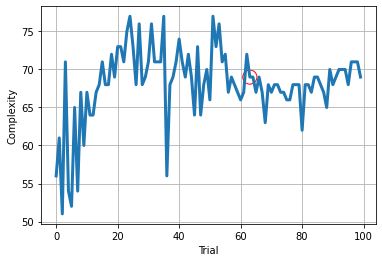

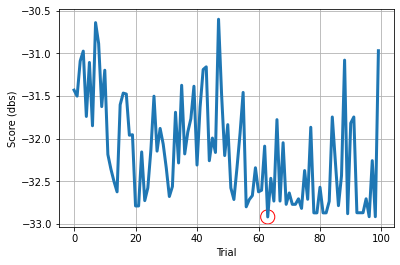

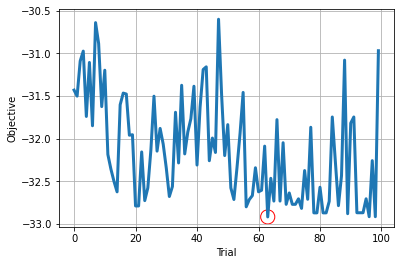

In [ ]:
plt.figure()
plt.plot(COMP, linewidth=3)
plt.xlabel('Trial')
plt.ylabel('Complexity')
plt.grid()
plt.scatter(63, COMP[63], s=200, facecolors='none', edgecolors='r')
#plt.savefig('COMP.png')

plt.figure()
plt.plot(SCR, linewidth=3)
plt.xlabel('Trial')
plt.ylabel('Score (dbs)')
plt.grid()
plt.scatter(63, SCR[63], s=200, facecolors='none', edgecolors='r')
#plt.savefig('SCR.png')

J = []
for i in study.trials:
  J.append(i.value)

plt.figure()
plt.plot(J, linewidth=3)
plt.xlabel('Trial')
plt.ylabel('Objective')
plt.grid()
plt.scatter(63, J[63], s=200, facecolors='none', edgecolors='r')
#plt.savefig('J.png')


In [ ]:
SCR[91]

-32.02398710001209

In [ ]:

D = {'p': [3, 4, 5, 6, 7, 8, 9], 'k' : [1, 3, 5, 9], 'z' : [-2, -1, 0, 1, 2]}
ex_D = {} # extremum vals of D

for key in D.keys():
  ex_D[key] = [ min(D[key]), max(D[key])]

# huge model
huge_model = Cell_try_2(M=ex_D['k'][1], Poly_order=ex_D['p'][1])
huge_model = huge_model.to("cpu")
#huge_model = huge_model.to("cuda:0")
optimizer = torch.optim.Adam(huge_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, huge_model, loss_fn, optimizer, 20, scheduler, save_flag=False)


loss_huge, accuracy_huge = eval_model(valid_queue, huge_model, loss_fn)
score_huge = accuracy_huge.item()
complex_huge = ex_D['k'][1] + ex_D['p'][1]


# small model
small_model = Cell_try_2(M=ex_D['k'][0], Poly_order=ex_D['p'][0])
#small_model = small_model.to("cuda:0")
small_model = small_model.to("cpu")
optimizer = torch.optim.Adam(small_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, small_model, loss_fn, optimizer, 20, scheduler, save_flag=False)


loss_small, accuracy_small = eval_model(valid_queue, small_model, loss_fn)
score_small = -13
complex_small = ex_D['k'][0] + ex_D['p'][0]
trtr_coef = 0.1
def objective(trial):
  # det hyperparams 
  poly_ord = trial.suggest_int('p', ex_D['p'][0], ex_D['p'][1])
  del_val = trial.suggest_int('z', ex_D['z'][0], ex_D['z'][1])
  conv_ord = trial.suggest_int('k', ex_D['k'][0], ex_D['k'][1], step=2)

  # create and train NN
  net = Cell_try_2(M=conv_ord, D=del_val, Poly_order=poly_ord)
  net = net.to("cpu")
  optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
  train(train_queue, valid_queue, net, loss_fn, optimizer,20,scheduler,save_flag=False)

  loss_cur, accuracy_cur = eval_model(valid_queue, net, loss_fn)
  score_cur = accuracy_cur.item()
  complex_cur = poly_ord + conv_ord

  # check if val of score is positive or not and then fix it
  #return (score_huge - score_cur) / score_huge + (complex_cur - complex_huge) / complex_huge
  return trtr_coef * (complex_cur - complex_small) / (complex_huge - complex_small) - (score_cur - score_small) / (score_huge - score_small)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

NameError: ignored